In [28]:
# Built-in modules
import os
import shutil
from pathlib import Path
import itertools
from zipfile import ZipFile
from typing import List

# Third-party modules
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf

from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import load_img, img_to_array, array_to_img
from keras import layers

In [29]:
def connect_to_resources():
    try:
        from google.colab import drive, files

        drive.mount('/content/drive')
        print('Running on COLAB')
        return '/content/drive/MyDrive/final_project'
    except ModuleNotFoundError:
        print('Not running on COLAB')
        return ''


ROOT = connect_to_resources()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on COLAB


In [274]:
# Remove with the path to the folder you want to delete
try:
    shutil.rmtree('/content/data')
except:
    print('')


def plot_confusion_matrix(confusion_matrix, classes: list,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=cm.Blues) -> None:
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7, 7))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.

    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if confusion_matrix[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# ResNet50 - RGB - AUG - MEL\NV

In [93]:
config = {
    "model_name": "ResNet50",  # ResNet50, Xception, InceptionResNetV2, VGG19
    "color_mode": "rgb",  # rgb, grayscale,
    "train_model": False,
    "to_unzip": True,
    "with_augmentations": True,
    "localization": "",  # "", "back", "abdomen", "lower extremity", "upper extremity"
    "labels": ["mel", "nv"],
}

In [94]:
IMAGE_ZIP_FILENAME = 'HAM10000.zip'
DATA_PATH = 'data'
METADATA_FILE_PATH = Path(ROOT, DATA_PATH, 'HAM10000_metadata.csv')
IMAGES_DIRECTORY = Path(DATA_PATH, 'HAM10000')

MODEL_NAME = f"model_{config['model_name']}_{config['color_mode']}" + \
             ('_aug' if config['with_augmentations'] else '_no_aug') + \
             (f"_{config['localization']}".replace(" ", "_") if config['localization'] else '') + \
             (f"_{'_'.join(config['labels'])}" if config['labels'] else '')

MODEL_PATH = Path(ROOT, DATA_PATH, 'models', f'{MODEL_NAME}.hdf5')
TRAINING_FILE = Path(ROOT, DATA_PATH, 'history', f'{MODEL_NAME}_history.csv')
PREDICTIONS_FILE = Path(ROOT, DATA_PATH, 'predictions', f'{MODEL_NAME}_predictions')
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
SEED = 42

In [95]:
def get_class_names(_metadata_df: pd.DataFrame) -> List[str]:
    """get the class names from the metadata file"""
    return sorted(list(_metadata_df['dx'].str.lower().unique()))


def get_metadata_df(metadata_file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(metadata_file_path)
    lesion_types = df['dx'].unique()

    if config['labels']:
        if set(config['labels']).issubset(set(lesion_types)):
            df = df[df['dx'].isin(config['labels'])]
        else:
            raise ValueError(f'Invalid labels: {config["labels"]}')

    if config['localization'] != '':
        if config['localization'] in df['localization'].unique():
            df = df[df['localization'] == config['localization']]

            # check that all lesion types are present
            remaining_lesion_types = df['dx'].unique()

            if len(remaining_lesion_types) != len(lesion_types):
                missing_lesion_types = set(lesion_types) - set(remaining_lesion_types)
                raise ValueError(
                    f'Missing lesion types: {missing_lesion_types}.\nMust include all lesions types in order to run on a subset of the dataset.')
        else:
            raise ValueError(f'Invalid localization: {config["localization"]}')

    return df


metadata_df = get_metadata_df(METADATA_FILE_PATH)
class_names = get_class_names(metadata_df)
class_names

['mel', 'nv']

In [96]:
def get_df_labels(metadata_df: pd.DataFrame, classes: List[str]) -> pd.DataFrame:
    """get the DataFrame with the labels for each image"""
    # perform one-hot encoding on the 'dx' column
    one_hot = pd.get_dummies(metadata_df['dx'])

    # add the one-hot encoding to the original DataFrame and drop the 'dx' column
    df_labels = pd.concat([metadata_df, one_hot], axis=1).drop('dx', axis=1)

    df_labels['label'] = one_hot.idxmax(axis=1)

    # re-arrange the columns to match the desired output
    df_labels = df_labels[['image_id'] + classes + ['label']]

    return df_labels


df_labels = get_df_labels(metadata_df, class_names)
df_labels.head()

,image_id,mel,nv,label
64,ISIC_0024698,0,1,nv
1210,ISIC_0024693,0,1,nv
1211,ISIC_0025964,1,0,mel
1212,ISIC_0030623,1,0,mel
1213,ISIC_0027190,1,0,mel


In [97]:
class ConvertToGrayscale(layers.Layer):
    def __init__(self):
        super(ConvertToGrayscale, self).__init__()

    def call(self, inputs):
        grayscale = tf.image.rgb_to_grayscale(inputs)
        return tf.concat([grayscale, grayscale, grayscale], axis=-1)


def preprocess(classes: List[str]) -> None:
    """Preprocess zip file: extract and split images into their class folder"""
    # Read the zip file and extract it
    with ZipFile(Path(ROOT, DATA_PATH, IMAGE_ZIP_FILENAME), 'r') as z:
        # Extracting all the files to PATH directory
        z.extractall(DATA_PATH)
        print('Zip file extracted')

    for i in classes:
        os.makedirs(Path(IMAGES_DIRECTORY, i), exist_ok=True)

    # Split images to folders by class
    images = os.listdir(IMAGES_DIRECTORY)
    images = [image for image in images if image.endswith('.jpg')]

    for image in tqdm(images):
        fname = image.split('.jpg')[0]

        try:
            # check if the image is in the metadata file
            label = df_labels.loc[df_labels['image_id'] == fname, 'label'].values[0]
        except IndexError:
            # if the image is not in the metadata file, delete it and continue to next one
            os.remove(Path(IMAGES_DIRECTORY, image))
            continue

        src = str(Path(IMAGES_DIRECTORY, image))  # Convert path to string
        dst = str(Path(IMAGES_DIRECTORY, label, image))  # Convert path to string

        # Convert image to grayscale if config['color_mode'] is 'grayscale'
        if config['color_mode'] == 'grayscale':
            img = load_img(src, target_size=TARGET_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Create the grayscale conversion layer
            grayscale_layer = ConvertToGrayscale()

            # Convert the image to grayscale
            grayscale_image = grayscale_layer(img_array)
            grayscale_image = tf.squeeze(grayscale_image, axis=0)
            grayscale_image = tf.cast(grayscale_image, dtype=tf.uint8)

            # Save the grayscale image
            tf.io.write_file(dst, tf.image.encode_jpeg(grayscale_image).numpy())
        else:
            shutil.move(src, dst)

In [98]:
if config['to_unzip']:
    preprocess(class_names)

# create the directories if they don't exist
for n in ['models', 'history', 'predictions']:
    if not os.path.exists(Path(DATA_PATH, n)):
        os.makedirs(Path(DATA_PATH, n))

Zip file extracted


100%|██████████| 10015/10015 [00:10<00:00, 973.94it/s]


In [99]:
class_weights = class_weight.compute_class_weight('balanced', classes=class_names, y=df_labels['label'])
class_wt_dict = dict(enumerate(class_weights))
class_wt_dict

{0: 3.512129380053908, 1: 0.5829977628635347}

In [100]:
def get_augmentations(with_augmentations: bool) -> dict:
    result = {}

    if with_augmentations:
        result = {
            'horizontal_flip': True,
            'vertical_flip': True,
            'rotation_range': 30,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'zoom_range': 0.2,
            'fill_mode': 'nearest',
        }
    else:
        print('no augmentations')

    return result


data_augmentation = get_augmentations(config['with_augmentations'])

In [101]:
def get_model(name: str):
    inputs = {
        'weights': 'imagenet',  # load weights pre-trained on ImageNet
        'include_top': False,  # do not include the ImageNet classifier at the top
        'input_shape': TARGET_SIZE + (3,)
    }

    if name == 'ResNet50':
        _base_model = ResNet50(**inputs)
        _base_preprocess = tf.keras.applications.resnet50.preprocess_input
        _last_conv_layer_name = 'conv5_block3_out'
    elif name == 'InceptionResNetV2':
        _base_model = InceptionResNetV2(**inputs)
        _base_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input
        _last_conv_layer_name = 'conv_7b_ac'
    elif name == 'Xception':
        _base_model = Xception(**inputs)
        _base_preprocess = tf.keras.applications.xception.preprocess_input  # this model expects data in the range of (-1,1) and not (0,1)
        _last_conv_layer_name = 'block14_sepconv2_act'
    elif name == 'VGG19':
        _base_model = VGG19(**inputs)
        _base_preprocess = tf.keras.applications.vgg19.preprocess_input
        _last_conv_layer_name = 'block5_conv4'
    else:
        raise ValueError('Invalid model name')

    return _base_model, _base_preprocess, _last_conv_layer_name

In [102]:
base_model, base_preprocess, last_conv_layer_name = get_model(config['model_name'])
image_gen = ImageDataGenerator(preprocessing_function=base_preprocess, validation_split=0.15, **data_augmentation)

In [103]:
flow_from_directory_args = {
    'directory': IMAGES_DIRECTORY,
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'seed': SEED,
}

train_image_gen = image_gen.flow_from_directory(subset='training', **flow_from_directory_args)
test_image_gen = image_gen.flow_from_directory(subset='validation', shuffle=False, **flow_from_directory_args)
print(test_image_gen.class_indices)

Found 6647 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.
{'mel': 0, 'nv': 1}


In [107]:
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)
second_model = Model(inputs=base_model.input, outputs=x)

In [108]:
optimizer = Adam(0.00001)
second_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(TRAINING_FILE, append=False)
model_chkpt = ModelCheckpoint(MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_accuracy',
                              verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

callback_list = [csv_logger, model_chkpt, lr_reduce, early_stop]

In [109]:
if config['train_model']:
    history = second_model.fit(train_image_gen,
                               epochs=30,
                               validation_data=test_image_gen,
                               class_weight=class_wt_dict,
                               callbacks=callback_list
                               )

    log_data = pd.DataFrame(second_model.history.history)
    # log_data.to_csv(TRAINING_FILE)
else:
    second_model.load_weights(MODEL_PATH)  # load weights
    log_data = pd.read_csv(TRAINING_FILE)  # load history

In [110]:
second_model.evaluate(test_image_gen)

19/19 [==============================] - 28s 1s/step - loss: 1.0832 - accuracy: 0.9488


[1.0831917524337769, 0.9487617611885071]

In [111]:
predictions = second_model.predict(test_image_gen, verbose=1)
# save predictions
# np.save(PREDICTIONS_FILE, predictions)

19/19 [==============================] - 28s 1s/step


In [112]:
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

Normalized confusion matrix


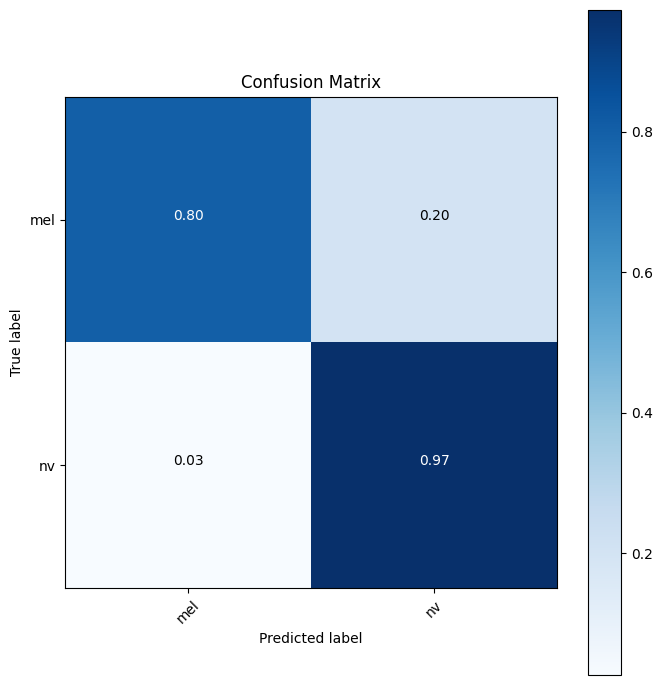

In [115]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

# ResNet50 - RGB - AUG - AKIEC\BCC

In [116]:
# Remove with the path to the folder you want to delete
try:
    shutil.rmtree('/content/data')
except:
    print('')

In [117]:
config = {
    "model_name": "ResNet50",  # ResNet50, Xception, InceptionResNetV2, VGG19
    "color_mode": "rgb",  # rgb, grayscale,
    "train_model": False,
    "to_unzip": True,
    "with_augmentations": True,
    "localization": "",  # "", "back", "abdomen", "lower extremity", "upper extremity"
    "labels": ["bcc", "akiec"],
}

In [118]:
IMAGE_ZIP_FILENAME = 'HAM10000.zip'
DATA_PATH = 'data'
METADATA_FILE_PATH = Path(ROOT, DATA_PATH, 'HAM10000_metadata.csv')
IMAGES_DIRECTORY = Path(DATA_PATH, 'HAM10000')

MODEL_NAME = f"model_{config['model_name']}_{config['color_mode']}" + \
             ('_aug' if config['with_augmentations'] else '_no_aug') + \
             (f"_{config['localization']}".replace(" ", "_") if config['localization'] else '') + \
             (f"_{'_'.join(config['labels'])}" if config['labels'] else '')

MODEL_PATH = Path(ROOT, DATA_PATH, 'models', f'{MODEL_NAME}.hdf5')
TRAINING_FILE = Path(ROOT, DATA_PATH, 'history', f'{MODEL_NAME}_history.csv')
PREDICTIONS_FILE = Path(ROOT, DATA_PATH, 'predictions', f'{MODEL_NAME}_predictions')
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
SEED = 42

In [119]:
def get_class_names(_metadata_df: pd.DataFrame) -> List[str]:
    """get the class names from the metadata file"""
    return sorted(list(_metadata_df['dx'].str.lower().unique()))


def get_metadata_df(metadata_file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(metadata_file_path)
    lesion_types = df['dx'].unique()

    if config['labels']:
        if set(config['labels']).issubset(set(lesion_types)):
            df = df[df['dx'].isin(config['labels'])]
        else:
            raise ValueError(f'Invalid labels: {config["labels"]}')

    if config['localization'] != '':
        if config['localization'] in df['localization'].unique():
            df = df[df['localization'] == config['localization']]

            # check that all lesion types are present
            remaining_lesion_types = df['dx'].unique()

            if len(remaining_lesion_types) != len(lesion_types):
                missing_lesion_types = set(lesion_types) - set(remaining_lesion_types)
                raise ValueError(
                    f'Missing lesion types: {missing_lesion_types}.\nMust include all lesions types in order to run on a subset of the dataset.')
        else:
            raise ValueError(f'Invalid localization: {config["localization"]}')

    return df


metadata_df = get_metadata_df(METADATA_FILE_PATH)
class_names = get_class_names(metadata_df)
class_names

['akiec', 'bcc']

In [120]:
def get_df_labels(metadata_df: pd.DataFrame, classes: List[str]) -> pd.DataFrame:
    """get the DataFrame with the labels for each image"""
    # perform one-hot encoding on the 'dx' column
    one_hot = pd.get_dummies(metadata_df['dx'])

    # add the one-hot encoding to the original DataFrame and drop the 'dx' column
    df_labels = pd.concat([metadata_df, one_hot], axis=1).drop('dx', axis=1)

    df_labels['label'] = one_hot.idxmax(axis=1)

    # re-arrange the columns to match the desired output
    df_labels = df_labels[['image_id'] + classes + ['label']]

    return df_labels


df_labels = get_df_labels(metadata_df, class_names)
df_labels.head()

,image_id,akiec,bcc,label
2462,ISIC_0028155,0,1,bcc
2463,ISIC_0034093,0,1,bcc
2464,ISIC_0029230,0,1,bcc
2465,ISIC_0031513,0,1,bcc
2466,ISIC_0032384,0,1,bcc


In [121]:
class ConvertToGrayscale(layers.Layer):
    def __init__(self):
        super(ConvertToGrayscale, self).__init__()

    def call(self, inputs):
        grayscale = tf.image.rgb_to_grayscale(inputs)
        return tf.concat([grayscale, grayscale, grayscale], axis=-1)


def preprocess(classes: List[str]) -> None:
    """Preprocess zip file: extract and split images into their class folder"""
    # Read the zip file and extract it
    with ZipFile(Path(ROOT, DATA_PATH, IMAGE_ZIP_FILENAME), 'r') as z:
        # Extracting all the files to PATH directory
        z.extractall(DATA_PATH)
        print('Zip file extracted')

    for i in classes:
        os.makedirs(Path(IMAGES_DIRECTORY, i), exist_ok=True)

    # Split images to folders by class
    images = os.listdir(IMAGES_DIRECTORY)
    images = [image for image in images if image.endswith('.jpg')]

    for image in tqdm(images):
        fname = image.split('.jpg')[0]

        try:
            # check if the image is in the metadata file
            label = df_labels.loc[df_labels['image_id'] == fname, 'label'].values[0]
        except IndexError:
            # if the image is not in the metadata file, delete it and continue to next one
            os.remove(Path(IMAGES_DIRECTORY, image))
            continue

        src = str(Path(IMAGES_DIRECTORY, image))  # Convert path to string
        dst = str(Path(IMAGES_DIRECTORY, label, image))  # Convert path to string

        # Convert image to grayscale if config['color_mode'] is 'grayscale'
        if config['color_mode'] == 'grayscale':
            img = load_img(src, target_size=TARGET_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Create the grayscale conversion layer
            grayscale_layer = ConvertToGrayscale()

            # Convert the image to grayscale
            grayscale_image = grayscale_layer(img_array)
            grayscale_image = tf.squeeze(grayscale_image, axis=0)
            grayscale_image = tf.cast(grayscale_image, dtype=tf.uint8)

            # Save the grayscale image
            tf.io.write_file(dst, tf.image.encode_jpeg(grayscale_image).numpy())
        else:
            shutil.move(src, dst)

In [122]:
if config['to_unzip']:
    preprocess(class_names)

# create the directories if they don't exist
for n in ['models', 'history', 'predictions']:
    if not os.path.exists(Path(DATA_PATH, n)):
        os.makedirs(Path(DATA_PATH, n))

Zip file extracted


100%|██████████| 10015/10015 [00:05<00:00, 1909.00it/s]


In [123]:
class_weights = class_weight.compute_class_weight('balanced', classes=class_names, y=df_labels['label'])
class_wt_dict = dict(enumerate(class_weights))
class_wt_dict

{0: 1.2859327217125383, 1: 0.8180933852140078}

In [124]:
def get_augmentations(with_augmentations: bool) -> dict:
    result = {}

    if with_augmentations:
        result = {
            'horizontal_flip': True,
            'vertical_flip': True,
            'rotation_range': 30,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'zoom_range': 0.2,
            'fill_mode': 'nearest',
        }
    else:
        print('no augmentations')

    return result


data_augmentation = get_augmentations(config['with_augmentations'])

In [125]:
def get_model(name: str):
    inputs = {
        'weights': 'imagenet',  # load weights pre-trained on ImageNet
        'include_top': False,  # do not include the ImageNet classifier at the top
        'input_shape': TARGET_SIZE + (3,)
    }

    if name == 'ResNet50':
        _base_model = ResNet50(**inputs)
        _base_preprocess = tf.keras.applications.resnet50.preprocess_input
        _last_conv_layer_name = 'conv5_block3_out'
    elif name == 'InceptionResNetV2':
        _base_model = InceptionResNetV2(**inputs)
        _base_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input
        _last_conv_layer_name = 'conv_7b_ac'
    elif name == 'Xception':
        _base_model = Xception(**inputs)
        _base_preprocess = tf.keras.applications.xception.preprocess_input  # this model expects data in the range of (-1,1) and not (0,1)
        _last_conv_layer_name = 'block14_sepconv2_act'
    elif name == 'VGG19':
        _base_model = VGG19(**inputs)
        _base_preprocess = tf.keras.applications.vgg19.preprocess_input
        _last_conv_layer_name = 'block5_conv4'
    else:
        raise ValueError('Invalid model name')

    return _base_model, _base_preprocess, _last_conv_layer_name

In [126]:
base_model, base_preprocess, last_conv_layer_name = get_model(config['model_name'])
image_gen = ImageDataGenerator(preprocessing_function=base_preprocess, validation_split=0.15, **data_augmentation)

In [127]:
flow_from_directory_args = {
    'directory': IMAGES_DIRECTORY,
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'seed': SEED,
}

train_image_gen = image_gen.flow_from_directory(subset='training', **flow_from_directory_args)
test_image_gen = image_gen.flow_from_directory(subset='validation', shuffle=False, **flow_from_directory_args)
print(test_image_gen.class_indices)

Found 715 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
{'akiec': 0, 'bcc': 1}


In [128]:
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)
third_model = Model(inputs=base_model.input, outputs=x)

In [129]:
optimizer = Adam(0.00001)
third_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(TRAINING_FILE, append=False)
model_chkpt = ModelCheckpoint(MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_accuracy',
                              verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

callback_list = [csv_logger, model_chkpt, lr_reduce, early_stop]

In [130]:
if config['train_model']:
    history = third_model.fit(train_image_gen,
                              epochs=30,
                              validation_data=test_image_gen,
                              class_weight=class_wt_dict,
                              callbacks=callback_list
                              )

    log_data = pd.DataFrame(third_model.history.history)
    # log_data.to_csv(TRAINING_FILE)
else:
    third_model.load_weights(MODEL_PATH)  # load weights
    log_data = pd.read_csv(TRAINING_FILE)  # load history

In [131]:
third_model.evaluate(test_image_gen)

2/2 [==============================] - 5s 1s/step - loss: 3.1335 - accuracy: 0.8810


[3.1334683895111084, 0.8809523582458496]

In [132]:
predictions = third_model.predict(test_image_gen, verbose=1)
# save predictions
np.save(PREDICTIONS_FILE, predictions)

2/2 [==============================] - 4s 1s/step


In [133]:
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

Normalized confusion matrix


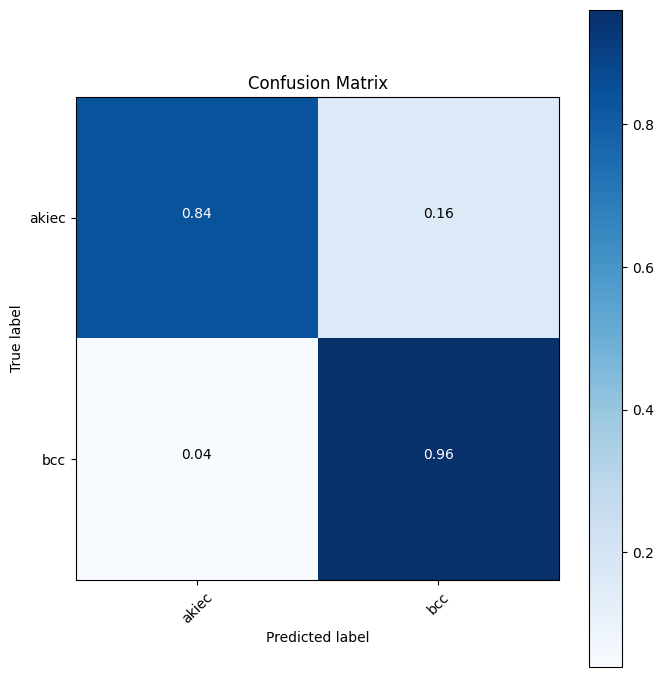

In [134]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [135]:
# Remove with the path to the folder you want to delete
try:
    shutil.rmtree('/content/data')
except:
    print('')

# ResNet50 - RGB - AUG - MEL\BKL


In [229]:
# Remove with the path to the folder you want to delete
try:
    shutil.rmtree('/content/data')
except:
    print('')

In [232]:
config = {
    "model_name": "ResNet50",  # ResNet50, Xception, InceptionResNetV2, VGG19
    "color_mode": "rgb",  # rgb, grayscale,
    "train_model": False,
    "to_unzip": True,
    "with_augmentations": True,
    "localization": "",  # "", "back", "abdomen", "lower extremity", "upper extremity"
    "labels": ["mel", "bkl"],
}

In [233]:
IMAGE_ZIP_FILENAME = 'HAM10000.zip'
DATA_PATH = 'data'
METADATA_FILE_PATH = Path(ROOT, DATA_PATH, 'HAM10000_metadata.csv')
IMAGES_DIRECTORY = Path(DATA_PATH, 'HAM10000')

MODEL_NAME = f"model_{config['model_name']}_{config['color_mode']}" + \
             ('_aug' if config['with_augmentations'] else '_no_aug') + \
             (f"_{config['localization']}".replace(" ", "_") if config['localization'] else '') + \
             (f"_{'_'.join(config['labels'])}" if config['labels'] else '')

MODEL_PATH = Path(ROOT, DATA_PATH, 'models', f'{MODEL_NAME}.hdf5')
TRAINING_FILE = Path(ROOT, DATA_PATH, 'history', f'{MODEL_NAME}_history.csv')
PREDICTIONS_FILE = Path(ROOT, DATA_PATH, 'predictions', f'{MODEL_NAME}_predictions')
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
SEED = 42

In [234]:
def get_class_names(_metadata_df: pd.DataFrame) -> List[str]:
    """get the class names from the metadata file"""
    return sorted(list(_metadata_df['dx'].str.lower().unique()))


def get_metadata_df(metadata_file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(metadata_file_path)
    lesion_types = df['dx'].unique()

    if config['labels']:
        if set(config['labels']).issubset(set(lesion_types)):
            df = df[df['dx'].isin(config['labels'])]
        else:
            raise ValueError(f'Invalid labels: {config["labels"]}')

    if config['localization'] != '':
        if config['localization'] in df['localization'].unique():
            df = df[df['localization'] == config['localization']]

            # check that all lesion types are present
            remaining_lesion_types = df['dx'].unique()

            if len(remaining_lesion_types) != len(lesion_types):
                missing_lesion_types = set(lesion_types) - set(remaining_lesion_types)
                raise ValueError(
                    f'Missing lesion types: {missing_lesion_types}.\nMust include all lesions types in order to run on a subset of the dataset.')
        else:
            raise ValueError(f'Invalid localization: {config["localization"]}')

    return df


metadata_df = get_metadata_df(METADATA_FILE_PATH)
class_names = get_class_names(metadata_df)
class_names

['bkl', 'mel']

In [235]:
def get_df_labels(metadata_df: pd.DataFrame, classes: List[str]) -> pd.DataFrame:
    """get the DataFrame with the labels for each image"""
    # perform one-hot encoding on the 'dx' column
    one_hot = pd.get_dummies(metadata_df['dx'])

    # add the one-hot encoding to the original DataFrame and drop the 'dx' column
    df_labels = pd.concat([metadata_df, one_hot], axis=1).drop('dx', axis=1)

    df_labels['label'] = one_hot.idxmax(axis=1)

    # re-arrange the columns to match the desired output
    df_labels = df_labels[['image_id'] + classes + ['label']]

    return df_labels


df_labels = get_df_labels(metadata_df, class_names)
df_labels.head()

,image_id,bkl,mel,label
0,ISIC_0027419,1,0,bkl
1,ISIC_0025030,1,0,bkl
2,ISIC_0026769,1,0,bkl
3,ISIC_0025661,1,0,bkl
4,ISIC_0031633,1,0,bkl


In [236]:
class ConvertToGrayscale(layers.Layer):
    def __init__(self):
        super(ConvertToGrayscale, self).__init__()

    def call(self, inputs):
        grayscale = tf.image.rgb_to_grayscale(inputs)
        return tf.concat([grayscale, grayscale, grayscale], axis=-1)


def preprocess(classes: List[str]) -> None:
    """Preprocess zip file: extract and split images into their class folder"""
    # Read the zip file and extract it
    with ZipFile(Path(ROOT, DATA_PATH, IMAGE_ZIP_FILENAME), 'r') as z:
        # Extracting all the files to PATH directory
        z.extractall(DATA_PATH)
        print('Zip file extracted')

    for i in classes:
        os.makedirs(Path(IMAGES_DIRECTORY, i), exist_ok=True)

    # Split images to folders by class
    images = os.listdir(IMAGES_DIRECTORY)
    images = [image for image in images if image.endswith('.jpg')]

    for image in tqdm(images):
        fname = image.split('.jpg')[0]

        try:
            # check if the image is in the metadata file
            label = df_labels.loc[df_labels['image_id'] == fname, 'label'].values[0]
        except IndexError:
            # if the image is not in the metadata file, delete it and continue to next one
            os.remove(Path(IMAGES_DIRECTORY, image))
            continue

        src = str(Path(IMAGES_DIRECTORY, image))  # Convert path to string
        dst = str(Path(IMAGES_DIRECTORY, label, image))  # Convert path to string

        # Convert image to grayscale if config['color_mode'] is 'grayscale'
        if config['color_mode'] == 'grayscale':
            img = load_img(src, target_size=TARGET_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Create the grayscale conversion layer
            grayscale_layer = ConvertToGrayscale()

            # Convert the image to grayscale
            grayscale_image = grayscale_layer(img_array)
            grayscale_image = tf.squeeze(grayscale_image, axis=0)
            grayscale_image = tf.cast(grayscale_image, dtype=tf.uint8)

            # Save the grayscale image
            tf.io.write_file(dst, tf.image.encode_jpeg(grayscale_image).numpy())
        else:
            shutil.move(src, dst)

In [238]:
if config['to_unzip']:
    preprocess(class_names)

# create the directories if they don't exist
for n in ['models', 'history', 'predictions']:
    if not os.path.exists(Path(DATA_PATH, n)):
        os.makedirs(Path(DATA_PATH, n))

Zip file extracted


100%|██████████| 10015/10015 [00:06<00:00, 1490.93it/s]


In [239]:
class_weights = class_weight.compute_class_weight('balanced', classes=class_names, y=df_labels['label'])
class_wt_dict = dict(enumerate(class_weights))
class_wt_dict

{0: 1.0063694267515924, 1: 0.9937106918238994}

In [240]:
def get_augmentations(with_augmentations: bool) -> dict:
    result = {}

    if with_augmentations:
        result = {
            'horizontal_flip': True,
            'vertical_flip': True,
            'rotation_range': 30,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'zoom_range': 0.2,
            'fill_mode': 'nearest',
        }
    else:
        print('no augmentations')

    return result


data_augmentation = get_augmentations(config['with_augmentations'])

In [241]:
def get_model(name: str):
    inputs = {
        'weights': 'imagenet',  # load weights pre-trained on ImageNet
        'include_top': False,  # do not include the ImageNet classifier at the top
        'input_shape': TARGET_SIZE + (3,)
    }

    if name == 'ResNet50':
        _base_model = ResNet50(**inputs)
        _base_preprocess = tf.keras.applications.resnet50.preprocess_input
        _last_conv_layer_name = 'conv5_block3_out'
    elif name == 'InceptionResNetV2':
        _base_model = InceptionResNetV2(**inputs)
        _base_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input
        _last_conv_layer_name = 'conv_7b_ac'
    elif name == 'Xception':
        _base_model = Xception(**inputs)
        _base_preprocess = tf.keras.applications.xception.preprocess_input  # this model expects data in the range of (-1,1) and not (0,1)
        _last_conv_layer_name = 'block14_sepconv2_act'
    elif name == 'VGG19':
        _base_model = VGG19(**inputs)
        _base_preprocess = tf.keras.applications.vgg19.preprocess_input
        _last_conv_layer_name = 'block5_conv4'
    else:
        raise ValueError('Invalid model name')

    return _base_model, _base_preprocess, _last_conv_layer_name

In [242]:
base_model, base_preprocess, last_conv_layer_name = get_model(config['model_name'])
image_gen = ImageDataGenerator(preprocessing_function=base_preprocess, validation_split=0.15, **data_augmentation)

In [243]:
flow_from_directory_args = {
    'directory': IMAGES_DIRECTORY,
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'seed': SEED,
}

train_image_gen = image_gen.flow_from_directory(subset='training', **flow_from_directory_args)
test_image_gen = image_gen.flow_from_directory(subset='validation', shuffle=False, **flow_from_directory_args)
print(test_image_gen.class_indices)

Found 1882 images belonging to 2 classes.
Found 330 images belonging to 2 classes.
{'bkl': 0, 'mel': 1}


In [245]:
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)
forth_model = Model(inputs=base_model.input, outputs=x)

In [246]:
optimizer = Adam(0.0001)
forth_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(TRAINING_FILE, append=False)
model_chkpt = ModelCheckpoint(MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_accuracy',
                              verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

callback_list = [csv_logger, model_chkpt, lr_reduce, early_stop]

In [247]:
if config['train_model']:
    history = forth_model.fit(train_image_gen,
                              epochs=30,
                              validation_data=test_image_gen,
                              class_weight=class_wt_dict,
                              callbacks=callback_list
                              )

    log_data = pd.DataFrame(forth_model.history.history)
    log_data.to_csv(TRAINING_FILE)
else:
    forth_model.load_weights(MODEL_PATH)  # load weights
    log_data = pd.read_csv(TRAINING_FILE)  # load history

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 5.3303 - accuracy: 0.5712
Epoch 1: val_accuracy improved from -inf to 0.66970, saving model to /content/drive/MyDrive/final_project/data/models/model_ResNet50_rgb_aug_mel_bkl.hdf5
30/30 [==============================] - 64s 2s/step - loss: 5.3303 - accuracy: 0.5712 - val_loss: 5.1810 - val_accuracy: 0.6697 - lr: 1.0000e-05
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 5.1707 - accuracy: 0.6631
Epoch 2: val_accuracy improved from 0.66970 to 0.71515, saving model to /content/drive/MyDrive/final_project/data/models/model_ResNet50_rgb_aug_mel_bkl.hdf5
30/30 [==============================] - 56s 2s/step - loss: 5.1707 - accuracy: 0.6631 - val_loss: 5.0682 - val_accuracy: 0.7152 - lr: 1.0000e-05
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 5.0960 - accuracy: 0.6860
Epoch 3: val_accuracy did not improve from 0.71515
30/30 [==============================] - 55s 2s/step - loss: 5.0

In [248]:
forth_model.evaluate(test_image_gen)

6/6 [==============================] - 7s 1s/step - loss: 4.0623 - accuracy: 0.8758


[4.062337398529053, 0.8757575750350952]

In [249]:
predictions = forth_model.predict(test_image_gen, verbose=1)
# save predictions
np.save(PREDICTIONS_FILE, predictions)

6/6 [==============================] - 8s 1s/step


In [250]:
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

Normalized confusion matrix


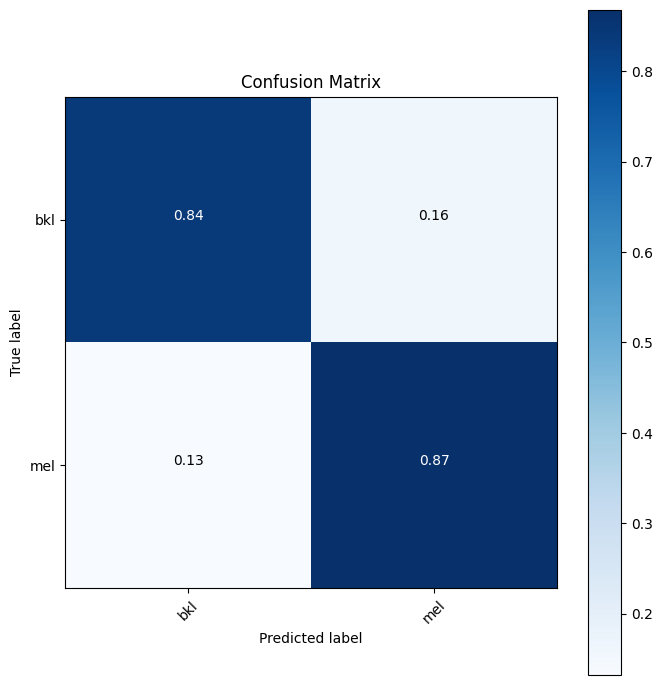

In [251]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [ ]:
# Remove with the path to the folder you want to delete
try:
    shutil.rmtree('/content/data')
except:
    print('')

# ResNet50 - AUG - RGB - ALL

In [275]:
config = {
    "model_name": "ResNet50",  # ResNet50, Xception, InceptionResNetV2, VGG19
    "color_mode": "rgb",  # rgb, grayscale,
    "train_model": False,
    "to_unzip": True,
    "with_augmentations": True,
    "localization": "",  # "", "back", "abdomen", "lower extremity", "upper extremity"
}

In [276]:
def connect_to_resources():
    try:
        from google.colab import drive, files

        drive.mount('/content/drive')
        print('Running on COLAB')
        return '/content/drive/MyDrive/final_project'
    except ModuleNotFoundError:
        print('Not running on COLAB')
        return ''


ROOT = connect_to_resources()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on COLAB


In [277]:
IMAGE_ZIP_FILENAME = 'HAM10000.zip'
DATA_PATH = 'data'
METADATA_FILE_PATH = Path(ROOT, DATA_PATH, 'HAM10000_metadata.csv')
IMAGES_DIRECTORY = Path(DATA_PATH, 'HAM10000')

MODEL_NAME = f"model_{config['model_name']}_{config['color_mode']}" + \
             ('_aug' if config['with_augmentations'] else '_no_aug') + \
             (f"_{config['localization']}".replace(" ", "_") if config['localization'] else '')
MODEL_PATH = Path(ROOT, DATA_PATH, 'models', f'{MODEL_NAME}.hdf5')
TRAINING_FILE = Path(ROOT, DATA_PATH, 'history', f'{MODEL_NAME}_history.csv')
PREDICTIONS_FILE = Path(ROOT, DATA_PATH, 'predictions', f'{MODEL_NAME}_predictions')

BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
SEED = 42

In [278]:
def get_class_names(_metadata_df: pd.DataFrame) -> List[str]:
    """get the class names from the metadata file"""
    return sorted(list(_metadata_df['dx'].str.lower().unique()))


def get_metadata_df(metadata_file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(metadata_file_path)
    lesion_types = df['dx'].unique()

    if config['localization'] != '':
        if config['localization'] in df['localization'].unique():
            df = df[df['localization'] == config['localization']]

            # check that all lesion types are present
            remaining_lesion_types = df['dx'].unique()

            if len(remaining_lesion_types) != len(lesion_types):
                missing_lesion_types = set(lesion_types) - set(remaining_lesion_types)
                raise ValueError(
                    f'Missing lesion types: {missing_lesion_types}.\nMust include all lesions types in order to run on a subset of the dataset.')
        else:
            raise ValueError(f'Invalid localization: {config["localization"]}')

    return df


metadata_df = get_metadata_df(METADATA_FILE_PATH)
class_names = get_class_names(metadata_df)
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [279]:
def get_df_labels(metadata_df: pd.DataFrame, classes: List[str]) -> pd.DataFrame:
    """get the DataFrame with the labels for each image"""
    # perform one-hot encoding on the 'dx' column
    one_hot = pd.get_dummies(metadata_df['dx'])

    # add the one-hot encoding to the original DataFrame and drop the 'dx' column
    df_labels = pd.concat([metadata_df, one_hot], axis=1).drop('dx', axis=1)

    df_labels['label'] = one_hot.idxmax(axis=1)

    # re-arrange the columns to match the desired output
    df_labels = df_labels[['image_id'] + classes + ['label']]

    return df_labels


df_labels = get_df_labels(metadata_df, class_names)
df_labels.head()

,image_id,akiec,bcc,bkl,df,mel,nv,vasc,label
0,ISIC_0027419,0,0,1,0,0,0,0,bkl
1,ISIC_0025030,0,0,1,0,0,0,0,bkl
2,ISIC_0026769,0,0,1,0,0,0,0,bkl
3,ISIC_0025661,0,0,1,0,0,0,0,bkl
4,ISIC_0031633,0,0,1,0,0,0,0,bkl


In [280]:
class ConvertToGrayscale(layers.Layer):
    def __init__(self):
        super(ConvertToGrayscale, self).__init__()

    def call(self, inputs):
        grayscale = tf.image.rgb_to_grayscale(inputs)
        return tf.concat([grayscale, grayscale, grayscale], axis=-1)


def preprocess(classes: List[str]) -> None:
    """Preprocess zip file: extract and split images into their class folder"""
    # Read the zip file and extract it
    with ZipFile(Path(ROOT, DATA_PATH, IMAGE_ZIP_FILENAME), 'r') as z:
        # Extracting all the files to PATH directory
        z.extractall(DATA_PATH)
        print('Zip file extracted')

    for i in classes:
        os.makedirs(Path(IMAGES_DIRECTORY, i), exist_ok=True)

    # Split images to folders by class
    images = os.listdir(IMAGES_DIRECTORY)
    images = [image for image in images if image.endswith('.jpg')]

    for image in tqdm(images):
        fname = image.split('.jpg')[0]

        try:
            # check if the image is in the metadata file
            label = df_labels.loc[df_labels['image_id'] == fname, 'label'].values[0]
        except IndexError:
            # if the image is not in the metadata file, delete it and continue to next one
            os.remove(Path(IMAGES_DIRECTORY, image))
            continue

        src = str(Path(IMAGES_DIRECTORY, image))  # Convert path to string
        dst = str(Path(IMAGES_DIRECTORY, label, image))  # Convert path to string

        # Convert image to grayscale if config['color_mode'] is 'grayscale'
        if config['color_mode'] == 'grayscale':
            img = load_img(src, target_size=TARGET_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Create the grayscale conversion layer
            grayscale_layer = ConvertToGrayscale()

            # Convert the image to grayscale
            grayscale_image = grayscale_layer(img_array)
            grayscale_image = tf.squeeze(grayscale_image, axis=0)
            grayscale_image = tf.cast(grayscale_image, dtype=tf.uint8)

            # Save the grayscale image
            tf.io.write_file(dst, tf.image.encode_jpeg(grayscale_image).numpy())
        else:
            shutil.move(src, dst)

In [281]:
if config['to_unzip']:
    preprocess(class_names)

# create the directories if they don't exist
for n in ['models', 'history', 'predictions']:
    if not os.path.exists(Path(DATA_PATH, n)):
        os.makedirs(Path(DATA_PATH, n))

Zip file extracted


100%|██████████| 10015/10015 [00:10<00:00, 921.59it/s]


In [282]:
class_weights = class_weight.compute_class_weight('balanced', classes=class_names, y=df_labels['label'])
class_wt_dict = dict(enumerate(class_weights))

In [283]:
def get_augmentations(with_augmentations: bool) -> dict:
    result = {}

    if with_augmentations:
        result = {
            'horizontal_flip': True,
            'vertical_flip': True,
            'rotation_range': 30,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'zoom_range': 0.2,
            'fill_mode': 'nearest',
        }
    else:
        print('no augmentations')

    return result


data_augmentation = get_augmentations(config['with_augmentations'])

In [284]:
def get_model(name: str):
    inputs = {
        'weights': 'imagenet',  # load weights pre-trained on ImageNet
        'include_top': False,  # do not include the ImageNet classifier at the top
        'input_shape': TARGET_SIZE + (3,)
    }

    if name == 'ResNet50':
        _base_model = ResNet50(**inputs)
        _base_preprocess = tf.keras.applications.resnet50.preprocess_input
        _last_conv_layer_name = 'conv5_block3_out'
    elif name == 'InceptionResNetV2':
        _base_model = InceptionResNetV2(**inputs)
        _base_preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input
        _last_conv_layer_name = 'conv_7b_ac'
    elif name == 'Xception':
        _base_model = Xception(**inputs)
        _base_preprocess = tf.keras.applications.xception.preprocess_input  # this model expects data in the range of (-1,1) and not (0,1)
        _last_conv_layer_name = 'block14_sepconv2_act'
    elif name == 'VGG19':
        _base_model = VGG19(**inputs)
        _base_preprocess = tf.keras.applications.vgg19.preprocess_input
        _last_conv_layer_name = 'block5_conv4'
    else:
        raise ValueError('Invalid model name')

    return _base_model, _base_preprocess, _last_conv_layer_name

In [285]:
base_model, base_preprocess, last_conv_layer_name = get_model(config['model_name'])
image_gen = ImageDataGenerator(preprocessing_function=base_preprocess, validation_split=0.15, **data_augmentation)

In [286]:
flow_from_directory_args = {
    'directory': IMAGES_DIRECTORY,
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'seed': SEED,
}

train_image_gen = image_gen.flow_from_directory(subset='training', **flow_from_directory_args)
test_image_gen = image_gen.flow_from_directory(subset='validation', shuffle=False, **flow_from_directory_args)
print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [287]:
# save test_image_gen.classes to csv
pd.DataFrame(test_image_gen.classes).to_csv(Path(ROOT, DATA_PATH, 'test_image_gen_classes.csv'), index=False)

# save list(test_image_gen.class_indices.keys()) as csv
pd.DataFrame(list(test_image_gen.class_indices.keys())).to_csv(
    Path(ROOT, DATA_PATH, 'test_image_gen_class_indices.csv'), index=False)

In [288]:
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [289]:
optimizer = Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(TRAINING_FILE, append=False)
model_chkpt = ModelCheckpoint(MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_accuracy',
                              verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

callback_list = [csv_logger, model_chkpt, lr_reduce, early_stop]

In [290]:
if config['train_model']:
    history = model.fit(train_image_gen,
                        epochs=30,
                        validation_data=test_image_gen,
                        class_weight=class_wt_dict,
                        callbacks=callback_list
                        )

    log_data = pd.DataFrame(model.history.history)
    log_data.to_csv(TRAINING_FILE)
else:
    model.load_weights(MODEL_PATH)  # load weights
    log_data = pd.read_csv(TRAINING_FILE)  # load history

In [291]:
model.evaluate(test_image_gen)

24/24 [==============================] - 38s 1s/step - loss: 1.4807 - accuracy: 0.8799


[1.4806870222091675, 0.8799199461936951]

In [292]:
predictions = model.predict(test_image_gen, verbose=1)
# save predictions
np.save(PREDICTIONS_FILE, predictions)

24/24 [==============================] - 33s 1s/step


In [293]:
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

Normalized confusion matrix


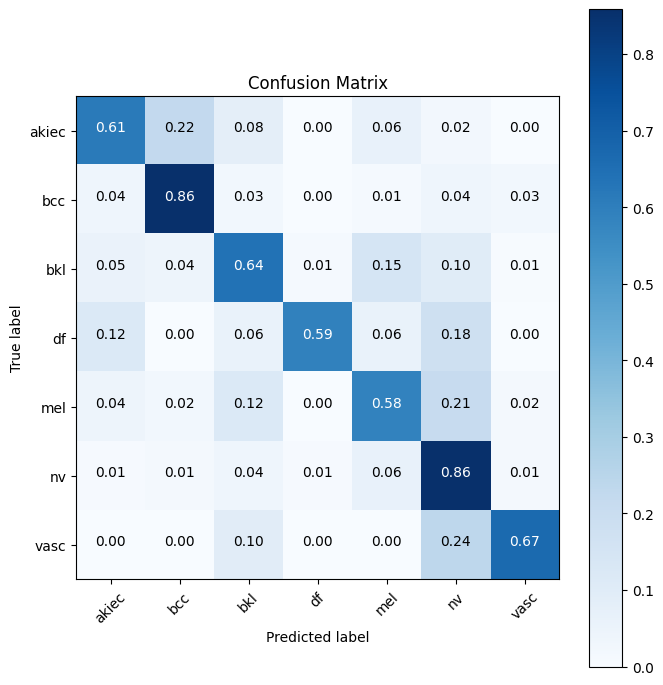

In [ ]:
def plot_confusion_matrix(confusion_matrix, classes: list,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=cm.Blues) -> None:
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7, 7))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.

    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if confusion_matrix[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [ ]:
# Creating classification report
report = classification_report(test_image_gen.classes, predictions, zero_division=0)

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.61      0.56        49
           1       0.65      0.86      0.74        77
           2       0.61      0.64      0.62       164
           3       0.53      0.59      0.56        17
           4       0.52      0.58      0.55       166
           5       0.93      0.86      0.89      1005
           6       0.41      0.67      0.51        21

    accuracy                           0.79      1499
   macro avg       0.59      0.69      0.63      1499
weighted avg       0.81      0.79      0.80      1499



# Mix-Model

1st model: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
2nd model: {'mel': 0, 'nv': 1}
3rd model:  {'akiec': 0, 'bcc': 1}

In [216]:
########################################
### MAX model 1 vs model2 vs model 3 ###
########################################

# Improved get_class_mapping function
def get_class_mapping(model_1_mapping, model_2_mapping):
    # This is a more efficient way to do the mapping
    class_mapping = {v2: v1 for k1, v1 in model_1_mapping.items() for k2, v2 in model_2_mapping.items() if k1 == k2}
    return class_mapping


# The updated predict function:
def predict(instance, model_1, model_2, model_3, class_mapping_2, class_mapping_3):
    prediction_1 = model_1.predict(instance, verbose=0)
    class_pred_1 = np.argmax(prediction_1)
    percent_1 = prediction_1[0, class_pred_1]

    # Store models and mappings in list for easier iteration
    models = [model_2, model_3]
    mappings = [class_mapping_2, class_mapping_3]
    # Indices to match the conditions in the original function
    indices = [(4, 5), (0, 1)]

    for index, model, mapping in zip(indices, models, mappings):
        if class_pred_1 in index:
            prediction = model.predict(instance, verbose=0)
            class_pred = np.argmax(prediction)
            class_pred_mapped = mapping.get(class_pred, class_pred)
            percent = prediction[0, class_pred]

            print(
                f'model 1: {class_pred_1} ({percent_1 * 100:.2f}%) VS. model {models.index(model) + 2}: {class_pred_mapped} ({percent * 100:.2f}%)')

            return class_pred_1 if percent_1 > percent else class_pred_mapped

    return class_pred_1


first_model_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
second_model_mapping = {'mel': 0, 'nv': 1}
third_model_mapping = {'akiec': 0, 'bcc': 1}
class_mapping_2 = get_class_mapping(first_model_mapping, second_model_mapping)
class_mapping_3 = get_class_mapping(first_model_mapping, third_model_mapping)

predictions = []
ground_truths = []

with tqdm(total=total) as pbar:
    for i in range(len(test_image_gen)):
        X, y_true = test_image_gen[i]
        actual_batch_size = X.shape[0]  # calculate the actual batch size

        for j in range(actual_batch_size):  # iterate over the batch
            try:
                instance = X[j]
                filename = test_image_gen.filenames[i * actual_batch_size + j]
                ground_truth = y_true[j]  # get the ground truth label
                ground_truth = np.argmax(ground_truth)  # from one-hot to class index
                ground_truths.append(ground_truth)
                prediction = predict(np.expand_dims(instance, axis=0), model, second_model, third_model,
                                     class_mapping_2, class_mapping_3)
                print(f"Image: {filename}, Prediction: {prediction}, Ground Truth: {ground_truth}")
                predictions.append(prediction)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")
            pbar.update()  # update progress bar

  0%|          | 2/1536 [00:02<27:20,  1.07s/it]  

model 1: 0 (99.40%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024329.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.99%) VS. model 3: 0 (99.99%)
Image: akiec/ISIC_0024372.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024418.jpg, Prediction: 2, Ground Truth: 0


  0%|          | 5/1536 [00:02<08:56,  2.85it/s]

model 1: 0 (99.97%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024450.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (91.98%) VS. model 3: 0 (98.51%)
Image: akiec/ISIC_0024463.jpg, Prediction: 0, Ground Truth: 0


  0%|          | 7/1536 [00:03<05:57,  4.28it/s]

model 1: 0 (100.00%) VS. model 3: 0 (99.89%)
Image: akiec/ISIC_0024468.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.25%) VS. model 3: 0 (99.99%)
Image: akiec/ISIC_0024470.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024511.jpg, Prediction: 2, Ground Truth: 0


  1%|          | 10/1536 [00:03<04:01,  6.32it/s]

model 1: 1 (76.81%) VS. model 3: 0 (99.95%)
Image: akiec/ISIC_0024517.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (84.31%) VS. model 3: 0 (98.03%)
Image: akiec/ISIC_0024522.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024539.jpg, Prediction: 2, Ground Truth: 0


  1%|          | 13/1536 [00:04<05:32,  4.58it/s]

model 1: 1 (82.24%) VS. model 3: 1 (99.95%)
Image: akiec/ISIC_0024562.jpg, Prediction: 1, Ground Truth: 0
model 1: 0 (98.35%) VS. model 3: 0 (99.95%)
Image: akiec/ISIC_0024575.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 15/1536 [00:04<04:42,  5.38it/s]

model 1: 0 (99.87%) VS. model 3: 0 (99.96%)
Image: akiec/ISIC_0024579.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (95.91%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024646.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 17/1536 [00:04<03:55,  6.46it/s]

Image: akiec/ISIC_0024654.jpg, Prediction: 2, Ground Truth: 0
model 1: 0 (60.02%) VS. model 3: 0 (94.38%)
Image: akiec/ISIC_0024707.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 19/1536 [00:05<03:50,  6.57it/s]

model 1: 1 (75.93%) VS. model 3: 1 (71.30%)
Image: akiec/ISIC_0024710.jpg, Prediction: 1, Ground Truth: 0
model 1: 0 (99.75%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024763.jpg, Prediction: 0, Ground Truth: 0


  1%|▏         | 22/1536 [00:05<02:56,  8.59it/s]

model 1: 0 (99.90%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024771.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024800.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0024843.jpg, Prediction: 2, Ground Truth: 0


  2%|▏         | 24/1536 [00:05<03:19,  7.56it/s]

model 1: 1 (99.09%) VS. model 3: 1 (100.00%)
Image: akiec/ISIC_0024913.jpg, Prediction: 1, Ground Truth: 0
model 1: 1 (87.68%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024923.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 26/1536 [00:05<03:26,  7.31it/s]

model 1: 0 (95.37%) VS. model 3: 1 (76.26%)
Image: akiec/ISIC_0024925.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (85.16%) VS. model 3: 1 (63.45%)
Image: akiec/ISIC_0024946.jpg, Prediction: 1, Ground Truth: 0


  2%|▏         | 28/1536 [00:06<03:36,  6.97it/s]

model 1: 0 (99.87%) VS. model 3: 0 (94.59%)
Image: akiec/ISIC_0024948.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (98.80%) VS. model 3: 0 (99.98%)
Image: akiec/ISIC_0025029.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 30/1536 [00:06<03:38,  6.89it/s]

model 1: 0 (73.10%) VS. model 3: 0 (99.99%)
Image: akiec/ISIC_0025069.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.98%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025089.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 31/1536 [00:06<03:37,  6.91it/s]

model 1: 0 (97.67%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025130.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025178.jpg, Prediction: 3, Ground Truth: 0


  2%|▏         | 34/1536 [00:07<03:21,  7.46it/s]

model 1: 1 (68.68%) VS. model 3: 0 (98.17%)
Image: akiec/ISIC_0025182.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (98.17%) VS. model 3: 0 (98.16%)
Image: akiec/ISIC_0025196.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 36/1536 [00:07<03:28,  7.21it/s]

model 1: 0 (100.00%) VS. model 3: 0 (99.54%)
Image: akiec/ISIC_0025247.jpg, Prediction: 0, Ground Truth: 0
model 1: 4 (68.68%) VS. model 2: 4 (99.99%)
Image: akiec/ISIC_0025264.jpg, Prediction: 4, Ground Truth: 0


  2%|▏         | 38/1536 [00:07<03:37,  6.89it/s]

model 1: 0 (97.63%) VS. model 3: 0 (85.84%)
Image: akiec/ISIC_0025319.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.88%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025331.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 40/1536 [00:07<03:32,  7.03it/s]

model 1: 0 (68.23%) VS. model 3: 0 (72.11%)
Image: akiec/ISIC_0025350.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (100.00%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025358.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 42/1536 [00:08<03:37,  6.85it/s]

model 1: 0 (75.49%) VS. model 3: 0 (83.28%)
Image: akiec/ISIC_0025368.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (91.50%) VS. model 3: 0 (99.38%)
Image: akiec/ISIC_0025411.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 44/1536 [00:08<03:33,  6.99it/s]

model 1: 0 (71.37%) VS. model 3: 1 (51.68%)
Image: akiec/ISIC_0025427.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (92.51%) VS. model 3: 1 (98.90%)
Image: akiec/ISIC_0025471.jpg, Prediction: 1, Ground Truth: 0


  3%|▎         | 46/1536 [00:08<03:12,  7.73it/s]

Image: akiec/ISIC_0025539.jpg, Prediction: 2, Ground Truth: 0
model 1: 0 (99.96%) VS. model 3: 0 (99.92%)
Image: akiec/ISIC_0025577.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 49/1536 [00:09<02:56,  8.44it/s]

model 1: 4 (72.47%) VS. model 2: 4 (80.72%)
Image: akiec/ISIC_0025605.jpg, Prediction: 4, Ground Truth: 0
Image: akiec/ISIC_0025637.jpg, Prediction: 2, Ground Truth: 0
model 1: 0 (99.88%) VS. model 3: 0 (99.90%)
Image: akiec/ISIC_0025696.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 51/1536 [00:09<03:07,  7.93it/s]

model 1: 1 (99.64%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024331.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (66.51%) VS. model 3: 1 (99.85%)
Image: bcc/ISIC_0024332.jpg, Prediction: 1, Ground Truth: 1


  3%|▎         | 53/1536 [00:09<03:10,  7.80it/s]

model 1: 1 (99.90%) VS. model 3: 1 (97.24%)
Image: bcc/ISIC_0024345.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024360.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 55/1536 [00:09<03:10,  7.76it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0024403.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (97.02%) VS. model 3: 1 (96.74%)
Image: bcc/ISIC_0024411.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 57/1536 [00:10<03:07,  7.88it/s]

model 1: 4 (67.34%) VS. model 2: 5 (99.63%)
Image: bcc/ISIC_0024431.jpg, Prediction: 5, Ground Truth: 1
model 1: 5 (67.56%) VS. model 2: 5 (98.62%)
Image: bcc/ISIC_0024432.jpg, Prediction: 5, Ground Truth: 1


  4%|▍         | 59/1536 [00:10<03:03,  8.03it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024436.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.83%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0024443.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 61/1536 [00:10<03:09,  7.79it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024448.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.60%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024452.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 63/1536 [00:10<03:02,  8.08it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.83%)
Image: bcc/ISIC_0024454.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.37%) VS. model 3: 1 (99.82%)
Image: bcc/ISIC_0024457.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 64/1536 [00:11<03:06,  7.91it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0024461.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 66/1536 [00:12<10:02,  2.44it/s]

model 1: 1 (99.98%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024472.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.25%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024504.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 68/1536 [00:12<06:27,  3.78it/s]

model 1: 4 (34.53%) VS. model 2: 5 (99.65%)
Image: bcc/ISIC_0024515.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (99.76%) VS. model 3: 1 (92.12%)
Image: bcc/ISIC_0024550.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 70/1536 [00:13<04:55,  4.97it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.57%)
Image: bcc/ISIC_0024564.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (96.77%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024572.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 72/1536 [00:13<04:06,  5.94it/s]

model 1: 1 (99.19%) VS. model 3: 1 (99.87%)
Image: bcc/ISIC_0024573.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.71%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0024582.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 74/1536 [00:13<03:43,  6.53it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024590.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.92%)
Image: bcc/ISIC_0024595.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 76/1536 [00:13<03:27,  7.03it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.92%)
Image: bcc/ISIC_0024632.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024634.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 78/1536 [00:14<03:21,  7.25it/s]

model 1: 1 (97.01%) VS. model 3: 1 (98.35%)
Image: bcc/ISIC_0024665.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (81.17%) VS. model 3: 1 (96.30%)
Image: bcc/ISIC_0024666.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 80/1536 [00:14<03:14,  7.48it/s]

model 1: 1 (99.98%) VS. model 3: 1 (94.83%)
Image: bcc/ISIC_0024673.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.27%)
Image: bcc/ISIC_0024743.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 82/1536 [00:14<03:17,  7.38it/s]

model 1: 1 (99.88%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024787.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (41.74%) VS. model 3: 1 (99.26%)
Image: bcc/ISIC_0024795.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 84/1536 [00:15<03:09,  7.65it/s]

model 1: 1 (99.95%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024799.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024829.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 86/1536 [00:15<03:08,  7.70it/s]

model 1: 1 (87.27%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024833.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024848.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 88/1536 [00:15<03:05,  7.81it/s]

model 1: 1 (99.56%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024885.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.05%)
Image: bcc/ISIC_0024897.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 90/1536 [00:15<02:58,  8.09it/s]

model 1: 1 (98.68%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0024931.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (98.40%)
Image: bcc/ISIC_0024949.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 92/1536 [00:16<02:56,  8.17it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024984.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.72%) VS. model 3: 0 (59.46%)
Image: bcc/ISIC_0025019.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 94/1536 [00:16<02:55,  8.23it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025031.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (81.36%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025046.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 96/1536 [00:16<02:58,  8.05it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025102.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025144.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 98/1536 [00:16<02:54,  8.23it/s]

model 1: 1 (99.96%) VS. model 3: 1 (99.84%)
Image: bcc/ISIC_0025260.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025266.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025285.jpg, Prediction: 2, Ground Truth: 1


  7%|▋         | 101/1536 [00:17<02:41,  8.87it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025299.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.33%) VS. model 3: 1 (99.02%)
Image: bcc/ISIC_0025301.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 103/1536 [00:17<02:49,  8.44it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.49%)
Image: bcc/ISIC_0025322.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.96%) VS. model 3: 1 (99.92%)
Image: bcc/ISIC_0025362.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 105/1536 [00:17<02:56,  8.12it/s]

model 1: 1 (96.49%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025383.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (85.65%)
Image: bcc/ISIC_0025417.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 107/1536 [00:17<02:56,  8.10it/s]

model 1: 1 (99.81%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025433.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025467.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 109/1536 [00:18<02:55,  8.14it/s]

model 1: 1 (99.96%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025509.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (53.98%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025513.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 112/1536 [00:18<02:15, 10.55it/s]

model 1: 1 (98.80%) VS. model 3: 1 (97.99%)
Image: bcc/ISIC_0025530.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025557.jpg, Prediction: 2, Ground Truth: 1
Image: bcc/ISIC_0025564.jpg, Prediction: 2, Ground Truth: 1


  7%|▋         | 114/1536 [00:18<02:31,  9.38it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025576.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (51.85%) VS. model 3: 1 (99.50%)
Image: bcc/ISIC_0025584.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 116/1536 [00:18<02:44,  8.64it/s]

model 1: 1 (99.73%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025600.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (94.93%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0025601.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 119/1536 [00:19<02:30,  9.44it/s]

model 1: 1 (48.61%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025617.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025630.jpg, Prediction: 6, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025644.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 121/1536 [00:19<02:43,  8.68it/s]

model 1: 1 (99.98%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0025650.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (46.57%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025691.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 123/1536 [00:19<02:47,  8.43it/s]

model 1: 0 (60.56%) VS. model 3: 0 (70.46%)
Image: bcc/ISIC_0025700.jpg, Prediction: 0, Ground Truth: 1
model 1: 1 (96.32%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025711.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 125/1536 [00:19<02:54,  8.08it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025718.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.94%) VS. model 3: 1 (99.74%)
Image: bcc/ISIC_0025731.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 128/1536 [00:20<02:14, 10.46it/s]

model 1: 4 (44.90%) VS. model 2: 4 (95.38%)
Image: bcc/ISIC_0025752.jpg, Prediction: 4, Ground Truth: 1
Image: bkl/ISIC_0024312.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024324.jpg, Prediction: 2, Ground Truth: 2


  8%|▊         | 130/1536 [00:21<08:06,  2.89it/s]

Image: bkl/ISIC_0024336.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024338.jpg, Prediction: 2, Ground Truth: 2


  9%|▊         | 133/1536 [00:21<05:19,  4.40it/s]

model 1: 5 (45.62%) VS. model 2: 4 (88.49%)
Image: bkl/ISIC_0024358.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (33.62%) VS. model 2: 5 (97.53%)
Image: bkl/ISIC_0024371.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024381.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 137/1536 [00:22<03:13,  7.23it/s]

model 1: 4 (59.70%) VS. model 2: 4 (99.25%)
Image: bkl/ISIC_0024382.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024383.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024408.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024409.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 141/1536 [00:22<02:30,  9.27it/s]

model 1: 1 (94.27%) VS. model 3: 1 (99.49%)
Image: bkl/ISIC_0024412.jpg, Prediction: 1, Ground Truth: 2
Image: bkl/ISIC_0024420.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024422.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 143/1536 [00:22<02:14, 10.37it/s]

Image: bkl/ISIC_0024426.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024435.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024445.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 147/1536 [00:22<01:54, 12.08it/s]

Image: bkl/ISIC_0024446.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024453.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024471.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 151/1536 [00:23<01:43, 13.33it/s]

Image: bkl/ISIC_0024477.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024489.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024490.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024494.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 153/1536 [00:23<01:42, 13.50it/s]

Image: bkl/ISIC_0024495.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024498.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024505.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 157/1536 [00:23<01:39, 13.91it/s]

Image: bkl/ISIC_0024547.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024581.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024592.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 161/1536 [00:23<01:35, 14.42it/s]

Image: bkl/ISIC_0024602.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024612.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024623.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024626.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 163/1536 [00:24<01:43, 13.21it/s]

Image: bkl/ISIC_0024635.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024643.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 165/1536 [00:24<02:28,  9.22it/s]

Image: bkl/ISIC_0024672.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024676.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 167/1536 [00:24<02:46,  8.21it/s]

model 1: 4 (98.18%) VS. model 2: 4 (99.91%)
Image: bkl/ISIC_0024696.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024705.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 168/1536 [00:24<02:57,  7.70it/s]

model 1: 5 (34.65%) VS. model 2: 5 (98.85%)
Image: bkl/ISIC_0024708.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024709.jpg, Prediction: 3, Ground Truth: 2


 11%|█         | 172/1536 [00:25<02:30,  9.09it/s]

model 1: 4 (55.64%) VS. model 2: 4 (98.84%)
Image: bkl/ISIC_0024711.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024726.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024740.jpg, Prediction: 2, Ground Truth: 2


 11%|█▏        | 174/1536 [00:25<02:29,  9.13it/s]

Image: bkl/ISIC_0024741.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (67.21%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0024748.jpg, Prediction: 5, Ground Truth: 2


 12%|█▏        | 177/1536 [00:25<02:10, 10.38it/s]

Image: bkl/ISIC_0024758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024760.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024761.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 179/1536 [00:25<02:02, 11.08it/s]

Image: bkl/ISIC_0024770.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024772.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024773.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 181/1536 [00:26<02:07, 10.61it/s]

Image: bkl/ISIC_0024774.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024782.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 185/1536 [00:26<02:07, 10.57it/s]

Image: bkl/ISIC_0024786.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024814.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024825.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 187/1536 [00:26<02:26,  9.18it/s]

model 1: 1 (59.78%) VS. model 3: 1 (99.70%)
Image: bkl/ISIC_0024832.jpg, Prediction: 1, Ground Truth: 2
Image: bkl/ISIC_0024839.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024850.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 191/1536 [00:27<02:11, 10.20it/s]

Image: bkl/ISIC_0024851.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024871.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024877.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024880.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 194/1536 [00:29<06:46,  3.30it/s]

Image: bkl/ISIC_0024881.jpg, Prediction: 6, Ground Truth: 2
model 1: 5 (93.47%) VS. model 2: 5 (99.95%)
Image: bkl/ISIC_0024883.jpg, Prediction: 5, Ground Truth: 2


 13%|█▎        | 198/1536 [00:29<03:51,  5.77it/s]

Image: bkl/ISIC_0024890.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024893.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024909.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024910.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 200/1536 [00:29<03:09,  7.04it/s]

Image: bkl/ISIC_0024915.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024943.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024947.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 202/1536 [00:29<02:37,  8.45it/s]

Image: bkl/ISIC_0024970.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024971.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 206/1536 [00:30<02:13,  9.96it/s]

model 1: 5 (72.59%) VS. model 2: 5 (98.09%)
Image: bkl/ISIC_0024981.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024982.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024997.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025005.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 210/1536 [00:30<01:46, 12.40it/s]

Image: bkl/ISIC_0025016.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025030.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025032.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 212/1536 [00:30<01:51, 11.87it/s]

model 1: 1 (94.88%) VS. model 3: 1 (97.85%)
Image: bkl/ISIC_0025033.jpg, Prediction: 1, Ground Truth: 2
Image: bkl/ISIC_0025038.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (94.61%) VS. model 2: 5 (99.57%)
Image: bkl/ISIC_0025040.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 214/1536 [00:30<01:53, 11.60it/s]

Image: bkl/ISIC_0025063.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (98.56%) VS. model 2: 5 (99.52%)
Image: bkl/ISIC_0025064.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 218/1536 [00:31<02:09, 10.20it/s]

model 1: 0 (98.25%) VS. model 3: 1 (54.33%)
Image: bkl/ISIC_0025066.jpg, Prediction: 0, Ground Truth: 2
model 1: 0 (78.95%) VS. model 3: 0 (99.69%)
Image: bkl/ISIC_0025068.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025075.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 220/1536 [00:31<02:09, 10.17it/s]

model 1: 5 (96.51%) VS. model 2: 5 (65.11%)
Image: bkl/ISIC_0025076.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025083.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025086.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 224/1536 [00:31<01:48, 12.15it/s]

Image: bkl/ISIC_0025099.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025103.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025113.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025131.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 226/1536 [00:31<01:51, 11.77it/s]

model 1: 4 (77.15%) VS. model 2: 5 (67.74%)
Image: bkl/ISIC_0025136.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (45.56%) VS. model 2: 4 (99.95%)
Image: bkl/ISIC_0025140.jpg, Prediction: 4, Ground Truth: 2


 15%|█▍        | 230/1536 [00:32<01:52, 11.63it/s]

Image: bkl/ISIC_0025157.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025180.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025199.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 232/1536 [00:32<02:16,  9.53it/s]

model 1: 0 (49.78%) VS. model 3: 1 (78.68%)
Image: bkl/ISIC_0025209.jpg, Prediction: 1, Ground Truth: 2
model 1: 0 (59.74%) VS. model 3: 0 (99.98%)
Image: bkl/ISIC_0025222.jpg, Prediction: 0, Ground Truth: 2


 15%|█▌        | 234/1536 [00:32<02:05, 10.36it/s]

Image: bkl/ISIC_0025275.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025276.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 236/1536 [00:32<02:10, 10.00it/s]

model 1: 5 (66.09%) VS. model 2: 4 (50.80%)
Image: bkl/ISIC_0025286.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025292.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025297.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 238/1536 [00:32<01:57, 11.03it/s]

Image: bkl/ISIC_0025312.jpg, Prediction: 2, Ground Truth: 2
model 1: 1 (84.39%) VS. model 3: 1 (99.31%)
Image: bkl/ISIC_0025326.jpg, Prediction: 1, Ground Truth: 2


 16%|█▌        | 242/1536 [00:33<01:55, 11.16it/s]

Image: bkl/ISIC_0025330.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025339.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 244/1536 [00:33<01:57, 10.96it/s]

Image: bkl/ISIC_0025345.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (89.56%) VS. model 2: 4 (99.85%)
Image: bkl/ISIC_0025351.jpg, Prediction: 4, Ground Truth: 2


 16%|█▌        | 246/1536 [00:33<01:58, 10.91it/s]

model 1: 5 (86.26%) VS. model 2: 5 (99.99%)
Image: bkl/ISIC_0025366.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025374.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025376.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 250/1536 [00:33<01:45, 12.19it/s]

Image: bkl/ISIC_0025378.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025387.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025388.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 252/1536 [00:34<01:41, 12.64it/s]

Image: bkl/ISIC_0025389.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025392.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025419.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 256/1536 [00:34<01:35, 13.37it/s]

Image: bkl/ISIC_0025431.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025434.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025454.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 260/1536 [00:36<04:39,  4.56it/s]

Image: bkl/ISIC_0025465.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025466.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025470.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025484.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 264/1536 [00:36<03:00,  7.04it/s]

Image: bkl/ISIC_0025485.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025507.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025510.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025515.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 268/1536 [00:36<02:15,  9.34it/s]

model 1: 4 (60.12%) VS. model 2: 4 (99.37%)
Image: bkl/ISIC_0025519.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025526.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025529.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025548.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 272/1536 [00:36<01:46, 11.89it/s]

Image: bkl/ISIC_0025554.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025567.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025575.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025583.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 274/1536 [00:37<01:37, 12.89it/s]

Image: bkl/ISIC_0025623.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025627.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (88.84%) VS. model 2: 4 (81.24%)
Image: bkl/ISIC_0025642.jpg, Prediction: 4, Ground Truth: 2


 18%|█▊        | 278/1536 [00:37<01:45, 11.87it/s]

Image: bkl/ISIC_0025654.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025656.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (84.68%) VS. model 2: 4 (98.50%)
Image: bkl/ISIC_0025659.jpg, Prediction: 4, Ground Truth: 2


 18%|█▊        | 280/1536 [00:37<01:40, 12.54it/s]

Image: bkl/ISIC_0025661.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025693.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (63.44%) VS. model 2: 5 (75.60%)
Image: bkl/ISIC_0025699.jpg, Prediction: 5, Ground Truth: 2


 18%|█▊        | 284/1536 [00:37<01:55, 10.87it/s]

model 1: 4 (98.64%) VS. model 2: 4 (99.93%)
Image: bkl/ISIC_0025703.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025710.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (93.74%) VS. model 2: 4 (100.00%)
Image: bkl/ISIC_0025716.jpg, Prediction: 4, Ground Truth: 2


 19%|█▊        | 286/1536 [00:38<01:50, 11.29it/s]

Image: bkl/ISIC_0025719.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025743.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025746.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 290/1536 [00:38<01:35, 12.98it/s]

Image: bkl/ISIC_0025753.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025767.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 292/1536 [00:38<01:44, 11.90it/s]

Image: df/ISIC_0024318.jpg, Prediction: 3, Ground Truth: 3
model 1: 1 (55.89%) VS. model 3: 1 (99.95%)
Image: df/ISIC_0024330.jpg, Prediction: 1, Ground Truth: 3
Image: df/ISIC_0024386.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 296/1536 [00:38<01:44, 11.86it/s]

Image: df/ISIC_0024396.jpg, Prediction: 3, Ground Truth: 3
model 1: 1 (58.37%) VS. model 3: 1 (93.35%)
Image: df/ISIC_0024553.jpg, Prediction: 1, Ground Truth: 3
Image: df/ISIC_0024845.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 298/1536 [00:39<01:36, 12.80it/s]

Image: df/ISIC_0024973.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024994.jpg, Prediction: 3, Ground Truth: 3
model 1: 0 (70.69%) VS. model 3: 1 (79.49%)
Image: df/ISIC_0025154.jpg, Prediction: 1, Ground Truth: 3


 20%|█▉        | 302/1536 [00:39<01:37, 12.70it/s]

Image: df/ISIC_0025223.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025302.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025314.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025373.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 306/1536 [00:39<01:38, 12.49it/s]

model 1: 0 (96.91%) VS. model 3: 0 (50.93%)
Image: df/ISIC_0025504.jpg, Prediction: 0, Ground Truth: 3
Image: df/ISIC_0025594.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025622.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025668.jpg, Prediction: 3, Ground Truth: 3


 20%|██        | 308/1536 [00:39<01:48, 11.30it/s]

model 1: 4 (99.55%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024310.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (95.66%) VS. model 2: 4 (87.32%)
Image: mel/ISIC_0024313.jpg, Prediction: 5, Ground Truth: 4


 20%|██        | 310/1536 [00:40<02:02, 10.01it/s]

model 1: 4 (87.42%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024315.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (82.60%) VS. model 2: 5 (90.02%)
Image: mel/ISIC_0024323.jpg, Prediction: 5, Ground Truth: 4


 20%|██        | 313/1536 [00:40<02:22,  8.59it/s]

model 1: 4 (62.53%) VS. model 2: 4 (86.61%)
Image: mel/ISIC_0024333.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (68.19%) VS. model 2: 4 (99.67%)
Image: mel/ISIC_0024351.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 316/1536 [00:40<02:11,  9.27it/s]

model 1: 4 (92.46%) VS. model 2: 4 (91.77%)
Image: mel/ISIC_0024367.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024400.jpg, Prediction: 2, Ground Truth: 4
model 1: 5 (90.38%) VS. model 2: 5 (97.49%)
Image: mel/ISIC_0024410.jpg, Prediction: 5, Ground Truth: 4


 21%|██        | 318/1536 [00:41<02:19,  8.72it/s]

model 1: 4 (99.94%) VS. model 2: 4 (99.93%)
Image: mel/ISIC_0024449.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (81.05%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0024459.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024481.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 320/1536 [00:41<02:07,  9.53it/s]

model 1: 4 (82.84%) VS. model 2: 4 (98.94%)
Image: mel/ISIC_0024482.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 322/1536 [00:42<06:57,  2.91it/s]

model 1: 4 (89.81%) VS. model 2: 4 (99.51%)
Image: mel/ISIC_0024496.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (85.16%) VS. model 2: 4 (79.84%)
Image: mel/ISIC_0024516.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024525.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 325/1536 [00:43<04:21,  4.64it/s]

model 1: 4 (99.90%) VS. model 2: 4 (99.93%)
Image: mel/ISIC_0024537.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.89%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024545.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024546.jpg, Prediction: 2, Ground Truth: 4


 21%|██▏       | 329/1536 [00:43<02:51,  7.04it/s]

model 1: 4 (96.30%) VS. model 2: 4 (82.27%)
Image: mel/ISIC_0024552.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024554.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (98.93%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024571.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 332/1536 [00:43<02:23,  8.38it/s]

model 1: 5 (99.31%) VS. model 2: 5 (100.00%)
Image: mel/ISIC_0024586.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024624.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (99.38%) VS. model 2: 4 (96.47%)
Image: mel/ISIC_0024630.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 334/1536 [00:44<02:27,  8.15it/s]

model 1: 4 (98.29%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0024640.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (86.89%) VS. model 2: 4 (96.28%)
Image: mel/ISIC_0024644.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 336/1536 [00:44<02:27,  8.11it/s]

model 1: 4 (86.60%) VS. model 2: 4 (99.93%)
Image: mel/ISIC_0024647.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (96.89%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0024652.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 338/1536 [00:44<02:29,  7.99it/s]

model 1: 5 (80.83%) VS. model 2: 5 (71.36%)
Image: mel/ISIC_0024675.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (84.13%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0024679.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 340/1536 [00:44<02:26,  8.15it/s]

model 1: 4 (97.48%) VS. model 2: 4 (93.48%)
Image: mel/ISIC_0024688.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (88.19%) VS. model 2: 4 (56.99%)
Image: mel/ISIC_0024700.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 342/1536 [00:45<02:29,  8.00it/s]

model 1: 4 (54.31%) VS. model 2: 4 (94.87%)
Image: mel/ISIC_0024701.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.97%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024702.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 344/1536 [00:45<02:28,  8.02it/s]

model 1: 4 (96.79%) VS. model 2: 4 (65.54%)
Image: mel/ISIC_0024729.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (76.88%) VS. model 2: 4 (79.91%)
Image: mel/ISIC_0024732.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 346/1536 [00:45<02:33,  7.74it/s]

model 1: 4 (68.16%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0024733.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (97.36%) VS. model 2: 4 (99.30%)
Image: mel/ISIC_0024739.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 348/1536 [00:45<02:30,  7.90it/s]

model 1: 4 (71.96%) VS. model 2: 5 (98.79%)
Image: mel/ISIC_0024756.jpg, Prediction: 5, Ground Truth: 4
model 1: 1 (82.88%) VS. model 3: 1 (99.96%)
Image: mel/ISIC_0024767.jpg, Prediction: 1, Ground Truth: 4


 23%|██▎       | 350/1536 [00:46<02:31,  7.84it/s]

model 1: 4 (93.58%) VS. model 2: 4 (99.22%)
Image: mel/ISIC_0024792.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (97.20%) VS. model 2: 4 (98.70%)
Image: mel/ISIC_0024805.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 352/1536 [00:46<02:46,  7.12it/s]

model 1: 4 (82.53%) VS. model 2: 4 (90.30%)
Image: mel/ISIC_0024806.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.56%) VS. model 2: 4 (95.74%)
Image: mel/ISIC_0024823.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 354/1536 [00:46<02:45,  7.16it/s]

model 1: 4 (98.02%) VS. model 2: 4 (98.06%)
Image: mel/ISIC_0024853.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (75.77%) VS. model 2: 5 (59.05%)
Image: mel/ISIC_0024864.jpg, Prediction: 5, Ground Truth: 4


 23%|██▎       | 356/1536 [00:47<02:54,  6.75it/s]

model 1: 4 (99.95%) VS. model 2: 4 (99.59%)
Image: mel/ISIC_0024865.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (98.62%) VS. model 2: 4 (98.89%)
Image: mel/ISIC_0024875.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 358/1536 [00:47<02:45,  7.13it/s]

model 1: 4 (94.18%) VS. model 2: 4 (99.86%)
Image: mel/ISIC_0024886.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (86.46%) VS. model 2: 5 (99.13%)
Image: mel/ISIC_0024898.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024900.jpg, Prediction: 2, Ground Truth: 4


 24%|██▎       | 361/1536 [00:47<02:28,  7.90it/s]

model 1: 4 (68.41%) VS. model 2: 5 (93.87%)
Image: mel/ISIC_0024911.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (82.98%) VS. model 2: 5 (85.58%)
Image: mel/ISIC_0024918.jpg, Prediction: 5, Ground Truth: 4


 24%|██▎       | 363/1536 [00:47<02:22,  8.21it/s]

model 1: 4 (99.36%) VS. model 2: 4 (99.92%)
Image: mel/ISIC_0024929.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (55.30%) VS. model 2: 4 (83.18%)
Image: mel/ISIC_0024930.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 365/1536 [00:48<02:25,  8.07it/s]

model 1: 4 (76.26%) VS. model 2: 4 (69.40%)
Image: mel/ISIC_0024932.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (98.92%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024940.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 367/1536 [00:48<02:24,  8.09it/s]

model 1: 4 (96.35%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0024951.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.30%) VS. model 2: 4 (99.35%)
Image: mel/ISIC_0024952.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 369/1536 [00:48<02:28,  7.83it/s]

model 1: 4 (58.84%) VS. model 2: 4 (99.32%)
Image: mel/ISIC_0024958.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (89.96%) VS. model 2: 4 (92.90%)
Image: mel/ISIC_0024961.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 371/1536 [00:48<02:25,  8.03it/s]

model 1: 4 (68.94%) VS. model 2: 4 (84.08%)
Image: mel/ISIC_0024962.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.99%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024967.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 374/1536 [00:49<02:08,  9.07it/s]

model 1: 4 (57.05%) VS. model 2: 4 (99.85%)
Image: mel/ISIC_0024972.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024987.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (59.04%) VS. model 2: 4 (99.44%)
Image: mel/ISIC_0024999.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 376/1536 [00:49<02:14,  8.65it/s]

model 1: 5 (89.22%) VS. model 2: 5 (96.79%)
Image: mel/ISIC_0025018.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (70.06%) VS. model 2: 4 (92.80%)
Image: mel/ISIC_0025035.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 379/1536 [00:49<02:05,  9.24it/s]

model 1: 4 (96.87%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0025081.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025085.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (99.18%) VS. model 2: 4 (99.77%)
Image: mel/ISIC_0025097.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 382/1536 [00:50<01:58,  9.72it/s]

model 1: 4 (93.33%) VS. model 2: 4 (87.15%)
Image: mel/ISIC_0025105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025121.jpg, Prediction: 6, Ground Truth: 4
model 1: 4 (87.00%) VS. model 2: 5 (83.81%)
Image: mel/ISIC_0025127.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 384/1536 [00:50<01:57,  9.84it/s]

Image: mel/ISIC_0025128.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (78.76%) VS. model 2: 4 (99.42%)
Image: mel/ISIC_0025132.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 386/1536 [00:52<06:34,  2.92it/s]

model 1: 4 (78.77%) VS. model 2: 4 (98.97%)
Image: mel/ISIC_0025145.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.64%) VS. model 2: 5 (98.44%)
Image: mel/ISIC_0025153.jpg, Prediction: 5, Ground Truth: 4


 25%|██▌       | 388/1536 [00:52<04:50,  3.95it/s]

model 1: 4 (49.39%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025155.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (55.11%) VS. model 2: 4 (95.72%)
Image: mel/ISIC_0025188.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 390/1536 [00:52<03:36,  5.29it/s]

Image: mel/ISIC_0025195.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (98.61%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025219.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 392/1536 [00:52<03:12,  5.95it/s]

model 1: 4 (99.54%) VS. model 2: 4 (71.76%)
Image: mel/ISIC_0025234.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (93.16%) VS. model 2: 5 (56.58%)
Image: mel/ISIC_0025235.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 394/1536 [00:53<02:54,  6.53it/s]

model 1: 4 (83.93%) VS. model 2: 4 (88.02%)
Image: mel/ISIC_0025238.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (84.09%) VS. model 2: 4 (98.53%)
Image: mel/ISIC_0025248.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 396/1536 [00:53<02:36,  7.28it/s]

model 1: 5 (63.23%) VS. model 2: 4 (78.77%)
Image: mel/ISIC_0025265.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.12%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025268.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 398/1536 [00:53<02:30,  7.57it/s]

model 1: 4 (58.35%) VS. model 2: 5 (62.66%)
Image: mel/ISIC_0025277.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (68.61%) VS. model 2: 4 (97.57%)
Image: mel/ISIC_0025303.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 400/1536 [00:53<02:26,  7.77it/s]

model 1: 5 (99.16%) VS. model 2: 5 (99.06%)
Image: mel/ISIC_0025313.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (91.93%) VS. model 2: 5 (99.83%)
Image: mel/ISIC_0025316.jpg, Prediction: 5, Ground Truth: 4


 26%|██▌       | 402/1536 [00:54<02:23,  7.89it/s]

model 1: 4 (95.37%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0025317.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (97.09%) VS. model 2: 5 (100.00%)
Image: mel/ISIC_0025324.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025363.jpg, Prediction: 2, Ground Truth: 4


 26%|██▋       | 405/1536 [00:54<02:09,  8.72it/s]

model 1: 4 (98.81%) VS. model 2: 4 (99.82%)
Image: mel/ISIC_0025391.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.55%) VS. model 2: 5 (100.00%)
Image: mel/ISIC_0025394.jpg, Prediction: 5, Ground Truth: 4


 26%|██▋       | 407/1536 [00:54<02:16,  8.26it/s]

model 1: 4 (58.82%) VS. model 2: 5 (90.05%)
Image: mel/ISIC_0025409.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (97.62%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025413.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 409/1536 [00:54<02:18,  8.15it/s]

model 1: 4 (60.26%) VS. model 2: 4 (99.09%)
Image: mel/ISIC_0025414.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.47%) VS. model 2: 4 (97.49%)
Image: mel/ISIC_0025439.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 411/1536 [00:55<02:17,  8.21it/s]

model 1: 5 (99.62%) VS. model 2: 5 (99.97%)
Image: mel/ISIC_0025450.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (98.54%) VS. model 2: 5 (99.98%)
Image: mel/ISIC_0025451.jpg, Prediction: 5, Ground Truth: 4


 27%|██▋       | 413/1536 [00:55<02:19,  8.03it/s]

model 1: 4 (57.62%) VS. model 2: 4 (99.76%)
Image: mel/ISIC_0025472.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (53.08%) VS. model 2: 4 (89.59%)
Image: mel/ISIC_0025489.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 415/1536 [00:55<02:21,  7.95it/s]

model 1: 4 (45.38%) VS. model 2: 4 (99.93%)
Image: mel/ISIC_0025500.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (92.66%) VS. model 2: 4 (99.90%)
Image: mel/ISIC_0025512.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 418/1536 [00:55<02:04,  8.99it/s]

model 1: 4 (99.37%) VS. model 2: 4 (67.97%)
Image: mel/ISIC_0025520.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025524.jpg, Prediction: 6, Ground Truth: 4
model 1: 0 (86.95%) VS. model 3: 0 (99.68%)
Image: mel/ISIC_0025531.jpg, Prediction: 0, Ground Truth: 4


 27%|██▋       | 420/1536 [00:56<01:56,  9.60it/s]

Image: mel/ISIC_0025543.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (71.94%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025546.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 422/1536 [00:56<02:07,  8.74it/s]

model 1: 5 (65.28%) VS. model 2: 5 (99.57%)
Image: mel/ISIC_0025550.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (73.26%) VS. model 2: 5 (51.92%)
Image: mel/ISIC_0025573.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 424/1536 [00:56<02:17,  8.07it/s]

model 1: 4 (99.98%) VS. model 2: 4 (98.25%)
Image: mel/ISIC_0025589.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (84.46%) VS. model 2: 4 (95.83%)
Image: mel/ISIC_0025592.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 426/1536 [00:56<02:22,  7.80it/s]

model 1: 4 (96.89%) VS. model 2: 4 (99.57%)
Image: mel/ISIC_0025603.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (73.86%) VS. model 2: 4 (96.33%)
Image: mel/ISIC_0025611.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025616.jpg, Prediction: 2, Ground Truth: 4


 28%|██▊       | 429/1536 [00:57<02:06,  8.72it/s]

model 1: 0 (83.90%) VS. model 3: 0 (99.74%)
Image: mel/ISIC_0025651.jpg, Prediction: 0, Ground Truth: 4
model 1: 4 (52.13%) VS. model 2: 4 (99.28%)
Image: mel/ISIC_0025663.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 431/1536 [00:57<02:15,  8.17it/s]

model 1: 1 (61.02%) VS. model 3: 1 (60.72%)
Image: mel/ISIC_0025674.jpg, Prediction: 1, Ground Truth: 4
model 1: 5 (69.69%) VS. model 2: 5 (97.87%)
Image: mel/ISIC_0025708.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 433/1536 [00:57<02:14,  8.19it/s]

model 1: 4 (90.35%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0025709.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (89.62%) VS. model 2: 5 (98.91%)
Image: mel/ISIC_0025724.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 435/1536 [00:57<02:15,  8.12it/s]

model 1: 4 (99.66%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0025732.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (79.68%) VS. model 2: 5 (60.13%)
Image: mel/ISIC_0025744.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 437/1536 [00:58<02:14,  8.16it/s]

model 1: 5 (50.71%) VS. model 2: 4 (98.06%)
Image: mel/ISIC_0025748.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (74.33%) VS. model 2: 4 (57.22%)
Image: mel/ISIC_0025751.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 439/1536 [00:58<02:18,  7.92it/s]

model 1: 4 (77.13%) VS. model 2: 4 (97.57%)
Image: mel/ISIC_0025755.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (77.33%) VS. model 2: 4 (98.66%)
Image: mel/ISIC_0025766.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 441/1536 [00:58<02:18,  7.89it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: mel/ISIC_0025783.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (98.30%) VS. model 2: 5 (59.39%)
Image: mel/ISIC_0025791.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 443/1536 [00:58<02:14,  8.12it/s]

model 1: 0 (91.33%) VS. model 3: 0 (100.00%)
Image: mel/ISIC_0025800.jpg, Prediction: 0, Ground Truth: 4
model 1: 4 (73.11%) VS. model 2: 4 (97.07%)
Image: mel/ISIC_0025814.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 445/1536 [00:59<02:16,  8.00it/s]

model 1: 4 (65.39%) VS. model 2: 4 (66.05%)
Image: mel/ISIC_0025832.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (75.71%) VS. model 2: 4 (80.56%)
Image: mel/ISIC_0025835.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 447/1536 [00:59<02:13,  8.13it/s]

model 1: 5 (79.36%) VS. model 2: 5 (98.04%)
Image: mel/ISIC_0025891.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (99.26%) VS. model 2: 4 (98.33%)
Image: mel/ISIC_0025904.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 448/1536 [00:59<02:14,  8.10it/s]

model 1: 4 (98.84%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0025927.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 450/1536 [01:01<07:23,  2.45it/s]

model 1: 4 (92.60%) VS. model 2: 4 (81.66%)
Image: mel/ISIC_0025941.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (90.96%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0025955.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025963.jpg, Prediction: 6, Ground Truth: 4


 29%|██▉       | 453/1536 [01:01<04:06,  4.40it/s]

model 1: 4 (97.16%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0025964.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (90.38%) VS. model 2: 5 (76.53%)
Image: mel/ISIC_0025987.jpg, Prediction: 5, Ground Truth: 4


 30%|██▉       | 456/1536 [01:01<02:46,  6.47it/s]

model 1: 4 (99.52%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0025996.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026009.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (54.73%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0026045.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 458/1536 [01:02<02:29,  7.20it/s]

model 1: 4 (93.88%) VS. model 2: 4 (99.82%)
Image: mel/ISIC_0026081.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.21%) VS. model 2: 4 (99.79%)
Image: mel/ISIC_0026086.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 460/1536 [01:02<02:22,  7.55it/s]

model 1: 5 (97.68%) VS. model 2: 5 (67.41%)
Image: mel/ISIC_0026089.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (76.80%) VS. model 2: 4 (57.87%)
Image: mel/ISIC_0026094.jpg, Prediction: 5, Ground Truth: 4


 30%|███       | 462/1536 [01:02<02:15,  7.91it/s]

model 1: 4 (72.29%) VS. model 2: 4 (75.38%)
Image: mel/ISIC_0026105.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (98.74%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0026113.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 464/1536 [01:02<02:14,  7.95it/s]

model 1: 4 (50.50%) VS. model 2: 5 (65.97%)
Image: mel/ISIC_0026115.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (99.96%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0026120.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 466/1536 [01:03<02:15,  7.87it/s]

model 1: 4 (92.28%) VS. model 2: 4 (99.54%)
Image: mel/ISIC_0026131.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (95.99%) VS. model 2: 4 (95.52%)
Image: mel/ISIC_0026150.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 468/1536 [01:03<02:20,  7.60it/s]

model 1: 1 (99.41%) VS. model 3: 1 (99.96%)
Image: mel/ISIC_0026158.jpg, Prediction: 1, Ground Truth: 4
model 1: 4 (82.81%) VS. model 2: 4 (98.96%)
Image: mel/ISIC_0026167.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 470/1536 [01:03<02:24,  7.39it/s]

model 1: 4 (91.26%) VS. model 2: 4 (99.89%)
Image: mel/ISIC_0026188.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (54.52%) VS. model 2: 4 (80.97%)
Image: mel/ISIC_0026207.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 472/1536 [01:03<02:25,  7.31it/s]

model 1: 4 (88.72%) VS. model 2: 4 (85.01%)
Image: mel/ISIC_0026229.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (78.42%) VS. model 2: 4 (89.00%)
Image: mel/ISIC_0026236.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 474/1536 [01:04<02:26,  7.25it/s]

model 1: 5 (65.14%) VS. model 2: 5 (80.96%)
Image: mel/ISIC_0026239.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024306.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 476/1536 [01:04<02:31,  7.00it/s]

model 1: 5 (99.44%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024307.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024308.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 478/1536 [01:04<02:26,  7.24it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024309.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024311.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 480/1536 [01:04<02:24,  7.29it/s]

model 1: 5 (77.72%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0024314.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024316.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 482/1536 [01:05<02:25,  7.24it/s]

model 1: 5 (89.25%) VS. model 2: 5 (98.84%)
Image: nv/ISIC_0024317.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024319.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 484/1536 [01:05<02:22,  7.40it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024321.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 486/1536 [01:05<02:20,  7.48it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024322.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024325.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 488/1536 [01:06<02:13,  7.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024326.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024327.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 490/1536 [01:06<02:11,  7.95it/s]

model 1: 5 (82.46%) VS. model 2: 5 (98.58%)
Image: nv/ISIC_0024328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024334.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 492/1536 [01:06<02:10,  7.97it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024335.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024339.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 494/1536 [01:06<02:12,  7.87it/s]

model 1: 5 (97.25%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024340.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024341.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 496/1536 [01:07<02:09,  8.00it/s]

model 1: 5 (99.71%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024343.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 498/1536 [01:07<02:10,  7.96it/s]

model 1: 4 (95.18%) VS. model 2: 4 (98.03%)
Image: nv/ISIC_0024344.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024346.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 500/1536 [01:07<02:11,  7.87it/s]

model 1: 5 (84.94%) VS. model 2: 5 (99.05%)
Image: nv/ISIC_0024347.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.26%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024348.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 502/1536 [01:07<02:07,  8.11it/s]

model 1: 5 (97.53%) VS. model 2: 5 (91.48%)
Image: nv/ISIC_0024349.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024350.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 504/1536 [01:08<02:08,  8.00it/s]

model 1: 4 (61.66%) VS. model 2: 5 (55.31%)
Image: nv/ISIC_0024352.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024353.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 506/1536 [01:08<02:06,  8.15it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024354.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024355.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 508/1536 [01:08<02:10,  7.88it/s]

model 1: 5 (97.66%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024356.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (59.35%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024357.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 510/1536 [01:08<02:07,  8.05it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024359.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.48%) VS. model 2: 5 (81.20%)
Image: nv/ISIC_0024361.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 512/1536 [01:09<02:10,  7.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024362.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.15%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024363.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 514/1536 [01:10<07:07,  2.39it/s]

model 1: 5 (96.57%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024365.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 516/1536 [01:10<04:34,  3.71it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024366.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024368.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 518/1536 [01:11<03:18,  5.12it/s]

model 1: 5 (95.63%) VS. model 2: 5 (97.32%)
Image: nv/ISIC_0024369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024373.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 520/1536 [01:11<02:42,  6.24it/s]

model 1: 5 (59.47%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024374.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024376.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 522/1536 [01:11<02:24,  7.02it/s]

model 1: 5 (93.21%) VS. model 2: 5 (99.17%)
Image: nv/ISIC_0024377.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.23%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024378.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 524/1536 [01:11<02:12,  7.61it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024380.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 526/1536 [01:12<02:08,  7.83it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024385.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 528/1536 [01:12<02:05,  8.01it/s]

model 1: 5 (80.63%) VS. model 2: 5 (99.03%)
Image: nv/ISIC_0024387.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (71.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024388.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 530/1536 [01:12<02:08,  7.84it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024389.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024390.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 532/1536 [01:12<02:05,  8.03it/s]

model 1: 5 (93.55%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024391.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024392.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 534/1536 [01:13<02:06,  7.93it/s]

model 1: 5 (99.61%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024393.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.22%)
Image: nv/ISIC_0024394.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 536/1536 [01:13<02:04,  8.04it/s]

model 1: 5 (98.24%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024395.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024397.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 538/1536 [01:13<02:05,  7.92it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024398.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024399.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 540/1536 [01:13<02:04,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024401.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024404.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 542/1536 [01:14<02:02,  8.08it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024405.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024406.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 544/1536 [01:14<02:05,  7.92it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024407.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024413.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 546/1536 [01:14<02:02,  8.07it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024414.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024415.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 548/1536 [01:14<02:04,  7.92it/s]

model 1: 5 (89.94%) VS. model 2: 5 (99.18%)
Image: nv/ISIC_0024416.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024417.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 550/1536 [01:15<02:04,  7.95it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024419.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024421.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 552/1536 [01:15<02:06,  7.77it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024423.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (96.92%) VS. model 3: 0 (51.90%)
Image: nv/ISIC_0024424.jpg, Prediction: 1, Ground Truth: 5


 36%|███▌      | 554/1536 [01:15<02:11,  7.47it/s]

model 1: 5 (70.56%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024425.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024427.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 556/1536 [01:16<02:11,  7.46it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024428.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.39%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024429.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 558/1536 [01:16<02:11,  7.45it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024430.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024433.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 560/1536 [01:16<02:10,  7.46it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024434.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024437.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 562/1536 [01:16<02:10,  7.47it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024438.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.17%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024439.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 564/1536 [01:17<02:06,  7.69it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024440.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (71.58%) VS. model 2: 5 (97.58%)
Image: nv/ISIC_0024441.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 566/1536 [01:17<02:07,  7.63it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024442.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024444.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 568/1536 [01:17<02:08,  7.54it/s]

model 1: 5 (97.63%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024447.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.05%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024451.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 570/1536 [01:17<02:13,  7.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024455.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024456.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 572/1536 [01:18<02:13,  7.22it/s]

model 1: 5 (98.47%) VS. model 2: 5 (58.12%)
Image: nv/ISIC_0024458.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024460.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 574/1536 [01:18<02:12,  7.27it/s]

model 1: 5 (92.94%) VS. model 2: 5 (83.63%)
Image: nv/ISIC_0024462.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024464.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 575/1536 [01:18<02:10,  7.39it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024465.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024466.jpg, Prediction: 2, Ground Truth: 5


 38%|███▊      | 578/1536 [01:20<05:36,  2.85it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024467.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024469.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 580/1536 [01:20<03:58,  4.00it/s]

model 1: 5 (59.67%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024474.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 582/1536 [01:20<02:59,  5.32it/s]

model 1: 5 (74.99%) VS. model 2: 5 (94.53%)
Image: nv/ISIC_0024476.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024478.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 584/1536 [01:20<02:29,  6.38it/s]

model 1: 5 (98.03%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024479.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (50.74%) VS. model 2: 4 (90.45%)
Image: nv/ISIC_0024480.jpg, Prediction: 4, Ground Truth: 5


 38%|███▊      | 586/1536 [01:21<02:11,  7.22it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024484.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 588/1536 [01:21<02:05,  7.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024485.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024486.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 590/1536 [01:21<02:00,  7.83it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024488.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 592/1536 [01:21<02:00,  7.86it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024491.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024492.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 594/1536 [01:22<01:58,  7.95it/s]

model 1: 5 (99.54%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024493.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.21%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024497.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 596/1536 [01:22<01:57,  8.03it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024499.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024500.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 598/1536 [01:22<01:56,  8.03it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024502.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 600/1536 [01:22<01:55,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024506.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 602/1536 [01:23<01:57,  7.92it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024507.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024508.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 604/1536 [01:23<01:57,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024509.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024510.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 606/1536 [01:23<01:59,  7.75it/s]

model 1: 5 (99.23%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024512.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024513.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 608/1536 [01:23<01:57,  7.92it/s]

model 1: 4 (94.00%) VS. model 2: 4 (96.78%)
Image: nv/ISIC_0024514.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (98.46%) VS. model 2: 5 (86.80%)
Image: nv/ISIC_0024518.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 610/1536 [01:24<01:58,  7.83it/s]

model 1: 4 (49.87%) VS. model 2: 5 (91.83%)
Image: nv/ISIC_0024519.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (98.88%)
Image: nv/ISIC_0024520.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 612/1536 [01:24<01:58,  7.82it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024521.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.47%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0024523.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 614/1536 [01:24<01:56,  7.93it/s]

model 1: 4 (66.22%) VS. model 2: 4 (69.26%)
Image: nv/ISIC_0024524.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024526.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 616/1536 [01:25<01:56,  7.91it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024527.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024528.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 618/1536 [01:25<01:55,  7.95it/s]

model 1: 5 (99.79%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024529.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024530.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 620/1536 [01:25<01:57,  7.77it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024531.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024532.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 622/1536 [01:25<01:54,  7.98it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024533.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.51%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 624/1536 [01:26<01:54,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 626/1536 [01:26<01:52,  8.08it/s]

model 1: 5 (95.90%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.36%) VS. model 2: 5 (99.39%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 628/1536 [01:26<01:55,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024541.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024542.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 630/1536 [01:26<01:52,  8.08it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024543.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024544.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 632/1536 [01:27<01:52,  8.02it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024548.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024549.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 634/1536 [01:27<01:51,  8.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024551.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024555.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 636/1536 [01:27<01:50,  8.11it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024556.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024557.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 638/1536 [01:27<01:53,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024558.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024559.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 640/1536 [01:28<01:52,  7.98it/s]

model 1: 5 (73.02%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0024560.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.31%) VS. model 2: 5 (98.21%)
Image: nv/ISIC_0024561.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 642/1536 [01:29<06:40,  2.23it/s]

model 1: 5 (99.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024565.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 644/1536 [01:30<04:29,  3.31it/s]

model 1: 1 (98.20%) VS. model 3: 1 (99.24%)
Image: nv/ISIC_0024566.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024567.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 646/1536 [01:30<03:16,  4.53it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024568.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024569.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 648/1536 [01:30<02:41,  5.48it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024570.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024574.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 650/1536 [01:30<02:20,  6.31it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024576.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.64%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024577.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 652/1536 [01:31<02:24,  6.13it/s]

model 1: 5 (99.13%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024578.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024580.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 654/1536 [01:31<02:17,  6.42it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024583.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.27%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024584.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 656/1536 [01:31<02:08,  6.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.88%) VS. model 2: 5 (78.30%)
Image: nv/ISIC_0024587.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 658/1536 [01:32<02:03,  7.11it/s]

model 1: 5 (94.41%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024588.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024589.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 660/1536 [01:32<02:05,  6.97it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024591.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.94%) VS. model 2: 5 (98.94%)
Image: nv/ISIC_0024593.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 662/1536 [01:32<02:02,  7.12it/s]

model 1: 5 (96.66%) VS. model 2: 5 (98.73%)
Image: nv/ISIC_0024594.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.58%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024596.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 664/1536 [01:32<01:57,  7.41it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024597.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024598.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 666/1536 [01:33<01:53,  7.68it/s]

model 1: 5 (98.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024599.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024600.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 668/1536 [01:33<01:54,  7.61it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024601.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024603.jpg, Prediction: 5, Ground Truth: 5


 44%|████▎     | 670/1536 [01:33<01:51,  7.78it/s]

model 1: 5 (94.21%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024605.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 672/1536 [01:34<01:49,  7.88it/s]

model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024606.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024607.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 674/1536 [01:34<01:48,  7.94it/s]

model 1: 4 (64.29%) VS. model 2: 5 (65.78%)
Image: nv/ISIC_0024608.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024609.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 676/1536 [01:34<01:47,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024610.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024611.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 678/1536 [01:34<01:49,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024613.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024614.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 680/1536 [01:35<01:45,  8.08it/s]

model 1: 5 (73.55%) VS. model 2: 5 (96.24%)
Image: nv/ISIC_0024615.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024616.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 682/1536 [01:35<01:47,  7.96it/s]

model 1: 5 (94.48%) VS. model 2: 5 (91.53%)
Image: nv/ISIC_0024617.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.87%) VS. model 2: 5 (98.50%)
Image: nv/ISIC_0024618.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 684/1536 [01:35<01:48,  7.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024619.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (95.39%)
Image: nv/ISIC_0024620.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 686/1536 [01:35<01:51,  7.66it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024621.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024622.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 688/1536 [01:36<01:47,  7.92it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.57%)
Image: nv/ISIC_0024625.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024627.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 690/1536 [01:36<01:48,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024628.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024629.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 692/1536 [01:36<01:49,  7.70it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024631.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024633.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 694/1536 [01:36<01:51,  7.57it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024636.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.34%) VS. model 2: 5 (98.29%)
Image: nv/ISIC_0024637.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 696/1536 [01:37<01:49,  7.64it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024639.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 698/1536 [01:37<01:48,  7.72it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024641.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.09%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024642.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 700/1536 [01:37<01:51,  7.52it/s]

model 1: 5 (99.71%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024645.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024648.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 702/1536 [01:37<01:48,  7.70it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0024649.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024650.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 704/1536 [01:38<01:49,  7.61it/s]

model 1: 5 (99.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024651.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.21%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024653.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 706/1536 [01:39<05:50,  2.37it/s]

model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024656.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 708/1536 [01:40<03:46,  3.65it/s]

model 1: 5 (88.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024658.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 710/1536 [01:40<02:43,  5.05it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024659.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024660.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 712/1536 [01:40<02:15,  6.09it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024661.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024663.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024664.jpg, Prediction: 2, Ground Truth: 5


 47%|████▋     | 715/1536 [01:40<01:46,  7.69it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024667.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024668.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 717/1536 [01:41<01:46,  7.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024670.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024671.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 719/1536 [01:41<01:46,  7.70it/s]

model 1: 5 (84.00%) VS. model 2: 4 (69.74%)
Image: nv/ISIC_0024674.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024677.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 721/1536 [01:41<01:52,  7.23it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024678.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (74.85%) VS. model 2: 5 (95.81%)
Image: nv/ISIC_0024680.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 723/1536 [01:41<01:51,  7.31it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024681.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.23%) VS. model 2: 4 (90.02%)
Image: nv/ISIC_0024682.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 724/1536 [01:42<01:54,  7.10it/s]

model 1: 5 (63.83%) VS. model 2: 5 (59.16%)
Image: nv/ISIC_0024683.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024684.jpg, Prediction: 2, Ground Truth: 5


 47%|████▋     | 727/1536 [01:42<01:42,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024686.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 729/1536 [01:42<01:47,  7.51it/s]

model 1: 5 (96.17%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024687.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024689.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 731/1536 [01:43<01:53,  7.09it/s]

model 1: 5 (77.02%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024690.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.06%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024691.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 733/1536 [01:43<01:52,  7.14it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024692.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.39%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024693.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 735/1536 [01:43<01:55,  6.91it/s]

model 1: 5 (97.34%) VS. model 2: 5 (99.42%)
Image: nv/ISIC_0024694.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.88%) VS. model 2: 5 (94.86%)
Image: nv/ISIC_0024695.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 737/1536 [01:43<01:57,  6.82it/s]

model 1: 4 (56.68%) VS. model 2: 4 (93.45%)
Image: nv/ISIC_0024697.jpg, Prediction: 4, Ground Truth: 5
model 1: 4 (85.73%) VS. model 2: 4 (89.43%)
Image: nv/ISIC_0024698.jpg, Prediction: 4, Ground Truth: 5


 48%|████▊     | 739/1536 [01:44<01:52,  7.10it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024699.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024703.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 741/1536 [01:44<01:48,  7.34it/s]

model 1: 5 (96.06%) VS. model 2: 5 (99.38%)
Image: nv/ISIC_0024704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.39%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024712.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 743/1536 [01:44<01:43,  7.68it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024713.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (49.65%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024714.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 745/1536 [01:44<01:41,  7.78it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024715.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.61%) VS. model 2: 5 (93.40%)
Image: nv/ISIC_0024716.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 747/1536 [01:45<01:38,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024718.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 749/1536 [01:45<01:39,  7.91it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024719.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.75%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024720.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 751/1536 [01:45<01:38,  7.96it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024722.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 753/1536 [01:45<01:36,  8.14it/s]

model 1: 4 (94.43%) VS. model 2: 4 (99.81%)
Image: nv/ISIC_0024723.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024724.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 755/1536 [01:46<01:36,  8.07it/s]

model 1: 5 (99.56%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024725.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024727.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 757/1536 [01:46<01:35,  8.15it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024728.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (56.59%) VS. model 2: 5 (76.96%)
Image: nv/ISIC_0024730.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 759/1536 [01:46<01:37,  7.94it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024731.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.67%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024734.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 761/1536 [01:46<01:35,  8.08it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024735.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024736.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 763/1536 [01:47<01:36,  8.03it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024737.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024738.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 765/1536 [01:47<01:35,  8.10it/s]

model 1: 5 (99.48%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024742.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024744.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 767/1536 [01:47<01:37,  7.92it/s]

model 1: 5 (99.19%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024745.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024746.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 768/1536 [01:47<01:36,  7.98it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024749.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 770/1536 [01:49<05:08,  2.48it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024751.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 772/1536 [01:49<03:20,  3.80it/s]

model 1: 5 (99.75%) VS. model 2: 5 (98.46%)
Image: nv/ISIC_0024752.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024753.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 774/1536 [01:49<02:26,  5.20it/s]

model 1: 5 (98.12%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024754.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024755.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 776/1536 [01:50<02:01,  6.25it/s]

model 1: 4 (62.48%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0024757.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024759.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 778/1536 [01:50<01:46,  7.13it/s]

model 1: 5 (98.23%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024762.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024764.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 780/1536 [01:50<01:40,  7.51it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024766.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 782/1536 [01:50<01:36,  7.80it/s]

model 1: 5 (98.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024768.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024769.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 784/1536 [01:51<01:32,  8.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024775.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024776.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 786/1536 [01:51<01:33,  8.05it/s]

model 1: 5 (71.71%) VS. model 2: 5 (97.97%)
Image: nv/ISIC_0024777.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024778.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 788/1536 [01:51<01:34,  7.95it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.07%)
Image: nv/ISIC_0024779.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024780.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 790/1536 [01:51<01:35,  7.78it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024781.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024783.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 792/1536 [01:52<01:32,  8.04it/s]

model 1: 5 (99.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024784.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024785.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 794/1536 [01:52<01:33,  7.98it/s]

model 1: 5 (99.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024788.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.93%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024789.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 796/1536 [01:52<01:31,  8.06it/s]

model 1: 5 (95.20%) VS. model 2: 5 (86.23%)
Image: nv/ISIC_0024790.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.11%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024791.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 798/1536 [01:52<01:32,  7.98it/s]

model 1: 5 (96.22%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024793.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024794.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 800/1536 [01:53<01:30,  8.13it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024796.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024797.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 802/1536 [01:53<01:32,  7.93it/s]

model 1: 5 (99.98%) VS. model 2: 5 (98.97%)
Image: nv/ISIC_0024798.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024801.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 804/1536 [01:53<01:32,  7.91it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024802.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024803.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 806/1536 [01:53<01:31,  8.01it/s]

model 1: 5 (94.60%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024804.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024807.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 808/1536 [01:54<01:32,  7.91it/s]

model 1: 5 (99.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024808.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024809.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 810/1536 [01:54<01:39,  7.31it/s]

model 1: 5 (98.92%) VS. model 2: 5 (77.64%)
Image: nv/ISIC_0024810.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024811.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 812/1536 [01:54<01:39,  7.30it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024812.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.39%) VS. model 2: 5 (98.12%)
Image: nv/ISIC_0024813.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 814/1536 [01:54<01:36,  7.45it/s]

model 1: 5 (99.69%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024815.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024816.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 815/1536 [01:55<01:36,  7.48it/s]

model 1: 5 (99.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024817.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 817/1536 [01:56<03:18,  3.63it/s]

model 1: 5 (51.96%) VS. model 2: 5 (91.03%)
Image: nv/ISIC_0024818.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024819.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 819/1536 [01:56<02:34,  4.65it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024820.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.14%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024821.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 821/1536 [01:56<02:18,  5.16it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024822.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.15%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024824.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 822/1536 [01:56<02:09,  5.50it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024826.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024827.jpg, Prediction: 2, Ground Truth: 5


 54%|█████▎    | 825/1536 [01:57<01:48,  6.56it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024828.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.42%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024830.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 827/1536 [01:57<01:47,  6.58it/s]

model 1: 5 (98.05%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024831.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024834.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 829/1536 [01:57<01:44,  6.75it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024835.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024836.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 831/1536 [01:58<01:45,  6.69it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024837.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (78.99%) VS. model 2: 5 (98.88%)
Image: nv/ISIC_0024838.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 832/1536 [01:58<01:43,  6.79it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024840.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 834/1536 [01:59<05:06,  2.29it/s]

model 1: 4 (87.19%) VS. model 2: 4 (96.51%)
Image: nv/ISIC_0024841.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (96.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024842.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 836/1536 [02:00<03:24,  3.42it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024844.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.42%) VS. model 2: 5 (98.63%)
Image: nv/ISIC_0024846.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 838/1536 [02:00<02:31,  4.60it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024847.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024849.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 840/1536 [02:00<02:07,  5.47it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024852.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.39%) VS. model 2: 5 (95.82%)
Image: nv/ISIC_0024854.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 842/1536 [02:01<01:53,  6.11it/s]

model 1: 5 (99.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024855.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.78%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024856.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 844/1536 [02:01<01:50,  6.28it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024857.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024858.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 846/1536 [02:01<01:46,  6.45it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024859.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024860.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 848/1536 [02:02<01:46,  6.48it/s]

model 1: 5 (83.12%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024861.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.49%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024862.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 850/1536 [02:02<01:45,  6.49it/s]

model 1: 5 (92.24%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024863.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024866.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 852/1536 [02:02<01:45,  6.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024868.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (58.40%) VS. model 2: 5 (60.35%)
Image: nv/ISIC_0024869.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 854/1536 [02:03<01:43,  6.61it/s]

model 1: 5 (92.63%) VS. model 2: 5 (99.63%)
Image: nv/ISIC_0024870.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.05%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024872.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 856/1536 [02:03<01:45,  6.46it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024873.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024874.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 858/1536 [02:03<01:43,  6.55it/s]

model 1: 5 (94.66%) VS. model 2: 5 (99.27%)
Image: nv/ISIC_0024876.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.60%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024878.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 859/1536 [02:03<01:43,  6.54it/s]

model 1: 5 (85.74%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024879.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024882.jpg, Prediction: 2, Ground Truth: 5


 56%|█████▌    | 862/1536 [02:04<01:34,  7.16it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024884.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024887.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 864/1536 [02:04<01:36,  6.93it/s]

model 1: 5 (99.26%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024888.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024889.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 866/1536 [02:04<01:39,  6.72it/s]

model 1: 5 (99.06%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024891.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0024892.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 868/1536 [02:05<01:38,  6.79it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024894.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024895.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 870/1536 [02:05<01:39,  6.66it/s]

model 1: 1 (59.05%) VS. model 3: 1 (98.74%)
Image: nv/ISIC_0024896.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024899.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 872/1536 [02:05<01:40,  6.60it/s]

model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024901.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (98.99%)
Image: nv/ISIC_0024902.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 874/1536 [02:05<01:40,  6.60it/s]

model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024903.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024905.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 876/1536 [02:06<01:38,  6.69it/s]

model 1: 5 (98.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024906.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.26%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024907.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 878/1536 [02:06<01:38,  6.66it/s]

model 1: 5 (61.35%) VS. model 2: 4 (51.35%)
Image: nv/ISIC_0024908.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024912.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 880/1536 [02:06<01:43,  6.31it/s]

model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024914.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024916.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 882/1536 [02:07<01:43,  6.31it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024917.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.10%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024919.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 884/1536 [02:07<01:44,  6.24it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024920.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024921.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 886/1536 [02:07<01:39,  6.56it/s]

model 1: 4 (50.23%) VS. model 2: 5 (95.41%)
Image: nv/ISIC_0024922.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (81.83%) VS. model 2: 4 (78.01%)
Image: nv/ISIC_0024924.jpg, Prediction: 4, Ground Truth: 5


 58%|█████▊    | 888/1536 [02:08<01:40,  6.44it/s]

model 1: 1 (58.75%) VS. model 3: 1 (99.56%)
Image: nv/ISIC_0024926.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024927.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 890/1536 [02:08<01:40,  6.42it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024928.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (62.42%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0024933.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 892/1536 [02:08<01:38,  6.51it/s]

model 1: 5 (98.16%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024934.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.95%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024935.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 894/1536 [02:09<01:37,  6.62it/s]

model 1: 5 (99.94%) VS. model 2: 5 (91.76%)
Image: nv/ISIC_0024936.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (68.53%) VS. model 2: 5 (98.53%)
Image: nv/ISIC_0024937.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 896/1536 [02:09<01:34,  6.76it/s]

model 1: 5 (98.61%) VS. model 2: 5 (99.32%)
Image: nv/ISIC_0024938.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024939.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 898/1536 [02:10<04:32,  2.34it/s]

model 1: 5 (97.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024941.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024942.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 900/1536 [02:11<02:53,  3.67it/s]

model 1: 5 (99.24%) VS. model 2: 5 (71.01%)
Image: nv/ISIC_0024944.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0024945.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 902/1536 [02:11<02:06,  5.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024950.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024953.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 904/1536 [02:11<01:42,  6.17it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024954.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.52%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024955.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 906/1536 [02:12<01:31,  6.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024956.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024957.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 908/1536 [02:12<01:23,  7.48it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024959.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024960.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 910/1536 [02:12<01:22,  7.56it/s]

model 1: 0 (94.49%) VS. model 3: 0 (100.00%)
Image: nv/ISIC_0024963.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (95.59%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024964.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 912/1536 [02:12<01:19,  7.84it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024965.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024966.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 914/1536 [02:13<01:22,  7.52it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024968.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.18%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024969.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 916/1536 [02:13<01:20,  7.73it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024974.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (93.63%) VS. model 2: 4 (64.35%)
Image: nv/ISIC_0024975.jpg, Prediction: 4, Ground Truth: 5


 60%|█████▉    | 918/1536 [02:13<01:18,  7.91it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024976.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.32%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0024977.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 920/1536 [02:13<01:18,  7.82it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024978.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.68%) VS. model 2: 5 (95.45%)
Image: nv/ISIC_0024979.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 922/1536 [02:14<01:16,  8.05it/s]

model 1: 5 (99.23%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0024980.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024983.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 924/1536 [02:14<01:17,  7.88it/s]

model 1: 5 (99.84%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024985.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (50.86%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0024986.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 926/1536 [02:14<01:16,  7.96it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024988.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024989.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 928/1536 [02:14<01:17,  7.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024990.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024991.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 930/1536 [02:15<01:15,  8.00it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024992.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024993.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 933/1536 [02:15<01:08,  8.84it/s]

model 1: 5 (91.22%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024995.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024996.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (98.83%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024998.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 935/1536 [02:15<01:12,  8.33it/s]

model 1: 5 (70.11%) VS. model 2: 5 (95.97%)
Image: nv/ISIC_0025000.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0025001.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 937/1536 [02:15<01:13,  8.15it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025002.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025003.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 939/1536 [02:16<01:13,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025004.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.30%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025006.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 942/1536 [02:16<01:05,  9.08it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025007.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025008.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025009.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 944/1536 [02:16<01:08,  8.68it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025010.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025011.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 946/1536 [02:16<01:11,  8.23it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025012.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025013.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 948/1536 [02:17<01:12,  8.16it/s]

model 1: 5 (75.60%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025014.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025015.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 950/1536 [02:17<01:12,  8.11it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025017.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025020.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 952/1536 [02:17<01:13,  7.98it/s]

model 1: 5 (99.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025021.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025022.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 954/1536 [02:17<01:11,  8.10it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025023.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.83%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025024.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 956/1536 [02:18<01:12,  7.95it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025025.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.66%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025026.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 958/1536 [02:18<01:12,  7.96it/s]

model 1: 1 (84.95%) VS. model 3: 1 (99.65%)
Image: nv/ISIC_0025027.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025028.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▎   | 960/1536 [02:18<01:14,  7.74it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025034.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025036.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 962/1536 [02:20<04:04,  2.34it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025037.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025039.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 964/1536 [02:20<02:42,  3.53it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025041.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025042.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 966/1536 [02:20<01:59,  4.76it/s]

model 1: 5 (65.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025043.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025044.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 968/1536 [02:21<01:37,  5.81it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025045.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025047.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 970/1536 [02:21<01:26,  6.53it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025048.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (59.86%) VS. model 2: 5 (96.35%)
Image: nv/ISIC_0025049.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 972/1536 [02:21<01:21,  6.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025050.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.53%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025051.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 974/1536 [02:22<01:18,  7.13it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025052.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025053.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 976/1536 [02:22<01:14,  7.49it/s]

model 1: 5 (96.11%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025054.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (96.16%)
Image: nv/ISIC_0025055.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 978/1536 [02:22<01:14,  7.51it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025056.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025057.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 980/1536 [02:22<01:10,  7.88it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025058.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025059.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 982/1536 [02:23<01:11,  7.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025060.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025061.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 984/1536 [02:23<01:11,  7.67it/s]

model 1: 5 (73.80%) VS. model 2: 5 (86.16%)
Image: nv/ISIC_0025062.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.39%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025065.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 986/1536 [02:23<01:11,  7.68it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025067.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.18%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0025070.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 988/1536 [02:23<01:08,  7.97it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025071.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025072.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 990/1536 [02:24<01:07,  8.11it/s]

model 1: 5 (91.35%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025073.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.51%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025074.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 992/1536 [02:24<01:08,  7.90it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025077.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (95.92%)
Image: nv/ISIC_0025078.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 994/1536 [02:24<01:07,  8.02it/s]

model 1: 5 (99.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025079.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025080.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 996/1536 [02:24<01:07,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025082.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025084.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 998/1536 [02:25<01:06,  8.12it/s]

model 1: 5 (99.44%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025087.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025088.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1000/1536 [02:25<01:07,  7.96it/s]

model 1: 5 (77.89%) VS. model 2: 5 (58.53%)
Image: nv/ISIC_0025090.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025091.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1002/1536 [02:25<01:06,  8.04it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025092.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025093.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1004/1536 [02:25<01:06,  7.98it/s]

model 1: 5 (62.37%) VS. model 2: 5 (97.09%)
Image: nv/ISIC_0025094.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (73.67%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025095.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1006/1536 [02:26<01:05,  8.07it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0025096.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025098.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1008/1536 [02:26<01:06,  7.97it/s]

model 1: 5 (93.54%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025100.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.39%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025101.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1010/1536 [02:26<01:08,  7.69it/s]

model 1: 5 (99.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025104.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (59.62%) VS. model 2: 4 (80.08%)
Image: nv/ISIC_0025106.jpg, Prediction: 4, Ground Truth: 5


 66%|██████▌   | 1012/1536 [02:26<01:06,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025107.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.18%) VS. model 2: 5 (56.49%)
Image: nv/ISIC_0025108.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1014/1536 [02:27<01:07,  7.78it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025109.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (98.80%)
Image: nv/ISIC_0025110.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1016/1536 [02:27<01:06,  7.82it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025111.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.88%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0025112.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1018/1536 [02:27<01:07,  7.68it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025114.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025115.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1020/1536 [02:27<01:04,  8.01it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025116.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025117.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1022/1536 [02:28<01:04,  7.98it/s]

model 1: 5 (99.65%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025118.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.09%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025119.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1024/1536 [02:28<01:05,  7.79it/s]

model 1: 5 (98.68%) VS. model 2: 5 (70.75%)
Image: nv/ISIC_0025120.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.46%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025122.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1026/1536 [02:30<03:31,  2.41it/s]

model 1: 5 (99.08%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025123.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025124.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1028/1536 [02:30<02:15,  3.74it/s]

model 1: 5 (98.19%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025125.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025126.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1030/1536 [02:30<01:38,  5.12it/s]

model 1: 5 (87.35%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025129.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (90.75%) VS. model 2: 4 (84.39%)
Image: nv/ISIC_0025133.jpg, Prediction: 4, Ground Truth: 5


 67%|██████▋   | 1032/1536 [02:30<01:20,  6.24it/s]

model 1: 5 (55.17%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025134.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0025135.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1034/1536 [02:31<01:09,  7.23it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025137.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.47%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025138.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1036/1536 [02:31<01:06,  7.55it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025139.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.40%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025141.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1038/1536 [02:31<01:03,  7.82it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025142.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025143.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1040/1536 [02:31<01:04,  7.71it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025146.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025147.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1042/1536 [02:32<01:05,  7.56it/s]

model 1: 5 (97.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025148.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025149.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1044/1536 [02:32<01:09,  7.08it/s]

model 1: 5 (59.92%) VS. model 2: 5 (99.38%)
Image: nv/ISIC_0025150.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.07%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025151.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1046/1536 [02:32<01:07,  7.25it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025152.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0025156.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1048/1536 [02:32<01:07,  7.23it/s]

model 1: 5 (91.40%) VS. model 2: 5 (88.07%)
Image: nv/ISIC_0025158.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025159.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1050/1536 [02:33<00:59,  8.13it/s]

Image: nv/ISIC_0025160.jpg, Prediction: 6, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025161.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025162.jpg, Prediction: 2, Ground Truth: 5


 69%|██████▊   | 1053/1536 [02:33<00:56,  8.55it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025163.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025164.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▊   | 1055/1536 [02:33<01:01,  7.77it/s]

model 1: 5 (94.59%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025165.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.59%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025166.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1057/1536 [02:34<01:05,  7.36it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025167.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (72.00%) VS. model 2: 5 (57.19%)
Image: nv/ISIC_0025168.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1059/1536 [02:34<01:05,  7.27it/s]

model 1: 5 (84.07%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0025169.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.83%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025170.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1061/1536 [02:34<01:06,  7.16it/s]

model 1: 5 (99.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025171.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.62%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025172.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1063/1536 [02:34<00:56,  8.34it/s]

Image: nv/ISIC_0025173.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.74%)
Image: nv/ISIC_0025174.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025175.jpg, Prediction: 2, Ground Truth: 5


 69%|██████▉   | 1066/1536 [02:35<00:53,  8.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025176.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025177.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025179.jpg, Prediction: 2, Ground Truth: 5


 70%|██████▉   | 1069/1536 [02:35<00:53,  8.68it/s]

model 1: 5 (91.18%) VS. model 2: 5 (99.41%)
Image: nv/ISIC_0025181.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025183.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1071/1536 [02:35<00:56,  8.27it/s]

model 1: 5 (81.11%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025184.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025185.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1073/1536 [02:35<00:57,  8.05it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025186.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.40%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025187.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1075/1536 [02:36<00:58,  7.93it/s]

model 1: 5 (98.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025189.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025190.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1077/1536 [02:36<00:58,  7.88it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025191.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025192.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1079/1536 [02:36<00:59,  7.68it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025193.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025194.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1081/1536 [02:36<00:57,  7.91it/s]

model 1: 5 (93.86%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025198.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025200.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1083/1536 [02:37<00:57,  7.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025201.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025202.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1085/1536 [02:37<00:58,  7.77it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025203.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025204.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1087/1536 [02:37<00:58,  7.67it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025205.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.14%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025206.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1088/1536 [02:37<00:58,  7.71it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025207.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1090/1536 [02:39<03:05,  2.41it/s]

model 1: 5 (93.78%) VS. model 2: 5 (96.79%)
Image: nv/ISIC_0025208.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.64%) VS. model 2: 5 (99.44%)
Image: nv/ISIC_0025210.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1092/1536 [02:39<02:00,  3.69it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025211.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025212.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1094/1536 [02:40<01:26,  5.09it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025213.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (55.40%) VS. model 2: 5 (85.77%)
Image: nv/ISIC_0025214.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1096/1536 [02:40<01:11,  6.17it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025215.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025216.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1098/1536 [02:40<01:03,  6.92it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025217.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.50%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025218.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1100/1536 [02:40<01:00,  7.21it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025220.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.36%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025221.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1102/1536 [02:41<00:57,  7.55it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025224.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.41%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025225.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1104/1536 [02:41<00:58,  7.35it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025226.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.32%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0025227.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1106/1536 [02:41<00:56,  7.59it/s]

model 1: 5 (64.42%) VS. model 2: 5 (97.50%)
Image: nv/ISIC_0025228.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025229.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1108/1536 [02:41<00:55,  7.66it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025230.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.55%) VS. model 2: 5 (87.17%)
Image: nv/ISIC_0025231.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1110/1536 [02:42<00:55,  7.69it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025232.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025233.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1112/1536 [02:42<00:54,  7.75it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025236.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025237.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1114/1536 [02:42<00:55,  7.59it/s]

model 1: 5 (57.49%) VS. model 2: 5 (64.67%)
Image: nv/ISIC_0025239.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.50%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025240.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1116/1536 [02:42<00:53,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025241.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025242.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1118/1536 [02:43<00:54,  7.67it/s]

model 1: 5 (85.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025243.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.15%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025245.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1120/1536 [02:43<00:53,  7.84it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025246.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025251.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1122/1536 [02:43<00:54,  7.54it/s]

model 1: 5 (81.79%) VS. model 2: 5 (99.26%)
Image: nv/ISIC_0025252.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025253.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1124/1536 [02:43<00:53,  7.72it/s]

model 1: 4 (89.26%) VS. model 2: 4 (70.03%)
Image: nv/ISIC_0025254.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025255.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1126/1536 [02:44<00:53,  7.70it/s]

model 1: 5 (96.09%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025256.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (71.76%) VS. model 2: 5 (78.47%)
Image: nv/ISIC_0025257.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1128/1536 [02:44<00:54,  7.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025258.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (97.97%)
Image: nv/ISIC_0025259.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▎  | 1130/1536 [02:44<00:55,  7.30it/s]

model 1: 5 (79.27%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025261.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (83.00%) VS. model 2: 4 (86.26%)
Image: nv/ISIC_0025262.jpg, Prediction: 4, Ground Truth: 5


 74%|███████▎  | 1132/1536 [02:45<00:55,  7.28it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025263.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025267.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1134/1536 [02:45<00:56,  7.14it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025269.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.46%) VS. model 2: 5 (99.67%)
Image: nv/ISIC_0025270.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1136/1536 [02:45<00:56,  7.03it/s]

model 1: 5 (80.46%) VS. model 2: 5 (99.60%)
Image: nv/ISIC_0025271.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025272.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1138/1536 [02:45<00:55,  7.21it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025273.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025274.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1140/1536 [02:46<00:54,  7.27it/s]

model 1: 5 (96.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025278.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025279.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1142/1536 [02:46<00:55,  7.09it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025280.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025281.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1144/1536 [02:46<00:54,  7.22it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025282.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025283.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1146/1536 [02:46<00:54,  7.16it/s]

model 1: 5 (95.12%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025284.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.72%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025287.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1148/1536 [02:47<00:51,  7.48it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025288.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (74.75%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0025289.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1150/1536 [02:47<00:51,  7.56it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025290.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025291.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1152/1536 [02:47<00:50,  7.65it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025293.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025294.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1154/1536 [02:49<02:40,  2.38it/s]

model 1: 4 (45.35%) VS. model 2: 4 (99.67%)
Image: nv/ISIC_0025295.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025296.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1156/1536 [02:49<01:42,  3.70it/s]

model 1: 5 (99.70%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025298.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (76.61%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025300.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1158/1536 [02:49<01:14,  5.07it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025304.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025305.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1160/1536 [02:50<00:59,  6.28it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.61%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025307.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1162/1536 [02:50<00:53,  6.95it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.54%) VS. model 2: 5 (99.39%)
Image: nv/ISIC_0025309.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1164/1536 [02:50<00:50,  7.43it/s]

model 1: 5 (82.37%) VS. model 2: 5 (88.78%)
Image: nv/ISIC_0025310.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025311.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1166/1536 [02:50<00:48,  7.69it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025315.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025318.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1168/1536 [02:51<00:46,  7.84it/s]

model 1: 5 (99.41%) VS. model 2: 5 (99.63%)
Image: nv/ISIC_0025320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.40%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025323.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1170/1536 [02:51<00:46,  7.92it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025325.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (80.00%) VS. model 2: 5 (56.06%)
Image: nv/ISIC_0025327.jpg, Prediction: 4, Ground Truth: 5


 76%|███████▋  | 1172/1536 [02:51<00:47,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025329.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1174/1536 [02:51<00:45,  7.89it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025332.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025333.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1176/1536 [02:52<00:46,  7.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025334.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (42.06%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025335.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1178/1536 [02:52<00:45,  7.87it/s]

model 1: 5 (75.24%) VS. model 2: 5 (83.64%)
Image: nv/ISIC_0025336.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025338.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1180/1536 [02:52<00:45,  7.78it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025340.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (70.82%) VS. model 2: 5 (98.83%)
Image: nv/ISIC_0025341.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1182/1536 [02:52<00:44,  7.92it/s]

model 1: 5 (96.15%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025343.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1184/1536 [02:53<00:44,  7.98it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025344.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.87%) VS. model 2: 5 (99.45%)
Image: nv/ISIC_0025346.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1186/1536 [02:53<00:44,  7.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025347.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025348.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1189/1536 [02:53<00:39,  8.83it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025349.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025352.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025353.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1191/1536 [02:54<00:41,  8.35it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025354.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025355.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1193/1536 [02:54<00:41,  8.17it/s]

model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025356.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025357.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1195/1536 [02:54<00:42,  7.98it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025359.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025360.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1197/1536 [02:54<00:43,  7.86it/s]

model 1: 5 (99.84%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025361.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025364.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1199/1536 [02:55<00:42,  7.87it/s]

model 1: 5 (99.05%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025365.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025367.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1201/1536 [02:55<00:42,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025370.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1203/1536 [02:55<00:42,  7.79it/s]

model 1: 5 (99.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025371.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025372.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1205/1536 [02:55<00:41,  8.01it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025375.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025377.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1207/1536 [02:56<00:41,  8.02it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025380.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1209/1536 [02:56<00:40,  8.05it/s]

model 1: 5 (98.11%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0025381.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0025382.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1211/1536 [02:56<00:40,  8.04it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025385.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1213/1536 [02:56<00:40,  8.01it/s]

model 1: 5 (92.05%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025386.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025390.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1215/1536 [02:57<00:39,  8.15it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025393.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025395.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1216/1536 [02:57<00:41,  7.72it/s]

model 1: 5 (98.58%) VS. model 2: 5 (98.61%)
Image: nv/ISIC_0025396.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1218/1536 [02:58<02:20,  2.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025398.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1220/1536 [02:59<01:30,  3.47it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.10%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025400.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1222/1536 [02:59<01:05,  4.76it/s]

model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025401.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (76.05%) VS. model 2: 4 (97.46%)
Image: nv/ISIC_0025402.jpg, Prediction: 4, Ground Truth: 5


 80%|███████▉  | 1224/1536 [02:59<00:52,  5.91it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025403.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025404.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1226/1536 [03:00<00:45,  6.78it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025405.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025406.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1228/1536 [03:00<00:42,  7.20it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025407.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025408.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1230/1536 [03:00<00:41,  7.29it/s]

model 1: 5 (99.45%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025410.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0025412.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1232/1536 [03:00<00:39,  7.65it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025415.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.20%) VS. model 2: 5 (98.57%)
Image: nv/ISIC_0025416.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1234/1536 [03:01<00:39,  7.55it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025418.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025420.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1236/1536 [03:01<00:38,  7.72it/s]

model 1: 5 (76.58%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0025421.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (73.64%) VS. model 2: 5 (85.13%)
Image: nv/ISIC_0025422.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1238/1536 [03:01<00:39,  7.56it/s]

model 1: 5 (99.84%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025423.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.93%) VS. model 2: 4 (93.01%)
Image: nv/ISIC_0025424.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1240/1536 [03:01<00:38,  7.72it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025426.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (41.99%) VS. model 2: 4 (58.90%)
Image: nv/ISIC_0025428.jpg, Prediction: 4, Ground Truth: 5


 81%|████████  | 1242/1536 [03:02<00:39,  7.54it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025429.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025430.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1244/1536 [03:02<00:38,  7.60it/s]

model 1: 5 (58.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025432.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025435.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1246/1536 [03:02<00:37,  7.81it/s]

model 1: 5 (57.06%) VS. model 2: 4 (63.15%)
Image: nv/ISIC_0025436.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025437.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1248/1536 [03:02<00:37,  7.78it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025438.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025440.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1250/1536 [03:03<00:36,  7.90it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025441.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025442.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1252/1536 [03:03<00:36,  7.75it/s]

model 1: 5 (95.02%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025443.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025444.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1255/1536 [03:03<00:31,  8.83it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025445.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025446.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025447.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1257/1536 [03:03<00:34,  8.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025448.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025449.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1259/1536 [03:04<00:30,  8.98it/s]

Image: nv/ISIC_0025453.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025455.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1261/1536 [03:04<00:32,  8.47it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025456.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025457.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025458.jpg, Prediction: 2, Ground Truth: 5


 82%|████████▏ | 1264/1536 [03:04<00:30,  8.78it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025459.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025460.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1266/1536 [03:05<00:31,  8.45it/s]

model 1: 5 (60.62%) VS. model 2: 5 (98.86%)
Image: nv/ISIC_0025461.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025462.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1268/1536 [03:05<00:34,  7.88it/s]

model 1: 5 (57.27%) VS. model 2: 5 (78.87%)
Image: nv/ISIC_0025463.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025464.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1270/1536 [03:05<00:33,  7.90it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025468.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (76.41%) VS. model 2: 4 (98.53%)
Image: nv/ISIC_0025469.jpg, Prediction: 4, Ground Truth: 5


 83%|████████▎ | 1272/1536 [03:05<00:33,  7.89it/s]

model 1: 5 (82.60%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025474.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1274/1536 [03:06<00:32,  8.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025475.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.64%) VS. model 2: 5 (98.21%)
Image: nv/ISIC_0025476.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1276/1536 [03:06<00:33,  7.84it/s]

model 1: 5 (56.48%) VS. model 2: 4 (51.38%)
Image: nv/ISIC_0025477.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025478.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1278/1536 [03:06<00:32,  7.88it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025479.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025480.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1280/1536 [03:06<00:32,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025481.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025482.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1282/1536 [03:08<01:43,  2.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025486.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1284/1536 [03:08<01:06,  3.80it/s]

model 1: 5 (97.47%) VS. model 2: 5 (99.52%)
Image: nv/ISIC_0025487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.45%) VS. model 2: 5 (97.51%)
Image: nv/ISIC_0025488.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1286/1536 [03:08<00:48,  5.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025490.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.92%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0025491.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1288/1536 [03:09<00:38,  6.38it/s]

model 1: 5 (95.33%) VS. model 2: 5 (99.54%)
Image: nv/ISIC_0025492.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025493.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1290/1536 [03:09<00:35,  7.01it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025494.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025495.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1292/1536 [03:09<00:33,  7.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025496.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025497.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1294/1536 [03:09<00:32,  7.44it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025498.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025499.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1296/1536 [03:10<00:32,  7.40it/s]

model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025502.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1298/1536 [03:10<00:33,  7.13it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.50%) VS. model 2: 5 (99.67%)
Image: nv/ISIC_0025505.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1300/1536 [03:10<00:32,  7.34it/s]

model 1: 5 (93.83%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025506.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025508.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1302/1536 [03:11<00:32,  7.27it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025511.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.54%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0025514.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1304/1536 [03:11<00:31,  7.35it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025516.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.79%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025517.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1306/1536 [03:11<00:31,  7.31it/s]

model 1: 5 (54.84%) VS. model 2: 4 (67.07%)
Image: nv/ISIC_0025518.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025521.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1308/1536 [03:11<00:31,  7.27it/s]

model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025522.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025523.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1310/1536 [03:12<00:31,  7.22it/s]

model 1: 5 (94.59%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025525.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025527.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1312/1536 [03:12<00:30,  7.27it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025528.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025532.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1314/1536 [03:12<00:29,  7.65it/s]

model 1: 5 (98.59%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025533.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.51%) VS. model 2: 5 (95.32%)
Image: nv/ISIC_0025534.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1316/1536 [03:12<00:28,  7.80it/s]

model 1: 5 (99.96%) VS. model 2: 5 (96.41%)
Image: nv/ISIC_0025535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025536.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1318/1536 [03:13<00:27,  7.96it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025537.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.70%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025538.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1320/1536 [03:13<00:27,  7.73it/s]

model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025540.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025541.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1322/1536 [03:13<00:27,  7.77it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025542.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025544.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1324/1536 [03:13<00:26,  7.89it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025545.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.09%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025547.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1326/1536 [03:14<00:27,  7.77it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025549.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025551.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1328/1536 [03:14<00:26,  7.82it/s]

model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025552.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (74.86%) VS. model 3: 1 (99.94%)
Image: nv/ISIC_0025553.jpg, Prediction: 1, Ground Truth: 5


 87%|████████▋ | 1330/1536 [03:14<00:26,  7.86it/s]

model 1: 5 (99.53%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025555.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025556.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1333/1536 [03:15<00:22,  9.07it/s]

model 1: 5 (99.03%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025558.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025559.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025560.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1335/1536 [03:15<00:23,  8.45it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025561.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.11%) VS. model 2: 5 (99.59%)
Image: nv/ISIC_0025562.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1337/1536 [03:15<00:24,  8.15it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025565.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1339/1536 [03:15<00:24,  7.89it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0025566.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025568.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1341/1536 [03:16<00:24,  8.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025569.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025570.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1343/1536 [03:16<00:24,  7.84it/s]

model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025571.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025572.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1344/1536 [03:16<00:24,  7.89it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025574.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1346/1536 [03:18<01:18,  2.43it/s]

model 1: 5 (98.18%) VS. model 2: 4 (56.70%)
Image: nv/ISIC_0025579.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025580.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1348/1536 [03:18<00:50,  3.72it/s]

model 1: 5 (98.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025581.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025582.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1350/1536 [03:18<00:36,  5.07it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025586.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1352/1536 [03:18<00:30,  6.08it/s]

model 1: 5 (99.65%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025587.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025588.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1354/1536 [03:19<00:26,  6.94it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025590.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025591.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1356/1536 [03:19<00:24,  7.32it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025593.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025595.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1359/1536 [03:19<00:20,  8.66it/s]

model 1: 5 (70.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025597.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025598.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025602.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1361/1536 [03:19<00:21,  8.25it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025607.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1363/1536 [03:20<00:21,  8.13it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025608.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025609.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1365/1536 [03:20<00:21,  7.95it/s]

model 1: 5 (99.75%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025610.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025613.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1367/1536 [03:20<00:21,  7.98it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025614.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.24%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0025615.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1369/1536 [03:20<00:20,  8.07it/s]

model 1: 5 (95.66%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025618.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (52.69%) VS. model 2: 5 (98.71%)
Image: nv/ISIC_0025619.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1371/1536 [03:21<00:21,  7.59it/s]

model 1: 5 (48.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025620.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.38%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025621.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1373/1536 [03:21<00:20,  7.82it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025624.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025625.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1375/1536 [03:21<00:20,  7.85it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025626.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025629.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1377/1536 [03:21<00:19,  7.97it/s]

model 1: 4 (52.84%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025631.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025632.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1379/1536 [03:22<00:20,  7.81it/s]

model 1: 5 (98.64%) VS. model 2: 5 (85.99%)
Image: nv/ISIC_0025633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025634.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1381/1536 [03:22<00:21,  7.17it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025635.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.91%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0025636.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1383/1536 [03:22<00:20,  7.36it/s]

model 1: 5 (97.41%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025639.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1385/1536 [03:23<00:20,  7.30it/s]

model 1: 5 (80.05%) VS. model 2: 5 (50.99%)
Image: nv/ISIC_0025640.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.01%) VS. model 2: 5 (77.75%)
Image: nv/ISIC_0025641.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1387/1536 [03:23<00:19,  7.61it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025643.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025645.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1389/1536 [03:23<00:19,  7.50it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.57%)
Image: nv/ISIC_0025646.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (68.63%) VS. model 2: 5 (97.38%)
Image: nv/ISIC_0025647.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1391/1536 [03:23<00:18,  7.64it/s]

model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025648.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025649.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1393/1536 [03:24<00:19,  7.42it/s]

model 1: 5 (96.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025652.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.69%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0025653.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1395/1536 [03:24<00:19,  7.33it/s]

model 1: 5 (94.59%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025657.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1397/1536 [03:24<00:19,  7.25it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025658.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.30%) VS. model 2: 5 (99.70%)
Image: nv/ISIC_0025660.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1399/1536 [03:24<00:18,  7.32it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025662.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.16%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025664.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1401/1536 [03:25<00:17,  7.54it/s]

model 1: 5 (99.13%) VS. model 2: 5 (99.30%)
Image: nv/ISIC_0025665.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025666.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1403/1536 [03:25<00:17,  7.70it/s]

model 1: 5 (98.78%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0025667.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025669.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1405/1536 [03:25<00:16,  7.86it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025670.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.11%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0025671.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1407/1536 [03:25<00:16,  7.82it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0025672.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025673.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1408/1536 [03:26<00:16,  7.79it/s]

model 1: 5 (72.61%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025675.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1410/1536 [03:27<00:52,  2.39it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025676.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025678.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1412/1536 [03:27<00:33,  3.75it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025679.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (91.64%) VS. model 2: 4 (79.87%)
Image: nv/ISIC_0025681.jpg, Prediction: 4, Ground Truth: 5


 92%|█████████▏| 1414/1536 [03:28<00:23,  5.11it/s]

model 1: 5 (86.17%) VS. model 2: 5 (64.02%)
Image: nv/ISIC_0025682.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.26%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025683.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1416/1536 [03:28<00:19,  6.17it/s]

model 1: 5 (95.82%) VS. model 2: 5 (97.06%)
Image: nv/ISIC_0025684.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025685.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1418/1536 [03:28<00:16,  7.05it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025686.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (82.58%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025687.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1421/1536 [03:29<00:13,  8.55it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025688.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025689.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025690.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1423/1536 [03:29<00:13,  8.30it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025692.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025694.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1425/1536 [03:29<00:13,  8.12it/s]

model 1: 5 (78.75%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025695.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025697.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1427/1536 [03:29<00:13,  8.10it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025698.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (46.46%) VS. model 3: 1 (99.99%)
Image: nv/ISIC_0025701.jpg, Prediction: 1, Ground Truth: 5


 93%|█████████▎| 1429/1536 [03:30<00:13,  8.04it/s]

model 1: 5 (70.25%) VS. model 2: 5 (99.26%)
Image: nv/ISIC_0025702.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025704.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1431/1536 [03:30<00:12,  8.08it/s]

model 1: 5 (99.45%) VS. model 2: 5 (99.29%)
Image: nv/ISIC_0025705.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025706.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1433/1536 [03:30<00:13,  7.81it/s]

model 1: 5 (99.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025713.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025714.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1435/1536 [03:30<00:12,  7.82it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025715.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025717.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1437/1536 [03:31<00:12,  7.79it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025720.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025721.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1439/1536 [03:31<00:12,  7.54it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025722.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.58%) VS. model 2: 5 (98.37%)
Image: nv/ISIC_0025723.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1441/1536 [03:31<00:12,  7.90it/s]

model 1: 5 (99.73%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025725.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.59%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025726.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1443/1536 [03:31<00:11,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025727.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025728.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1445/1536 [03:32<00:11,  7.94it/s]

model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025729.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025730.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1447/1536 [03:32<00:11,  7.78it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025733.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (70.17%) VS. model 2: 4 (64.26%)
Image: nv/ISIC_0025734.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1449/1536 [03:32<00:10,  7.92it/s]

model 1: 1 (79.97%) VS. model 3: 1 (99.95%)
Image: nv/ISIC_0025735.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025736.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1451/1536 [03:32<00:10,  7.76it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025737.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0025738.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1453/1536 [03:33<00:10,  7.77it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025739.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025740.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1455/1536 [03:33<00:10,  7.68it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025741.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (49.00%) VS. model 2: 5 (99.72%)
Image: nv/ISIC_0025742.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1457/1536 [03:33<00:10,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025745.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025747.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1459/1536 [03:33<00:09,  7.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025749.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0025750.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1461/1536 [03:34<00:09,  7.91it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025754.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.55%) VS. model 2: 5 (59.23%)
Image: nv/ISIC_0025756.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1463/1536 [03:34<00:09,  7.74it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025757.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.26%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0025759.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1465/1536 [03:34<00:09,  7.69it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025760.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025761.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1467/1536 [03:34<00:09,  7.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025762.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.48%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025763.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1469/1536 [03:35<00:09,  7.32it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025764.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025765.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1471/1536 [03:35<00:08,  7.42it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025768.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.67%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025769.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1472/1536 [03:35<00:08,  7.15it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025770.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1474/1536 [03:36<00:16,  3.74it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1476/1536 [03:36<00:11,  5.02it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1478/1536 [03:37<00:09,  5.82it/s]

model 1: 5 (71.59%) VS. model 2: 5 (92.26%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (92.00%) VS. model 2: 5 (52.70%)
Image: nv/ISIC_0024541.jpg, Prediction: 4, Ground Truth: 5


 96%|█████████▋| 1482/1536 [03:37<00:05,  9.73it/s]

Image: nv/ISIC_0024542.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024543.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024544.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024548.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1486/1536 [03:37<00:04, 12.17it/s]

Image: nv/ISIC_0024549.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024551.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024555.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024556.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1490/1536 [03:37<00:03, 14.10it/s]

Image: nv/ISIC_0024557.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024558.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024559.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024560.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1494/1536 [03:38<00:02, 14.79it/s]

Image: nv/ISIC_0024561.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024563.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024565.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024566.jpg, Prediction: 6, Ground Truth: 6


 98%|█████████▊| 1498/1536 [03:38<00:02, 15.32it/s]

Image: nv/ISIC_0024567.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024568.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024569.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024570.jpg, Prediction: 6, Ground Truth: 6


 98%|█████████▊| 1499/1536 [03:38<00:05,  6.86it/s]

Image: nv/ISIC_0024574.jpg, Prediction: 6, Ground Truth: 6


Normalized confusion matrix


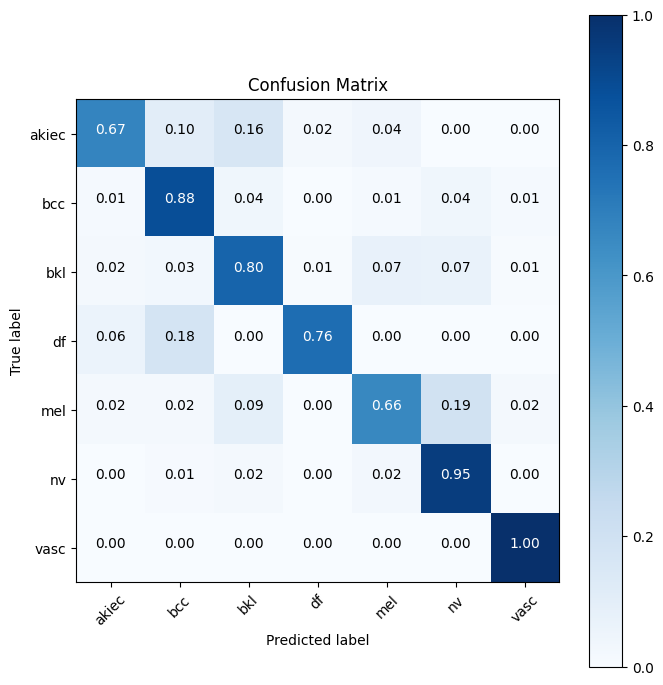

In [217]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(ground_truths, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [219]:
################################
### Prefer model2 vs model 3 ###
################################

first_model_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
second_model_mapping = {'mel': 0, 'nv': 1}  #nv
third_model_mapping = {'akiec': 0, 'bcc': 1}  #bcc
class_mapping_2 = get_class_mapping(first_model_mapping, second_model_mapping)
class_mapping_3 = get_class_mapping(first_model_mapping, third_model_mapping)


def predict(instance, model_1, model_2, model_3, class_mapping_2, class_mapping_3):
    prediction_1 = model_1.predict(instance, verbose=0)
    class_pred_1 = np.argmax(prediction_1)
    percent_1 = prediction_1[0, class_pred_1]

    # Store models and mappings in list for easier iteration
    models = [model_2, model_3]
    mappings = [class_mapping_2, class_mapping_3]
    # Indices to match the conditions in the original function
    indices = [(4, 5), (0, 1)]
    # indices = [(5,), (1,)]

    for index, model, mapping in zip(indices, models, mappings):
        if class_pred_1 in index:
            prediction = model.predict(instance, verbose=0)
            class_pred = np.argmax(prediction)
            class_pred_mapped = mapping.get(class_pred, class_pred)
            percent = prediction[0, class_pred]

            print(
                f'model 1: {class_pred_1} ({percent_1 * 100:.2f}%) VS. model {models.index(model) + 2}: {class_pred_mapped} ({percent * 100:.2f}%)')

            # Always return the prediction of model 2 or 3 when it is used
            return class_pred_mapped

    return class_pred_1


predictions = []
ground_truths = []

with tqdm(total=total) as pbar:
    for i in range(len(test_image_gen)):
        X, y_true = test_image_gen[i]
        actual_batch_size = X.shape[0]  # calculate the actual batch size

        for j in range(actual_batch_size):  # iterate over the batch
            try:
                instance = X[j]
                filename = test_image_gen.filenames[i * actual_batch_size + j]
                ground_truth = y_true[j]  # get the ground truth label
                ground_truth = np.argmax(ground_truth)  # from one-hot to class index
                ground_truths.append(ground_truth)
                prediction = predict(np.expand_dims(instance, axis=0), model, second_model, third_model,
                                     class_mapping_2, class_mapping_3)
                print(f"Image: {filename}, Prediction: {prediction}, Ground Truth: {ground_truth}")
                predictions.append(prediction)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")
            pbar.update()  # update progress bar

  0%|          | 2/1536 [00:01<16:58,  1.51it/s]

model 1: 0 (99.42%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024329.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (100.00%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024372.jpg, Prediction: 0, Ground Truth: 0


  0%|          | 4/1536 [00:01<07:35,  3.36it/s]

model 1: 0 (89.43%) VS. model 3: 0 (89.19%)
Image: akiec/ISIC_0024418.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.99%) VS. model 3: 0 (99.99%)
Image: akiec/ISIC_0024450.jpg, Prediction: 0, Ground Truth: 0


  0%|          | 6/1536 [00:02<05:03,  5.05it/s]

model 1: 0 (42.77%) VS. model 3: 0 (98.62%)
Image: akiec/ISIC_0024463.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.97%) VS. model 3: 0 (99.51%)
Image: akiec/ISIC_0024468.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 8/1536 [00:02<03:57,  6.42it/s]

model 1: 0 (98.97%) VS. model 3: 0 (99.99%)
Image: akiec/ISIC_0024470.jpg, Prediction: 0, Ground Truth: 0
model 1: 5 (38.30%) VS. model 2: 4 (54.28%)
Image: akiec/ISIC_0024511.jpg, Prediction: 4, Ground Truth: 0


  1%|          | 9/1536 [00:02<03:42,  6.86it/s]

model 1: 0 (99.89%) VS. model 3: 0 (73.91%)
Image: akiec/ISIC_0024517.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 10/1536 [00:03<08:31,  2.98it/s]

model 1: 0 (98.77%) VS. model 3: 0 (97.90%)
Image: akiec/ISIC_0024522.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024539.jpg, Prediction: 2, Ground Truth: 0


  1%|          | 13/1536 [00:03<05:27,  4.65it/s]

model 1: 1 (61.44%) VS. model 3: 1 (99.98%)
Image: akiec/ISIC_0024562.jpg, Prediction: 1, Ground Truth: 0
model 1: 0 (98.19%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024575.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 15/1536 [00:03<04:49,  5.26it/s]

model 1: 0 (99.99%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024579.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (97.03%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024646.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 17/1536 [00:04<03:58,  6.37it/s]

Image: akiec/ISIC_0024654.jpg, Prediction: 2, Ground Truth: 0
model 1: 0 (90.28%) VS. model 3: 0 (99.87%)
Image: akiec/ISIC_0024707.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 19/1536 [00:04<04:00,  6.30it/s]

model 1: 0 (97.62%) VS. model 3: 0 (59.54%)
Image: akiec/ISIC_0024710.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.34%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024763.jpg, Prediction: 0, Ground Truth: 0


  1%|▏         | 20/1536 [00:04<04:05,  6.19it/s]

model 1: 0 (99.92%) VS. model 3: 0 (99.97%)
Image: akiec/ISIC_0024771.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024800.jpg, Prediction: 2, Ground Truth: 0


  1%|▏         | 23/1536 [00:05<03:43,  6.78it/s]

model 1: 0 (96.24%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0024843.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (96.10%) VS. model 3: 1 (99.99%)
Image: akiec/ISIC_0024913.jpg, Prediction: 1, Ground Truth: 0


  2%|▏         | 25/1536 [00:05<03:56,  6.38it/s]

model 1: 0 (99.20%) VS. model 3: 0 (99.18%)
Image: akiec/ISIC_0024923.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (92.03%) VS. model 3: 1 (94.17%)
Image: akiec/ISIC_0024925.jpg, Prediction: 1, Ground Truth: 0


  2%|▏         | 27/1536 [00:05<04:04,  6.17it/s]

model 1: 0 (95.32%) VS. model 3: 0 (59.09%)
Image: akiec/ISIC_0024946.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.96%) VS. model 3: 0 (99.47%)
Image: akiec/ISIC_0024948.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 29/1536 [00:06<04:09,  6.04it/s]

model 1: 0 (95.95%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025029.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (84.59%) VS. model 3: 0 (99.02%)
Image: akiec/ISIC_0025069.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 31/1536 [00:06<04:01,  6.23it/s]

model 1: 0 (100.00%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025089.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (99.87%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025130.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 33/1536 [00:06<03:33,  7.04it/s]

Image: akiec/ISIC_0025178.jpg, Prediction: 3, Ground Truth: 0
model 1: 0 (98.49%) VS. model 3: 0 (99.56%)
Image: akiec/ISIC_0025182.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 35/1536 [00:06<03:47,  6.61it/s]

model 1: 0 (99.44%) VS. model 3: 0 (91.80%)
Image: akiec/ISIC_0025196.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (100.00%) VS. model 3: 0 (91.74%)
Image: akiec/ISIC_0025247.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 37/1536 [00:07<03:24,  7.32it/s]

Image: akiec/ISIC_0025264.jpg, Prediction: 2, Ground Truth: 0
model 1: 0 (94.13%) VS. model 3: 0 (83.96%)
Image: akiec/ISIC_0025319.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 39/1536 [00:07<03:39,  6.81it/s]

model 1: 0 (99.73%) VS. model 3: 0 (99.97%)
Image: akiec/ISIC_0025331.jpg, Prediction: 0, Ground Truth: 0
model 1: 4 (51.72%) VS. model 2: 4 (93.36%)
Image: akiec/ISIC_0025350.jpg, Prediction: 4, Ground Truth: 0


  3%|▎         | 41/1536 [00:07<03:45,  6.63it/s]

model 1: 0 (100.00%) VS. model 3: 0 (100.00%)
Image: akiec/ISIC_0025358.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (98.52%) VS. model 3: 0 (99.51%)
Image: akiec/ISIC_0025368.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 43/1536 [00:08<03:47,  6.56it/s]

model 1: 0 (85.44%) VS. model 3: 0 (99.98%)
Image: akiec/ISIC_0025411.jpg, Prediction: 0, Ground Truth: 0
model 1: 0 (76.73%) VS. model 3: 1 (81.19%)
Image: akiec/ISIC_0025427.jpg, Prediction: 1, Ground Truth: 0


  3%|▎         | 44/1536 [00:08<03:51,  6.45it/s]

model 1: 1 (67.46%) VS. model 3: 1 (86.86%)
Image: akiec/ISIC_0025471.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0025539.jpg, Prediction: 2, Ground Truth: 0


  3%|▎         | 47/1536 [00:08<03:40,  6.75it/s]

model 1: 0 (99.78%) VS. model 3: 0 (99.68%)
Image: akiec/ISIC_0025577.jpg, Prediction: 0, Ground Truth: 0
model 1: 4 (76.55%) VS. model 2: 4 (67.58%)
Image: akiec/ISIC_0025605.jpg, Prediction: 4, Ground Truth: 0


  3%|▎         | 49/1536 [00:08<03:25,  7.25it/s]

Image: akiec/ISIC_0025637.jpg, Prediction: 2, Ground Truth: 0
model 1: 0 (100.00%) VS. model 3: 0 (99.79%)
Image: akiec/ISIC_0025696.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 51/1536 [00:09<03:37,  6.83it/s]

model 1: 1 (99.90%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024331.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (86.31%) VS. model 3: 1 (98.39%)
Image: bcc/ISIC_0024332.jpg, Prediction: 1, Ground Truth: 1


  3%|▎         | 53/1536 [00:09<03:52,  6.39it/s]

model 1: 1 (94.35%) VS. model 3: 1 (95.92%)
Image: bcc/ISIC_0024345.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0024360.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 55/1536 [00:09<03:52,  6.38it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.62%)
Image: bcc/ISIC_0024403.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (94.82%) VS. model 3: 1 (99.41%)
Image: bcc/ISIC_0024411.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 57/1536 [00:10<04:01,  6.14it/s]

model 1: 4 (83.36%) VS. model 2: 5 (99.46%)
Image: bcc/ISIC_0024431.jpg, Prediction: 5, Ground Truth: 1
model 1: 5 (69.17%) VS. model 2: 5 (99.95%)
Image: bcc/ISIC_0024432.jpg, Prediction: 5, Ground Truth: 1


  4%|▍         | 59/1536 [00:10<03:55,  6.27it/s]

model 1: 1 (99.75%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024436.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.85%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024443.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 61/1536 [00:10<03:57,  6.21it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024448.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.91%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024452.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 63/1536 [00:11<03:59,  6.14it/s]

model 1: 1 (99.93%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0024454.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.89%) VS. model 3: 1 (99.82%)
Image: bcc/ISIC_0024457.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 64/1536 [00:11<03:53,  6.29it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024461.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 66/1536 [00:12<10:35,  2.31it/s]

model 1: 1 (99.94%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024472.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.83%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024504.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 68/1536 [00:13<07:02,  3.47it/s]

Image: bcc/ISIC_0024515.jpg, Prediction: 3, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (99.83%)
Image: bcc/ISIC_0024550.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 70/1536 [00:13<05:34,  4.39it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024564.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.79%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024572.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 72/1536 [00:13<04:45,  5.12it/s]

model 1: 1 (99.85%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0024573.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.84%)
Image: bcc/ISIC_0024582.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 74/1536 [00:14<04:13,  5.76it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024590.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024595.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 76/1536 [00:14<03:57,  6.15it/s]

model 1: 1 (99.98%) VS. model 3: 1 (99.92%)
Image: bcc/ISIC_0024632.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024634.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 78/1536 [00:14<03:40,  6.62it/s]

model 1: 1 (98.04%) VS. model 3: 1 (91.53%)
Image: bcc/ISIC_0024665.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.36%) VS. model 3: 1 (96.83%)
Image: bcc/ISIC_0024666.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 80/1536 [00:14<03:27,  7.01it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024673.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (98.70%)
Image: bcc/ISIC_0024743.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 82/1536 [00:15<03:25,  7.07it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024787.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.30%) VS. model 3: 1 (99.89%)
Image: bcc/ISIC_0024795.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 84/1536 [00:15<03:19,  7.27it/s]

model 1: 1 (99.93%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024799.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024829.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 86/1536 [00:15<03:19,  7.29it/s]

model 1: 1 (99.55%) VS. model 3: 1 (99.01%)
Image: bcc/ISIC_0024833.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024848.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 88/1536 [00:16<03:10,  7.61it/s]

model 1: 1 (99.84%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024885.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.50%)
Image: bcc/ISIC_0024897.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 90/1536 [00:16<03:13,  7.48it/s]

model 1: 1 (99.59%) VS. model 3: 1 (99.29%)
Image: bcc/ISIC_0024931.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.92%) VS. model 3: 1 (99.89%)
Image: bcc/ISIC_0024949.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 92/1536 [00:16<03:09,  7.61it/s]

model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024984.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.92%) VS. model 3: 1 (77.04%)
Image: bcc/ISIC_0025019.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 94/1536 [00:16<03:09,  7.60it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025031.jpg, Prediction: 1, Ground Truth: 1
model 1: 5 (81.51%) VS. model 2: 5 (99.78%)
Image: bcc/ISIC_0025046.jpg, Prediction: 5, Ground Truth: 1


  6%|▋         | 96/1536 [00:17<03:03,  7.83it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025102.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025144.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 98/1536 [00:17<03:04,  7.81it/s]

model 1: 1 (99.75%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0025260.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (97.93%) VS. model 3: 1 (99.87%)
Image: bcc/ISIC_0025266.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 100/1536 [00:17<03:00,  7.95it/s]

model 1: 1 (99.69%) VS. model 3: 1 (95.17%)
Image: bcc/ISIC_0025285.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025299.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 102/1536 [00:17<02:59,  7.99it/s]

model 1: 1 (99.64%) VS. model 3: 1 (99.76%)
Image: bcc/ISIC_0025301.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.49%) VS. model 3: 1 (98.99%)
Image: bcc/ISIC_0025322.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 104/1536 [00:18<02:59,  7.99it/s]

model 1: 1 (99.95%) VS. model 3: 1 (99.90%)
Image: bcc/ISIC_0025362.jpg, Prediction: 1, Ground Truth: 1
model 1: 5 (75.71%) VS. model 2: 5 (98.65%)
Image: bcc/ISIC_0025383.jpg, Prediction: 5, Ground Truth: 1


  7%|▋         | 106/1536 [00:18<02:56,  8.10it/s]

model 1: 1 (99.99%) VS. model 3: 1 (87.74%)
Image: bcc/ISIC_0025417.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.93%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0025433.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 108/1536 [00:18<03:01,  7.85it/s]

model 1: 1 (99.98%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025467.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025509.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 110/1536 [00:18<02:59,  7.95it/s]

model 1: 5 (95.48%) VS. model 2: 5 (99.95%)
Image: bcc/ISIC_0025513.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (99.89%) VS. model 3: 1 (98.27%)
Image: bcc/ISIC_0025530.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025557.jpg, Prediction: 2, Ground Truth: 1


  7%|▋         | 113/1536 [00:19<02:43,  8.72it/s]

model 1: 1 (53.05%) VS. model 3: 0 (59.65%)
Image: bcc/ISIC_0025564.jpg, Prediction: 0, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025576.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 115/1536 [00:19<02:49,  8.38it/s]

model 1: 1 (89.79%) VS. model 3: 1 (99.80%)
Image: bcc/ISIC_0025584.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.84%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025600.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 117/1536 [00:19<02:56,  8.04it/s]

model 1: 1 (96.73%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025601.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (86.74%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025617.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025630.jpg, Prediction: 6, Ground Truth: 1


  8%|▊         | 120/1536 [00:19<02:38,  8.94it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025644.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.84%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025650.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 122/1536 [00:20<02:48,  8.39it/s]

model 1: 5 (54.74%) VS. model 2: 5 (100.00%)
Image: bcc/ISIC_0025691.jpg, Prediction: 5, Ground Truth: 1
model 1: 0 (39.05%) VS. model 3: 1 (88.63%)
Image: bcc/ISIC_0025700.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 124/1536 [00:20<02:49,  8.31it/s]

model 1: 1 (99.07%) VS. model 3: 1 (99.83%)
Image: bcc/ISIC_0025711.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025718.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 126/1536 [00:20<02:53,  8.11it/s]

model 1: 1 (99.73%) VS. model 3: 1 (99.17%)
Image: bcc/ISIC_0025731.jpg, Prediction: 1, Ground Truth: 1
model 1: 4 (97.91%) VS. model 2: 4 (99.35%)
Image: bcc/ISIC_0025752.jpg, Prediction: 4, Ground Truth: 1
Image: bkl/ISIC_0024312.jpg, Prediction: 2, Ground Truth: 2


  8%|▊         | 128/1536 [00:20<02:15, 10.43it/s]

Image: bkl/ISIC_0024324.jpg, Prediction: 2, Ground Truth: 2


  8%|▊         | 130/1536 [00:22<08:27,  2.77it/s]

Image: bkl/ISIC_0024336.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024338.jpg, Prediction: 2, Ground Truth: 2


  9%|▊         | 134/1536 [00:22<04:31,  5.17it/s]

Image: bkl/ISIC_0024358.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024371.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024381.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 138/1536 [00:23<03:03,  7.61it/s]

model 1: 4 (58.01%) VS. model 2: 4 (99.78%)
Image: bkl/ISIC_0024382.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024383.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024408.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024409.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 140/1536 [00:23<02:50,  8.17it/s]

model 1: 1 (78.26%) VS. model 3: 1 (99.73%)
Image: bkl/ISIC_0024412.jpg, Prediction: 1, Ground Truth: 2
Image: bkl/ISIC_0024420.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024422.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 144/1536 [00:23<02:12, 10.47it/s]

Image: bkl/ISIC_0024426.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024435.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024445.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 148/1536 [00:23<01:49, 12.65it/s]

Image: bkl/ISIC_0024446.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024453.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024471.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024477.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 150/1536 [00:23<01:44, 13.28it/s]

Image: bkl/ISIC_0024489.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024490.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024494.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 154/1536 [00:24<01:42, 13.45it/s]

model 1: 5 (88.55%) VS. model 2: 5 (77.95%)
Image: bkl/ISIC_0024495.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024498.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024505.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024547.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 158/1536 [00:24<01:35, 14.40it/s]

Image: bkl/ISIC_0024581.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024592.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024602.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024612.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 162/1536 [00:24<01:41, 13.47it/s]

Image: bkl/ISIC_0024623.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024626.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (92.60%) VS. model 2: 4 (99.99%)
Image: bkl/ISIC_0024635.jpg, Prediction: 4, Ground Truth: 2


 11%|█         | 164/1536 [00:24<01:37, 14.13it/s]

Image: bkl/ISIC_0024643.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024672.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024676.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 168/1536 [00:25<01:55, 11.89it/s]

model 1: 4 (94.14%) VS. model 2: 4 (99.33%)
Image: bkl/ISIC_0024696.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024705.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (65.92%) VS. model 2: 5 (94.19%)
Image: bkl/ISIC_0024708.jpg, Prediction: 5, Ground Truth: 2


 11%|█         | 172/1536 [00:25<01:40, 13.58it/s]

Image: bkl/ISIC_0024709.jpg, Prediction: 3, Ground Truth: 2
Image: bkl/ISIC_0024711.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024726.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024740.jpg, Prediction: 2, Ground Truth: 2


 11%|█▏        | 174/1536 [00:25<02:04, 10.95it/s]

model 1: 4 (77.03%) VS. model 2: 4 (99.90%)
Image: bkl/ISIC_0024741.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (60.99%) VS. model 2: 5 (99.96%)
Image: bkl/ISIC_0024748.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024758.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 178/1536 [00:26<01:43, 13.13it/s]

Image: bkl/ISIC_0024760.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024761.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024770.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024772.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 182/1536 [00:26<01:36, 14.05it/s]

Image: bkl/ISIC_0024773.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024774.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024782.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024786.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 186/1536 [00:26<01:44, 12.98it/s]

Image: bkl/ISIC_0024814.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024825.jpg, Prediction: 2, Ground Truth: 2
model 1: 1 (57.90%) VS. model 3: 1 (99.95%)
Image: bkl/ISIC_0024832.jpg, Prediction: 1, Ground Truth: 2


 12%|█▏        | 188/1536 [00:26<01:51, 12.10it/s]

model 1: 5 (48.68%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0024839.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024850.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (47.75%) VS. model 2: 4 (96.82%)
Image: bkl/ISIC_0024851.jpg, Prediction: 4, Ground Truth: 2


 12%|█▎        | 192/1536 [00:27<01:45, 12.74it/s]

Image: bkl/ISIC_0024871.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024877.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024880.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 194/1536 [00:28<06:23,  3.50it/s]

Image: bkl/ISIC_0024881.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (98.77%) VS. model 2: 5 (99.98%)
Image: bkl/ISIC_0024883.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024890.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 198/1536 [00:28<03:47,  5.87it/s]

Image: bkl/ISIC_0024893.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024909.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024910.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024915.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 202/1536 [00:29<02:34,  8.63it/s]

Image: bkl/ISIC_0024943.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024947.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024970.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024971.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 206/1536 [00:29<02:05, 10.60it/s]

model 1: 5 (77.03%) VS. model 2: 5 (96.46%)
Image: bkl/ISIC_0024981.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024982.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024997.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025005.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 210/1536 [00:29<01:44, 12.64it/s]

Image: bkl/ISIC_0025016.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025030.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025032.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 212/1536 [00:29<01:50, 12.02it/s]

model 1: 1 (73.52%) VS. model 3: 1 (98.07%)
Image: bkl/ISIC_0025033.jpg, Prediction: 1, Ground Truth: 2
Image: bkl/ISIC_0025038.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (97.40%) VS. model 2: 5 (99.97%)
Image: bkl/ISIC_0025040.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 214/1536 [00:30<02:04, 10.60it/s]

model 1: 4 (79.94%) VS. model 2: 4 (99.96%)
Image: bkl/ISIC_0025063.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (87.83%) VS. model 2: 5 (92.13%)
Image: bkl/ISIC_0025064.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 218/1536 [00:30<02:11, 10.05it/s]

model 1: 0 (93.99%) VS. model 3: 0 (99.92%)
Image: bkl/ISIC_0025066.jpg, Prediction: 0, Ground Truth: 2
model 1: 4 (98.85%) VS. model 2: 4 (100.00%)
Image: bkl/ISIC_0025068.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025075.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 222/1536 [00:30<01:54, 11.53it/s]

model 1: 5 (91.26%) VS. model 2: 4 (53.34%)
Image: bkl/ISIC_0025076.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025083.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025086.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025099.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 226/1536 [00:31<01:35, 13.68it/s]

Image: bkl/ISIC_0025103.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025113.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025131.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025136.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 230/1536 [00:31<01:28, 14.68it/s]

Image: bkl/ISIC_0025140.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025157.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025180.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025199.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 232/1536 [00:31<01:49, 11.90it/s]

model 1: 0 (97.45%) VS. model 3: 1 (96.71%)
Image: bkl/ISIC_0025209.jpg, Prediction: 1, Ground Truth: 2
model 1: 4 (56.87%) VS. model 2: 4 (100.00%)
Image: bkl/ISIC_0025222.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025275.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 236/1536 [00:31<01:46, 12.21it/s]

Image: bkl/ISIC_0025276.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (74.85%) VS. model 2: 5 (92.49%)
Image: bkl/ISIC_0025286.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025292.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 238/1536 [00:32<01:39, 13.08it/s]

Image: bkl/ISIC_0025297.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025312.jpg, Prediction: 2, Ground Truth: 2
model 1: 1 (84.31%) VS. model 3: 1 (88.47%)
Image: bkl/ISIC_0025326.jpg, Prediction: 1, Ground Truth: 2


 16%|█▌        | 242/1536 [00:32<01:36, 13.40it/s]

Image: bkl/ISIC_0025330.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025339.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025345.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 246/1536 [00:32<01:48, 11.91it/s]

model 1: 4 (95.85%) VS. model 2: 4 (99.89%)
Image: bkl/ISIC_0025351.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (97.25%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0025366.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025374.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 250/1536 [00:32<01:33, 13.70it/s]

Image: bkl/ISIC_0025376.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025378.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025387.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025388.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 254/1536 [00:33<01:26, 14.81it/s]

Image: bkl/ISIC_0025389.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025392.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025419.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025431.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 256/1536 [00:33<01:24, 15.10it/s]

Image: bkl/ISIC_0025434.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025454.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 258/1536 [00:34<05:58,  3.56it/s]

Image: bkl/ISIC_0025465.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025466.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025470.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 262/1536 [00:35<03:41,  5.75it/s]

Image: bkl/ISIC_0025484.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025485.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025507.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025510.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 266/1536 [00:35<02:29,  8.52it/s]

Image: bkl/ISIC_0025515.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025519.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025526.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025529.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 270/1536 [00:35<02:09,  9.74it/s]

Image: bkl/ISIC_0025548.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (58.74%) VS. model 2: 4 (98.99%)
Image: bkl/ISIC_0025554.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025567.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 272/1536 [00:35<01:56, 10.85it/s]

Image: bkl/ISIC_0025575.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025583.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025623.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 276/1536 [00:36<01:52, 11.17it/s]

Image: bkl/ISIC_0025627.jpg, Prediction: 2, Ground Truth: 2
model 1: 4 (91.64%) VS. model 2: 5 (52.89%)
Image: bkl/ISIC_0025642.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025654.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 280/1536 [00:36<01:35, 13.15it/s]

Image: bkl/ISIC_0025656.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025659.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025661.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025693.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 282/1536 [00:36<01:55, 10.89it/s]

model 1: 4 (72.98%) VS. model 2: 4 (57.78%)
Image: bkl/ISIC_0025699.jpg, Prediction: 4, Ground Truth: 2
model 1: 4 (99.12%) VS. model 2: 4 (99.74%)
Image: bkl/ISIC_0025703.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025710.jpg, Prediction: 2, Ground Truth: 2


 19%|█▊        | 286/1536 [00:37<01:42, 12.16it/s]

model 1: 4 (92.93%) VS. model 2: 4 (100.00%)
Image: bkl/ISIC_0025716.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025719.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025743.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025746.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 290/1536 [00:37<01:31, 13.66it/s]

Image: bkl/ISIC_0025753.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025767.jpg, Prediction: 2, Ground Truth: 2
Image: df/ISIC_0024318.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 294/1536 [00:37<01:25, 14.51it/s]

Image: df/ISIC_0024330.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024386.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024396.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024553.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 298/1536 [00:37<01:32, 13.41it/s]

Image: df/ISIC_0024845.jpg, Prediction: 3, Ground Truth: 3
model 1: 4 (80.43%) VS. model 2: 4 (97.56%)
Image: df/ISIC_0024973.jpg, Prediction: 4, Ground Truth: 3
Image: df/ISIC_0024994.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 302/1536 [00:38<01:31, 13.47it/s]

model 1: 0 (92.82%) VS. model 3: 0 (66.86%)
Image: df/ISIC_0025154.jpg, Prediction: 0, Ground Truth: 3
Image: df/ISIC_0025223.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025302.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025314.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 304/1536 [00:38<01:39, 12.38it/s]

Image: df/ISIC_0025373.jpg, Prediction: 3, Ground Truth: 3
model 1: 0 (93.50%) VS. model 3: 0 (94.56%)
Image: df/ISIC_0025504.jpg, Prediction: 0, Ground Truth: 3
Image: df/ISIC_0025594.jpg, Prediction: 3, Ground Truth: 3


 20%|██        | 308/1536 [00:38<01:40, 12.28it/s]

Image: df/ISIC_0025622.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025668.jpg, Prediction: 3, Ground Truth: 3
model 1: 4 (99.95%) VS. model 2: 4 (99.96%)
Image: mel/ISIC_0024310.jpg, Prediction: 4, Ground Truth: 4


 20%|██        | 310/1536 [00:38<01:54, 10.74it/s]

model 1: 5 (93.21%) VS. model 2: 4 (89.95%)
Image: mel/ISIC_0024313.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (95.63%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024315.jpg, Prediction: 4, Ground Truth: 4


 20%|██        | 312/1536 [00:39<01:57, 10.43it/s]

model 1: 4 (89.22%) VS. model 2: 4 (95.10%)
Image: mel/ISIC_0024323.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024333.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (75.36%) VS. model 2: 4 (90.76%)
Image: mel/ISIC_0024351.jpg, Prediction: 4, Ground Truth: 4


 20%|██        | 314/1536 [00:39<02:08,  9.49it/s]

model 1: 4 (98.99%) VS. model 2: 4 (97.77%)
Image: mel/ISIC_0024367.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024400.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 317/1536 [00:39<02:11,  9.25it/s]

model 1: 5 (57.73%) VS. model 2: 5 (96.91%)
Image: mel/ISIC_0024410.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (99.92%) VS. model 2: 4 (99.42%)
Image: mel/ISIC_0024449.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024459.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 319/1536 [00:39<01:53, 10.76it/s]

Image: mel/ISIC_0024481.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (96.90%) VS. model 2: 4 (94.91%)
Image: mel/ISIC_0024482.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 322/1536 [00:41<05:50,  3.47it/s]

model 1: 4 (91.02%) VS. model 2: 4 (89.60%)
Image: mel/ISIC_0024496.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (71.34%) VS. model 2: 5 (75.23%)
Image: mel/ISIC_0024516.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024525.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 325/1536 [00:41<04:01,  5.01it/s]

model 1: 4 (99.92%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0024537.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.99%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0024545.jpg, Prediction: 4, Ground Truth: 4


 21%|██▏       | 327/1536 [00:42<03:27,  5.83it/s]

model 1: 4 (78.91%) VS. model 2: 4 (99.15%)
Image: mel/ISIC_0024546.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (92.45%) VS. model 2: 4 (76.73%)
Image: mel/ISIC_0024552.jpg, Prediction: 4, Ground Truth: 4


 21%|██▏       | 329/1536 [00:42<03:00,  6.67it/s]

model 1: 4 (64.15%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0024554.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.61%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0024571.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 332/1536 [00:42<02:27,  8.15it/s]

model 1: 5 (91.79%) VS. model 2: 5 (98.67%)
Image: mel/ISIC_0024586.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024624.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (99.44%) VS. model 2: 4 (98.61%)
Image: mel/ISIC_0024630.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 334/1536 [00:43<02:25,  8.24it/s]

model 1: 4 (90.70%) VS. model 2: 4 (99.93%)
Image: mel/ISIC_0024640.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (86.97%) VS. model 2: 4 (99.38%)
Image: mel/ISIC_0024644.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 336/1536 [00:43<02:29,  8.04it/s]

model 1: 4 (69.46%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0024647.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (86.38%) VS. model 2: 4 (99.95%)
Image: mel/ISIC_0024652.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 338/1536 [00:43<02:29,  8.00it/s]

model 1: 4 (76.96%) VS. model 2: 5 (98.57%)
Image: mel/ISIC_0024675.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (94.45%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0024679.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 340/1536 [00:43<02:29,  8.01it/s]

model 1: 4 (93.76%) VS. model 2: 4 (98.79%)
Image: mel/ISIC_0024688.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (54.73%) VS. model 2: 4 (95.93%)
Image: mel/ISIC_0024700.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 342/1536 [00:44<02:25,  8.19it/s]

model 1: 4 (89.00%) VS. model 2: 4 (95.70%)
Image: mel/ISIC_0024701.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.99%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024702.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 344/1536 [00:44<02:24,  8.23it/s]

model 1: 4 (98.34%) VS. model 2: 4 (98.40%)
Image: mel/ISIC_0024729.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (65.46%) VS. model 2: 4 (98.33%)
Image: mel/ISIC_0024732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024733.jpg, Prediction: 2, Ground Truth: 4


 23%|██▎       | 347/1536 [00:44<02:15,  8.77it/s]

model 1: 4 (98.81%) VS. model 2: 4 (98.37%)
Image: mel/ISIC_0024739.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (74.91%) VS. model 2: 5 (95.91%)
Image: mel/ISIC_0024756.jpg, Prediction: 5, Ground Truth: 4


 23%|██▎       | 349/1536 [00:44<02:16,  8.67it/s]

model 1: 4 (47.31%) VS. model 2: 4 (99.30%)
Image: mel/ISIC_0024767.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (90.93%) VS. model 2: 4 (98.98%)
Image: mel/ISIC_0024792.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 351/1536 [00:45<02:24,  8.23it/s]

model 1: 4 (95.74%) VS. model 2: 4 (99.81%)
Image: mel/ISIC_0024805.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (97.55%) VS. model 2: 4 (92.46%)
Image: mel/ISIC_0024806.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 353/1536 [00:45<02:24,  8.20it/s]

model 1: 4 (95.17%) VS. model 2: 4 (99.96%)
Image: mel/ISIC_0024823.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (91.57%) VS. model 2: 4 (98.01%)
Image: mel/ISIC_0024853.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 355/1536 [00:45<02:26,  8.04it/s]

model 1: 4 (52.09%) VS. model 2: 5 (99.41%)
Image: mel/ISIC_0024864.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (99.36%) VS. model 2: 4 (95.17%)
Image: mel/ISIC_0024865.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 358/1536 [00:45<02:07,  9.26it/s]

model 1: 4 (95.12%) VS. model 2: 4 (98.85%)
Image: mel/ISIC_0024875.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024886.jpg, Prediction: 2, Ground Truth: 4
model 1: 5 (94.10%) VS. model 2: 5 (99.33%)
Image: mel/ISIC_0024898.jpg, Prediction: 5, Ground Truth: 4


 23%|██▎       | 360/1536 [00:46<02:03,  9.54it/s]

Image: mel/ISIC_0024900.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (59.51%) VS. model 2: 5 (99.49%)
Image: mel/ISIC_0024911.jpg, Prediction: 5, Ground Truth: 4


 24%|██▎       | 362/1536 [00:46<02:18,  8.48it/s]

model 1: 5 (92.77%) VS. model 2: 5 (97.54%)
Image: mel/ISIC_0024918.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (97.16%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0024929.jpg, Prediction: 4, Ground Truth: 4


 24%|██▎       | 364/1536 [00:46<02:30,  7.77it/s]

model 1: 5 (73.69%) VS. model 2: 5 (67.94%)
Image: mel/ISIC_0024930.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (88.14%) VS. model 2: 4 (97.36%)
Image: mel/ISIC_0024932.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 366/1536 [00:46<02:30,  7.79it/s]

model 1: 4 (64.89%) VS. model 2: 4 (99.70%)
Image: mel/ISIC_0024940.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (85.48%) VS. model 2: 4 (91.24%)
Image: mel/ISIC_0024951.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 367/1536 [00:46<02:29,  7.83it/s]

model 1: 4 (96.55%) VS. model 2: 4 (99.46%)
Image: mel/ISIC_0024952.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024958.jpg, Prediction: 2, Ground Truth: 4


 24%|██▍       | 370/1536 [00:47<02:19,  8.33it/s]

model 1: 4 (66.23%) VS. model 2: 5 (70.73%)
Image: mel/ISIC_0024961.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (98.19%) VS. model 2: 4 (99.88%)
Image: mel/ISIC_0024962.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 372/1536 [00:47<02:26,  7.93it/s]

model 1: 4 (99.96%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0024967.jpg, Prediction: 4, Ground Truth: 4
model 1: 0 (70.05%) VS. model 3: 0 (52.13%)
Image: mel/ISIC_0024972.jpg, Prediction: 0, Ground Truth: 4


 24%|██▍       | 374/1536 [00:47<02:36,  7.44it/s]

model 1: 5 (67.87%) VS. model 2: 5 (84.11%)
Image: mel/ISIC_0024987.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (60.37%) VS. model 2: 4 (81.10%)
Image: mel/ISIC_0024999.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 376/1536 [00:48<02:39,  7.29it/s]

model 1: 5 (88.26%) VS. model 2: 5 (99.60%)
Image: mel/ISIC_0025018.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (92.18%) VS. model 2: 4 (98.62%)
Image: mel/ISIC_0025035.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 378/1536 [00:48<02:41,  7.17it/s]

model 1: 4 (91.24%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025081.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (82.78%) VS. model 2: 4 (97.25%)
Image: mel/ISIC_0025085.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 380/1536 [00:48<02:36,  7.39it/s]

model 1: 4 (89.17%) VS. model 2: 4 (99.96%)
Image: mel/ISIC_0025097.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (72.75%) VS. model 2: 4 (97.16%)
Image: mel/ISIC_0025105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025121.jpg, Prediction: 6, Ground Truth: 4


 25%|██▌       | 384/1536 [00:49<02:02,  9.40it/s]

model 1: 4 (89.41%) VS. model 2: 4 (95.99%)
Image: mel/ISIC_0025127.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025128.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (87.74%) VS. model 2: 4 (99.29%)
Image: mel/ISIC_0025132.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 386/1536 [00:50<06:30,  2.95it/s]

model 1: 4 (84.38%) VS. model 2: 4 (99.58%)
Image: mel/ISIC_0025145.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (94.76%) VS. model 2: 5 (88.42%)
Image: mel/ISIC_0025153.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025155.jpg, Prediction: 2, Ground Truth: 4


 25%|██▌       | 390/1536 [00:51<03:33,  5.37it/s]

model 1: 4 (74.93%) VS. model 2: 4 (77.72%)
Image: mel/ISIC_0025188.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025195.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (98.78%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0025219.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 392/1536 [00:51<03:05,  6.17it/s]

model 1: 4 (99.89%) VS. model 2: 4 (98.03%)
Image: mel/ISIC_0025234.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (82.81%) VS. model 2: 4 (98.96%)
Image: mel/ISIC_0025235.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 395/1536 [00:51<02:27,  7.75it/s]

model 1: 4 (73.27%) VS. model 2: 4 (99.49%)
Image: mel/ISIC_0025238.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025248.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (62.18%) VS. model 2: 4 (75.67%)
Image: mel/ISIC_0025265.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 398/1536 [00:51<02:07,  8.91it/s]

model 1: 4 (98.25%) VS. model 2: 4 (99.91%)
Image: mel/ISIC_0025268.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025277.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (77.30%) VS. model 2: 4 (99.89%)
Image: mel/ISIC_0025303.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 400/1536 [00:52<02:14,  8.42it/s]

model 1: 5 (98.90%) VS. model 2: 5 (99.57%)
Image: mel/ISIC_0025313.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (63.75%) VS. model 2: 5 (96.73%)
Image: mel/ISIC_0025316.jpg, Prediction: 5, Ground Truth: 4


 26%|██▌       | 402/1536 [00:52<02:17,  8.26it/s]

model 1: 4 (70.33%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0025317.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (82.13%) VS. model 2: 5 (99.45%)
Image: mel/ISIC_0025324.jpg, Prediction: 5, Ground Truth: 4


 26%|██▋       | 404/1536 [00:52<02:21,  8.02it/s]

model 1: 4 (90.07%) VS. model 2: 4 (99.92%)
Image: mel/ISIC_0025363.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (95.00%) VS. model 2: 4 (97.56%)
Image: mel/ISIC_0025391.jpg, Prediction: 4, Ground Truth: 4


 26%|██▋       | 406/1536 [00:52<02:21,  7.98it/s]

model 1: 5 (92.87%) VS. model 2: 5 (99.95%)
Image: mel/ISIC_0025394.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (69.62%) VS. model 2: 4 (92.74%)
Image: mel/ISIC_0025409.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 408/1536 [00:53<02:24,  7.78it/s]

model 1: 4 (98.82%) VS. model 2: 4 (99.44%)
Image: mel/ISIC_0025413.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (65.19%) VS. model 2: 4 (88.82%)
Image: mel/ISIC_0025414.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 410/1536 [00:53<02:27,  7.64it/s]

model 1: 4 (96.25%) VS. model 2: 4 (97.88%)
Image: mel/ISIC_0025439.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.49%) VS. model 2: 5 (99.99%)
Image: mel/ISIC_0025450.jpg, Prediction: 5, Ground Truth: 4


 27%|██▋       | 412/1536 [00:53<02:25,  7.71it/s]

model 1: 5 (98.04%) VS. model 2: 5 (88.55%)
Image: mel/ISIC_0025451.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (76.64%) VS. model 2: 4 (98.67%)
Image: mel/ISIC_0025472.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 415/1536 [00:54<02:02,  9.12it/s]

model 1: 4 (78.61%) VS. model 2: 4 (93.61%)
Image: mel/ISIC_0025489.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025500.jpg, Prediction: 2, Ground Truth: 4
model 1: 4 (96.29%) VS. model 2: 4 (99.85%)
Image: mel/ISIC_0025512.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 418/1536 [00:54<01:58,  9.44it/s]

model 1: 4 (99.86%) VS. model 2: 4 (72.42%)
Image: mel/ISIC_0025520.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025524.jpg, Prediction: 6, Ground Truth: 4
model 1: 0 (59.67%) VS. model 3: 0 (99.82%)
Image: mel/ISIC_0025531.jpg, Prediction: 0, Ground Truth: 4


 27%|██▋       | 420/1536 [00:54<01:40, 11.08it/s]

Image: mel/ISIC_0025543.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025546.jpg, Prediction: 2, Ground Truth: 4
model 1: 5 (78.98%) VS. model 2: 4 (62.93%)
Image: mel/ISIC_0025550.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 422/1536 [00:54<01:52,  9.91it/s]

model 1: 5 (89.24%) VS. model 2: 4 (71.15%)
Image: mel/ISIC_0025573.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.97%) VS. model 2: 4 (99.96%)
Image: mel/ISIC_0025589.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 425/1536 [00:55<02:04,  8.95it/s]

model 1: 4 (88.58%) VS. model 2: 4 (83.88%)
Image: mel/ISIC_0025592.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (80.36%) VS. model 2: 4 (90.20%)
Image: mel/ISIC_0025603.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 428/1536 [00:55<02:00,  9.23it/s]

model 1: 4 (54.34%) VS. model 2: 4 (66.99%)
Image: mel/ISIC_0025611.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025616.jpg, Prediction: 2, Ground Truth: 4
model 1: 0 (75.47%) VS. model 3: 0 (99.57%)
Image: mel/ISIC_0025651.jpg, Prediction: 0, Ground Truth: 4


 28%|██▊       | 430/1536 [00:55<02:06,  8.78it/s]

model 1: 4 (61.66%) VS. model 2: 4 (99.96%)
Image: mel/ISIC_0025663.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (58.74%) VS. model 2: 4 (98.07%)
Image: mel/ISIC_0025674.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 432/1536 [00:55<02:11,  8.42it/s]

model 1: 5 (90.90%) VS. model 2: 5 (94.91%)
Image: mel/ISIC_0025708.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (60.38%) VS. model 2: 4 (99.99%)
Image: mel/ISIC_0025709.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 434/1536 [00:56<02:12,  8.34it/s]

model 1: 5 (97.60%) VS. model 2: 5 (95.19%)
Image: mel/ISIC_0025724.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (99.74%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0025732.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 436/1536 [00:56<02:14,  8.21it/s]

model 1: 4 (90.81%) VS. model 2: 4 (63.48%)
Image: mel/ISIC_0025744.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (72.31%) VS. model 2: 4 (99.66%)
Image: mel/ISIC_0025748.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 438/1536 [00:56<02:17,  8.01it/s]

model 1: 4 (76.07%) VS. model 2: 4 (57.27%)
Image: mel/ISIC_0025751.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (69.37%) VS. model 2: 4 (84.19%)
Image: mel/ISIC_0025755.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 440/1536 [00:56<02:13,  8.19it/s]

model 1: 4 (85.89%) VS. model 2: 4 (98.38%)
Image: mel/ISIC_0025766.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.89%) VS. model 2: 5 (99.95%)
Image: mel/ISIC_0025783.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 442/1536 [00:57<02:15,  8.10it/s]

model 1: 5 (96.23%) VS. model 2: 5 (92.87%)
Image: mel/ISIC_0025791.jpg, Prediction: 5, Ground Truth: 4
model 1: 0 (99.59%) VS. model 3: 0 (100.00%)
Image: mel/ISIC_0025800.jpg, Prediction: 0, Ground Truth: 4


 29%|██▉       | 444/1536 [00:57<02:15,  8.04it/s]

model 1: 4 (76.04%) VS. model 2: 4 (99.01%)
Image: mel/ISIC_0025814.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (61.67%) VS. model 2: 4 (97.57%)
Image: mel/ISIC_0025832.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 446/1536 [00:57<02:19,  7.82it/s]

model 1: 4 (91.86%) VS. model 2: 4 (91.93%)
Image: mel/ISIC_0025835.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (71.12%) VS. model 2: 5 (97.22%)
Image: mel/ISIC_0025891.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 448/1536 [00:57<02:14,  8.09it/s]

model 1: 4 (98.41%) VS. model 2: 4 (99.67%)
Image: mel/ISIC_0025904.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (56.03%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0025927.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 450/1536 [00:59<07:40,  2.36it/s]

model 1: 4 (87.57%) VS. model 2: 4 (75.92%)
Image: mel/ISIC_0025941.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (93.33%) VS. model 2: 4 (99.85%)
Image: mel/ISIC_0025955.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 452/1536 [00:59<04:59,  3.62it/s]

Image: mel/ISIC_0025963.jpg, Prediction: 6, Ground Truth: 4
model 1: 4 (97.92%) VS. model 2: 4 (99.96%)
Image: mel/ISIC_0025964.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 454/1536 [01:00<03:47,  4.75it/s]

model 1: 4 (84.17%) VS. model 2: 5 (98.72%)
Image: mel/ISIC_0025987.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (97.45%) VS. model 2: 4 (99.98%)
Image: mel/ISIC_0025996.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 456/1536 [01:00<02:45,  6.54it/s]

Image: mel/ISIC_0026009.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0026045.jpg, Prediction: 2, Ground Truth: 4


 30%|██▉       | 458/1536 [01:00<02:37,  6.83it/s]

model 1: 4 (90.16%) VS. model 2: 4 (99.87%)
Image: mel/ISIC_0026081.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.14%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0026086.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 460/1536 [01:00<02:35,  6.90it/s]

model 1: 5 (97.62%) VS. model 2: 5 (99.38%)
Image: mel/ISIC_0026089.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (84.50%) VS. model 2: 4 (74.80%)
Image: mel/ISIC_0026094.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 462/1536 [01:01<02:30,  7.14it/s]

model 1: 4 (75.48%) VS. model 2: 4 (99.20%)
Image: mel/ISIC_0026105.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (99.48%) VS. model 2: 4 (99.78%)
Image: mel/ISIC_0026113.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 464/1536 [01:01<02:23,  7.45it/s]

model 1: 4 (91.24%) VS. model 2: 5 (66.37%)
Image: mel/ISIC_0026115.jpg, Prediction: 5, Ground Truth: 4
model 1: 4 (99.94%) VS. model 2: 4 (100.00%)
Image: mel/ISIC_0026120.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 466/1536 [01:01<02:20,  7.62it/s]

model 1: 4 (89.27%) VS. model 2: 4 (98.87%)
Image: mel/ISIC_0026131.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (97.18%) VS. model 2: 4 (99.85%)
Image: mel/ISIC_0026150.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 468/1536 [01:01<02:18,  7.73it/s]

model 1: 1 (99.48%) VS. model 3: 1 (99.98%)
Image: mel/ISIC_0026158.jpg, Prediction: 1, Ground Truth: 4
model 1: 4 (86.31%) VS. model 2: 4 (99.02%)
Image: mel/ISIC_0026167.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 470/1536 [01:02<02:15,  7.86it/s]

model 1: 4 (91.88%) VS. model 2: 4 (99.94%)
Image: mel/ISIC_0026188.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (51.87%) VS. model 2: 5 (56.05%)
Image: mel/ISIC_0026207.jpg, Prediction: 5, Ground Truth: 4


 31%|███       | 472/1536 [01:02<02:13,  7.96it/s]

model 1: 4 (99.08%) VS. model 2: 4 (99.00%)
Image: mel/ISIC_0026229.jpg, Prediction: 4, Ground Truth: 4
model 1: 4 (82.58%) VS. model 2: 4 (71.97%)
Image: mel/ISIC_0026236.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 474/1536 [01:02<02:20,  7.57it/s]

model 1: 5 (50.69%) VS. model 2: 4 (51.92%)
Image: mel/ISIC_0026239.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024306.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 476/1536 [01:02<02:12,  8.00it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024307.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.74%)
Image: nv/ISIC_0024308.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 478/1536 [01:03<02:10,  8.12it/s]

model 1: 5 (99.28%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024309.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024311.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 480/1536 [01:03<02:07,  8.25it/s]

model 1: 5 (91.48%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0024314.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024316.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 482/1536 [01:03<02:12,  7.96it/s]

model 1: 5 (97.09%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024317.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024319.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 484/1536 [01:03<02:09,  8.15it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024321.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 486/1536 [01:04<02:08,  8.15it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024322.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024325.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 488/1536 [01:04<02:09,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024326.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024327.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 490/1536 [01:04<02:09,  8.05it/s]

model 1: 5 (81.11%) VS. model 2: 5 (98.63%)
Image: nv/ISIC_0024328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024334.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 492/1536 [01:04<02:14,  7.78it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024335.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024339.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 494/1536 [01:05<02:09,  8.07it/s]

model 1: 5 (98.04%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024340.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024341.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 496/1536 [01:05<02:11,  7.92it/s]

model 1: 5 (85.02%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.44%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024343.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 498/1536 [01:05<02:12,  7.85it/s]

model 1: 4 (96.22%) VS. model 2: 4 (96.83%)
Image: nv/ISIC_0024344.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024346.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 500/1536 [01:05<02:13,  7.73it/s]

model 1: 5 (98.66%) VS. model 2: 5 (98.92%)
Image: nv/ISIC_0024347.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024348.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 502/1536 [01:06<02:11,  7.87it/s]

model 1: 5 (95.87%) VS. model 2: 5 (88.11%)
Image: nv/ISIC_0024349.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024350.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 504/1536 [01:06<02:08,  8.04it/s]

model 1: 5 (81.54%) VS. model 2: 5 (99.77%)
Image: nv/ISIC_0024352.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024353.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 506/1536 [01:06<02:12,  7.78it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024354.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024355.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 508/1536 [01:06<02:08,  7.99it/s]

model 1: 5 (99.23%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0024356.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (71.91%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024357.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 510/1536 [01:07<02:07,  8.03it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024359.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.44%) VS. model 2: 5 (89.94%)
Image: nv/ISIC_0024361.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 512/1536 [01:07<02:06,  8.12it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024362.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.18%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024363.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 514/1536 [01:08<07:08,  2.39it/s]

model 1: 5 (98.51%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024365.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 516/1536 [01:09<04:31,  3.75it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024366.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024368.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 518/1536 [01:09<03:22,  5.02it/s]

model 1: 5 (90.78%) VS. model 2: 5 (95.69%)
Image: nv/ISIC_0024369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024373.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 520/1536 [01:09<02:45,  6.15it/s]

model 1: 5 (87.43%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024374.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024376.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 522/1536 [01:09<02:23,  7.05it/s]

model 1: 5 (90.66%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0024377.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024378.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 524/1536 [01:10<02:14,  7.54it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.57%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024380.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 526/1536 [01:10<02:08,  7.84it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024385.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 528/1536 [01:10<02:07,  7.89it/s]

model 1: 5 (91.64%) VS. model 2: 5 (98.74%)
Image: nv/ISIC_0024387.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024388.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 530/1536 [01:10<02:04,  8.06it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024389.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024390.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 532/1536 [01:11<02:09,  7.77it/s]

model 1: 5 (97.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024391.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024392.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 534/1536 [01:11<02:10,  7.66it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024393.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.78%) VS. model 2: 5 (92.95%)
Image: nv/ISIC_0024394.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 536/1536 [01:11<02:12,  7.52it/s]

model 1: 5 (99.82%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024395.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024397.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 538/1536 [01:12<02:10,  7.62it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024398.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024399.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 540/1536 [01:12<02:09,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024401.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024404.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 542/1536 [01:12<02:15,  7.32it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024405.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024406.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 544/1536 [01:12<02:13,  7.46it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024407.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024413.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 546/1536 [01:13<02:12,  7.45it/s]

model 1: 5 (99.96%) VS. model 2: 5 (98.01%)
Image: nv/ISIC_0024414.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024415.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 548/1536 [01:13<02:08,  7.68it/s]

model 1: 5 (61.59%) VS. model 2: 5 (99.07%)
Image: nv/ISIC_0024416.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024417.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 550/1536 [01:13<02:17,  7.17it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024419.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024421.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 552/1536 [01:13<02:09,  7.59it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024423.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (98.91%) VS. model 3: 0 (93.92%)
Image: nv/ISIC_0024424.jpg, Prediction: 0, Ground Truth: 5


 36%|███▌      | 554/1536 [01:14<02:07,  7.72it/s]

model 1: 5 (92.71%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024425.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.32%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024427.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 556/1536 [01:14<02:02,  8.00it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024428.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (97.87%)
Image: nv/ISIC_0024429.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 558/1536 [01:14<02:06,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024430.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024433.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 561/1536 [01:14<01:46,  9.16it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024434.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024437.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024438.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 563/1536 [01:15<01:55,  8.46it/s]

model 1: 5 (95.90%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024439.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024440.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 565/1536 [01:15<01:56,  8.33it/s]

model 1: 5 (94.76%) VS. model 2: 5 (98.66%)
Image: nv/ISIC_0024441.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024442.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 567/1536 [01:15<01:59,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024444.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.70%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024447.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 569/1536 [01:15<01:58,  8.16it/s]

model 1: 5 (98.25%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024451.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024455.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 571/1536 [01:16<01:57,  8.21it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024456.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.23%) VS. model 2: 5 (96.76%)
Image: nv/ISIC_0024458.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 573/1536 [01:16<02:00,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024460.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.87%) VS. model 2: 5 (98.26%)
Image: nv/ISIC_0024462.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 575/1536 [01:16<02:01,  7.93it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024464.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024465.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 576/1536 [01:16<02:03,  7.75it/s]

model 1: 0 (65.25%) VS. model 3: 0 (99.81%)
Image: nv/ISIC_0024466.jpg, Prediction: 0, Ground Truth: 5


 38%|███▊      | 578/1536 [01:18<06:37,  2.41it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024467.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024469.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 580/1536 [01:18<04:15,  3.74it/s]

model 1: 5 (60.12%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024474.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 582/1536 [01:18<03:06,  5.13it/s]

model 1: 5 (74.69%) VS. model 2: 5 (55.65%)
Image: nv/ISIC_0024476.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.09%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024478.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 584/1536 [01:19<02:27,  6.44it/s]

model 1: 5 (94.99%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0024479.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (68.18%) VS. model 2: 4 (50.60%)
Image: nv/ISIC_0024480.jpg, Prediction: 4, Ground Truth: 5


 38%|███▊      | 586/1536 [01:19<02:14,  7.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024484.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 588/1536 [01:19<02:05,  7.56it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024485.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024486.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 590/1536 [01:19<02:02,  7.70it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024488.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 592/1536 [01:20<01:59,  7.90it/s]

model 1: 5 (99.39%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024491.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024492.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 594/1536 [01:20<02:01,  7.76it/s]

model 1: 5 (98.55%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0024493.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.47%) VS. model 2: 5 (98.62%)
Image: nv/ISIC_0024497.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 596/1536 [01:20<01:59,  7.85it/s]

model 1: 5 (99.85%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024499.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024500.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 598/1536 [01:20<01:59,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024502.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 600/1536 [01:21<01:57,  7.98it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024506.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 602/1536 [01:21<01:56,  8.02it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024507.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024508.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 604/1536 [01:21<01:59,  7.77it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024509.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024510.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 606/1536 [01:21<01:55,  8.04it/s]

model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024512.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024513.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 608/1536 [01:22<01:57,  7.89it/s]

model 1: 4 (86.20%) VS. model 2: 4 (96.83%)
Image: nv/ISIC_0024514.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (94.89%) VS. model 2: 5 (70.36%)
Image: nv/ISIC_0024518.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 610/1536 [01:22<01:55,  8.01it/s]

model 1: 4 (47.30%) VS. model 2: 5 (98.42%)
Image: nv/ISIC_0024519.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.33%) VS. model 2: 5 (99.26%)
Image: nv/ISIC_0024520.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 612/1536 [01:22<01:57,  7.88it/s]

model 1: 5 (99.56%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024521.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.42%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024523.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 614/1536 [01:22<01:54,  8.09it/s]

model 1: 5 (59.80%) VS. model 2: 5 (98.75%)
Image: nv/ISIC_0024524.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024526.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 616/1536 [01:23<01:55,  7.95it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024527.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024528.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 618/1536 [01:23<01:55,  7.95it/s]

model 1: 5 (97.60%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024529.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024530.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 620/1536 [01:23<01:57,  7.77it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024531.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024532.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 622/1536 [01:24<02:03,  7.41it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024533.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.56%) VS. model 2: 5 (99.03%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 624/1536 [01:24<02:05,  7.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.63%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 626/1536 [01:24<02:05,  7.26it/s]

model 1: 5 (92.08%) VS. model 2: 5 (96.76%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.00%) VS. model 2: 5 (92.55%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 628/1536 [01:24<02:02,  7.39it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024541.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024542.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 630/1536 [01:25<02:02,  7.39it/s]

model 1: 5 (98.66%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024543.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.47%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024544.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 632/1536 [01:25<02:04,  7.24it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024548.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024549.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 634/1536 [01:25<02:05,  7.18it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024551.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024555.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 636/1536 [01:25<02:01,  7.39it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024556.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024557.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 638/1536 [01:26<02:05,  7.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024558.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024559.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 640/1536 [01:26<02:01,  7.40it/s]

model 1: 5 (91.08%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0024560.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.48%) VS. model 2: 5 (93.55%)
Image: nv/ISIC_0024561.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 642/1536 [01:28<06:09,  2.42it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024565.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 644/1536 [01:28<03:59,  3.73it/s]

model 1: 1 (90.59%) VS. model 3: 1 (98.93%)
Image: nv/ISIC_0024566.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024567.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 646/1536 [01:28<02:52,  5.17it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024568.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024569.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 648/1536 [01:28<02:21,  6.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024570.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024574.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 650/1536 [01:29<02:04,  7.13it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024576.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.32%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024577.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 652/1536 [01:29<01:57,  7.55it/s]

model 1: 5 (97.34%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024578.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024580.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 654/1536 [01:29<01:53,  7.79it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024583.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024584.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 656/1536 [01:29<01:52,  7.84it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.41%) VS. model 2: 5 (95.86%)
Image: nv/ISIC_0024587.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 658/1536 [01:30<01:50,  7.95it/s]

model 1: 5 (97.84%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024588.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024589.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 660/1536 [01:30<01:51,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024591.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.14%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024593.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 662/1536 [01:30<01:53,  7.72it/s]

model 1: 5 (89.87%) VS. model 2: 5 (96.79%)
Image: nv/ISIC_0024594.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.46%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024596.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 664/1536 [01:30<01:51,  7.79it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024597.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.60%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024598.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 666/1536 [01:31<01:53,  7.69it/s]

model 1: 5 (98.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024599.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024600.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 668/1536 [01:31<01:48,  7.97it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024601.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024603.jpg, Prediction: 5, Ground Truth: 5


 44%|████▎     | 670/1536 [01:31<01:51,  7.80it/s]

model 1: 5 (64.49%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024605.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 672/1536 [01:31<01:49,  7.87it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024606.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024607.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 674/1536 [01:32<01:48,  7.94it/s]

model 1: 4 (86.97%) VS. model 2: 4 (53.87%)
Image: nv/ISIC_0024608.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024609.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 676/1536 [01:32<01:46,  8.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024610.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024611.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 678/1536 [01:32<01:48,  7.90it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024613.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024614.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 680/1536 [01:32<01:47,  8.00it/s]

model 1: 5 (48.35%) VS. model 2: 5 (50.86%)
Image: nv/ISIC_0024615.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024616.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 682/1536 [01:33<01:43,  8.21it/s]

model 1: 5 (93.77%) VS. model 2: 5 (94.87%)
Image: nv/ISIC_0024617.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (56.59%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024618.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 684/1536 [01:33<01:45,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024619.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (92.62%)
Image: nv/ISIC_0024620.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 686/1536 [01:33<01:44,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024621.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024622.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 688/1536 [01:33<01:44,  8.11it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024625.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024627.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 690/1536 [01:34<01:42,  8.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024628.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024629.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 692/1536 [01:34<01:43,  8.12it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024631.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024633.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 694/1536 [01:34<01:45,  8.00it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024636.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.56%) VS. model 2: 5 (99.49%)
Image: nv/ISIC_0024637.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 696/1536 [01:34<01:46,  7.91it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024639.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 698/1536 [01:35<01:44,  8.01it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024641.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024642.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 700/1536 [01:35<01:46,  7.83it/s]

model 1: 5 (99.76%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024645.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024648.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 702/1536 [01:35<01:45,  7.89it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024649.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024650.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 704/1536 [01:35<01:44,  7.97it/s]

model 1: 5 (92.03%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024651.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.12%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024653.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 706/1536 [01:37<05:54,  2.34it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024656.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 708/1536 [01:37<03:51,  3.58it/s]

model 1: 5 (60.03%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024658.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 710/1536 [01:38<02:51,  4.82it/s]

model 1: 5 (95.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024659.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024660.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 712/1536 [01:38<02:25,  5.66it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024661.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024663.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 714/1536 [01:38<02:01,  6.79it/s]

Image: nv/ISIC_0024664.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024667.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 716/1536 [01:38<01:54,  7.15it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024668.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024670.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 718/1536 [01:39<01:47,  7.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024671.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.64%) VS. model 2: 5 (72.28%)
Image: nv/ISIC_0024674.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 720/1536 [01:39<01:45,  7.72it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024677.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024678.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 722/1536 [01:39<01:42,  7.93it/s]

model 1: 4 (69.85%) VS. model 2: 5 (98.69%)
Image: nv/ISIC_0024680.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024681.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 724/1536 [01:39<01:42,  7.91it/s]

model 1: 5 (92.82%) VS. model 2: 4 (96.57%)
Image: nv/ISIC_0024682.jpg, Prediction: 4, Ground Truth: 5
model 1: 4 (84.36%) VS. model 2: 5 (82.11%)
Image: nv/ISIC_0024683.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024684.jpg, Prediction: 2, Ground Truth: 5


 47%|████▋     | 727/1536 [01:40<01:31,  8.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024686.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 729/1536 [01:40<01:36,  8.36it/s]

model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024687.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024689.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 731/1536 [01:40<01:36,  8.30it/s]

model 1: 5 (43.09%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024690.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.89%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0024691.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 733/1536 [01:40<01:38,  8.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024692.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024693.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 735/1536 [01:41<01:37,  8.19it/s]

model 1: 5 (99.90%) VS. model 2: 5 (95.74%)
Image: nv/ISIC_0024694.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.58%) VS. model 2: 5 (98.87%)
Image: nv/ISIC_0024695.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 737/1536 [01:41<01:39,  8.01it/s]

model 1: 4 (84.00%) VS. model 2: 4 (75.92%)
Image: nv/ISIC_0024697.jpg, Prediction: 4, Ground Truth: 5
model 1: 4 (64.69%) VS. model 2: 4 (58.26%)
Image: nv/ISIC_0024698.jpg, Prediction: 4, Ground Truth: 5


 48%|████▊     | 739/1536 [01:41<01:38,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024699.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024703.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 741/1536 [01:41<01:40,  7.93it/s]

model 1: 5 (97.95%) VS. model 2: 5 (99.41%)
Image: nv/ISIC_0024704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.17%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024712.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 743/1536 [01:42<01:38,  8.06it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024713.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.27%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024714.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 745/1536 [01:42<01:40,  7.88it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024715.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.79%) VS. model 2: 5 (83.48%)
Image: nv/ISIC_0024716.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 747/1536 [01:42<01:41,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024718.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 749/1536 [01:42<01:37,  8.05it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024719.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.11%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0024720.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 751/1536 [01:43<01:39,  7.88it/s]

model 1: 5 (99.16%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024722.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 753/1536 [01:43<01:37,  8.02it/s]

model 1: 4 (97.25%) VS. model 2: 4 (92.44%)
Image: nv/ISIC_0024723.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024724.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 755/1536 [01:43<01:39,  7.87it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024725.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024727.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 757/1536 [01:44<01:37,  8.01it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024728.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.08%) VS. model 2: 5 (94.27%)
Image: nv/ISIC_0024730.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 759/1536 [01:44<01:38,  7.89it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024731.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024734.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 761/1536 [01:44<01:37,  7.98it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024735.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024736.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 763/1536 [01:44<01:37,  7.90it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024737.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024738.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 765/1536 [01:45<01:36,  8.03it/s]

model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024742.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024744.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 767/1536 [01:45<01:35,  8.08it/s]

model 1: 5 (54.87%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024745.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024746.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 768/1536 [01:45<01:37,  7.85it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024749.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 770/1536 [01:46<05:11,  2.46it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.81%) VS. model 2: 5 (98.69%)
Image: nv/ISIC_0024751.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 772/1536 [01:47<03:22,  3.78it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024752.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024753.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 774/1536 [01:47<02:26,  5.21it/s]

model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024754.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024755.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 776/1536 [01:47<01:58,  6.42it/s]

model 1: 4 (74.18%) VS. model 2: 5 (99.13%)
Image: nv/ISIC_0024757.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024759.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 778/1536 [01:47<01:45,  7.17it/s]

model 1: 5 (91.94%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024762.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024764.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 780/1536 [01:48<01:38,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024766.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 782/1536 [01:48<01:38,  7.69it/s]

model 1: 5 (88.04%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024768.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.59%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024769.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 784/1536 [01:48<01:34,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024775.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024776.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 786/1536 [01:48<01:37,  7.67it/s]

model 1: 5 (95.49%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0024777.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024778.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 788/1536 [01:49<01:39,  7.55it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.03%)
Image: nv/ISIC_0024779.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024780.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 790/1536 [01:49<01:39,  7.52it/s]

model 1: 5 (84.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024781.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024783.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 792/1536 [01:49<01:37,  7.61it/s]

model 1: 5 (98.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024784.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024785.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 794/1536 [01:50<01:40,  7.37it/s]

model 1: 5 (98.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024788.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.34%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024789.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 797/1536 [01:50<01:26,  8.51it/s]

model 1: 5 (90.27%) VS. model 2: 5 (98.61%)
Image: nv/ISIC_0024790.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024791.jpg, Prediction: 6, Ground Truth: 5
model 1: 5 (92.69%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024793.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 799/1536 [01:50<01:34,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024794.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024796.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 801/1536 [01:50<01:36,  7.64it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024797.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (98.03%)
Image: nv/ISIC_0024798.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 803/1536 [01:51<01:40,  7.32it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024801.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024802.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 805/1536 [01:51<01:41,  7.24it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024803.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024804.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 807/1536 [01:51<01:35,  7.61it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024807.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024808.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 809/1536 [01:52<01:35,  7.59it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024809.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.21%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0024810.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 811/1536 [01:52<01:32,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024811.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024812.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 813/1536 [01:52<01:34,  7.67it/s]

model 1: 5 (95.03%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024813.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.52%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024815.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 815/1536 [01:52<01:31,  7.86it/s]

model 1: 5 (99.40%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024816.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024817.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 816/1536 [01:52<01:31,  7.89it/s]

model 1: 5 (78.24%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0024818.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 818/1536 [01:53<03:12,  3.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024819.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024820.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 820/1536 [01:54<02:27,  4.86it/s]

model 1: 5 (87.19%) VS. model 2: 5 (97.54%)
Image: nv/ISIC_0024821.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024822.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 822/1536 [01:54<02:11,  5.42it/s]

model 1: 5 (98.67%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0024824.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024826.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 824/1536 [01:54<01:47,  6.62it/s]

Image: nv/ISIC_0024827.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024828.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 826/1536 [01:54<01:45,  6.73it/s]

model 1: 5 (90.56%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024830.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.68%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024831.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 828/1536 [01:55<01:47,  6.56it/s]

model 1: 5 (99.84%) VS. model 2: 5 (99.71%)
Image: nv/ISIC_0024834.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024835.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 830/1536 [01:55<01:46,  6.62it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024836.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024837.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 832/1536 [01:55<01:46,  6.60it/s]

model 1: 5 (85.64%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024838.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024840.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 834/1536 [01:57<05:03,  2.32it/s]

model 1: 4 (92.36%) VS. model 2: 4 (81.55%)
Image: nv/ISIC_0024841.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (94.69%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024842.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 836/1536 [01:57<03:23,  3.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024844.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.29%) VS. model 2: 5 (94.09%)
Image: nv/ISIC_0024846.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 838/1536 [01:58<02:30,  4.64it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024847.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024849.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 840/1536 [01:58<02:07,  5.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024852.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.23%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0024854.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 842/1536 [01:58<01:53,  6.11it/s]

model 1: 5 (87.40%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024855.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024856.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 844/1536 [01:59<01:49,  6.32it/s]

model 1: 5 (99.10%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024857.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024858.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 846/1536 [01:59<01:46,  6.50it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024859.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024860.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 848/1536 [01:59<01:46,  6.48it/s]

model 1: 5 (98.03%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024861.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (78.78%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0024862.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 850/1536 [01:59<01:45,  6.52it/s]

model 1: 5 (97.79%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0024863.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024866.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 852/1536 [02:00<01:42,  6.70it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024868.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (77.16%) VS. model 2: 4 (78.60%)
Image: nv/ISIC_0024869.jpg, Prediction: 4, Ground Truth: 5


 56%|█████▌    | 854/1536 [02:00<01:43,  6.59it/s]

model 1: 5 (95.00%) VS. model 2: 5 (98.80%)
Image: nv/ISIC_0024870.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (65.80%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024872.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 856/1536 [02:00<01:40,  6.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024873.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.56%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024874.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 858/1536 [02:01<01:41,  6.66it/s]

model 1: 5 (93.06%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024876.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024878.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 860/1536 [02:01<01:42,  6.61it/s]

model 1: 5 (93.15%) VS. model 2: 5 (95.27%)
Image: nv/ISIC_0024879.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (52.81%) VS. model 2: 5 (91.84%)
Image: nv/ISIC_0024882.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 862/1536 [02:01<01:44,  6.47it/s]

model 1: 5 (99.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024884.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024887.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 864/1536 [02:02<01:43,  6.52it/s]

model 1: 5 (96.40%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0024888.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024889.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 866/1536 [02:02<01:47,  6.21it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024891.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024892.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 868/1536 [02:02<01:46,  6.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024894.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024895.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 870/1536 [02:03<01:48,  6.16it/s]

model 1: 5 (96.36%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024896.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.05%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024899.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 872/1536 [02:03<01:52,  5.90it/s]

model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024901.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (99.31%)
Image: nv/ISIC_0024902.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 874/1536 [02:03<01:48,  6.08it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024903.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (67.71%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024905.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 876/1536 [02:04<01:48,  6.09it/s]

model 1: 5 (99.15%) VS. model 2: 5 (99.26%)
Image: nv/ISIC_0024906.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024907.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 878/1536 [02:04<01:43,  6.34it/s]

model 1: 5 (76.62%) VS. model 2: 4 (54.18%)
Image: nv/ISIC_0024908.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024912.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 880/1536 [02:04<01:44,  6.31it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024914.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024916.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 882/1536 [02:04<01:40,  6.48it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024917.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.93%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024919.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 884/1536 [02:05<01:39,  6.57it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024920.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024921.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 886/1536 [02:05<01:39,  6.51it/s]

model 1: 5 (84.90%) VS. model 2: 5 (99.54%)
Image: nv/ISIC_0024922.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (92.56%) VS. model 2: 4 (61.12%)
Image: nv/ISIC_0024924.jpg, Prediction: 4, Ground Truth: 5


 58%|█████▊    | 888/1536 [02:05<01:33,  6.94it/s]

model 1: 1 (72.92%) VS. model 3: 1 (100.00%)
Image: nv/ISIC_0024926.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024927.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 890/1536 [02:06<01:34,  6.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024928.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.04%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024933.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 891/1536 [02:06<01:32,  7.01it/s]

model 1: 5 (97.68%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024934.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024935.jpg, Prediction: 2, Ground Truth: 5


 58%|█████▊    | 894/1536 [02:06<01:25,  7.53it/s]

model 1: 5 (99.65%) VS. model 2: 5 (77.59%)
Image: nv/ISIC_0024936.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (80.19%) VS. model 2: 5 (85.06%)
Image: nv/ISIC_0024937.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 896/1536 [02:06<01:23,  7.62it/s]

model 1: 5 (99.67%) VS. model 2: 5 (98.41%)
Image: nv/ISIC_0024938.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024939.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 898/1536 [02:08<04:15,  2.50it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024941.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024942.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 900/1536 [02:08<02:47,  3.79it/s]

model 1: 5 (97.04%) VS. model 2: 5 (96.62%)
Image: nv/ISIC_0024944.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.66%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0024945.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 902/1536 [02:09<02:02,  5.17it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024950.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024953.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 904/1536 [02:09<01:41,  6.21it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024954.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (73.85%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0024955.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 906/1536 [02:09<01:30,  6.93it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024956.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024957.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 908/1536 [02:09<01:25,  7.32it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024959.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024960.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024963.jpg, Prediction: 2, Ground Truth: 5


 59%|█████▉    | 911/1536 [02:10<01:13,  8.53it/s]

model 1: 5 (99.93%) VS. model 2: 5 (98.67%)
Image: nv/ISIC_0024964.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024965.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 913/1536 [02:10<01:16,  8.16it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024966.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024968.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 915/1536 [02:10<01:16,  8.13it/s]

model 1: 5 (98.62%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024969.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024974.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 917/1536 [02:10<01:16,  8.10it/s]

model 1: 4 (91.73%) VS. model 2: 4 (72.58%)
Image: nv/ISIC_0024975.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024976.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 919/1536 [02:11<01:15,  8.21it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024977.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024978.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 921/1536 [02:11<01:16,  8.02it/s]

model 1: 5 (99.86%) VS. model 2: 5 (97.94%)
Image: nv/ISIC_0024979.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024980.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 923/1536 [02:11<01:16,  8.06it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024983.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024985.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 925/1536 [02:11<01:15,  8.12it/s]

model 1: 5 (63.73%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024986.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024988.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 927/1536 [02:12<01:14,  8.23it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024989.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024990.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 929/1536 [02:12<01:12,  8.36it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024991.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024992.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 931/1536 [02:12<01:15,  8.06it/s]

model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024993.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.10%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0024995.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 933/1536 [02:12<01:13,  8.20it/s]

model 1: 5 (85.86%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024996.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.52%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0024998.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 935/1536 [02:13<01:14,  8.06it/s]

model 1: 4 (50.03%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025000.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (99.47%)
Image: nv/ISIC_0025001.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 937/1536 [02:13<01:13,  8.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025002.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025003.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 939/1536 [02:13<01:15,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025004.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025006.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 942/1536 [02:13<01:03,  9.31it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025007.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025008.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025009.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 944/1536 [02:14<01:12,  8.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025010.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025011.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 946/1536 [02:14<01:19,  7.39it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025012.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (96.75%)
Image: nv/ISIC_0025013.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 948/1536 [02:14<01:18,  7.46it/s]

model 1: 0 (67.67%) VS. model 3: 0 (99.98%)
Image: nv/ISIC_0025014.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025015.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 950/1536 [02:14<01:16,  7.67it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025017.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025020.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 952/1536 [02:15<01:20,  7.29it/s]

model 1: 5 (95.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025021.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025022.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 954/1536 [02:15<01:20,  7.23it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025023.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025024.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 956/1536 [02:15<01:19,  7.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025025.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.53%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025026.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 958/1536 [02:16<01:18,  7.37it/s]

model 1: 1 (97.69%) VS. model 3: 1 (99.96%)
Image: nv/ISIC_0025027.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025028.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▎   | 960/1536 [02:16<01:17,  7.42it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025034.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025036.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 962/1536 [02:18<04:06,  2.33it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025037.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0025039.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 964/1536 [02:18<02:40,  3.57it/s]

model 1: 5 (98.45%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025041.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025042.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 966/1536 [02:18<01:57,  4.84it/s]

model 1: 5 (83.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025043.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025044.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 968/1536 [02:18<01:35,  5.97it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025045.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.35%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0025047.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 970/1536 [02:19<01:25,  6.64it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025048.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.02%) VS. model 2: 5 (98.24%)
Image: nv/ISIC_0025049.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 972/1536 [02:19<01:19,  7.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025050.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.46%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025051.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 974/1536 [02:19<01:17,  7.24it/s]

model 1: 5 (99.29%) VS. model 2: 5 (99.28%)
Image: nv/ISIC_0025052.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025053.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 976/1536 [02:19<01:19,  7.01it/s]

model 1: 5 (97.53%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025054.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025055.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 978/1536 [02:20<01:16,  7.29it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025056.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025057.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 980/1536 [02:20<01:18,  7.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025058.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025059.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 982/1536 [02:20<01:13,  7.50it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025060.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025061.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 984/1536 [02:21<01:13,  7.53it/s]

model 1: 5 (68.39%) VS. model 2: 5 (97.92%)
Image: nv/ISIC_0025062.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025065.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 986/1536 [02:21<01:11,  7.72it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025067.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025070.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 988/1536 [02:21<01:11,  7.66it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025071.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025072.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 990/1536 [02:21<01:10,  7.76it/s]

model 1: 5 (89.09%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025073.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.10%) VS. model 2: 5 (96.61%)
Image: nv/ISIC_0025074.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 992/1536 [02:22<01:07,  8.00it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025077.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.52%)
Image: nv/ISIC_0025078.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 994/1536 [02:22<01:09,  7.78it/s]

model 1: 5 (99.56%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025079.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025080.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 996/1536 [02:22<01:07,  7.97it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025082.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025084.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 998/1536 [02:22<01:08,  7.83it/s]

model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025087.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.23%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025088.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1000/1536 [02:23<01:06,  8.03it/s]

model 1: 5 (93.79%) VS. model 2: 5 (99.41%)
Image: nv/ISIC_0025090.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025091.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1002/1536 [02:23<01:07,  7.92it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025092.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025093.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1004/1536 [02:23<01:06,  8.03it/s]

model 1: 5 (75.99%) VS. model 2: 5 (98.15%)
Image: nv/ISIC_0025094.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.80%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025095.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1006/1536 [02:23<01:08,  7.79it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025096.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025098.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1008/1536 [02:24<01:07,  7.83it/s]

model 1: 5 (95.26%) VS. model 2: 5 (99.37%)
Image: nv/ISIC_0025100.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025101.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1010/1536 [02:24<01:06,  7.93it/s]

model 1: 5 (99.02%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025104.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (80.84%) VS. model 2: 4 (53.07%)
Image: nv/ISIC_0025106.jpg, Prediction: 4, Ground Truth: 5


 66%|██████▌   | 1012/1536 [02:24<01:06,  7.93it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025107.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (69.16%) VS. model 2: 5 (69.91%)
Image: nv/ISIC_0025108.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1014/1536 [02:24<01:04,  8.05it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025109.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.25%)
Image: nv/ISIC_0025110.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1016/1536 [02:25<01:04,  8.05it/s]

model 1: 5 (98.18%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025111.jpg, Prediction: 5, Ground Truth: 5
model 1: 0 (36.98%) VS. model 3: 1 (99.87%)
Image: nv/ISIC_0025112.jpg, Prediction: 1, Ground Truth: 5


 66%|██████▋   | 1018/1536 [02:25<01:03,  8.14it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025114.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025115.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1020/1536 [02:25<01:05,  7.88it/s]

model 1: 5 (99.56%) VS. model 2: 5 (99.77%)
Image: nv/ISIC_0025116.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025117.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1022/1536 [02:25<01:03,  8.07it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025118.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025119.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1024/1536 [02:26<01:03,  8.01it/s]

model 1: 5 (99.60%) VS. model 2: 5 (99.30%)
Image: nv/ISIC_0025120.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.66%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025122.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1026/1536 [02:27<03:30,  2.42it/s]

model 1: 5 (87.47%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025123.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025124.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1028/1536 [02:27<02:18,  3.66it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025125.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025126.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1030/1536 [02:28<01:43,  4.89it/s]

model 1: 5 (95.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025129.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (80.04%) VS. model 2: 4 (97.11%)
Image: nv/ISIC_0025133.jpg, Prediction: 4, Ground Truth: 5


 67%|██████▋   | 1032/1536 [02:28<01:25,  5.91it/s]

model 1: 5 (85.90%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025134.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025135.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1034/1536 [02:28<01:18,  6.43it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025137.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.74%)
Image: nv/ISIC_0025138.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1036/1536 [02:29<01:12,  6.93it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025139.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.55%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025141.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1038/1536 [02:29<01:08,  7.29it/s]

model 1: 5 (99.76%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0025142.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025143.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1040/1536 [02:29<01:05,  7.62it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025146.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025147.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1042/1536 [02:29<01:04,  7.67it/s]

model 1: 5 (98.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025148.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025149.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1044/1536 [02:30<01:02,  7.92it/s]

model 1: 5 (81.71%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0025150.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025151.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1046/1536 [02:30<01:04,  7.63it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025152.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0025156.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1048/1536 [02:30<01:01,  7.93it/s]

model 1: 4 (76.71%) VS. model 2: 4 (68.64%)
Image: nv/ISIC_0025158.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025159.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1050/1536 [02:30<01:02,  7.73it/s]

model 1: 5 (49.37%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025160.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025161.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1052/1536 [02:31<01:00,  7.94it/s]

model 1: 5 (63.30%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0025162.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025163.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▊   | 1054/1536 [02:31<00:58,  8.18it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025164.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.53%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0025165.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1056/1536 [02:31<00:59,  8.04it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025166.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025167.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1058/1536 [02:31<00:59,  8.05it/s]

model 1: 5 (97.17%) VS. model 2: 5 (90.24%)
Image: nv/ISIC_0025168.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.70%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0025169.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1061/1536 [02:32<00:52,  9.11it/s]

model 1: 5 (97.77%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0025170.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025171.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025172.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1063/1536 [02:32<00:54,  8.65it/s]

model 1: 0 (82.60%) VS. model 3: 1 (99.50%)
Image: nv/ISIC_0025173.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025174.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025175.jpg, Prediction: 2, Ground Truth: 5


 69%|██████▉   | 1066/1536 [02:32<00:52,  8.98it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025176.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025177.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025179.jpg, Prediction: 2, Ground Truth: 5


 70%|██████▉   | 1069/1536 [02:33<00:49,  9.42it/s]

model 1: 5 (98.75%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0025181.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025183.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1071/1536 [02:33<00:52,  8.79it/s]

model 1: 5 (79.10%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025184.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025185.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1073/1536 [02:33<00:54,  8.50it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025186.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025187.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1075/1536 [02:33<00:56,  8.12it/s]

model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025189.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025190.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1077/1536 [02:34<00:56,  8.09it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025191.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025192.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1079/1536 [02:34<00:57,  7.94it/s]

model 1: 5 (99.52%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025193.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025194.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1081/1536 [02:34<00:57,  7.97it/s]

model 1: 5 (93.57%) VS. model 2: 5 (99.77%)
Image: nv/ISIC_0025198.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025200.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1083/1536 [02:34<00:57,  7.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025201.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025202.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1085/1536 [02:35<00:56,  7.96it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025203.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025204.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1087/1536 [02:35<00:57,  7.83it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025205.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025206.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1088/1536 [02:35<00:58,  7.70it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025207.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1090/1536 [02:37<03:08,  2.37it/s]

model 1: 5 (99.36%) VS. model 2: 5 (99.74%)
Image: nv/ISIC_0025208.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.94%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025210.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1092/1536 [02:37<02:00,  3.70it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025211.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.44%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025212.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1094/1536 [02:37<01:26,  5.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025213.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (49.90%) VS. model 2: 4 (69.84%)
Image: nv/ISIC_0025214.jpg, Prediction: 4, Ground Truth: 5


 71%|███████▏  | 1096/1536 [02:37<01:11,  6.18it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025215.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025216.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1098/1536 [02:38<01:01,  7.08it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025217.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.08%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025218.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1100/1536 [02:38<00:57,  7.61it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025220.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025221.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1102/1536 [02:38<00:55,  7.81it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025224.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (73.79%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025225.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1104/1536 [02:38<00:53,  8.14it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025226.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.16%) VS. model 2: 5 (99.17%)
Image: nv/ISIC_0025227.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1106/1536 [02:39<00:53,  8.07it/s]

model 1: 0 (82.57%) VS. model 3: 0 (96.63%)
Image: nv/ISIC_0025228.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025229.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1108/1536 [02:39<00:54,  7.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025230.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.52%) VS. model 2: 5 (98.25%)
Image: nv/ISIC_0025231.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1110/1536 [02:39<00:55,  7.64it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025232.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025233.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1112/1536 [02:39<00:54,  7.78it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025236.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.00%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0025237.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1114/1536 [02:40<00:55,  7.61it/s]

model 1: 4 (93.18%) VS. model 2: 5 (70.39%)
Image: nv/ISIC_0025239.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0025240.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1116/1536 [02:40<00:54,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025241.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025242.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1118/1536 [02:40<00:55,  7.56it/s]

model 1: 5 (85.08%) VS. model 2: 5 (98.11%)
Image: nv/ISIC_0025243.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.31%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025245.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1120/1536 [02:40<00:56,  7.37it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025246.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.59%)
Image: nv/ISIC_0025251.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1122/1536 [02:41<00:58,  7.10it/s]

model 1: 5 (84.83%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025252.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.55%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025253.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1124/1536 [02:41<00:57,  7.16it/s]

model 1: 4 (94.01%) VS. model 2: 5 (98.57%)
Image: nv/ISIC_0025254.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025255.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1126/1536 [02:41<00:57,  7.13it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025256.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (56.55%) VS. model 2: 4 (85.03%)
Image: nv/ISIC_0025257.jpg, Prediction: 4, Ground Truth: 5


 73%|███████▎  | 1128/1536 [02:42<00:53,  7.57it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025258.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (98.03%)
Image: nv/ISIC_0025259.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▎  | 1130/1536 [02:42<00:51,  7.90it/s]

model 1: 5 (97.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025261.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (88.74%) VS. model 2: 4 (97.51%)
Image: nv/ISIC_0025262.jpg, Prediction: 4, Ground Truth: 5


 74%|███████▎  | 1132/1536 [02:42<00:51,  7.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025263.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025267.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1134/1536 [02:42<00:50,  7.96it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025269.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.19%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025270.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1136/1536 [02:43<00:49,  8.06it/s]

model 1: 5 (74.05%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0025271.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025272.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1138/1536 [02:43<00:49,  8.04it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025273.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025274.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1140/1536 [02:43<00:49,  7.95it/s]

model 1: 5 (99.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025278.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025279.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1142/1536 [02:43<00:48,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025280.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025281.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1144/1536 [02:43<00:47,  8.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025282.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025283.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1146/1536 [02:44<00:48,  8.02it/s]

model 1: 5 (99.60%) VS. model 2: 5 (98.17%)
Image: nv/ISIC_0025284.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025287.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1148/1536 [02:44<00:47,  8.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025288.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.07%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025289.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1150/1536 [02:44<00:49,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025290.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025291.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1152/1536 [02:45<00:47,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025293.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025294.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1154/1536 [02:46<02:36,  2.45it/s]

model 1: 4 (81.31%) VS. model 2: 4 (91.66%)
Image: nv/ISIC_0025295.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025296.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1156/1536 [02:46<01:39,  3.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025298.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.61%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025300.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1158/1536 [02:47<01:13,  5.17it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025304.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025305.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1160/1536 [02:47<00:59,  6.36it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025307.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1162/1536 [02:47<00:52,  7.10it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.48%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025309.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1164/1536 [02:47<00:49,  7.47it/s]

model 1: 5 (91.98%) VS. model 2: 5 (98.33%)
Image: nv/ISIC_0025310.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025311.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1166/1536 [02:48<00:47,  7.76it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025315.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025318.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1168/1536 [02:48<00:48,  7.66it/s]

model 1: 5 (99.37%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.48%) VS. model 2: 5 (99.08%)
Image: nv/ISIC_0025323.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1170/1536 [02:48<00:46,  7.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025325.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.92%) VS. model 2: 4 (65.70%)
Image: nv/ISIC_0025327.jpg, Prediction: 4, Ground Truth: 5


 76%|███████▋  | 1172/1536 [02:48<00:46,  7.77it/s]

model 1: 5 (99.83%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.03%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025329.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1174/1536 [02:49<00:45,  7.93it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025332.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025333.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1176/1536 [02:49<00:46,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025334.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (57.41%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025335.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1178/1536 [02:49<00:45,  7.89it/s]

model 1: 5 (75.24%) VS. model 2: 5 (91.77%)
Image: nv/ISIC_0025336.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025338.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1180/1536 [02:49<00:44,  8.05it/s]

model 1: 5 (97.53%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025340.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (57.77%) VS. model 2: 4 (55.09%)
Image: nv/ISIC_0025341.jpg, Prediction: 4, Ground Truth: 5


 77%|███████▋  | 1182/1536 [02:50<00:44,  7.92it/s]

model 1: 5 (84.57%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025343.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1184/1536 [02:50<00:44,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025344.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.72%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025346.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1186/1536 [02:50<00:43,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025347.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025348.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1188/1536 [02:50<00:43,  8.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025349.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (31.80%) VS. model 2: 5 (99.42%)
Image: nv/ISIC_0025352.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1190/1536 [02:51<00:44,  7.82it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025353.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025354.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1192/1536 [02:51<00:42,  8.10it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025355.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025356.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1194/1536 [02:51<00:42,  8.02it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025357.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025359.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1196/1536 [02:51<00:44,  7.59it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025360.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025361.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1198/1536 [02:52<00:45,  7.40it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025365.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1200/1536 [02:52<00:45,  7.40it/s]

model 1: 5 (91.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025367.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025369.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1202/1536 [02:52<00:44,  7.51it/s]

model 1: 5 (99.14%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025370.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025371.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1204/1536 [02:53<00:44,  7.48it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025372.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025375.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1206/1536 [02:53<00:45,  7.27it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025377.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025379.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1208/1536 [02:53<00:45,  7.25it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025380.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025381.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1210/1536 [02:53<00:42,  7.61it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0025382.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025384.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1212/1536 [02:54<00:44,  7.36it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025385.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.03%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0025386.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1214/1536 [02:54<00:44,  7.27it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025390.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025393.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1216/1536 [02:54<00:42,  7.50it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025395.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.03%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025396.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1218/1536 [02:56<02:12,  2.39it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025398.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1220/1536 [02:56<01:25,  3.71it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.44%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0025400.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1222/1536 [02:56<01:01,  5.14it/s]

model 1: 5 (99.42%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025401.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (84.21%) VS. model 2: 5 (88.80%)
Image: nv/ISIC_0025402.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1224/1536 [02:57<00:48,  6.39it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025403.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025404.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1226/1536 [02:57<00:43,  7.16it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025405.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025406.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1228/1536 [02:57<00:40,  7.61it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025407.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025408.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1230/1536 [02:57<00:39,  7.79it/s]

model 1: 5 (99.46%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025410.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025412.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1232/1536 [02:57<00:37,  8.01it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025415.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.69%) VS. model 2: 5 (89.33%)
Image: nv/ISIC_0025416.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1234/1536 [02:58<00:38,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025418.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025420.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1236/1536 [02:58<00:36,  8.12it/s]

model 1: 5 (96.81%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025421.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (72.91%) VS. model 2: 5 (77.39%)
Image: nv/ISIC_0025422.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1238/1536 [02:58<00:36,  8.13it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025423.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (75.82%) VS. model 2: 4 (74.25%)
Image: nv/ISIC_0025424.jpg, Prediction: 4, Ground Truth: 5


 81%|████████  | 1241/1536 [02:59<00:32,  9.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025426.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025428.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025429.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1243/1536 [02:59<00:33,  8.63it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025430.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025432.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1245/1536 [02:59<00:35,  8.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025435.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (75.78%) VS. model 2: 4 (96.55%)
Image: nv/ISIC_0025436.jpg, Prediction: 4, Ground Truth: 5


 81%|████████  | 1247/1536 [02:59<00:34,  8.36it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025437.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025438.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1249/1536 [03:00<00:35,  8.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025440.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025441.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1251/1536 [03:00<00:35,  8.11it/s]

model 1: 5 (84.67%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025442.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.57%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025443.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1253/1536 [03:00<00:35,  7.94it/s]

model 1: 5 (99.72%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025444.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025445.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1255/1536 [03:00<00:34,  8.08it/s]

model 1: 5 (59.17%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025446.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025447.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1257/1536 [03:01<00:34,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025448.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025449.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025453.jpg, Prediction: 2, Ground Truth: 5


 82%|████████▏ | 1260/1536 [03:01<00:31,  8.80it/s]

model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025455.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025456.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1262/1536 [03:01<00:32,  8.38it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025457.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (72.16%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025458.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1264/1536 [03:01<00:32,  8.24it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025459.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025460.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1266/1536 [03:02<00:34,  7.84it/s]

model 1: 5 (72.96%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0025461.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025462.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1268/1536 [03:02<00:33,  8.02it/s]

model 1: 4 (69.29%) VS. model 2: 5 (71.86%)
Image: nv/ISIC_0025463.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025464.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1270/1536 [03:02<00:33,  7.87it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025468.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (66.82%) VS. model 2: 4 (99.39%)
Image: nv/ISIC_0025469.jpg, Prediction: 4, Ground Truth: 5


 83%|████████▎ | 1272/1536 [03:02<00:33,  7.92it/s]

model 1: 5 (93.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025474.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1274/1536 [03:03<00:32,  8.07it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025475.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.19%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0025476.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1276/1536 [03:03<00:32,  8.04it/s]

model 1: 5 (92.32%) VS. model 2: 5 (99.35%)
Image: nv/ISIC_0025477.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025478.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1278/1536 [03:03<00:32,  7.88it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025479.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025480.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1280/1536 [03:03<00:32,  7.90it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025481.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0025482.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1282/1536 [03:05<01:48,  2.34it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025486.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1284/1536 [03:05<01:11,  3.52it/s]

model 1: 5 (98.33%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.44%) VS. model 2: 5 (99.43%)
Image: nv/ISIC_0025488.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1286/1536 [03:06<00:51,  4.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025490.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.32%) VS. model 2: 5 (99.13%)
Image: nv/ISIC_0025491.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1288/1536 [03:06<00:42,  5.78it/s]

model 1: 0 (40.89%) VS. model 3: 0 (99.89%)
Image: nv/ISIC_0025492.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025493.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1290/1536 [03:06<00:38,  6.41it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025494.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025495.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1292/1536 [03:06<00:35,  6.85it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025496.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025497.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1294/1536 [03:07<00:33,  7.25it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025498.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.54%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025499.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1296/1536 [03:07<00:31,  7.67it/s]

model 1: 5 (97.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025502.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1298/1536 [03:07<00:30,  7.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.48%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0025505.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1300/1536 [03:07<00:29,  8.06it/s]

model 1: 5 (95.41%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025506.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025508.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1302/1536 [03:08<00:28,  8.11it/s]

model 1: 5 (99.27%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025511.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025514.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1304/1536 [03:08<00:28,  8.06it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.60%)
Image: nv/ISIC_0025516.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.08%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025517.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1306/1536 [03:08<00:29,  7.85it/s]

model 1: 4 (50.58%) VS. model 2: 4 (51.14%)
Image: nv/ISIC_0025518.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025521.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1308/1536 [03:08<00:28,  8.05it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025522.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025523.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1310/1536 [03:09<00:28,  7.97it/s]

model 1: 5 (98.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025525.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025527.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1312/1536 [03:09<00:28,  7.96it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025528.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025532.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1314/1536 [03:09<00:27,  7.97it/s]

model 1: 5 (95.45%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025533.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (75.49%) VS. model 2: 5 (91.51%)
Image: nv/ISIC_0025534.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1316/1536 [03:09<00:27,  7.97it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025536.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1318/1536 [03:10<00:26,  8.26it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025537.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025538.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1320/1536 [03:10<00:26,  8.02it/s]

model 1: 5 (99.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025540.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025541.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1322/1536 [03:10<00:25,  8.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025542.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025544.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1324/1536 [03:10<00:26,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025545.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025547.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1326/1536 [03:11<00:25,  8.16it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025549.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025551.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1328/1536 [03:11<00:25,  8.01it/s]

model 1: 5 (99.72%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025552.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (93.64%) VS. model 3: 1 (99.98%)
Image: nv/ISIC_0025553.jpg, Prediction: 1, Ground Truth: 5


 87%|████████▋ | 1330/1536 [03:11<00:25,  8.13it/s]

model 1: 5 (97.28%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025555.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025556.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1333/1536 [03:12<00:22,  9.14it/s]

model 1: 5 (99.80%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025558.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025559.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025560.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1335/1536 [03:12<00:23,  8.64it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025561.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.71%)
Image: nv/ISIC_0025562.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1337/1536 [03:12<00:23,  8.31it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025565.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1339/1536 [03:12<00:24,  8.03it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025566.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.38%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025568.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1341/1536 [03:13<00:24,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025569.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025570.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1343/1536 [03:13<00:24,  7.91it/s]

model 1: 5 (97.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025571.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.71%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025572.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1344/1536 [03:13<00:24,  7.96it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025574.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1346/1536 [03:14<01:17,  2.47it/s]

model 1: 5 (99.29%) VS. model 2: 5 (91.00%)
Image: nv/ISIC_0025579.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025580.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1348/1536 [03:15<00:49,  3.81it/s]

model 1: 5 (96.83%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025581.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025582.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1350/1536 [03:15<00:35,  5.21it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025586.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1352/1536 [03:15<00:29,  6.32it/s]

model 1: 5 (99.34%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025587.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.87%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025588.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1354/1536 [03:15<00:25,  7.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025590.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025591.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1356/1536 [03:16<00:24,  7.46it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025593.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025595.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1359/1536 [03:16<00:20,  8.61it/s]

model 1: 5 (80.48%) VS. model 2: 5 (96.49%)
Image: nv/ISIC_0025597.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025598.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025602.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1361/1536 [03:16<00:21,  8.21it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025607.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1363/1536 [03:17<00:22,  7.74it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025608.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025609.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1365/1536 [03:17<00:22,  7.56it/s]

model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025610.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025613.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1367/1536 [03:17<00:22,  7.42it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025614.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.51%) VS. model 2: 5 (99.72%)
Image: nv/ISIC_0025615.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1369/1536 [03:17<00:23,  7.08it/s]

model 1: 5 (91.60%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025618.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.27%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0025619.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1371/1536 [03:18<00:22,  7.25it/s]

model 1: 5 (39.47%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025620.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.94%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025621.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1373/1536 [03:18<00:22,  7.37it/s]

model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025624.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025625.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1375/1536 [03:18<00:22,  7.32it/s]

model 1: 5 (99.77%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025626.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025629.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1377/1536 [03:19<00:21,  7.45it/s]

model 1: 5 (72.27%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025631.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025632.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1379/1536 [03:19<00:21,  7.40it/s]

model 1: 5 (99.08%) VS. model 2: 5 (97.56%)
Image: nv/ISIC_0025633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025634.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1381/1536 [03:19<00:21,  7.38it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025635.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.33%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0025636.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1383/1536 [03:19<00:20,  7.60it/s]

model 1: 5 (96.95%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0025638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0025639.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1385/1536 [03:20<00:19,  7.82it/s]

model 1: 5 (90.69%) VS. model 2: 4 (90.64%)
Image: nv/ISIC_0025640.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (92.43%) VS. model 2: 5 (98.34%)
Image: nv/ISIC_0025641.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1387/1536 [03:20<00:18,  7.97it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025643.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025645.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1389/1536 [03:20<00:18,  7.93it/s]

model 1: 5 (98.82%) VS. model 2: 5 (99.67%)
Image: nv/ISIC_0025646.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (54.92%) VS. model 2: 5 (84.71%)
Image: nv/ISIC_0025647.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1391/1536 [03:20<00:17,  8.07it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025648.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025649.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1393/1536 [03:21<00:18,  7.88it/s]

model 1: 5 (99.53%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025652.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.43%) VS. model 2: 5 (99.72%)
Image: nv/ISIC_0025653.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1395/1536 [03:21<00:17,  7.99it/s]

model 1: 5 (99.79%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.62%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025657.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1397/1536 [03:21<00:17,  7.85it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0025658.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (99.51%)
Image: nv/ISIC_0025660.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1399/1536 [03:21<00:16,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025662.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.73%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025664.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1401/1536 [03:22<00:16,  8.08it/s]

model 1: 5 (99.33%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025665.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025666.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1403/1536 [03:22<00:16,  8.04it/s]

model 1: 5 (98.77%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0025667.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025669.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1405/1536 [03:22<00:16,  7.84it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025670.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025671.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1407/1536 [03:22<00:16,  8.04it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025672.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025673.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1408/1536 [03:22<00:15,  8.12it/s]

model 1: 5 (85.88%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025675.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1410/1536 [03:24<00:51,  2.46it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025676.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025678.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1412/1536 [03:24<00:32,  3.81it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025679.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (64.58%) VS. model 2: 4 (61.16%)
Image: nv/ISIC_0025681.jpg, Prediction: 4, Ground Truth: 5


 92%|█████████▏| 1414/1536 [03:25<00:23,  5.10it/s]

model 1: 5 (72.43%) VS. model 2: 5 (54.45%)
Image: nv/ISIC_0025682.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025683.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1416/1536 [03:25<00:19,  6.25it/s]

model 1: 5 (94.82%) VS. model 2: 5 (91.42%)
Image: nv/ISIC_0025684.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025685.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1418/1536 [03:25<00:16,  7.01it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025686.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (68.37%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025687.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1420/1536 [03:25<00:15,  7.39it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025688.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (53.74%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0025689.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1422/1536 [03:26<00:14,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025690.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0025692.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1424/1536 [03:26<00:14,  7.86it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025694.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025695.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1426/1536 [03:26<00:13,  7.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025697.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025698.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1428/1536 [03:26<00:14,  7.67it/s]

model 1: 5 (59.14%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025701.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.57%) VS. model 2: 5 (99.12%)
Image: nv/ISIC_0025702.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1430/1536 [03:27<00:13,  8.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025705.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1432/1536 [03:27<00:13,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025706.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.35%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025713.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1434/1536 [03:27<00:12,  7.92it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025714.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025715.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1436/1536 [03:27<00:12,  7.88it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025720.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1438/1536 [03:28<00:12,  7.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025722.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1440/1536 [03:28<00:11,  8.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025723.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.73%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0025725.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1442/1536 [03:28<00:12,  7.82it/s]

model 1: 5 (82.02%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025726.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025727.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1444/1536 [03:28<00:11,  7.91it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025728.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025729.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1446/1536 [03:29<00:11,  7.76it/s]

model 1: 5 (99.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025730.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025733.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1448/1536 [03:29<00:11,  7.97it/s]

model 1: 5 (79.15%) VS. model 2: 4 (96.06%)
Image: nv/ISIC_0025734.jpg, Prediction: 4, Ground Truth: 5
model 1: 1 (30.53%) VS. model 3: 1 (99.10%)
Image: nv/ISIC_0025735.jpg, Prediction: 1, Ground Truth: 5


 94%|█████████▍| 1450/1536 [03:29<00:11,  7.38it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025736.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025737.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1452/1536 [03:29<00:11,  7.52it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025738.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025739.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1454/1536 [03:30<00:11,  7.23it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025740.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025741.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1456/1536 [03:30<00:10,  7.32it/s]

model 1: 4 (51.22%) VS. model 2: 5 (98.11%)
Image: nv/ISIC_0025742.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025745.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1458/1536 [03:30<00:10,  7.32it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025747.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025749.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1460/1536 [03:31<00:10,  7.28it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.57%)
Image: nv/ISIC_0025750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025754.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1462/1536 [03:31<00:09,  7.45it/s]

model 1: 5 (99.11%) VS. model 2: 5 (98.47%)
Image: nv/ISIC_0025756.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025757.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1464/1536 [03:31<00:09,  7.30it/s]

model 1: 5 (94.78%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025759.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025760.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1466/1536 [03:31<00:09,  7.33it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025761.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025762.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1468/1536 [03:32<00:09,  7.18it/s]

model 1: 5 (97.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025763.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025764.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1470/1536 [03:32<00:08,  7.61it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025768.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1472/1536 [03:32<00:08,  7.63it/s]

model 1: 5 (91.23%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025769.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025770.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1474/1536 [03:33<00:15,  3.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1476/1536 [03:33<00:11,  5.26it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1478/1536 [03:33<00:09,  6.44it/s]

model 1: 5 (87.14%) VS. model 2: 5 (97.43%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5
model 1: 4 (87.06%) VS. model 2: 5 (59.81%)
Image: nv/ISIC_0024541.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024542.jpg, Prediction: 6, Ground Truth: 6


 96%|█████████▋| 1482/1536 [03:34<00:04, 10.94it/s]

Image: nv/ISIC_0024543.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024544.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024548.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024549.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1486/1536 [03:34<00:03, 13.22it/s]

Image: nv/ISIC_0024551.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024555.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024556.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024557.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1490/1536 [03:34<00:03, 14.71it/s]

Image: nv/ISIC_0024558.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024559.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024560.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024561.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1494/1536 [03:34<00:02, 15.27it/s]

Image: nv/ISIC_0024563.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024565.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024566.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024567.jpg, Prediction: 6, Ground Truth: 6


 98%|█████████▊| 1499/1536 [03:35<00:05,  6.96it/s]

Image: nv/ISIC_0024568.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024569.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024570.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024574.jpg, Prediction: 6, Ground Truth: 6


Normalized confusion matrix


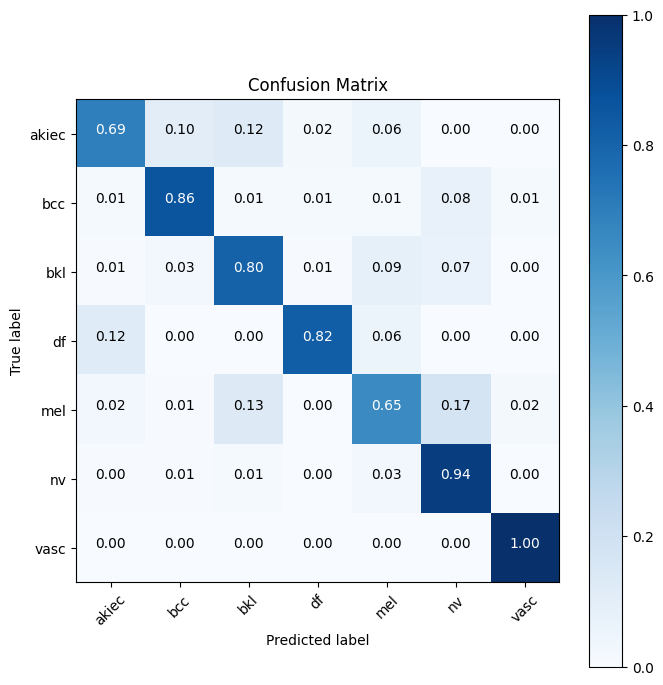

In [220]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(ground_truths, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [ ]:
# only bcc and nv

In [222]:
#############################################
### only predicted label wrong : bcc + nv ###
#############################################
first_model_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
second_model_mapping = {'mel': 0, 'nv': 1}  # nv
third_model_mapping = {'akiec': 0, 'bcc': 1}  # bcc
class_mapping_2 = get_class_mapping(first_model_mapping, second_model_mapping)
class_mapping_3 = get_class_mapping(first_model_mapping, third_model_mapping)


def predict(instance, model_1, model_2, model_3, class_mapping_2, class_mapping_3):
    prediction_1 = model_1.predict(instance, verbose=0)
    class_pred_1 = np.argmax(prediction_1)
    percent_1 = prediction_1[0, class_pred_1]

    # Store models and mappings in list for easier iteration
    models = [model_2, model_3]
    mappings = [class_mapping_2, class_mapping_3]
    # Indices to match the conditions in the original function
    # indices = [(4, 5), (0, 1)]
    indices = [(5,), (1,)]

    for index, model, mapping in zip(indices, models, mappings):
        if class_pred_1 in index:
            prediction = model.predict(instance, verbose=0)
            class_pred = np.argmax(prediction)
            class_pred_mapped = mapping.get(class_pred, class_pred)
            percent = prediction[0, class_pred]

            print(
                f'model 1: {class_pred_1} ({percent_1 * 100:.2f}%) VS. model {models.index(model) + 2}: {class_pred_mapped} ({percent * 100:.2f}%)')

            # Always return the prediction of model 2 or 3 when it is used
            return class_pred_mapped

    return class_pred_1


predictions = []
ground_truths = []

with tqdm(total=total) as pbar:
    for i in range(len(test_image_gen)):
        X, y_true = test_image_gen[i]
        actual_batch_size = X.shape[0]  # calculate the actual batch size

        for j in range(actual_batch_size):  # iterate over the batch
            try:
                instance = X[j]
                filename = test_image_gen.filenames[i * actual_batch_size + j]
                ground_truth = y_true[j]  # get the ground truth label
                ground_truth = np.argmax(ground_truth)  # from one-hot to class index
                ground_truths.append(ground_truth)
                prediction = predict(np.expand_dims(instance, axis=0), model, second_model, third_model,
                                     class_mapping_2, class_mapping_3)
                print(f"Image: {filename}, Prediction: {prediction}, Ground Truth: {ground_truth}")
                predictions.append(prediction)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

            pbar.update()  # update progress bar

  0%|          | 3/1536 [00:01<10:54,  2.34it/s]

Image: akiec/ISIC_0024329.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024372.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024418.jpg, Prediction: 4, Ground Truth: 0
Image: akiec/ISIC_0024450.jpg, Prediction: 0, Ground Truth: 0


  0%|          | 7/1536 [00:01<04:12,  6.06it/s]

Image: akiec/ISIC_0024463.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024468.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024470.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 11/1536 [00:02<02:50,  8.96it/s]

model 1: 1 (63.26%) VS. model 3: 0 (96.00%)
Image: akiec/ISIC_0024511.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024517.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024522.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024539.jpg, Prediction: 2, Ground Truth: 0


  1%|          | 15/1536 [00:02<02:16, 11.13it/s]

model 1: 1 (34.20%) VS. model 3: 1 (99.97%)
Image: akiec/ISIC_0024562.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024575.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024579.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024646.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 17/1536 [00:03<04:37,  5.48it/s]

Image: akiec/ISIC_0024654.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0024707.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 19/1536 [00:03<04:03,  6.24it/s]

model 1: 1 (99.88%) VS. model 3: 1 (99.48%)
Image: akiec/ISIC_0024710.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024763.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024771.jpg, Prediction: 0, Ground Truth: 0


  1%|▏         | 21/1536 [00:03<03:21,  7.51it/s]

Image: akiec/ISIC_0024800.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0024843.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 25/1536 [00:03<02:45,  9.10it/s]

model 1: 1 (94.59%) VS. model 3: 1 (100.00%)
Image: akiec/ISIC_0024913.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024923.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024925.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 27/1536 [00:04<02:28, 10.19it/s]

Image: akiec/ISIC_0024946.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024948.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025029.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 31/1536 [00:04<02:10, 11.56it/s]

Image: akiec/ISIC_0025069.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025089.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025130.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 33/1536 [00:04<02:03, 12.18it/s]

Image: akiec/ISIC_0025178.jpg, Prediction: 3, Ground Truth: 0
Image: akiec/ISIC_0025182.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025196.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 37/1536 [00:04<01:56, 12.89it/s]

Image: akiec/ISIC_0025247.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025264.jpg, Prediction: 4, Ground Truth: 0
Image: akiec/ISIC_0025319.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 39/1536 [00:05<02:12, 11.26it/s]

Image: akiec/ISIC_0025331.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (87.21%) VS. model 3: 0 (97.45%)
Image: akiec/ISIC_0025350.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 41/1536 [00:05<02:22, 10.47it/s]

Image: akiec/ISIC_0025358.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (74.76%) VS. model 3: 0 (97.24%)
Image: akiec/ISIC_0025368.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 43/1536 [00:05<02:13, 11.18it/s]

Image: akiec/ISIC_0025411.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025427.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025471.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 47/1536 [00:05<02:02, 12.14it/s]

Image: akiec/ISIC_0025539.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0025577.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025605.jpg, Prediction: 4, Ground Truth: 0


  3%|▎         | 49/1536 [00:05<01:57, 12.61it/s]

Image: akiec/ISIC_0025637.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0025696.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 51/1536 [00:06<02:09, 11.47it/s]

model 1: 1 (99.67%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024331.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0024332.jpg, Prediction: 0, Ground Truth: 1


  3%|▎         | 53/1536 [00:06<02:37,  9.40it/s]

model 1: 1 (95.16%) VS. model 3: 1 (74.17%)
Image: bcc/ISIC_0024345.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024360.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 55/1536 [00:06<02:56,  8.38it/s]

model 1: 1 (99.95%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0024403.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.23%) VS. model 3: 1 (99.26%)
Image: bcc/ISIC_0024411.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 57/1536 [00:06<03:10,  7.77it/s]

model 1: 5 (32.69%) VS. model 2: 5 (99.99%)
Image: bcc/ISIC_0024431.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (49.21%) VS. model 3: 0 (69.73%)
Image: bcc/ISIC_0024432.jpg, Prediction: 0, Ground Truth: 1


  4%|▍         | 59/1536 [00:07<03:24,  7.22it/s]

model 1: 1 (99.96%) VS. model 3: 1 (99.91%)
Image: bcc/ISIC_0024436.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0024443.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 61/1536 [00:07<03:25,  7.18it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024448.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (97.30%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024452.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 63/1536 [00:07<03:32,  6.93it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.90%)
Image: bcc/ISIC_0024454.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.52%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024457.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 64/1536 [00:08<03:34,  6.87it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0024461.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 66/1536 [00:09<10:41,  2.29it/s]

model 1: 1 (99.97%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024472.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.80%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024504.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 68/1536 [00:10<07:22,  3.32it/s]

model 1: 1 (97.66%) VS. model 3: 1 (99.56%)
Image: bcc/ISIC_0024515.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.96%) VS. model 3: 1 (99.61%)
Image: bcc/ISIC_0024550.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 70/1536 [00:10<06:02,  4.05it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.24%)
Image: bcc/ISIC_0024564.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.97%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024572.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 71/1536 [00:10<05:57,  4.09it/s]

model 1: 1 (99.98%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0024573.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 73/1536 [00:11<05:29,  4.44it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.88%)
Image: bcc/ISIC_0024582.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024590.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 75/1536 [00:11<04:43,  5.15it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024595.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.76%)
Image: bcc/ISIC_0024632.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 77/1536 [00:11<04:20,  5.59it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024634.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.35%) VS. model 3: 1 (78.57%)
Image: bcc/ISIC_0024665.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 79/1536 [00:12<04:26,  5.46it/s]

model 1: 1 (97.47%) VS. model 3: 1 (69.96%)
Image: bcc/ISIC_0024666.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.95%) VS. model 3: 1 (99.01%)
Image: bcc/ISIC_0024673.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 81/1536 [00:12<04:11,  5.78it/s]

model 1: 1 (100.00%) VS. model 3: 1 (98.38%)
Image: bcc/ISIC_0024743.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024787.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 83/1536 [00:12<04:00,  6.04it/s]

model 1: 1 (95.59%) VS. model 3: 1 (98.78%)
Image: bcc/ISIC_0024795.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.78%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0024799.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 85/1536 [00:13<03:56,  6.13it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024829.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.77%) VS. model 3: 1 (81.08%)
Image: bcc/ISIC_0024833.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 87/1536 [00:13<04:01,  6.00it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024848.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.25%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0024885.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 88/1536 [00:13<06:03,  3.99it/s]

model 1: 1 (100.00%) VS. model 3: 1 (98.80%)
Image: bcc/ISIC_0024897.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 90/1536 [00:14<05:45,  4.18it/s]

model 1: 5 (87.03%) VS. model 2: 5 (99.97%)
Image: bcc/ISIC_0024931.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.88%)
Image: bcc/ISIC_0024949.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 92/1536 [00:14<04:51,  4.96it/s]

model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024984.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (81.97%) VS. model 3: 0 (66.07%)
Image: bcc/ISIC_0025019.jpg, Prediction: 0, Ground Truth: 1


  6%|▌         | 94/1536 [00:15<04:28,  5.37it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.74%)
Image: bcc/ISIC_0025031.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.11%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025046.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 96/1536 [00:15<04:08,  5.79it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025102.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025144.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 98/1536 [00:15<03:55,  6.11it/s]

model 1: 1 (98.66%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025260.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025266.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 100/1536 [00:15<03:50,  6.24it/s]

model 1: 1 (97.44%) VS. model 3: 1 (94.49%)
Image: bcc/ISIC_0025285.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025299.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 102/1536 [00:16<03:50,  6.23it/s]

model 1: 1 (92.76%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025301.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.71%)
Image: bcc/ISIC_0025322.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 104/1536 [00:16<03:37,  6.58it/s]

model 1: 1 (99.67%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0025362.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (70.36%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025383.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 106/1536 [00:16<03:25,  6.95it/s]

model 1: 1 (100.00%) VS. model 3: 1 (86.83%)
Image: bcc/ISIC_0025417.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (94.49%) VS. model 3: 1 (99.34%)
Image: bcc/ISIC_0025433.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 108/1536 [00:17<03:24,  6.97it/s]

model 1: 1 (99.97%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025467.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.97%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025509.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 110/1536 [00:17<03:20,  7.10it/s]

model 1: 5 (91.18%) VS. model 2: 5 (99.92%)
Image: bcc/ISIC_0025513.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (77.57%) VS. model 3: 1 (74.40%)
Image: bcc/ISIC_0025530.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 111/1536 [00:17<03:24,  6.97it/s]

model 1: 1 (84.06%) VS. model 3: 1 (98.43%)
Image: bcc/ISIC_0025557.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025564.jpg, Prediction: 2, Ground Truth: 1


  7%|▋         | 113/1536 [00:17<03:23,  7.00it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025576.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 115/1536 [00:18<04:22,  5.41it/s]

model 1: 5 (54.85%) VS. model 2: 5 (99.78%)
Image: bcc/ISIC_0025584.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025600.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 117/1536 [00:18<03:54,  6.04it/s]

model 1: 1 (96.92%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025601.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (48.01%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025617.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 119/1536 [00:18<03:12,  7.36it/s]

Image: bcc/ISIC_0025630.jpg, Prediction: 6, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025644.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025650.jpg, Prediction: 0, Ground Truth: 1


  8%|▊         | 122/1536 [00:19<02:50,  8.28it/s]

model 1: 1 (56.71%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025691.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (64.54%) VS. model 3: 1 (66.52%)
Image: bcc/ISIC_0025700.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 124/1536 [00:19<02:50,  8.30it/s]

model 1: 1 (99.97%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025711.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0025718.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 127/1536 [00:19<02:17, 10.28it/s]

model 1: 1 (98.82%) VS. model 3: 1 (99.90%)
Image: bcc/ISIC_0025731.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025752.jpg, Prediction: 4, Ground Truth: 1
Image: bkl/ISIC_0024312.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024324.jpg, Prediction: 2, Ground Truth: 2


  9%|▊         | 131/1536 [00:21<05:41,  4.11it/s]

Image: bkl/ISIC_0024336.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024338.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024358.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 135/1536 [00:21<03:22,  6.90it/s]

Image: bkl/ISIC_0024371.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024381.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024382.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024383.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 139/1536 [00:21<02:34,  9.04it/s]

Image: bkl/ISIC_0024408.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024409.jpg, Prediction: 2, Ground Truth: 2
model 1: 1 (98.53%) VS. model 3: 1 (95.17%)
Image: bkl/ISIC_0024412.jpg, Prediction: 1, Ground Truth: 2


  9%|▉         | 141/1536 [00:22<02:27,  9.46it/s]

Image: bkl/ISIC_0024420.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (80.19%) VS. model 2: 5 (88.85%)
Image: bkl/ISIC_0024422.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024426.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 145/1536 [00:22<02:10, 10.65it/s]

Image: bkl/ISIC_0024435.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (85.92%) VS. model 2: 5 (99.98%)
Image: bkl/ISIC_0024445.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024446.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 149/1536 [00:22<01:47, 12.86it/s]

Image: bkl/ISIC_0024453.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024471.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024477.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024489.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 151/1536 [00:22<01:41, 13.68it/s]

Image: bkl/ISIC_0024490.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024494.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (55.23%) VS. model 2: 5 (52.83%)
Image: bkl/ISIC_0024495.jpg, Prediction: 5, Ground Truth: 2


 10%|█         | 155/1536 [00:23<01:43, 13.39it/s]

Image: bkl/ISIC_0024498.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024505.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024547.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 157/1536 [00:23<01:42, 13.41it/s]

Image: bkl/ISIC_0024581.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024592.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024602.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 161/1536 [00:23<01:36, 14.29it/s]

Image: bkl/ISIC_0024612.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024623.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024626.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024635.jpg, Prediction: 4, Ground Truth: 2


 11%|█         | 165/1536 [00:23<01:32, 14.78it/s]

Image: bkl/ISIC_0024643.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024672.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024676.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024696.jpg, Prediction: 4, Ground Truth: 2


 11%|█         | 169/1536 [00:23<01:30, 15.07it/s]

Image: bkl/ISIC_0024705.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024708.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024709.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024711.jpg, Prediction: 4, Ground Truth: 2


 11%|█▏        | 173/1536 [00:24<01:28, 15.39it/s]

Image: bkl/ISIC_0024726.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024740.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024741.jpg, Prediction: 2, Ground Truth: 2


 11%|█▏        | 175/1536 [00:24<01:44, 13.07it/s]

model 1: 5 (87.12%) VS. model 2: 5 (99.86%)
Image: bkl/ISIC_0024748.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024760.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 179/1536 [00:24<01:36, 14.00it/s]

Image: bkl/ISIC_0024761.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024770.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024772.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 181/1536 [00:24<01:35, 14.22it/s]

Image: bkl/ISIC_0024773.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024774.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (54.16%) VS. model 2: 4 (97.89%)
Image: bkl/ISIC_0024782.jpg, Prediction: 4, Ground Truth: 2


 12%|█▏        | 185/1536 [00:25<01:46, 12.73it/s]

Image: bkl/ISIC_0024786.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024814.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024825.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 187/1536 [00:25<01:52, 12.03it/s]

model 1: 1 (87.03%) VS. model 3: 1 (99.99%)
Image: bkl/ISIC_0024832.jpg, Prediction: 1, Ground Truth: 2
Image: bkl/ISIC_0024839.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (51.95%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0024850.jpg, Prediction: 5, Ground Truth: 2


 12%|█▏        | 191/1536 [00:25<01:47, 12.46it/s]

Image: bkl/ISIC_0024851.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024871.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024877.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024880.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 194/1536 [00:27<05:38,  3.97it/s]

Image: bkl/ISIC_0024881.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (97.08%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0024883.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024890.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 198/1536 [00:27<03:19,  6.69it/s]

Image: bkl/ISIC_0024893.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024909.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024910.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024915.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 202/1536 [00:27<02:16,  9.76it/s]

Image: bkl/ISIC_0024943.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024947.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024970.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024971.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 206/1536 [00:28<01:57, 11.30it/s]

model 1: 5 (75.52%) VS. model 2: 5 (96.57%)
Image: bkl/ISIC_0024981.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0024982.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024997.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025005.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 210/1536 [00:28<01:39, 13.36it/s]

Image: bkl/ISIC_0025016.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025030.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025032.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025033.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 214/1536 [00:28<01:43, 12.81it/s]

Image: bkl/ISIC_0025038.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (99.52%) VS. model 2: 5 (99.73%)
Image: bkl/ISIC_0025040.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025063.jpg, Prediction: 4, Ground Truth: 2


 14%|█▍        | 218/1536 [00:29<01:39, 13.23it/s]

model 1: 5 (95.91%) VS. model 2: 5 (96.00%)
Image: bkl/ISIC_0025064.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025066.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025068.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025075.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 222/1536 [00:29<01:39, 13.23it/s]

model 1: 5 (87.09%) VS. model 2: 5 (89.89%)
Image: bkl/ISIC_0025076.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025083.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025086.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025099.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 226/1536 [00:29<01:29, 14.72it/s]

Image: bkl/ISIC_0025103.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025113.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025131.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025136.jpg, Prediction: 4, Ground Truth: 2


 15%|█▍        | 230/1536 [00:29<01:33, 13.98it/s]

model 1: 5 (63.71%) VS. model 2: 4 (99.94%)
Image: bkl/ISIC_0025140.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025157.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025180.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025199.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 234/1536 [00:30<01:25, 15.14it/s]

Image: bkl/ISIC_0025209.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025222.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025275.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025276.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 238/1536 [00:30<01:25, 15.22it/s]

Image: bkl/ISIC_0025286.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025292.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025297.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025312.jpg, Prediction: 0, Ground Truth: 2


 16%|█▌        | 242/1536 [00:30<01:22, 15.75it/s]

Image: bkl/ISIC_0025326.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025330.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025339.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 244/1536 [00:30<01:20, 16.02it/s]

Image: bkl/ISIC_0025345.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025351.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (93.31%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0025366.jpg, Prediction: 5, Ground Truth: 2


 16%|█▌        | 248/1536 [00:31<01:28, 14.47it/s]

Image: bkl/ISIC_0025374.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025376.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025378.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025387.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 252/1536 [00:31<01:23, 15.38it/s]

Image: bkl/ISIC_0025388.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025389.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025392.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025419.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 256/1536 [00:31<01:22, 15.56it/s]

Image: bkl/ISIC_0025431.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025434.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025454.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 260/1536 [00:33<04:21,  4.88it/s]

Image: bkl/ISIC_0025465.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025466.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025470.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025484.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 264/1536 [00:33<02:50,  7.48it/s]

Image: bkl/ISIC_0025485.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025507.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025510.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025515.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 268/1536 [00:33<02:01, 10.45it/s]

Image: bkl/ISIC_0025519.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025526.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025529.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025548.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 272/1536 [00:33<01:40, 12.60it/s]

Image: bkl/ISIC_0025554.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025567.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025575.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025583.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 276/1536 [00:34<01:28, 14.27it/s]

Image: bkl/ISIC_0025623.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025627.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025642.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025654.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 280/1536 [00:34<01:25, 14.76it/s]

Image: bkl/ISIC_0025656.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025659.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025661.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025693.jpg, Prediction: 4, Ground Truth: 2


 18%|█▊        | 284/1536 [00:34<01:21, 15.40it/s]

Image: bkl/ISIC_0025699.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025703.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025710.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025716.jpg, Prediction: 4, Ground Truth: 2


 19%|█▉        | 288/1536 [00:34<01:17, 16.11it/s]

Image: bkl/ISIC_0025719.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025743.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025746.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025753.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 292/1536 [00:35<01:17, 16.02it/s]

Image: bkl/ISIC_0025758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025767.jpg, Prediction: 2, Ground Truth: 2
Image: df/ISIC_0024318.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024330.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 294/1536 [00:35<01:18, 15.86it/s]

Image: df/ISIC_0024386.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024396.jpg, Prediction: 3, Ground Truth: 3
model 1: 1 (91.08%) VS. model 3: 1 (99.65%)
Image: df/ISIC_0024553.jpg, Prediction: 1, Ground Truth: 3


 19%|█▉        | 298/1536 [00:35<01:28, 13.92it/s]

Image: df/ISIC_0024845.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024973.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024994.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 302/1536 [00:35<01:24, 14.64it/s]

Image: df/ISIC_0025154.jpg, Prediction: 0, Ground Truth: 3
Image: df/ISIC_0025223.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025302.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025314.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 304/1536 [00:36<01:23, 14.74it/s]

Image: df/ISIC_0025373.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025504.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025594.jpg, Prediction: 3, Ground Truth: 3


 20%|██        | 308/1536 [00:36<01:26, 14.25it/s]

Image: df/ISIC_0025622.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025668.jpg, Prediction: 3, Ground Truth: 3
Image: mel/ISIC_0024310.jpg, Prediction: 4, Ground Truth: 4


 20%|██        | 312/1536 [00:36<01:31, 13.32it/s]

model 1: 5 (78.27%) VS. model 2: 5 (55.06%)
Image: mel/ISIC_0024313.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024315.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024323.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024333.jpg, Prediction: 2, Ground Truth: 4


 20%|██        | 314/1536 [00:36<01:42, 11.95it/s]

model 1: 5 (58.94%) VS. model 2: 4 (97.93%)
Image: mel/ISIC_0024351.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024367.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024400.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 318/1536 [00:37<01:42, 11.90it/s]

model 1: 5 (73.11%) VS. model 2: 5 (97.16%)
Image: mel/ISIC_0024410.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024449.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024459.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 320/1536 [00:37<01:51, 10.92it/s]

model 1: 5 (52.35%) VS. model 2: 5 (50.28%)
Image: mel/ISIC_0024481.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024482.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 324/1536 [00:39<04:30,  4.48it/s]

Image: mel/ISIC_0024496.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024516.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024525.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024537.jpg, Prediction: 4, Ground Truth: 4


 21%|██▏       | 328/1536 [00:39<02:51,  7.05it/s]

Image: mel/ISIC_0024545.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024546.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024552.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024554.jpg, Prediction: 2, Ground Truth: 4


 21%|██▏       | 330/1536 [00:39<02:33,  7.86it/s]

Image: mel/ISIC_0024571.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (78.27%) VS. model 2: 5 (99.86%)
Image: mel/ISIC_0024586.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024624.jpg, Prediction: 2, Ground Truth: 4


 22%|██▏       | 334/1536 [00:39<01:52, 10.73it/s]

Image: mel/ISIC_0024630.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024640.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024644.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024647.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 338/1536 [00:39<01:32, 12.99it/s]

Image: mel/ISIC_0024652.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024675.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024679.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024688.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 342/1536 [00:40<01:22, 14.51it/s]

Image: mel/ISIC_0024700.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024701.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024702.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024729.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 346/1536 [00:40<01:20, 14.81it/s]

Image: mel/ISIC_0024732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024733.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024739.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024756.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 350/1536 [00:40<01:15, 15.67it/s]

Image: mel/ISIC_0024767.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024792.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024805.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024806.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 354/1536 [00:41<01:25, 13.87it/s]

Image: mel/ISIC_0024823.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024853.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (75.12%) VS. model 2: 5 (94.75%)
Image: mel/ISIC_0024864.jpg, Prediction: 5, Ground Truth: 4


 23%|██▎       | 356/1536 [00:41<01:22, 14.35it/s]

Image: mel/ISIC_0024865.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024875.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024886.jpg, Prediction: 2, Ground Truth: 4


 23%|██▎       | 360/1536 [00:41<01:23, 14.07it/s]

model 1: 5 (80.00%) VS. model 2: 5 (77.23%)
Image: mel/ISIC_0024898.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024900.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024911.jpg, Prediction: 4, Ground Truth: 4


 24%|██▎       | 362/1536 [00:41<01:32, 12.73it/s]

model 1: 5 (89.60%) VS. model 2: 5 (96.15%)
Image: mel/ISIC_0024918.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024929.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (95.57%) VS. model 2: 5 (80.48%)
Image: mel/ISIC_0024930.jpg, Prediction: 5, Ground Truth: 4


 24%|██▍       | 366/1536 [00:41<01:27, 13.31it/s]

Image: mel/ISIC_0024932.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024940.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024951.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024952.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 370/1536 [00:42<01:20, 14.52it/s]

Image: mel/ISIC_0024958.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024961.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024962.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024967.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 374/1536 [00:42<01:27, 13.29it/s]

Image: mel/ISIC_0024972.jpg, Prediction: 0, Ground Truth: 4
model 1: 5 (77.95%) VS. model 2: 4 (53.23%)
Image: mel/ISIC_0024987.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024999.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 378/1536 [00:42<01:27, 13.27it/s]

model 1: 5 (78.95%) VS. model 2: 5 (99.96%)
Image: mel/ISIC_0025018.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025035.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025081.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025085.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 382/1536 [00:43<01:18, 14.78it/s]

Image: mel/ISIC_0025097.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025121.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025127.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 384/1536 [00:43<01:17, 14.82it/s]

Image: mel/ISIC_0025128.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025132.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 386/1536 [00:44<05:18,  3.61it/s]

Image: mel/ISIC_0025145.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (86.72%) VS. model 2: 5 (99.43%)
Image: mel/ISIC_0025153.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025155.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 390/1536 [00:45<03:11,  5.98it/s]

Image: mel/ISIC_0025188.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025195.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025219.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025234.jpg, Prediction: 6, Ground Truth: 4


 26%|██▌       | 394/1536 [00:45<02:11,  8.69it/s]

Image: mel/ISIC_0025235.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025238.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025248.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 396/1536 [00:45<02:10,  8.76it/s]

model 1: 5 (73.76%) VS. model 2: 4 (95.33%)
Image: mel/ISIC_0025265.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025268.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025277.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 398/1536 [00:45<01:59,  9.53it/s]

Image: mel/ISIC_0025303.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.45%) VS. model 2: 5 (97.52%)
Image: mel/ISIC_0025313.jpg, Prediction: 5, Ground Truth: 4


 26%|██▌       | 400/1536 [00:45<02:11,  8.64it/s]

Image: mel/ISIC_0025316.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025317.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 403/1536 [00:46<02:13,  8.46it/s]

model 1: 5 (82.64%) VS. model 2: 5 (99.99%)
Image: mel/ISIC_0025324.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025363.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025391.jpg, Prediction: 4, Ground Truth: 4


 26%|██▋       | 406/1536 [00:46<02:25,  7.76it/s]

model 1: 5 (93.72%) VS. model 2: 5 (99.69%)
Image: mel/ISIC_0025394.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (67.85%) VS. model 2: 5 (83.03%)
Image: mel/ISIC_0025409.jpg, Prediction: 5, Ground Truth: 4


 27%|██▋       | 408/1536 [00:46<02:07,  8.87it/s]

Image: mel/ISIC_0025413.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025414.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025439.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 411/1536 [00:47<02:10,  8.64it/s]

model 1: 5 (95.47%) VS. model 2: 5 (100.00%)
Image: mel/ISIC_0025450.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (99.29%) VS. model 2: 5 (99.94%)
Image: mel/ISIC_0025451.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025472.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 415/1536 [00:47<01:35, 11.70it/s]

Image: mel/ISIC_0025489.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025500.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025512.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025520.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 419/1536 [00:47<01:23, 13.32it/s]

Image: mel/ISIC_0025524.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025531.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025543.jpg, Prediction: 2, Ground Truth: 4


 27%|██▋       | 421/1536 [00:47<01:35, 11.71it/s]

Image: mel/ISIC_0025546.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (83.03%) VS. model 2: 5 (96.25%)
Image: mel/ISIC_0025550.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 423/1536 [00:48<01:44, 10.67it/s]

model 1: 5 (55.63%) VS. model 2: 4 (79.94%)
Image: mel/ISIC_0025573.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025589.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025592.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 425/1536 [00:48<01:36, 11.54it/s]

Image: mel/ISIC_0025603.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 427/1536 [00:48<01:56,  9.53it/s]

model 1: 5 (62.47%) VS. model 2: 4 (57.06%)
Image: mel/ISIC_0025611.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025616.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025651.jpg, Prediction: 0, Ground Truth: 4


 28%|██▊       | 429/1536 [00:48<01:50, 10.03it/s]

Image: mel/ISIC_0025663.jpg, Prediction: 4, Ground Truth: 4
model 1: 1 (91.72%) VS. model 3: 1 (96.92%)
Image: mel/ISIC_0025674.jpg, Prediction: 1, Ground Truth: 4


 28%|██▊       | 431/1536 [00:49<02:02,  9.02it/s]

Image: mel/ISIC_0025708.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025709.jpg, Prediction: 0, Ground Truth: 4


 28%|██▊       | 434/1536 [00:49<02:10,  8.45it/s]

model 1: 5 (93.87%) VS. model 2: 5 (98.95%)
Image: mel/ISIC_0025724.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025744.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 437/1536 [00:49<02:03,  8.93it/s]

Image: mel/ISIC_0025748.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (60.83%) VS. model 2: 5 (63.37%)
Image: mel/ISIC_0025751.jpg, Prediction: 5, Ground Truth: 4


 29%|██▊       | 438/1536 [00:49<02:06,  8.68it/s]

model 1: 5 (65.54%) VS. model 2: 4 (56.06%)
Image: mel/ISIC_0025755.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025766.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.53%) VS. model 2: 5 (100.00%)
Image: mel/ISIC_0025783.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 443/1536 [00:50<01:45, 10.36it/s]

model 1: 5 (93.41%) VS. model 2: 5 (94.94%)
Image: mel/ISIC_0025791.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025800.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025814.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 445/1536 [00:50<01:37, 11.16it/s]

Image: mel/ISIC_0025832.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025835.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 447/1536 [00:50<01:42, 10.59it/s]

model 1: 5 (97.35%) VS. model 2: 5 (98.23%)
Image: mel/ISIC_0025891.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025904.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025927.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 451/1536 [00:52<04:07,  4.38it/s]

Image: mel/ISIC_0025941.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025955.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025963.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025964.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 455/1536 [00:52<02:33,  7.06it/s]

Image: mel/ISIC_0025987.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025996.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026009.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0026045.jpg, Prediction: 2, Ground Truth: 4


 30%|██▉       | 459/1536 [00:52<01:55,  9.29it/s]

Image: mel/ISIC_0026081.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026086.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (98.73%) VS. model 2: 5 (99.01%)
Image: mel/ISIC_0026089.jpg, Prediction: 5, Ground Truth: 4


 30%|███       | 463/1536 [00:53<01:30, 11.86it/s]

Image: mel/ISIC_0026094.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026113.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026115.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 465/1536 [00:53<01:22, 12.93it/s]

Image: mel/ISIC_0026120.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026131.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026150.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 469/1536 [00:53<01:31, 11.69it/s]

model 1: 1 (99.52%) VS. model 3: 1 (100.00%)
Image: mel/ISIC_0026158.jpg, Prediction: 1, Ground Truth: 4
model 1: 5 (72.36%) VS. model 2: 4 (99.97%)
Image: mel/ISIC_0026167.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026188.jpg, Prediction: 0, Ground Truth: 4


 31%|███       | 471/1536 [00:53<01:32, 11.49it/s]

model 1: 5 (94.11%) VS. model 2: 5 (87.72%)
Image: mel/ISIC_0026207.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0026229.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026236.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 473/1536 [00:54<01:32, 11.49it/s]

model 1: 5 (66.54%) VS. model 2: 4 (90.25%)
Image: mel/ISIC_0026239.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024306.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 475/1536 [00:54<01:44, 10.19it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024307.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024308.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 477/1536 [00:54<01:50,  9.54it/s]

model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024309.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024311.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 480/1536 [00:54<01:58,  8.89it/s]

model 1: 5 (82.40%) VS. model 2: 5 (96.35%)
Image: nv/ISIC_0024314.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024316.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 482/1536 [00:55<02:00,  8.76it/s]

model 1: 5 (85.60%) VS. model 2: 5 (99.54%)
Image: nv/ISIC_0024317.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024319.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 484/1536 [00:55<02:06,  8.30it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.06%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024321.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 486/1536 [00:55<02:06,  8.27it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024322.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024325.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 488/1536 [00:55<02:09,  8.08it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024326.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024327.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 490/1536 [00:56<02:07,  8.17it/s]

model 1: 5 (92.26%) VS. model 2: 5 (79.91%)
Image: nv/ISIC_0024328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024334.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 492/1536 [00:56<02:11,  7.95it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024335.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024339.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 494/1536 [00:56<02:08,  8.08it/s]

model 1: 5 (99.53%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024340.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024341.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 496/1536 [00:56<02:07,  8.13it/s]

model 1: 5 (83.56%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.52%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024343.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024344.jpg, Prediction: 4, Ground Truth: 5


 32%|███▏      | 499/1536 [00:57<01:59,  8.71it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024346.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.71%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024347.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 501/1536 [00:57<02:06,  8.20it/s]

model 1: 5 (96.04%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024348.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.81%) VS. model 2: 5 (80.51%)
Image: nv/ISIC_0024349.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 503/1536 [00:57<02:09,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024350.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (76.31%) VS. model 2: 5 (95.41%)
Image: nv/ISIC_0024352.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 505/1536 [00:57<02:08,  8.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024353.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024354.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 507/1536 [00:58<02:08,  7.99it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024355.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.19%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024356.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 509/1536 [00:58<02:08,  8.01it/s]

model 1: 5 (73.39%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024357.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024359.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 511/1536 [00:58<02:10,  7.84it/s]

model 1: 5 (99.59%) VS. model 2: 5 (99.71%)
Image: nv/ISIC_0024361.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024362.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 512/1536 [00:58<02:09,  7.93it/s]

model 1: 5 (98.23%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024363.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 514/1536 [01:00<06:58,  2.44it/s]

model 1: 5 (89.39%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024365.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 516/1536 [01:00<04:31,  3.76it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024366.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024368.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 518/1536 [01:00<03:19,  5.11it/s]

model 1: 5 (99.08%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024373.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024374.jpg, Prediction: 2, Ground Truth: 5


 34%|███▍      | 521/1536 [01:01<02:27,  6.90it/s]

model 1: 5 (99.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024376.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.02%) VS. model 2: 5 (88.71%)
Image: nv/ISIC_0024377.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 523/1536 [01:01<02:21,  7.16it/s]

model 1: 5 (97.26%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024378.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024379.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 525/1536 [01:01<02:18,  7.28it/s]

model 1: 5 (90.05%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024380.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024384.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 527/1536 [01:02<02:13,  7.55it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024385.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.40%) VS. model 2: 5 (90.65%)
Image: nv/ISIC_0024387.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 529/1536 [01:02<02:16,  7.39it/s]

model 1: 5 (92.44%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024388.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024389.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 531/1536 [01:02<02:13,  7.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024390.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024391.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 533/1536 [01:02<02:15,  7.42it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024392.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024393.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 535/1536 [01:03<02:12,  7.54it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024394.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.66%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024395.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 537/1536 [01:03<02:18,  7.22it/s]

model 1: 5 (99.77%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024398.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 539/1536 [01:03<02:09,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024401.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 541/1536 [01:03<02:04,  7.98it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024404.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024405.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 543/1536 [01:04<02:05,  7.94it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024406.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024407.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 545/1536 [01:04<02:01,  8.15it/s]

model 1: 5 (99.42%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024413.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024414.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 547/1536 [01:04<02:02,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024415.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.79%) VS. model 2: 5 (99.72%)
Image: nv/ISIC_0024416.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 549/1536 [01:04<02:00,  8.20it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024417.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024419.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 551/1536 [01:05<02:01,  8.08it/s]

model 1: 5 (99.70%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024421.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.54%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024423.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 553/1536 [01:05<02:01,  8.09it/s]

model 1: 1 (97.46%) VS. model 3: 1 (83.81%)
Image: nv/ISIC_0024424.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (89.56%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024425.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 555/1536 [01:05<02:01,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024427.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024428.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 557/1536 [01:05<02:00,  8.09it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024429.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024430.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 559/1536 [01:06<01:58,  8.21it/s]

model 1: 5 (98.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024433.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024434.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 561/1536 [01:06<02:00,  8.07it/s]

model 1: 5 (90.39%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024437.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024438.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 563/1536 [01:06<01:59,  8.13it/s]

model 1: 5 (95.52%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024439.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024440.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 565/1536 [01:06<02:01,  7.98it/s]

model 1: 5 (98.29%) VS. model 2: 5 (96.17%)
Image: nv/ISIC_0024441.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024442.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 567/1536 [01:07<01:57,  8.22it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024444.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (78.21%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024447.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 569/1536 [01:07<02:00,  8.06it/s]

model 1: 5 (99.45%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024451.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024455.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 571/1536 [01:07<01:57,  8.23it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024456.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (53.61%) VS. model 2: 4 (52.96%)
Image: nv/ISIC_0024458.jpg, Prediction: 4, Ground Truth: 5


 37%|███▋      | 573/1536 [01:07<01:58,  8.14it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024460.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.56%) VS. model 2: 5 (73.78%)
Image: nv/ISIC_0024462.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 575/1536 [01:08<01:58,  8.14it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0024464.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024465.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 576/1536 [01:08<01:56,  8.21it/s]

model 1: 5 (71.13%) VS. model 2: 5 (95.39%)
Image: nv/ISIC_0024466.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 578/1536 [01:09<06:37,  2.41it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024467.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024469.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 580/1536 [01:10<04:15,  3.75it/s]

model 1: 5 (99.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024474.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024476.jpg, Prediction: 2, Ground Truth: 5


 38%|███▊      | 583/1536 [01:10<02:46,  5.72it/s]

model 1: 5 (99.24%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024478.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.65%) VS. model 2: 5 (92.67%)
Image: nv/ISIC_0024479.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 585/1536 [01:10<02:23,  6.61it/s]

model 1: 5 (61.97%) VS. model 2: 5 (89.83%)
Image: nv/ISIC_0024480.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024483.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 587/1536 [01:10<02:14,  7.08it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024484.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024485.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 589/1536 [01:11<02:05,  7.53it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024486.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024487.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 591/1536 [01:11<02:05,  7.55it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024488.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024491.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 593/1536 [01:11<02:01,  7.78it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024492.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (98.83%)
Image: nv/ISIC_0024493.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 595/1536 [01:11<01:57,  7.99it/s]

model 1: 5 (85.43%) VS. model 2: 5 (98.73%)
Image: nv/ISIC_0024497.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024499.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 597/1536 [01:12<01:57,  7.99it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024500.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024501.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 599/1536 [01:12<01:56,  8.01it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024502.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024503.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 601/1536 [01:12<01:58,  7.91it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024506.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.53%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024507.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 603/1536 [01:12<01:57,  7.97it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024508.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024509.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 605/1536 [01:13<01:57,  7.89it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024510.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024512.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 606/1536 [01:13<01:57,  7.88it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024513.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024514.jpg, Prediction: 4, Ground Truth: 5


 40%|███▉      | 609/1536 [01:13<01:52,  8.21it/s]

model 1: 5 (53.70%) VS. model 2: 5 (79.85%)
Image: nv/ISIC_0024518.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.91%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024519.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 611/1536 [01:13<02:00,  7.69it/s]

model 1: 5 (99.97%) VS. model 2: 5 (98.86%)
Image: nv/ISIC_0024520.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024521.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 613/1536 [01:14<02:00,  7.63it/s]

model 1: 5 (92.30%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024523.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.40%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024524.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 615/1536 [01:14<02:05,  7.34it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024526.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024527.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 617/1536 [01:14<02:02,  7.49it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024528.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.95%) VS. model 2: 5 (98.75%)
Image: nv/ISIC_0024529.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 619/1536 [01:15<02:07,  7.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024530.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024531.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 621/1536 [01:15<02:04,  7.37it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024532.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024533.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 623/1536 [01:15<02:03,  7.41it/s]

model 1: 5 (84.06%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 625/1536 [01:15<02:00,  7.53it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.25%) VS. model 2: 5 (97.50%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 627/1536 [01:16<02:02,  7.44it/s]

model 1: 5 (70.76%) VS. model 2: 5 (99.31%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024541.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 629/1536 [01:16<02:01,  7.47it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024542.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024543.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 631/1536 [01:16<01:57,  7.73it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024544.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024548.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 633/1536 [01:16<01:56,  7.77it/s]

model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024549.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024551.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 635/1536 [01:17<01:52,  7.98it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024555.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024556.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 637/1536 [01:17<01:55,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024557.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024558.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 639/1536 [01:17<01:52,  7.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024559.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.19%) VS. model 2: 5 (88.60%)
Image: nv/ISIC_0024560.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 640/1536 [01:17<01:52,  7.95it/s]

model 1: 5 (91.14%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0024561.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 642/1536 [01:19<06:10,  2.41it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024565.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 644/1536 [01:19<04:00,  3.72it/s]

model 1: 1 (93.62%) VS. model 3: 1 (99.84%)
Image: nv/ISIC_0024566.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024567.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 646/1536 [01:19<02:56,  5.05it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024568.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024569.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 648/1536 [01:20<02:22,  6.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024570.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024574.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 650/1536 [01:20<02:10,  6.81it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024576.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.33%) VS. model 2: 5 (89.97%)
Image: nv/ISIC_0024577.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 652/1536 [01:20<02:01,  7.29it/s]

model 1: 5 (96.10%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024578.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024580.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 654/1536 [01:20<01:55,  7.61it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024583.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024584.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 656/1536 [01:21<01:52,  7.83it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.20%) VS. model 2: 5 (95.31%)
Image: nv/ISIC_0024587.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 658/1536 [01:21<01:50,  7.94it/s]

model 1: 5 (96.65%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0024588.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024589.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 660/1536 [01:21<01:51,  7.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024591.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.06%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0024593.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 662/1536 [01:21<01:47,  8.10it/s]

model 1: 5 (97.71%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0024594.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.63%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024596.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 664/1536 [01:22<01:49,  7.95it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024597.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024598.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 666/1536 [01:22<01:48,  7.98it/s]

model 1: 5 (97.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024599.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024600.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 668/1536 [01:22<01:48,  7.97it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024601.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024603.jpg, Prediction: 5, Ground Truth: 5


 44%|████▎     | 670/1536 [01:22<01:46,  8.10it/s]

model 1: 5 (69.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024605.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 672/1536 [01:23<01:48,  7.96it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024606.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024607.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024608.jpg, Prediction: 4, Ground Truth: 5


 44%|████▍     | 675/1536 [01:23<01:39,  8.63it/s]

model 1: 5 (100.00%) VS. model 2: 5 (97.79%)
Image: nv/ISIC_0024609.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024610.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 677/1536 [01:23<01:45,  8.16it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024611.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024613.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 679/1536 [01:24<01:44,  8.17it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024614.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.20%) VS. model 2: 5 (77.95%)
Image: nv/ISIC_0024615.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 681/1536 [01:24<01:47,  7.97it/s]

model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024616.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (98.49%)
Image: nv/ISIC_0024617.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 683/1536 [01:24<01:47,  7.90it/s]

model 1: 5 (94.32%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024618.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024619.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 685/1536 [01:24<01:45,  8.10it/s]

model 1: 5 (99.98%) VS. model 2: 5 (98.99%)
Image: nv/ISIC_0024620.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024621.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 687/1536 [01:25<01:46,  7.94it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024622.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024625.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 689/1536 [01:25<01:45,  8.05it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024627.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024628.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 691/1536 [01:25<01:45,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024629.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024631.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 693/1536 [01:25<01:43,  8.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024636.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 695/1536 [01:26<01:48,  7.72it/s]

model 1: 5 (99.70%) VS. model 2: 5 (96.31%)
Image: nv/ISIC_0024637.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024638.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 697/1536 [01:26<01:53,  7.41it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024639.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024641.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 699/1536 [01:26<01:53,  7.40it/s]

model 1: 5 (94.02%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024642.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024645.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 701/1536 [01:26<01:51,  7.47it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024648.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024649.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 703/1536 [01:27<01:52,  7.41it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024650.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.25%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024651.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 704/1536 [01:27<01:55,  7.19it/s]

model 1: 5 (81.42%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024653.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 706/1536 [01:28<05:59,  2.31it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024656.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 708/1536 [01:29<03:53,  3.54it/s]

model 1: 5 (91.03%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024658.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 710/1536 [01:29<02:47,  4.92it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024659.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024660.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 712/1536 [01:29<02:14,  6.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024661.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024663.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 714/1536 [01:29<01:56,  7.07it/s]

model 1: 5 (69.05%) VS. model 2: 5 (90.79%)
Image: nv/ISIC_0024664.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024667.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 716/1536 [01:30<01:48,  7.57it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024668.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024670.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 718/1536 [01:30<01:46,  7.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024671.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.95%) VS. model 2: 5 (92.80%)
Image: nv/ISIC_0024674.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 720/1536 [01:30<01:43,  7.89it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024677.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024678.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 722/1536 [01:30<01:42,  7.92it/s]

model 1: 5 (89.87%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024680.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024681.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024682.jpg, Prediction: 4, Ground Truth: 5


 47%|████▋     | 726/1536 [01:31<01:17, 10.45it/s]

Image: nv/ISIC_0024683.jpg, Prediction: 2, Ground Truth: 5
Image: nv/ISIC_0024684.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024685.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 728/1536 [01:31<01:27,  9.25it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024686.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024687.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 730/1536 [01:31<01:30,  8.91it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024689.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (62.44%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024690.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 732/1536 [01:32<01:34,  8.49it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024691.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024692.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 734/1536 [01:32<01:36,  8.33it/s]

model 1: 5 (68.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024693.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.68%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024694.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 737/1536 [01:32<01:16, 10.51it/s]

model 1: 5 (93.12%) VS. model 2: 5 (99.39%)
Image: nv/ISIC_0024695.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024697.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024698.jpg, Prediction: 4, Ground Truth: 5


 48%|████▊     | 739/1536 [01:32<01:23,  9.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024699.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0024703.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 741/1536 [01:33<01:28,  8.97it/s]

model 1: 5 (99.54%) VS. model 2: 5 (99.00%)
Image: nv/ISIC_0024704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024712.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 743/1536 [01:33<01:34,  8.38it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024713.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.79%) VS. model 2: 5 (97.72%)
Image: nv/ISIC_0024714.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 745/1536 [01:33<01:36,  8.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024715.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (78.50%) VS. model 2: 5 (62.26%)
Image: nv/ISIC_0024716.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 747/1536 [01:33<01:37,  8.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024718.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 749/1536 [01:34<01:36,  8.20it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024719.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.64%) VS. model 2: 5 (99.38%)
Image: nv/ISIC_0024720.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 751/1536 [01:34<01:37,  8.07it/s]

model 1: 5 (99.69%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024722.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024723.jpg, Prediction: 4, Ground Truth: 5


 49%|████▉     | 754/1536 [01:34<01:29,  8.77it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024724.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024725.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 756/1536 [01:34<01:34,  8.30it/s]

model 1: 5 (99.66%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024727.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024728.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024730.jpg, Prediction: 4, Ground Truth: 5


 49%|████▉     | 759/1536 [01:35<01:26,  9.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024731.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.05%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024734.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 761/1536 [01:35<01:32,  8.39it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024735.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024736.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 763/1536 [01:35<01:34,  8.18it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024737.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024738.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 765/1536 [01:35<01:35,  8.04it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024742.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024744.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 767/1536 [01:36<01:35,  8.09it/s]

model 1: 5 (98.75%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024745.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024746.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 768/1536 [01:36<01:35,  8.03it/s]

model 1: 5 (98.92%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024749.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 770/1536 [01:37<05:10,  2.47it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.60%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0024751.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 772/1536 [01:38<03:21,  3.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024752.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024753.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 774/1536 [01:38<02:29,  5.10it/s]

model 1: 5 (99.73%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024754.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024755.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024757.jpg, Prediction: 4, Ground Truth: 5


 51%|█████     | 777/1536 [01:38<01:50,  6.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024759.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.19%) VS. model 2: 5 (99.03%)
Image: nv/ISIC_0024762.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 779/1536 [01:38<01:47,  7.02it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024764.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024765.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 781/1536 [01:39<01:43,  7.33it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024766.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (73.52%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024768.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 783/1536 [01:39<01:47,  7.04it/s]

model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024769.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024775.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 785/1536 [01:39<01:42,  7.33it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024776.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.43%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024777.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 787/1536 [01:40<01:41,  7.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024778.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (98.51%)
Image: nv/ISIC_0024779.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 789/1536 [01:40<01:42,  7.27it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024780.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024781.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 791/1536 [01:40<01:38,  7.54it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024783.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.35%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024784.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 793/1536 [01:40<01:39,  7.50it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024785.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024788.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 795/1536 [01:41<01:38,  7.51it/s]

model 1: 5 (98.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024789.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (76.78%) VS. model 2: 5 (92.95%)
Image: nv/ISIC_0024790.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 797/1536 [01:41<01:38,  7.47it/s]

model 1: 5 (98.22%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024791.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.18%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024793.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 799/1536 [01:41<01:35,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024794.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024796.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 801/1536 [01:41<01:36,  7.65it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024797.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (96.71%)
Image: nv/ISIC_0024798.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 803/1536 [01:42<01:33,  7.80it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024801.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024802.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 805/1536 [01:42<01:34,  7.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024803.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.71%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024804.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 807/1536 [01:42<01:32,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024807.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024808.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 809/1536 [01:42<01:30,  8.06it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024809.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (76.64%) VS. model 2: 5 (96.67%)
Image: nv/ISIC_0024810.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 811/1536 [01:43<01:30,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024811.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024812.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 813/1536 [01:43<01:29,  8.06it/s]

model 1: 5 (83.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024813.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024815.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 815/1536 [01:43<01:30,  7.92it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024816.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024817.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 817/1536 [01:43<01:28,  8.11it/s]

model 1: 5 (62.11%) VS. model 2: 5 (70.56%)
Image: nv/ISIC_0024818.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024819.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 819/1536 [01:44<01:30,  7.91it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024820.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.60%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024821.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 821/1536 [01:44<01:30,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024822.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.44%) VS. model 2: 5 (99.26%)
Image: nv/ISIC_0024824.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 824/1536 [01:44<01:18,  9.01it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024826.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024827.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024828.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 826/1536 [01:45<01:22,  8.66it/s]

model 1: 5 (96.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024830.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024831.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 828/1536 [01:45<01:26,  8.16it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024834.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024835.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 830/1536 [01:45<01:27,  8.04it/s]

model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024836.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024837.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 832/1536 [01:45<01:26,  8.17it/s]

model 1: 5 (60.75%) VS. model 2: 5 (95.53%)
Image: nv/ISIC_0024838.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024840.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 834/1536 [01:47<04:39,  2.51it/s]

Image: nv/ISIC_0024841.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (93.72%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024842.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 836/1536 [01:47<03:02,  3.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024844.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.23%) VS. model 2: 5 (99.30%)
Image: nv/ISIC_0024846.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 838/1536 [01:47<02:14,  5.18it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024847.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.41%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024849.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 840/1536 [01:48<01:48,  6.41it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024852.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (58.78%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024854.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 842/1536 [01:48<01:39,  7.01it/s]

model 1: 5 (97.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024855.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.47%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024856.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 844/1536 [01:48<01:32,  7.48it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0024857.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024858.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 846/1536 [01:48<01:28,  7.76it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024859.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024860.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 848/1536 [01:49<01:26,  7.91it/s]

model 1: 5 (71.80%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024861.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.22%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024862.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 850/1536 [01:49<01:25,  8.01it/s]

model 1: 5 (93.05%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024863.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024866.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 853/1536 [01:49<01:17,  8.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024868.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024869.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (97.97%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024870.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 855/1536 [01:49<01:19,  8.60it/s]

model 1: 5 (78.85%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024872.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024873.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 857/1536 [01:50<01:24,  8.08it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024874.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.51%) VS. model 2: 5 (98.98%)
Image: nv/ISIC_0024876.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 859/1536 [01:50<01:24,  8.00it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024878.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.98%) VS. model 2: 5 (99.13%)
Image: nv/ISIC_0024879.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024882.jpg, Prediction: 2, Ground Truth: 5


 56%|█████▌    | 862/1536 [01:50<01:18,  8.62it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024884.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024887.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 864/1536 [01:50<01:20,  8.30it/s]

model 1: 5 (89.35%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024888.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024889.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 866/1536 [01:51<01:26,  7.71it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024891.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (98.09%)
Image: nv/ISIC_0024892.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 868/1536 [01:51<01:29,  7.49it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024894.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024895.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 870/1536 [01:51<01:46,  6.28it/s]

model 1: 5 (96.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024896.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024899.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 872/1536 [01:52<01:56,  5.69it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024901.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.27%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024902.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 873/1536 [01:52<01:55,  5.72it/s]

model 1: 5 (99.73%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024903.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 875/1536 [01:52<02:02,  5.41it/s]

model 1: 5 (57.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024905.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024906.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 877/1536 [01:53<01:47,  6.12it/s]

model 1: 5 (90.65%) VS. model 2: 5 (94.59%)
Image: nv/ISIC_0024907.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (56.01%) VS. model 2: 4 (65.39%)
Image: nv/ISIC_0024908.jpg, Prediction: 4, Ground Truth: 5


 57%|█████▋    | 879/1536 [01:53<01:39,  6.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024912.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024914.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 881/1536 [01:53<01:32,  7.10it/s]

model 1: 5 (98.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024916.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024917.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 883/1536 [01:53<01:33,  7.00it/s]

model 1: 5 (98.31%) VS. model 2: 5 (99.51%)
Image: nv/ISIC_0024919.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024920.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 886/1536 [01:54<01:07,  9.70it/s]

model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024921.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024922.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024924.jpg, Prediction: 4, Ground Truth: 5


 58%|█████▊    | 888/1536 [01:54<01:14,  8.66it/s]

model 1: 1 (55.24%) VS. model 3: 1 (100.00%)
Image: nv/ISIC_0024926.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024927.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 890/1536 [01:54<01:17,  8.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024928.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.48%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024933.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 893/1536 [01:55<01:11,  8.97it/s]

model 1: 5 (97.87%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024934.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024935.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0024936.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 895/1536 [01:55<01:15,  8.44it/s]

model 1: 5 (94.54%) VS. model 2: 5 (99.12%)
Image: nv/ISIC_0024937.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.43%) VS. model 2: 5 (88.20%)
Image: nv/ISIC_0024938.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 896/1536 [01:55<01:17,  8.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024939.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 898/1536 [01:57<04:22,  2.43it/s]

model 1: 5 (95.65%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024941.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024942.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 900/1536 [01:57<02:56,  3.60it/s]

model 1: 5 (94.98%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0024944.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.59%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0024945.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 901/1536 [01:57<02:31,  4.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024950.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 903/1536 [01:57<02:19,  4.52it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024953.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024954.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 905/1536 [01:58<02:05,  5.01it/s]

model 1: 5 (62.67%) VS. model 2: 5 (99.16%)
Image: nv/ISIC_0024955.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024956.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 906/1536 [01:58<02:14,  4.68it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024957.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 908/1536 [02:00<04:22,  2.39it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024959.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024960.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 910/1536 [02:00<02:54,  3.58it/s]

Image: nv/ISIC_0024963.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (94.71%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024964.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 912/1536 [02:00<02:27,  4.23it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024965.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024966.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 914/1536 [02:00<02:06,  4.90it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024968.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.69%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024969.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 915/1536 [02:01<01:59,  5.21it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024974.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024975.jpg, Prediction: 4, Ground Truth: 5


 60%|█████▉    | 918/1536 [02:01<01:42,  6.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024976.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024977.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 920/1536 [02:01<01:38,  6.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024978.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.99%) VS. model 2: 5 (94.54%)
Image: nv/ISIC_0024979.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 922/1536 [02:02<01:37,  6.28it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024980.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024983.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 924/1536 [02:02<01:35,  6.44it/s]

model 1: 5 (99.85%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024985.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.62%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024986.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 926/1536 [02:02<01:34,  6.43it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024988.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024989.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 928/1536 [02:03<01:31,  6.63it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024990.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024991.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 930/1536 [02:03<01:33,  6.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024992.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024993.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 932/1536 [02:03<01:31,  6.58it/s]

model 1: 5 (93.70%) VS. model 2: 5 (99.19%)
Image: nv/ISIC_0024995.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (52.74%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0024996.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 934/1536 [02:03<01:32,  6.51it/s]

model 1: 5 (95.60%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0024998.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.36%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025000.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 936/1536 [02:04<01:35,  6.27it/s]

model 1: 5 (99.85%) VS. model 2: 5 (98.89%)
Image: nv/ISIC_0025001.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025002.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 938/1536 [02:04<01:34,  6.34it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025003.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025004.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 940/1536 [02:04<01:35,  6.22it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025006.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025007.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 942/1536 [02:05<01:35,  6.22it/s]

model 1: 5 (53.73%) VS. model 2: 4 (87.59%)
Image: nv/ISIC_0025008.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025009.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 944/1536 [02:05<01:36,  6.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025010.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025011.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 946/1536 [02:05<01:35,  6.16it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025012.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025013.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 948/1536 [02:06<01:36,  6.11it/s]

model 1: 5 (78.14%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025014.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025015.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 950/1536 [02:06<01:37,  6.03it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025017.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025020.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 952/1536 [02:06<01:35,  6.12it/s]

model 1: 5 (87.25%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025021.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025022.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 954/1536 [02:07<01:32,  6.28it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025023.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025024.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 956/1536 [02:07<01:33,  6.18it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025025.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (98.58%)
Image: nv/ISIC_0025026.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 958/1536 [02:07<01:31,  6.29it/s]

model 1: 1 (99.01%) VS. model 3: 1 (99.98%)
Image: nv/ISIC_0025027.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025028.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▎   | 960/1536 [02:08<01:29,  6.45it/s]

model 1: 5 (99.72%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025034.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025036.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 962/1536 [02:09<04:15,  2.24it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025037.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.41%) VS. model 2: 5 (87.05%)
Image: nv/ISIC_0025039.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 964/1536 [02:10<02:50,  3.36it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025041.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025042.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 966/1536 [02:10<02:09,  4.40it/s]

model 1: 5 (70.27%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025043.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025044.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 968/1536 [02:10<01:47,  5.27it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025045.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025047.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 970/1536 [02:11<01:36,  5.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025048.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.01%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025049.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 972/1536 [02:11<01:29,  6.30it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025050.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.65%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025051.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 974/1536 [02:11<01:28,  6.37it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025052.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025053.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 976/1536 [02:12<01:25,  6.58it/s]

model 1: 5 (97.42%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025054.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025055.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 978/1536 [02:12<01:21,  6.88it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025056.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025057.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 980/1536 [02:12<01:20,  6.89it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025058.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025059.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 982/1536 [02:12<01:15,  7.29it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025060.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025061.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 984/1536 [02:13<01:16,  7.23it/s]

model 1: 5 (69.16%) VS. model 2: 5 (98.59%)
Image: nv/ISIC_0025062.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.49%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025065.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 986/1536 [02:13<01:14,  7.40it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025067.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.47%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025070.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 988/1536 [02:13<01:12,  7.55it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025071.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025072.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 990/1536 [02:13<01:09,  7.89it/s]

model 1: 5 (93.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025073.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.35%) VS. model 2: 5 (99.01%)
Image: nv/ISIC_0025074.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 992/1536 [02:14<01:11,  7.63it/s]

model 1: 5 (99.45%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025077.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (99.16%)
Image: nv/ISIC_0025078.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 994/1536 [02:14<01:08,  7.92it/s]

model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025079.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025080.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 996/1536 [02:14<01:09,  7.75it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025082.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025084.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 998/1536 [02:14<01:07,  7.92it/s]

model 1: 5 (99.67%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025087.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025088.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1000/1536 [02:15<01:07,  7.99it/s]

model 1: 5 (96.29%) VS. model 2: 5 (93.26%)
Image: nv/ISIC_0025090.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025091.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1002/1536 [02:15<01:08,  7.81it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025092.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025093.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1004/1536 [02:15<01:07,  7.93it/s]

model 1: 5 (96.20%) VS. model 2: 5 (98.10%)
Image: nv/ISIC_0025094.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.22%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025095.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1006/1536 [02:15<01:08,  7.75it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025096.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025098.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1008/1536 [02:16<01:05,  8.08it/s]

model 1: 5 (92.90%) VS. model 2: 5 (99.72%)
Image: nv/ISIC_0025100.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025101.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1010/1536 [02:16<01:06,  7.96it/s]

model 1: 5 (99.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025104.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (52.53%) VS. model 2: 5 (80.55%)
Image: nv/ISIC_0025106.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1012/1536 [02:16<01:08,  7.65it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025107.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.52%) VS. model 2: 5 (51.03%)
Image: nv/ISIC_0025108.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1014/1536 [02:16<01:09,  7.49it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025109.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.50%) VS. model 2: 5 (97.88%)
Image: nv/ISIC_0025110.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1017/1536 [02:17<01:00,  8.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025111.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025112.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025114.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1019/1536 [02:17<01:06,  7.78it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025115.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.63%) VS. model 2: 5 (99.74%)
Image: nv/ISIC_0025116.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1021/1536 [02:17<01:07,  7.64it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025117.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025118.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1023/1536 [02:18<01:09,  7.43it/s]

model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025119.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.54%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025120.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1024/1536 [02:18<01:09,  7.34it/s]

model 1: 5 (98.10%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025122.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1026/1536 [02:19<03:34,  2.38it/s]

model 1: 5 (80.47%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025123.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025124.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1028/1536 [02:20<02:18,  3.66it/s]

model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025125.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025126.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1031/1536 [02:20<01:17,  6.50it/s]

model 1: 5 (82.73%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025129.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025133.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0025134.jpg, Prediction: 2, Ground Truth: 5


 67%|██████▋   | 1033/1536 [02:20<01:12,  6.96it/s]

model 1: 5 (99.34%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025135.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025137.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1035/1536 [02:20<01:08,  7.32it/s]

model 1: 5 (99.87%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025138.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025139.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1037/1536 [02:21<01:05,  7.57it/s]

model 1: 5 (99.12%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025141.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.70%)
Image: nv/ISIC_0025142.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1039/1536 [02:21<01:04,  7.70it/s]

model 1: 5 (98.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025143.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025146.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1041/1536 [02:21<01:02,  7.91it/s]

model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025147.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.08%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025148.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1043/1536 [02:21<01:02,  7.84it/s]

model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025149.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (56.47%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025150.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1045/1536 [02:22<01:01,  8.04it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025151.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025152.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1048/1536 [02:22<00:55,  8.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025156.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025158.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025159.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1050/1536 [02:22<00:51,  9.50it/s]

Image: nv/ISIC_0025160.jpg, Prediction: 6, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025161.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1052/1536 [02:23<00:55,  8.74it/s]

model 1: 5 (86.90%) VS. model 2: 5 (99.25%)
Image: nv/ISIC_0025162.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025163.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▊   | 1054/1536 [02:23<00:57,  8.40it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025164.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.35%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025165.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1056/1536 [02:23<01:02,  7.72it/s]

model 1: 5 (99.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025166.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025167.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1058/1536 [02:23<01:05,  7.26it/s]

model 1: 5 (80.29%) VS. model 2: 5 (81.02%)
Image: nv/ISIC_0025168.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.34%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025169.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1060/1536 [02:24<01:07,  7.03it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025170.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.45%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025171.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1063/1536 [02:24<00:58,  8.08it/s]

model 1: 5 (99.25%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025172.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025173.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025174.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1065/1536 [02:24<00:52,  9.03it/s]

Image: nv/ISIC_0025175.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (98.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025176.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1068/1536 [02:24<00:50,  9.27it/s]

model 1: 5 (91.54%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025177.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025179.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (93.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025181.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1070/1536 [02:25<00:53,  8.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025183.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.43%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025184.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1072/1536 [02:25<00:56,  8.22it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025185.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025186.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1074/1536 [02:25<00:56,  8.21it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025187.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.42%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025189.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1076/1536 [02:26<00:57,  7.97it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025190.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025191.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1078/1536 [02:26<00:57,  7.97it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025192.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025193.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1080/1536 [02:26<00:58,  7.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025194.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025198.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1082/1536 [02:26<00:56,  8.05it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025200.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025201.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1084/1536 [02:26<00:55,  8.20it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025202.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025203.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1086/1536 [02:27<00:56,  7.97it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025204.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025205.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1088/1536 [02:27<00:55,  8.00it/s]

model 1: 5 (98.43%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025206.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025207.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1090/1536 [02:29<03:03,  2.44it/s]

model 1: 5 (93.82%) VS. model 2: 5 (98.68%)
Image: nv/ISIC_0025208.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.37%) VS. model 2: 5 (78.25%)
Image: nv/ISIC_0025210.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1092/1536 [02:29<02:00,  3.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025211.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025212.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1095/1536 [02:29<01:14,  5.93it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025213.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025214.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025215.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1097/1536 [02:29<01:05,  6.74it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025216.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025217.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1099/1536 [02:30<01:01,  7.06it/s]

model 1: 5 (82.19%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025218.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025220.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1101/1536 [02:30<01:00,  7.20it/s]

model 1: 5 (99.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025221.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025224.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1103/1536 [02:30<01:00,  7.16it/s]

model 1: 5 (75.21%) VS. model 2: 5 (99.74%)
Image: nv/ISIC_0025225.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025226.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1106/1536 [02:31<00:51,  8.29it/s]

model 1: 5 (98.46%) VS. model 2: 5 (99.44%)
Image: nv/ISIC_0025227.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025228.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025229.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1108/1536 [02:31<00:56,  7.63it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025230.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.28%) VS. model 2: 5 (54.45%)
Image: nv/ISIC_0025231.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1110/1536 [02:31<00:58,  7.29it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025232.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025233.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1112/1536 [02:31<00:56,  7.47it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025236.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025237.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025239.jpg, Prediction: 4, Ground Truth: 5


 73%|███████▎  | 1115/1536 [02:32<00:49,  8.53it/s]

model 1: 5 (97.62%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025240.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025241.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1117/1536 [02:32<00:51,  8.14it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025242.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.56%) VS. model 2: 5 (99.70%)
Image: nv/ISIC_0025243.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1119/1536 [02:32<00:51,  8.11it/s]

model 1: 5 (93.70%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025245.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025246.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1121/1536 [02:33<00:51,  8.08it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.08%)
Image: nv/ISIC_0025251.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.68%) VS. model 2: 5 (99.48%)
Image: nv/ISIC_0025252.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1124/1536 [02:33<00:46,  8.84it/s]

model 1: 5 (99.53%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025253.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025254.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025255.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1126/1536 [02:33<00:48,  8.46it/s]

model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025256.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (49.40%) VS. model 2: 5 (62.08%)
Image: nv/ISIC_0025257.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1128/1536 [02:33<00:50,  8.13it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025258.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (92.84%)
Image: nv/ISIC_0025259.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▎  | 1130/1536 [02:34<00:49,  8.25it/s]

model 1: 5 (97.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025261.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (59.38%) VS. model 3: 1 (99.82%)
Image: nv/ISIC_0025262.jpg, Prediction: 1, Ground Truth: 5


 74%|███████▎  | 1132/1536 [02:34<00:50,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025263.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025267.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1134/1536 [02:34<00:49,  8.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025269.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.21%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025270.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1136/1536 [02:34<00:50,  7.98it/s]

model 1: 5 (91.13%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0025271.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025272.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1138/1536 [02:35<00:48,  8.13it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025273.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025274.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1140/1536 [02:35<00:49,  7.96it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025278.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025279.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1142/1536 [02:35<00:48,  8.07it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025280.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025281.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1144/1536 [02:35<00:49,  7.99it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025282.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025283.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1146/1536 [02:36<00:48,  8.10it/s]

model 1: 5 (90.46%) VS. model 2: 5 (97.55%)
Image: nv/ISIC_0025284.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.60%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025287.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1148/1536 [02:36<00:47,  8.10it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025288.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.51%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0025289.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1150/1536 [02:36<00:48,  7.92it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025290.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025291.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1152/1536 [02:36<00:47,  8.06it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025293.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025294.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1154/1536 [02:38<02:33,  2.48it/s]

Image: nv/ISIC_0025295.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025296.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1156/1536 [02:38<01:39,  3.83it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025298.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025300.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1158/1536 [02:38<01:13,  5.17it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025304.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025305.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1160/1536 [02:39<00:59,  6.27it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025307.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1162/1536 [02:39<00:53,  7.01it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.46%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025309.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1164/1536 [02:39<00:50,  7.35it/s]

model 1: 5 (75.01%) VS. model 2: 5 (99.24%)
Image: nv/ISIC_0025310.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025311.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1166/1536 [02:39<00:47,  7.79it/s]

model 1: 5 (89.08%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025315.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025318.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1168/1536 [02:40<00:47,  7.80it/s]

model 1: 5 (98.23%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.45%) VS. model 2: 5 (98.34%)
Image: nv/ISIC_0025323.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1170/1536 [02:40<00:46,  7.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025325.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (72.25%) VS. model 2: 5 (81.28%)
Image: nv/ISIC_0025327.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1172/1536 [02:40<00:46,  7.76it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025329.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1174/1536 [02:40<00:46,  7.79it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025332.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025333.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1177/1536 [02:41<00:39,  9.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025334.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025335.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (85.99%) VS. model 2: 5 (98.03%)
Image: nv/ISIC_0025336.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1179/1536 [02:41<00:41,  8.59it/s]

model 1: 5 (99.69%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025338.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025340.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1181/1536 [02:41<00:45,  7.88it/s]

model 1: 5 (88.39%) VS. model 2: 5 (98.75%)
Image: nv/ISIC_0025341.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.67%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025342.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1183/1536 [02:42<00:46,  7.57it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025343.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025344.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1185/1536 [02:42<00:47,  7.43it/s]

model 1: 5 (51.39%) VS. model 2: 5 (98.00%)
Image: nv/ISIC_0025346.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025347.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1187/1536 [02:42<00:48,  7.25it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025348.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025349.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1189/1536 [02:42<00:46,  7.54it/s]

model 1: 5 (46.42%) VS. model 2: 5 (80.42%)
Image: nv/ISIC_0025352.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025353.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1191/1536 [02:43<00:46,  7.47it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025354.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025355.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1193/1536 [02:43<00:46,  7.31it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025356.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025357.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1195/1536 [02:43<00:47,  7.13it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025359.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025360.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1197/1536 [02:43<00:46,  7.33it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025361.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025364.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1199/1536 [02:44<00:46,  7.30it/s]

model 1: 5 (99.54%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025365.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.19%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025367.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1201/1536 [02:44<00:44,  7.47it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025370.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1203/1536 [02:44<00:43,  7.67it/s]

model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025371.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025372.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1205/1536 [02:45<00:41,  7.90it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0025375.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025377.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1207/1536 [02:45<00:41,  7.92it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025380.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1209/1536 [02:45<00:42,  7.64it/s]

model 1: 5 (97.36%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0025381.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025382.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1211/1536 [02:45<00:41,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025385.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1213/1536 [02:46<00:41,  7.78it/s]

model 1: 5 (73.28%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025386.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025390.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1215/1536 [02:46<00:40,  7.89it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025393.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025395.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1216/1536 [02:46<00:40,  7.82it/s]

model 1: 5 (97.73%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0025396.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1218/1536 [02:48<02:10,  2.43it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025398.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1220/1536 [02:48<01:23,  3.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.41%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0025400.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1223/1536 [02:48<00:51,  6.07it/s]

model 1: 5 (98.45%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025401.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025402.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025403.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1225/1536 [02:48<00:45,  6.83it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025404.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025405.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1227/1536 [02:49<00:42,  7.22it/s]

model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025406.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025407.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1229/1536 [02:49<00:40,  7.65it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025408.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025410.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1231/1536 [02:49<00:40,  7.55it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.51%)
Image: nv/ISIC_0025412.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025415.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1233/1536 [02:49<00:38,  7.83it/s]

model 1: 5 (97.01%) VS. model 2: 5 (98.54%)
Image: nv/ISIC_0025416.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025418.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1235/1536 [02:50<00:38,  7.77it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025420.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (52.44%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025421.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1237/1536 [02:50<00:37,  7.91it/s]

model 1: 5 (83.43%) VS. model 2: 5 (67.06%)
Image: nv/ISIC_0025422.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025423.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1239/1536 [02:50<00:37,  7.86it/s]

model 1: 5 (89.45%) VS. model 2: 4 (88.42%)
Image: nv/ISIC_0025424.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025426.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1241/1536 [02:50<00:37,  7.97it/s]

model 1: 5 (88.23%) VS. model 2: 4 (55.94%)
Image: nv/ISIC_0025428.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025429.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1243/1536 [02:51<00:37,  7.89it/s]

model 1: 5 (67.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025430.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (78.71%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025432.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1246/1536 [02:51<00:32,  8.82it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025435.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025436.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025437.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1248/1536 [02:51<00:34,  8.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025438.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025440.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1250/1536 [02:52<00:35,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025441.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.10%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025442.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1252/1536 [02:52<00:35,  7.95it/s]

model 1: 5 (76.11%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025443.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.42%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025444.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1254/1536 [02:52<00:35,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025445.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025446.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1256/1536 [02:52<00:34,  8.00it/s]

model 1: 5 (99.08%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025447.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025448.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1259/1536 [02:53<00:30,  8.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025449.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025453.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025455.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1261/1536 [02:53<00:32,  8.56it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025456.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025457.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1263/1536 [02:53<00:33,  8.04it/s]

model 1: 5 (61.54%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025458.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025459.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1265/1536 [02:53<00:33,  8.05it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025460.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (64.01%) VS. model 2: 5 (97.11%)
Image: nv/ISIC_0025461.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1267/1536 [02:54<00:33,  7.92it/s]

model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025462.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.88%) VS. model 2: 5 (79.74%)
Image: nv/ISIC_0025463.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1269/1536 [02:54<00:33,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025464.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025468.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025469.jpg, Prediction: 4, Ground Truth: 5


 83%|████████▎ | 1272/1536 [02:54<00:32,  8.14it/s]

model 1: 5 (92.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025474.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1274/1536 [02:54<00:32,  7.94it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025475.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.51%) VS. model 2: 5 (97.58%)
Image: nv/ISIC_0025476.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1276/1536 [02:55<00:33,  7.75it/s]

model 1: 5 (51.14%) VS. model 2: 5 (62.71%)
Image: nv/ISIC_0025477.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025478.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1278/1536 [02:55<00:34,  7.53it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025479.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025480.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1280/1536 [02:55<00:33,  7.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025481.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025482.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1282/1536 [02:57<01:46,  2.39it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025486.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1284/1536 [02:57<01:07,  3.71it/s]

model 1: 5 (96.89%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.14%) VS. model 2: 5 (99.43%)
Image: nv/ISIC_0025488.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1286/1536 [02:57<00:49,  5.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025490.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.83%) VS. model 2: 5 (97.82%)
Image: nv/ISIC_0025491.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025492.jpg, Prediction: 0, Ground Truth: 5


 84%|████████▍ | 1289/1536 [02:58<00:34,  7.13it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025493.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.48%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025494.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1291/1536 [02:58<00:33,  7.38it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025495.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025496.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1293/1536 [02:58<00:31,  7.60it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025497.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025498.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1295/1536 [02:58<00:31,  7.65it/s]

model 1: 5 (97.47%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0025499.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025501.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1297/1536 [02:59<00:30,  7.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025502.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025503.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1299/1536 [02:59<00:30,  7.79it/s]

model 1: 5 (88.68%) VS. model 2: 5 (99.03%)
Image: nv/ISIC_0025505.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.21%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025506.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1301/1536 [02:59<00:29,  7.92it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025508.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.60%)
Image: nv/ISIC_0025511.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1303/1536 [02:59<00:28,  8.04it/s]

model 1: 5 (99.45%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025514.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025516.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1306/1536 [03:00<00:25,  8.96it/s]

model 1: 5 (97.66%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0025517.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025518.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025521.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1308/1536 [03:00<00:26,  8.63it/s]

model 1: 5 (98.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025522.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025523.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1310/1536 [03:00<00:27,  8.13it/s]

model 1: 5 (96.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025525.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025527.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1312/1536 [03:01<00:27,  8.04it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025528.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025532.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1315/1536 [03:01<00:25,  8.75it/s]

model 1: 5 (97.16%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025533.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025534.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025535.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1317/1536 [03:01<00:26,  8.38it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025537.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1319/1536 [03:01<00:27,  7.99it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025538.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.47%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025540.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1321/1536 [03:02<00:26,  7.98it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025541.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025542.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1323/1536 [03:02<00:27,  7.75it/s]

model 1: 5 (99.64%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025544.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025545.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1325/1536 [03:02<00:26,  7.94it/s]

model 1: 5 (97.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025547.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025549.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1327/1536 [03:02<00:26,  7.86it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025551.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025552.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1329/1536 [03:03<00:26,  7.95it/s]

model 1: 1 (61.53%) VS. model 3: 1 (99.95%)
Image: nv/ISIC_0025553.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (96.40%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025555.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1331/1536 [03:03<00:25,  7.94it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025556.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.27%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025558.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025559.jpg, Prediction: 3, Ground Truth: 5


 87%|████████▋ | 1334/1536 [03:03<00:23,  8.66it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025560.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025561.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1336/1536 [03:04<00:23,  8.37it/s]

model 1: 5 (96.56%) VS. model 2: 5 (98.84%)
Image: nv/ISIC_0025562.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025563.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1338/1536 [03:04<00:24,  8.05it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025565.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0025566.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1340/1536 [03:04<00:24,  8.16it/s]

model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025568.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025569.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1342/1536 [03:04<00:23,  8.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025570.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.78%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025571.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1344/1536 [03:05<00:23,  8.15it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025572.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025574.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1346/1536 [03:06<01:18,  2.41it/s]

model 1: 5 (95.90%) VS. model 2: 5 (98.60%)
Image: nv/ISIC_0025579.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025580.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1348/1536 [03:06<00:51,  3.68it/s]

model 1: 5 (97.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025581.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025582.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1350/1536 [03:07<00:38,  4.84it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025586.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1352/1536 [03:07<00:32,  5.64it/s]

model 1: 5 (97.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025587.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.56%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025588.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1354/1536 [03:07<00:27,  6.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025590.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025591.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1356/1536 [03:08<00:26,  6.90it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025593.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025595.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1357/1536 [03:08<00:25,  7.03it/s]

model 1: 5 (58.55%) VS. model 2: 5 (99.12%)
Image: nv/ISIC_0025597.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025598.jpg, Prediction: 2, Ground Truth: 5


 89%|████████▊ | 1360/1536 [03:08<00:23,  7.65it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025602.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025604.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1362/1536 [03:08<00:22,  7.57it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025607.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025608.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1364/1536 [03:09<00:23,  7.43it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025609.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.28%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025610.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1366/1536 [03:09<00:23,  7.34it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025613.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025614.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1368/1536 [03:09<00:22,  7.33it/s]

model 1: 5 (97.79%) VS. model 2: 5 (99.05%)
Image: nv/ISIC_0025615.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.77%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025618.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1370/1536 [03:09<00:21,  7.56it/s]

model 1: 5 (70.20%) VS. model 2: 5 (94.81%)
Image: nv/ISIC_0025619.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (55.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025620.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1372/1536 [03:10<00:21,  7.69it/s]

model 1: 5 (86.04%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025621.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025624.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1374/1536 [03:10<00:21,  7.59it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025625.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025626.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1377/1536 [03:10<00:17,  8.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025629.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025631.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025632.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1379/1536 [03:10<00:19,  8.26it/s]

model 1: 5 (99.37%) VS. model 2: 5 (65.23%)
Image: nv/ISIC_0025633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025634.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1381/1536 [03:11<00:19,  8.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025635.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.20%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0025636.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1383/1536 [03:11<00:19,  7.79it/s]

model 1: 5 (98.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0025639.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1385/1536 [03:11<00:19,  7.85it/s]

model 1: 5 (83.24%) VS. model 2: 5 (53.67%)
Image: nv/ISIC_0025640.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.09%) VS. model 2: 5 (97.18%)
Image: nv/ISIC_0025641.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1387/1536 [03:12<00:19,  7.57it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025643.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025645.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1390/1536 [03:12<00:16,  8.84it/s]

model 1: 5 (99.65%) VS. model 2: 5 (99.40%)
Image: nv/ISIC_0025646.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025647.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025648.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1392/1536 [03:12<00:17,  8.39it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025649.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.87%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025652.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1394/1536 [03:12<00:17,  8.32it/s]

model 1: 5 (89.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025653.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.72%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025655.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1396/1536 [03:13<00:17,  8.14it/s]

model 1: 5 (99.55%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025658.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1398/1536 [03:13<00:17,  7.99it/s]

model 1: 5 (97.11%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0025660.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025662.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1400/1536 [03:13<00:16,  8.09it/s]

model 1: 5 (99.77%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025664.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.70%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025665.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1402/1536 [03:13<00:16,  8.04it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025666.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.73%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025667.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1404/1536 [03:14<00:16,  8.07it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025669.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025670.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1406/1536 [03:14<00:16,  7.85it/s]

model 1: 5 (79.28%) VS. model 2: 5 (99.29%)
Image: nv/ISIC_0025671.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025672.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1408/1536 [03:14<00:16,  7.87it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025673.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025675.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1410/1536 [03:16<00:52,  2.41it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025676.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025678.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1413/1536 [03:16<00:25,  4.88it/s]

model 1: 5 (99.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025679.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025681.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0025682.jpg, Prediction: 4, Ground Truth: 5


 92%|█████████▏| 1415/1536 [03:16<00:20,  5.88it/s]

model 1: 5 (98.22%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025683.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.72%) VS. model 2: 5 (94.23%)
Image: nv/ISIC_0025684.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1417/1536 [03:16<00:17,  6.76it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025686.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025687.jpg, Prediction: 4, Ground Truth: 5


 93%|█████████▎| 1421/1536 [03:17<00:12,  8.90it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025688.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025689.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025690.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1423/1536 [03:17<00:13,  8.61it/s]

model 1: 5 (99.79%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025692.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025694.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025695.jpg, Prediction: 4, Ground Truth: 5


 93%|█████████▎| 1426/1536 [03:17<00:12,  9.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025697.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025698.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1428/1536 [03:18<00:12,  8.50it/s]

model 1: 5 (94.23%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025701.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.61%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025702.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1430/1536 [03:18<00:13,  8.03it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.25%) VS. model 2: 5 (99.28%)
Image: nv/ISIC_0025705.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1432/1536 [03:18<00:12,  8.03it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025706.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025713.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1434/1536 [03:18<00:12,  7.99it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025714.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025715.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1436/1536 [03:19<00:12,  7.86it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025720.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1438/1536 [03:19<00:12,  7.84it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025722.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1440/1536 [03:19<00:12,  7.40it/s]

model 1: 5 (99.83%) VS. model 2: 5 (97.63%)
Image: nv/ISIC_0025723.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.60%)
Image: nv/ISIC_0025725.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1442/1536 [03:20<00:12,  7.38it/s]

model 1: 5 (73.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025726.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025727.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1444/1536 [03:20<00:13,  7.07it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025728.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.60%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025729.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1446/1536 [03:20<00:12,  7.36it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025730.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025733.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1448/1536 [03:20<00:11,  7.37it/s]

model 1: 5 (69.88%) VS. model 2: 4 (76.41%)
Image: nv/ISIC_0025734.jpg, Prediction: 4, Ground Truth: 5
model 1: 1 (91.28%) VS. model 3: 1 (99.97%)
Image: nv/ISIC_0025735.jpg, Prediction: 1, Ground Truth: 5


 94%|█████████▍| 1450/1536 [03:21<00:11,  7.21it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025736.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025737.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1452/1536 [03:21<00:11,  7.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025738.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025739.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1454/1536 [03:21<00:11,  7.26it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0025740.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025741.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1456/1536 [03:21<00:09,  8.31it/s]

Image: nv/ISIC_0025742.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025745.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1458/1536 [03:22<00:10,  7.50it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025747.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025749.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1460/1536 [03:22<00:09,  7.66it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0025750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.21%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025754.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1462/1536 [03:22<00:09,  7.70it/s]

model 1: 5 (99.79%) VS. model 2: 5 (98.90%)
Image: nv/ISIC_0025756.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025757.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1464/1536 [03:22<00:09,  7.75it/s]

model 1: 5 (92.70%) VS. model 2: 5 (95.94%)
Image: nv/ISIC_0025759.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025760.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1466/1536 [03:23<00:09,  7.71it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025761.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025762.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1468/1536 [03:23<00:08,  7.72it/s]

model 1: 5 (97.19%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025763.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025764.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1470/1536 [03:23<00:08,  7.75it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025768.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1472/1536 [03:23<00:08,  7.71it/s]

model 1: 5 (95.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025769.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025770.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1474/1536 [03:24<00:15,  3.95it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.35%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1476/1536 [03:25<00:11,  5.28it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▋| 1479/1536 [03:25<00:06,  8.39it/s]

model 1: 5 (60.44%) VS. model 2: 5 (98.62%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024541.jpg, Prediction: 2, Ground Truth: 5
Image: nv/ISIC_0024542.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024543.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1483/1536 [03:25<00:04, 11.82it/s]

Image: nv/ISIC_0024544.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024548.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024549.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024551.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1487/1536 [03:25<00:03, 14.17it/s]

Image: nv/ISIC_0024555.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024556.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024557.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024558.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1491/1536 [03:26<00:03, 14.84it/s]

Image: nv/ISIC_0024559.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024560.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024561.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024563.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1495/1536 [03:26<00:02, 15.38it/s]

Image: nv/ISIC_0024565.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024566.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024567.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024568.jpg, Prediction: 6, Ground Truth: 6


 98%|█████████▊| 1499/1536 [03:26<00:05,  7.26it/s]

Image: nv/ISIC_0024569.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024570.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024574.jpg, Prediction: 6, Ground Truth: 6


Normalized confusion matrix


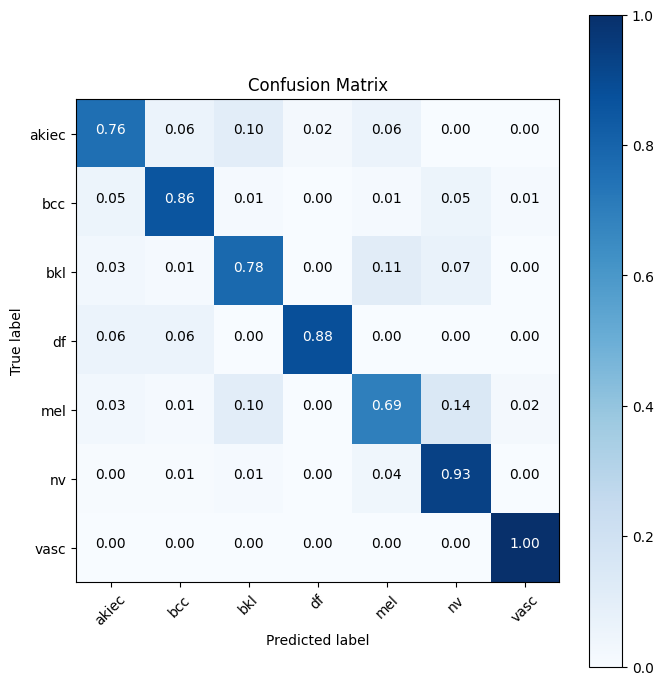

In [223]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(ground_truths, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [ ]:
# TODO: model 4: BKL <> MEL --> will improve. around 20%

In [225]:
#################################################
### max only predicted label wrong : bcc + nv ###
#################################################
first_model_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
second_model_mapping = {'mel': 0, 'nv': 1}  #nv
third_model_mapping = {'akiec': 0, 'bcc': 1}  #bcc
class_mapping_2 = get_class_mapping(first_model_mapping, second_model_mapping)
class_mapping_3 = get_class_mapping(first_model_mapping, third_model_mapping)


# The updated predict function:
def predict(instance, model_1, model_2, model_3, class_mapping_2, class_mapping_3):
    prediction_1 = model_1.predict(instance, verbose=0)
    class_pred_1 = np.argmax(prediction_1)
    percent_1 = prediction_1[0, class_pred_1]

    # Store models and mappings in list for easier iteration
    models = [model_2, model_3]
    mappings = [class_mapping_2, class_mapping_3]
    # Indices to match the conditions in the original function
    indices = [(5,), (1,)]

    for index, model, mapping in zip(indices, models, mappings):
        if class_pred_1 in index:
            prediction = model.predict(instance, verbose=0)
            class_pred = np.argmax(prediction)
            class_pred_mapped = mapping.get(class_pred, class_pred)
            percent = prediction[0, class_pred]

            print(
                f'model 1: {class_pred_1} ({percent_1 * 100:.2f}%) VS. model {models.index(model) + 2}: {class_pred_mapped} ({percent * 100:.2f}%)')

            return class_pred_1 if percent_1 > percent else class_pred_mapped
    return class_pred_1


predictions = []
ground_truths = []

with tqdm(total=total) as pbar:
    for i in range(len(test_image_gen)):
        X, y_true = test_image_gen[i]
        actual_batch_size = X.shape[0]  # calculate the actual batch size

        for j in range(actual_batch_size):  # iterate over the batch
            try:
                instance = X[j]
                filename = test_image_gen.filenames[i * actual_batch_size + j]
                ground_truth = y_true[j]  # get the ground truth label
                ground_truth = np.argmax(ground_truth)  # from one-hot to class index
                ground_truths.append(ground_truth)
                prediction = predict(np.expand_dims(instance, axis=0), model, second_model, third_model,
                                     class_mapping_2, class_mapping_3)
                print(f"Image: {filename}, Prediction: {prediction}, Ground Truth: {ground_truth}")
                predictions.append(prediction)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

            pbar.update()  # update progress bar

  0%|          | 3/1536 [00:01<10:16,  2.49it/s]

Image: akiec/ISIC_0024329.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024372.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024418.jpg, Prediction: 4, Ground Truth: 0
Image: akiec/ISIC_0024450.jpg, Prediction: 0, Ground Truth: 0


  0%|          | 7/1536 [00:01<04:03,  6.29it/s]

Image: akiec/ISIC_0024463.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024468.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024470.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024511.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 11/1536 [00:02<02:55,  8.67it/s]

model 1: 1 (92.82%) VS. model 3: 1 (99.99%)
Image: akiec/ISIC_0024517.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024522.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024539.jpg, Prediction: 2, Ground Truth: 0


  1%|          | 13/1536 [00:02<03:01,  8.41it/s]

model 1: 1 (80.49%) VS. model 3: 1 (99.96%)
Image: akiec/ISIC_0024562.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024575.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024579.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 17/1536 [00:02<02:29, 10.17it/s]

Image: akiec/ISIC_0024646.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024654.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0024707.jpg, Prediction: 2, Ground Truth: 0


  1%|          | 19/1536 [00:02<02:32,  9.93it/s]

model 1: 1 (87.73%) VS. model 3: 1 (74.97%)
Image: akiec/ISIC_0024710.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024763.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024771.jpg, Prediction: 0, Ground Truth: 0


  1%|▏         | 23/1536 [00:03<02:20, 10.76it/s]

Image: akiec/ISIC_0024800.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0024843.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (98.76%) VS. model 3: 1 (98.66%)
Image: akiec/ISIC_0024913.jpg, Prediction: 1, Ground Truth: 0


  2%|▏         | 27/1536 [00:03<01:55, 13.03it/s]

Image: akiec/ISIC_0024923.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024925.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024946.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024948.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 31/1536 [00:03<01:45, 14.22it/s]

Image: akiec/ISIC_0025029.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025069.jpg, Prediction: 4, Ground Truth: 0
Image: akiec/ISIC_0025089.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025130.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 35/1536 [00:03<01:40, 14.89it/s]

Image: akiec/ISIC_0025178.jpg, Prediction: 3, Ground Truth: 0
Image: akiec/ISIC_0025182.jpg, Prediction: 3, Ground Truth: 0
Image: akiec/ISIC_0025196.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025247.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 37/1536 [00:04<01:41, 14.83it/s]

Image: akiec/ISIC_0025264.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0025319.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025331.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 41/1536 [00:04<01:45, 14.13it/s]

model 1: 1 (59.27%) VS. model 3: 0 (94.35%)
Image: akiec/ISIC_0025350.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025358.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025368.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025411.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 45/1536 [00:04<01:40, 14.89it/s]

Image: akiec/ISIC_0025427.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025471.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025539.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025577.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 49/1536 [00:05<01:51, 13.38it/s]

model 1: 5 (57.39%) VS. model 2: 5 (68.96%)
Image: akiec/ISIC_0025605.jpg, Prediction: 5, Ground Truth: 0
Image: akiec/ISIC_0025637.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0025696.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 51/1536 [00:05<02:20, 10.54it/s]

model 1: 1 (99.87%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024331.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (73.77%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024332.jpg, Prediction: 1, Ground Truth: 1


  3%|▎         | 53/1536 [00:05<02:34,  9.62it/s]

model 1: 1 (99.97%) VS. model 3: 1 (94.24%)
Image: bcc/ISIC_0024345.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.84%)
Image: bcc/ISIC_0024360.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 55/1536 [00:05<02:48,  8.81it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.23%)
Image: bcc/ISIC_0024403.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (67.67%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024411.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 57/1536 [00:06<02:47,  8.82it/s]

Image: bcc/ISIC_0024431.jpg, Prediction: 4, Ground Truth: 1
model 1: 5 (50.15%) VS. model 2: 5 (99.80%)
Image: bcc/ISIC_0024432.jpg, Prediction: 5, Ground Truth: 1


  4%|▍         | 59/1536 [00:06<02:55,  8.42it/s]

model 1: 1 (99.97%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024436.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.71%)
Image: bcc/ISIC_0024443.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 61/1536 [00:06<03:13,  7.61it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024448.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024452.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 63/1536 [00:06<03:41,  6.65it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024454.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.83%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0024457.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 64/1536 [00:07<03:58,  6.17it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024461.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 66/1536 [00:09<11:53,  2.06it/s]

model 1: 1 (99.98%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024472.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.92%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024504.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 68/1536 [00:09<07:52,  3.11it/s]

Image: bcc/ISIC_0024515.jpg, Prediction: 4, Ground Truth: 1
model 1: 1 (99.93%) VS. model 3: 1 (99.83%)
Image: bcc/ISIC_0024550.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 70/1536 [00:09<05:43,  4.27it/s]

model 1: 1 (99.93%) VS. model 3: 1 (99.21%)
Image: bcc/ISIC_0024564.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.66%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0024572.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 72/1536 [00:09<04:39,  5.24it/s]

model 1: 1 (98.34%) VS. model 3: 1 (97.98%)
Image: bcc/ISIC_0024573.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024582.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 73/1536 [00:09<04:17,  5.69it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024590.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 74/1536 [00:10<04:43,  5.16it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024595.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 75/1536 [00:10<05:37,  4.33it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024632.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 77/1536 [00:10<05:10,  4.70it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024634.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.80%) VS. model 3: 1 (87.10%)
Image: bcc/ISIC_0024665.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0024666.jpg, Prediction: 0, Ground Truth: 1


  5%|▌         | 80/1536 [00:11<03:42,  6.55it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.86%)
Image: bcc/ISIC_0024673.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.02%)
Image: bcc/ISIC_0024743.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 82/1536 [00:11<03:27,  7.02it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024787.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (85.15%) VS. model 3: 1 (94.96%)
Image: bcc/ISIC_0024795.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 84/1536 [00:11<03:21,  7.20it/s]

model 1: 1 (99.91%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024799.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024829.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 86/1536 [00:12<03:17,  7.32it/s]

model 1: 1 (99.31%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024833.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024848.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 88/1536 [00:12<03:14,  7.45it/s]

model 1: 1 (99.82%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024885.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.72%)
Image: bcc/ISIC_0024897.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 90/1536 [00:12<03:17,  7.32it/s]

model 1: 1 (88.85%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024931.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (98.92%)
Image: bcc/ISIC_0024949.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 92/1536 [00:12<03:31,  6.84it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024984.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (98.84%) VS. model 3: 0 (72.20%)
Image: bcc/ISIC_0025019.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 94/1536 [00:13<03:13,  7.44it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025031.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (57.34%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025046.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 96/1536 [00:13<03:21,  7.15it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025102.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.85%)
Image: bcc/ISIC_0025144.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 98/1536 [00:13<03:17,  7.26it/s]

model 1: 1 (95.13%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025260.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.88%) VS. model 3: 1 (99.72%)
Image: bcc/ISIC_0025266.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 100/1536 [00:14<03:20,  7.17it/s]

model 1: 1 (99.95%) VS. model 3: 1 (88.27%)
Image: bcc/ISIC_0025285.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025299.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 102/1536 [00:14<03:11,  7.50it/s]

model 1: 1 (96.80%) VS. model 3: 1 (99.91%)
Image: bcc/ISIC_0025301.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.04%) VS. model 3: 1 (98.38%)
Image: bcc/ISIC_0025322.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 104/1536 [00:14<03:05,  7.71it/s]

model 1: 1 (99.83%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0025362.jpg, Prediction: 1, Ground Truth: 1
model 1: 5 (74.55%) VS. model 2: 5 (99.88%)
Image: bcc/ISIC_0025383.jpg, Prediction: 5, Ground Truth: 1


  7%|▋         | 106/1536 [00:14<03:18,  7.21it/s]

model 1: 1 (100.00%) VS. model 3: 1 (90.66%)
Image: bcc/ISIC_0025417.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (94.49%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025433.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 108/1536 [00:15<03:12,  7.40it/s]

model 1: 1 (99.95%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025467.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025509.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 110/1536 [00:15<03:09,  7.54it/s]

model 1: 5 (85.83%) VS. model 2: 5 (99.93%)
Image: bcc/ISIC_0025513.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (98.59%) VS. model 3: 1 (99.47%)
Image: bcc/ISIC_0025530.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 113/1536 [00:15<02:43,  8.72it/s]

model 1: 1 (87.61%) VS. model 3: 1 (95.47%)
Image: bcc/ISIC_0025557.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025564.jpg, Prediction: 2, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025576.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 115/1536 [00:15<02:57,  7.99it/s]

model 1: 1 (83.03%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0025584.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025600.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 117/1536 [00:16<03:12,  7.39it/s]

model 1: 1 (97.57%) VS. model 3: 1 (99.52%)
Image: bcc/ISIC_0025601.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (53.97%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025617.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 119/1536 [00:16<03:23,  6.96it/s]

model 1: 1 (73.02%) VS. model 3: 1 (99.50%)
Image: bcc/ISIC_0025630.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025644.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 121/1536 [00:16<03:40,  6.41it/s]

model 1: 1 (99.98%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025650.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (47.08%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025691.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 123/1536 [00:17<03:04,  7.66it/s]

Image: bcc/ISIC_0025700.jpg, Prediction: 2, Ground Truth: 1
model 1: 1 (60.84%) VS. model 3: 1 (99.78%)
Image: bcc/ISIC_0025711.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 125/1536 [00:17<03:14,  7.26it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025718.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.95%) VS. model 3: 1 (99.58%)
Image: bcc/ISIC_0025731.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 128/1536 [00:17<02:30,  9.37it/s]

model 1: 1 (68.38%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025752.jpg, Prediction: 1, Ground Truth: 1
Image: bkl/ISIC_0024312.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024324.jpg, Prediction: 2, Ground Truth: 2


  9%|▊         | 131/1536 [00:19<06:24,  3.66it/s]

Image: bkl/ISIC_0024336.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024338.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024358.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 135/1536 [00:19<03:35,  6.51it/s]

Image: bkl/ISIC_0024371.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0024381.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024382.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 137/1536 [00:19<02:57,  7.89it/s]

Image: bkl/ISIC_0024383.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024408.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024409.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 139/1536 [00:19<03:05,  7.52it/s]

model 1: 1 (56.27%) VS. model 3: 1 (87.07%)
Image: bkl/ISIC_0024412.jpg, Prediction: 1, Ground Truth: 2


  9%|▉         | 142/1536 [00:21<05:35,  4.15it/s]

Image: bkl/ISIC_0024420.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024422.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0024426.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 144/1536 [00:21<04:20,  5.34it/s]

Image: bkl/ISIC_0024435.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024445.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 146/1536 [00:21<03:36,  6.42it/s]

Image: bkl/ISIC_0024446.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024453.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 148/1536 [00:21<02:51,  8.11it/s]

Image: bkl/ISIC_0024471.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024477.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024489.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 150/1536 [00:21<02:31,  9.15it/s]

Image: bkl/ISIC_0024490.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024494.jpg, Prediction: 4, Ground Truth: 2


 10%|█         | 154/1536 [00:22<02:18,  9.98it/s]

model 1: 5 (66.13%) VS. model 2: 4 (70.52%)
Image: bkl/ISIC_0024495.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024498.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024505.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 156/1536 [00:22<02:07, 10.79it/s]

Image: bkl/ISIC_0024547.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024581.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024592.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 160/1536 [00:22<01:57, 11.69it/s]

Image: bkl/ISIC_0024602.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024612.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024623.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 162/1536 [00:22<01:53, 12.11it/s]

Image: bkl/ISIC_0024626.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024635.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024643.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 166/1536 [00:23<01:50, 12.42it/s]

Image: bkl/ISIC_0024672.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024676.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024696.jpg, Prediction: 4, Ground Truth: 2


 11%|█         | 168/1536 [00:23<01:50, 12.40it/s]

Image: bkl/ISIC_0024705.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024708.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024709.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 172/1536 [00:23<01:53, 12.06it/s]

Image: bkl/ISIC_0024711.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024726.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024740.jpg, Prediction: 2, Ground Truth: 2


 11%|█▏        | 174/1536 [00:24<02:11, 10.32it/s]

Image: bkl/ISIC_0024741.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (92.80%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0024748.jpg, Prediction: 5, Ground Truth: 2


 11%|█▏        | 176/1536 [00:24<02:08, 10.59it/s]

Image: bkl/ISIC_0024758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024760.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024761.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 180/1536 [00:24<01:59, 11.32it/s]

Image: bkl/ISIC_0024770.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024772.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024773.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 182/1536 [00:24<01:55, 11.75it/s]

Image: bkl/ISIC_0024774.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024782.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024786.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 186/1536 [00:25<01:53, 11.89it/s]

Image: bkl/ISIC_0024814.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024825.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024832.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 188/1536 [00:25<01:48, 12.40it/s]

Image: bkl/ISIC_0024839.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024850.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024851.jpg, Prediction: 4, Ground Truth: 2


 12%|█▎        | 192/1536 [00:25<01:48, 12.44it/s]

Image: bkl/ISIC_0024871.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024877.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024880.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 194/1536 [00:27<08:14,  2.71it/s]

Image: bkl/ISIC_0024881.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (98.82%) VS. model 2: 5 (99.97%)
Image: bkl/ISIC_0024883.jpg, Prediction: 5, Ground Truth: 2


 13%|█▎        | 196/1536 [00:27<06:17,  3.55it/s]

Image: bkl/ISIC_0024890.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024893.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024909.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 200/1536 [00:28<04:07,  5.39it/s]

Image: bkl/ISIC_0024910.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024915.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024943.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 202/1536 [00:28<03:24,  6.52it/s]

Image: bkl/ISIC_0024947.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024970.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024971.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 206/1536 [00:28<02:32,  8.72it/s]

Image: bkl/ISIC_0024981.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024982.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024997.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 208/1536 [00:28<02:18,  9.59it/s]

Image: bkl/ISIC_0025005.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025016.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025030.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 210/1536 [00:28<02:08, 10.34it/s]

Image: bkl/ISIC_0025032.jpg, Prediction: 2, Ground Truth: 2
model 1: 1 (83.72%) VS. model 3: 1 (87.90%)
Image: bkl/ISIC_0025033.jpg, Prediction: 1, Ground Truth: 2


 14%|█▍        | 212/1536 [00:29<02:15,  9.75it/s]

Image: bkl/ISIC_0025038.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (95.57%) VS. model 2: 5 (99.74%)
Image: bkl/ISIC_0025040.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 214/1536 [00:29<02:21,  9.36it/s]

Image: bkl/ISIC_0025063.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (80.03%) VS. model 2: 5 (93.34%)
Image: bkl/ISIC_0025064.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 218/1536 [00:29<02:12,  9.93it/s]

Image: bkl/ISIC_0025066.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025068.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025075.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 220/1536 [00:30<02:36,  8.41it/s]

model 1: 5 (97.29%) VS. model 2: 4 (67.18%)
Image: bkl/ISIC_0025076.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025083.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 222/1536 [00:30<02:34,  8.51it/s]

Image: bkl/ISIC_0025086.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025099.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025103.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 224/1536 [00:30<02:29,  8.78it/s]

Image: bkl/ISIC_0025113.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025131.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 227/1536 [00:30<02:39,  8.22it/s]

model 1: 5 (50.76%) VS. model 2: 5 (63.41%)
Image: bkl/ISIC_0025136.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025140.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 229/1536 [00:31<02:33,  8.52it/s]

Image: bkl/ISIC_0025157.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025180.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 232/1536 [00:31<02:12,  9.84it/s]

Image: bkl/ISIC_0025199.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025209.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025222.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 234/1536 [00:31<01:59, 10.86it/s]

Image: bkl/ISIC_0025275.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025276.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 236/1536 [00:31<02:11,  9.92it/s]

model 1: 5 (61.38%) VS. model 2: 5 (62.94%)
Image: bkl/ISIC_0025286.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025292.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025297.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 240/1536 [00:32<01:54, 11.29it/s]

Image: bkl/ISIC_0025312.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025326.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025330.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 242/1536 [00:32<01:50, 11.72it/s]

Image: bkl/ISIC_0025337.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025339.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025345.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 244/1536 [00:32<01:48, 11.95it/s]

Image: bkl/ISIC_0025351.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (99.44%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0025366.jpg, Prediction: 5, Ground Truth: 2


 16%|█▌        | 248/1536 [00:32<01:57, 10.99it/s]

Image: bkl/ISIC_0025374.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025376.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025378.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 250/1536 [00:33<01:51, 11.51it/s]

Image: bkl/ISIC_0025387.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025388.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025389.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 252/1536 [00:33<01:48, 11.86it/s]

Image: bkl/ISIC_0025392.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (50.19%) VS. model 2: 4 (92.28%)
Image: bkl/ISIC_0025419.jpg, Prediction: 4, Ground Truth: 2


 17%|█▋        | 256/1536 [00:33<01:52, 11.42it/s]

Image: bkl/ISIC_0025431.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025434.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025454.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 258/1536 [00:35<06:13,  3.42it/s]

Image: bkl/ISIC_0025465.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025466.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025470.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 262/1536 [00:35<03:49,  5.56it/s]

Image: bkl/ISIC_0025484.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025485.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025507.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 266/1536 [00:35<02:35,  8.18it/s]

Image: bkl/ISIC_0025510.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025515.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025519.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025526.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 268/1536 [00:35<02:13,  9.52it/s]

Image: bkl/ISIC_0025529.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025548.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025554.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 272/1536 [00:36<01:49, 11.53it/s]

Image: bkl/ISIC_0025567.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025575.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025583.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025623.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 276/1536 [00:36<01:35, 13.25it/s]

Image: bkl/ISIC_0025627.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025642.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025654.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025656.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 280/1536 [00:36<01:30, 13.81it/s]

Image: bkl/ISIC_0025659.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025661.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025693.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 284/1536 [00:36<01:24, 14.80it/s]

Image: bkl/ISIC_0025699.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025703.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025710.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025716.jpg, Prediction: 4, Ground Truth: 2


 19%|█▊        | 286/1536 [00:36<01:23, 14.97it/s]

Image: bkl/ISIC_0025719.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025743.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025746.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 290/1536 [00:37<01:24, 14.71it/s]

Image: bkl/ISIC_0025753.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025758.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025767.jpg, Prediction: 2, Ground Truth: 2
Image: df/ISIC_0024318.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 294/1536 [00:37<01:20, 15.46it/s]

Image: df/ISIC_0024330.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024386.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024396.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024553.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 298/1536 [00:37<01:19, 15.57it/s]

Image: df/ISIC_0024845.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024973.jpg, Prediction: 4, Ground Truth: 3
Image: df/ISIC_0024994.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025154.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 302/1536 [00:37<01:17, 15.98it/s]

Image: df/ISIC_0025223.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025302.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025314.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025373.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 306/1536 [00:38<01:17, 15.85it/s]

Image: df/ISIC_0025504.jpg, Prediction: 0, Ground Truth: 3
Image: df/ISIC_0025594.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025622.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025668.jpg, Prediction: 3, Ground Truth: 3


 20%|██        | 310/1536 [00:38<01:29, 13.63it/s]

Image: mel/ISIC_0024310.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (77.15%) VS. model 2: 5 (94.58%)
Image: mel/ISIC_0024313.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024315.jpg, Prediction: 4, Ground Truth: 4


 20%|██        | 314/1536 [00:38<01:24, 14.44it/s]

Image: mel/ISIC_0024323.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024333.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024351.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024367.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 316/1536 [00:39<01:32, 13.13it/s]

Image: mel/ISIC_0024400.jpg, Prediction: 2, Ground Truth: 4
model 1: 5 (49.25%) VS. model 2: 4 (57.51%)
Image: mel/ISIC_0024410.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024449.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 320/1536 [00:39<01:22, 14.73it/s]

Image: mel/ISIC_0024459.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024481.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024482.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 324/1536 [00:40<04:15,  4.73it/s]

Image: mel/ISIC_0024496.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024516.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024525.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024537.jpg, Prediction: 4, Ground Truth: 4


 21%|██▏       | 328/1536 [00:41<02:43,  7.38it/s]

Image: mel/ISIC_0024545.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024546.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024552.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024554.jpg, Prediction: 2, Ground Truth: 4


 21%|██▏       | 330/1536 [00:41<02:29,  8.06it/s]

Image: mel/ISIC_0024571.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (96.21%) VS. model 2: 5 (99.66%)
Image: mel/ISIC_0024586.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024624.jpg, Prediction: 2, Ground Truth: 4


 22%|██▏       | 334/1536 [00:41<01:51, 10.76it/s]

Image: mel/ISIC_0024630.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024640.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024644.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024647.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 338/1536 [00:41<01:45, 11.36it/s]

Image: mel/ISIC_0024652.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (50.57%) VS. model 2: 5 (96.11%)
Image: mel/ISIC_0024675.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024679.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 342/1536 [00:42<01:29, 13.36it/s]

Image: mel/ISIC_0024688.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024700.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024701.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024702.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 344/1536 [00:42<01:35, 12.54it/s]

Image: mel/ISIC_0024729.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (85.44%) VS. model 2: 4 (98.43%)
Image: mel/ISIC_0024732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024733.jpg, Prediction: 2, Ground Truth: 4


 23%|██▎       | 348/1536 [00:42<01:25, 13.84it/s]

Image: mel/ISIC_0024739.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024756.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0024767.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024792.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 352/1536 [00:42<01:18, 14.99it/s]

Image: mel/ISIC_0024805.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024806.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024823.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024853.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 356/1536 [00:43<01:35, 12.35it/s]

model 1: 5 (73.36%) VS. model 2: 5 (98.09%)
Image: mel/ISIC_0024864.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024865.jpg, Prediction: 4, Ground Truth: 4
model 1: 1 (89.19%) VS. model 3: 1 (94.35%)
Image: mel/ISIC_0024875.jpg, Prediction: 1, Ground Truth: 4


 23%|██▎       | 358/1536 [00:43<01:41, 11.62it/s]

Image: mel/ISIC_0024886.jpg, Prediction: 2, Ground Truth: 4
model 1: 5 (99.50%) VS. model 2: 5 (96.63%)
Image: mel/ISIC_0024898.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024900.jpg, Prediction: 2, Ground Truth: 4


 23%|██▎       | 360/1536 [00:43<01:36, 12.15it/s]

Image: mel/ISIC_0024911.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (79.95%) VS. model 2: 5 (69.34%)
Image: mel/ISIC_0024918.jpg, Prediction: 5, Ground Truth: 4


 24%|██▎       | 364/1536 [00:43<01:47, 10.92it/s]

Image: mel/ISIC_0024929.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (85.21%) VS. model 2: 5 (85.25%)
Image: mel/ISIC_0024930.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024932.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 366/1536 [00:44<01:41, 11.53it/s]

Image: mel/ISIC_0024940.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0024951.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024952.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 370/1536 [00:44<01:34, 12.31it/s]

Image: mel/ISIC_0024958.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024961.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024962.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 372/1536 [00:44<01:28, 13.20it/s]

Image: mel/ISIC_0024967.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024972.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (41.93%) VS. model 2: 5 (86.07%)
Image: mel/ISIC_0024987.jpg, Prediction: 5, Ground Truth: 4


 24%|██▍       | 374/1536 [00:44<01:34, 12.35it/s]

Image: mel/ISIC_0024999.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (92.21%) VS. model 2: 5 (97.75%)
Image: mel/ISIC_0025018.jpg, Prediction: 5, Ground Truth: 4


 25%|██▍       | 378/1536 [00:45<01:40, 11.53it/s]

Image: mel/ISIC_0025035.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025081.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025085.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 382/1536 [00:45<01:27, 13.13it/s]

Image: mel/ISIC_0025097.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025121.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025127.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 384/1536 [00:45<01:28, 13.09it/s]

Image: mel/ISIC_0025128.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025132.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 386/1536 [00:47<05:59,  3.20it/s]

Image: mel/ISIC_0025145.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (94.74%) VS. model 2: 5 (99.38%)
Image: mel/ISIC_0025153.jpg, Prediction: 5, Ground Truth: 4


 25%|██▌       | 388/1536 [00:47<04:38,  4.12it/s]

Image: mel/ISIC_0025155.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025188.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025195.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 392/1536 [00:47<03:02,  6.26it/s]

Image: mel/ISIC_0025219.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025234.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025235.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 394/1536 [00:47<02:29,  7.64it/s]

Image: mel/ISIC_0025238.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025248.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (64.83%) VS. model 2: 5 (55.90%)
Image: mel/ISIC_0025265.jpg, Prediction: 5, Ground Truth: 4


 26%|██▌       | 398/1536 [00:48<01:58,  9.57it/s]

Image: mel/ISIC_0025268.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025277.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025303.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 400/1536 [00:48<02:08,  8.85it/s]

model 1: 5 (98.61%) VS. model 2: 5 (97.81%)
Image: mel/ISIC_0025313.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (54.98%) VS. model 2: 5 (99.97%)
Image: mel/ISIC_0025316.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025317.jpg, Prediction: 4, Ground Truth: 4


 26%|██▋       | 404/1536 [00:48<01:47, 10.50it/s]

model 1: 5 (92.98%) VS. model 2: 5 (99.99%)
Image: mel/ISIC_0025324.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025363.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025391.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 408/1536 [00:49<01:39, 11.31it/s]

model 1: 5 (99.00%) VS. model 2: 5 (99.99%)
Image: mel/ISIC_0025394.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025409.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025413.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025414.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 410/1536 [00:49<01:43, 10.89it/s]

Image: mel/ISIC_0025439.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (98.92%) VS. model 2: 5 (99.91%)
Image: mel/ISIC_0025450.jpg, Prediction: 5, Ground Truth: 4


 27%|██▋       | 412/1536 [00:49<01:58,  9.47it/s]

model 1: 5 (95.92%) VS. model 2: 5 (95.25%)
Image: mel/ISIC_0025451.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (61.86%) VS. model 2: 4 (56.99%)
Image: mel/ISIC_0025472.jpg, Prediction: 5, Ground Truth: 4


 27%|██▋       | 416/1536 [00:49<01:36, 11.63it/s]

Image: mel/ISIC_0025489.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025500.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025512.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025520.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 420/1536 [00:50<01:23, 13.37it/s]

Image: mel/ISIC_0025524.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025531.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025543.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025546.jpg, Prediction: 2, Ground Truth: 4


 27%|██▋       | 422/1536 [00:50<01:28, 12.66it/s]

model 1: 5 (71.12%) VS. model 2: 5 (99.55%)
Image: mel/ISIC_0025550.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025573.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025589.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 426/1536 [00:50<01:27, 12.63it/s]

model 1: 5 (63.70%) VS. model 2: 4 (64.35%)
Image: mel/ISIC_0025592.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025603.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025611.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 430/1536 [00:50<01:19, 13.84it/s]

Image: mel/ISIC_0025616.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025651.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025663.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025674.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 432/1536 [00:51<01:19, 13.95it/s]

Image: mel/ISIC_0025708.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025709.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 434/1536 [00:51<01:35, 11.59it/s]

model 1: 5 (96.33%) VS. model 2: 4 (79.96%)
Image: mel/ISIC_0025724.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025744.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 438/1536 [00:51<01:27, 12.56it/s]

Image: mel/ISIC_0025748.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025751.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025755.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 440/1536 [00:51<01:34, 11.60it/s]

Image: mel/ISIC_0025766.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.68%) VS. model 2: 5 (99.86%)
Image: mel/ISIC_0025783.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 442/1536 [00:52<01:44, 10.48it/s]

model 1: 5 (87.27%) VS. model 2: 5 (96.69%)
Image: mel/ISIC_0025791.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025800.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025814.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 444/1536 [00:52<01:44, 10.46it/s]

model 1: 5 (42.13%) VS. model 2: 4 (58.08%)
Image: mel/ISIC_0025832.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025835.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 448/1536 [00:52<01:39, 10.94it/s]

model 1: 5 (86.33%) VS. model 2: 5 (93.96%)
Image: mel/ISIC_0025891.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025904.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025927.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 452/1536 [00:54<04:14,  4.26it/s]

Image: mel/ISIC_0025941.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025955.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025963.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025964.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 454/1536 [00:54<03:32,  5.09it/s]

model 1: 5 (52.25%) VS. model 2: 4 (51.86%)
Image: mel/ISIC_0025987.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025996.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026009.jpg, Prediction: 2, Ground Truth: 4


 30%|██▉       | 456/1536 [00:54<02:56,  6.12it/s]

Image: mel/ISIC_0026045.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026081.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 458/1536 [00:54<02:36,  6.88it/s]

Image: mel/ISIC_0026086.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 460/1536 [00:55<02:50,  6.30it/s]

model 1: 5 (99.28%) VS. model 2: 5 (83.69%)
Image: mel/ISIC_0026089.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (74.46%) VS. model 2: 5 (70.40%)
Image: mel/ISIC_0026094.jpg, Prediction: 5, Ground Truth: 4


 30%|███       | 462/1536 [00:55<02:33,  6.98it/s]

Image: mel/ISIC_0026105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026113.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 464/1536 [00:55<02:27,  7.28it/s]

Image: mel/ISIC_0026115.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026120.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 466/1536 [00:56<02:18,  7.75it/s]

Image: mel/ISIC_0026131.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026150.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 467/1536 [00:56<02:30,  7.11it/s]

model 1: 1 (98.78%) VS. model 3: 1 (100.00%)
Image: mel/ISIC_0026158.jpg, Prediction: 1, Ground Truth: 4


 31%|███       | 470/1536 [00:56<02:10,  8.14it/s]

model 1: 5 (52.87%) VS. model 2: 4 (95.15%)
Image: mel/ISIC_0026167.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026188.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026207.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 472/1536 [00:56<01:52,  9.46it/s]

Image: mel/ISIC_0026229.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026236.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026239.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 475/1536 [00:57<02:07,  8.30it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024307.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 477/1536 [00:57<02:18,  7.65it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.42%)
Image: nv/ISIC_0024308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024309.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 478/1536 [00:57<02:17,  7.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.49%)
Image: nv/ISIC_0024311.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024314.jpg, Prediction: 2, Ground Truth: 5


 31%|███▏      | 481/1536 [00:57<02:19,  7.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024316.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.01%) VS. model 2: 5 (99.43%)
Image: nv/ISIC_0024317.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 483/1536 [00:58<02:44,  6.39it/s]

model 1: 5 (99.67%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024319.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024320.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 485/1536 [00:58<02:58,  5.89it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024321.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024322.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 487/1536 [00:58<02:47,  6.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024325.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024326.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 489/1536 [00:59<02:58,  5.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024327.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.40%) VS. model 2: 5 (98.06%)
Image: nv/ISIC_0024328.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 491/1536 [00:59<03:03,  5.70it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024334.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024335.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 493/1536 [01:00<03:15,  5.33it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024339.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024340.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 495/1536 [01:00<03:14,  5.36it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024341.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.05%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0024342.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 496/1536 [01:00<03:10,  5.46it/s]

model 1: 5 (93.54%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024343.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024344.jpg, Prediction: 4, Ground Truth: 5


 32%|███▏      | 499/1536 [01:01<02:35,  6.65it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024346.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.23%) VS. model 2: 5 (99.24%)
Image: nv/ISIC_0024347.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 501/1536 [01:01<02:22,  7.25it/s]

model 1: 5 (97.12%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024348.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.36%) VS. model 2: 5 (87.32%)
Image: nv/ISIC_0024349.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 503/1536 [01:01<02:18,  7.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024350.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.56%) VS. model 2: 5 (99.32%)
Image: nv/ISIC_0024352.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 505/1536 [01:01<02:13,  7.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024353.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024354.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 507/1536 [01:02<02:14,  7.62it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024355.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.17%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024356.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 509/1536 [01:02<02:11,  7.82it/s]

model 1: 5 (73.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024357.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024359.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 511/1536 [01:02<02:10,  7.85it/s]

model 1: 5 (97.76%) VS. model 2: 5 (98.26%)
Image: nv/ISIC_0024361.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024362.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 512/1536 [01:02<02:14,  7.61it/s]

model 1: 5 (98.05%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024363.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 514/1536 [01:04<07:37,  2.24it/s]

model 1: 5 (70.10%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024365.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 516/1536 [01:04<05:08,  3.31it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024366.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024368.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 518/1536 [01:05<03:46,  4.50it/s]

model 1: 5 (88.66%) VS. model 2: 5 (98.88%)
Image: nv/ISIC_0024369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024373.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 520/1536 [01:05<02:55,  5.78it/s]

model 1: 5 (81.42%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024374.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.18%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024376.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 522/1536 [01:05<02:41,  6.27it/s]

model 1: 5 (79.18%) VS. model 2: 5 (96.46%)
Image: nv/ISIC_0024377.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.21%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024378.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 524/1536 [01:05<02:30,  6.71it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.27%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024380.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 526/1536 [01:06<02:25,  6.93it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024385.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 529/1536 [01:06<02:01,  8.30it/s]

model 1: 5 (88.67%) VS. model 2: 5 (97.46%)
Image: nv/ISIC_0024387.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024388.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024389.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 531/1536 [01:06<02:18,  7.25it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024390.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024391.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 533/1536 [01:07<02:21,  7.10it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024392.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024393.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 535/1536 [01:07<02:22,  7.01it/s]

model 1: 5 (99.43%) VS. model 2: 5 (95.79%)
Image: nv/ISIC_0024394.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024395.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 537/1536 [01:07<02:23,  6.96it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.59%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024398.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 539/1536 [01:07<02:24,  6.90it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024401.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 541/1536 [01:08<02:17,  7.24it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024404.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024405.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 543/1536 [01:08<02:15,  7.33it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024406.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024407.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 545/1536 [01:08<02:15,  7.31it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024413.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024414.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 547/1536 [01:09<02:17,  7.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024415.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (77.03%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024416.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 549/1536 [01:09<02:20,  7.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024417.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024419.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 551/1536 [01:09<02:23,  6.88it/s]

model 1: 5 (99.83%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024421.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024423.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 553/1536 [01:09<02:27,  6.66it/s]

model 1: 1 (92.33%) VS. model 3: 0 (92.88%)
Image: nv/ISIC_0024424.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (48.30%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024425.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 555/1536 [01:10<02:22,  6.88it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024427.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024428.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 557/1536 [01:10<02:21,  6.90it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024429.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024430.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 559/1536 [01:10<02:25,  6.71it/s]

model 1: 5 (98.60%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024433.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024434.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 561/1536 [01:11<02:30,  6.49it/s]

model 1: 5 (94.15%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024437.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024438.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 563/1536 [01:11<02:22,  6.83it/s]

model 1: 5 (98.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024439.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024440.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 565/1536 [01:11<02:25,  6.65it/s]

model 1: 5 (78.03%) VS. model 2: 5 (96.05%)
Image: nv/ISIC_0024441.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024442.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 567/1536 [01:12<02:36,  6.18it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024444.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.86%) VS. model 2: 5 (98.43%)
Image: nv/ISIC_0024447.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 569/1536 [01:12<02:33,  6.29it/s]

model 1: 5 (99.53%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024451.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024455.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 570/1536 [01:12<02:50,  5.65it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024456.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 572/1536 [01:13<03:02,  5.29it/s]

model 1: 5 (98.15%) VS. model 2: 4 (80.82%)
Image: nv/ISIC_0024458.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024460.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 574/1536 [01:13<02:57,  5.41it/s]

model 1: 5 (98.48%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024462.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.59%)
Image: nv/ISIC_0024464.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 575/1536 [01:13<02:55,  5.48it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024465.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024466.jpg, Prediction: 2, Ground Truth: 5


 38%|███▊      | 578/1536 [01:15<06:42,  2.38it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024467.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024469.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 580/1536 [01:15<04:33,  3.49it/s]

model 1: 5 (81.10%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024474.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 582/1536 [01:16<03:27,  4.59it/s]

model 1: 5 (86.90%) VS. model 2: 5 (99.57%)
Image: nv/ISIC_0024476.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.05%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0024478.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 583/1536 [01:16<03:04,  5.15it/s]

model 1: 5 (95.84%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0024479.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024480.jpg, Prediction: 2, Ground Truth: 5


 38%|███▊      | 585/1536 [01:16<02:33,  6.18it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024483.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 587/1536 [01:16<03:09,  5.02it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024484.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024485.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 589/1536 [01:17<03:02,  5.18it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024486.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024487.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 591/1536 [01:17<02:50,  5.53it/s]

model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024488.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.64%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024491.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 593/1536 [01:18<02:59,  5.27it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024492.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.74%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024493.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 594/1536 [01:18<02:56,  5.32it/s]

model 1: 5 (86.67%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024497.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 596/1536 [01:18<03:01,  5.19it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024499.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024500.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 598/1536 [01:18<02:40,  5.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024502.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 600/1536 [01:19<02:44,  5.69it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0024503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024506.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 602/1536 [01:19<02:45,  5.65it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024507.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024508.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 604/1536 [01:20<02:37,  5.90it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024509.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024510.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 606/1536 [01:20<02:37,  5.91it/s]

model 1: 5 (98.84%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024512.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024513.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 608/1536 [01:20<02:31,  6.12it/s]

Image: nv/ISIC_0024514.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (97.40%) VS. model 2: 5 (96.78%)
Image: nv/ISIC_0024518.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 610/1536 [01:20<02:08,  7.20it/s]

Image: nv/ISIC_0024519.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (97.77%) VS. model 2: 5 (99.60%)
Image: nv/ISIC_0024520.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 612/1536 [01:21<02:23,  6.45it/s]

model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024521.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024523.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 614/1536 [01:21<02:26,  6.28it/s]

model 1: 5 (86.06%) VS. model 2: 5 (99.49%)
Image: nv/ISIC_0024524.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024526.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 616/1536 [01:21<02:15,  6.78it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024527.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024528.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 618/1536 [01:22<02:08,  7.14it/s]

model 1: 5 (87.15%) VS. model 2: 5 (95.86%)
Image: nv/ISIC_0024529.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024530.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 620/1536 [01:22<02:05,  7.32it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024531.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024532.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 622/1536 [01:22<02:06,  7.25it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024533.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.68%) VS. model 2: 5 (99.43%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 624/1536 [01:22<02:03,  7.37it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 626/1536 [01:23<02:06,  7.20it/s]

model 1: 5 (96.34%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.01%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 628/1536 [01:23<02:02,  7.41it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024541.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024542.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 630/1536 [01:23<02:13,  6.77it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024543.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024544.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 632/1536 [01:24<02:29,  6.06it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024548.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024549.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 633/1536 [01:24<02:33,  5.89it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024551.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 635/1536 [01:24<02:46,  5.42it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024555.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024556.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 637/1536 [01:24<02:24,  6.21it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024557.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024558.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 639/1536 [01:25<02:20,  6.41it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0024559.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.77%) VS. model 2: 5 (98.92%)
Image: nv/ISIC_0024560.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 640/1536 [01:25<02:18,  6.49it/s]

model 1: 5 (97.20%) VS. model 2: 5 (98.54%)
Image: nv/ISIC_0024561.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 642/1536 [01:27<06:48,  2.19it/s]

model 1: 5 (99.61%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024565.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 644/1536 [01:27<04:19,  3.44it/s]

model 1: 1 (94.65%) VS. model 3: 1 (95.72%)
Image: nv/ISIC_0024566.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024567.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 646/1536 [01:27<03:04,  4.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024568.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024569.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 648/1536 [01:28<02:31,  5.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024570.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024574.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 650/1536 [01:28<02:12,  6.68it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024576.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.06%) VS. model 2: 5 (99.49%)
Image: nv/ISIC_0024577.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 652/1536 [01:28<02:05,  7.05it/s]

model 1: 5 (98.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024578.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024580.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 654/1536 [01:28<01:59,  7.39it/s]

model 1: 5 (99.84%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024583.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.12%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024584.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 656/1536 [01:29<01:57,  7.46it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (77.34%) VS. model 2: 5 (78.95%)
Image: nv/ISIC_0024587.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 658/1536 [01:29<01:56,  7.55it/s]

model 1: 5 (98.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024588.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024589.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 660/1536 [01:29<01:52,  7.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024591.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.41%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024593.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 662/1536 [01:29<01:55,  7.54it/s]

model 1: 5 (97.17%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0024594.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.92%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0024596.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 664/1536 [01:30<01:54,  7.59it/s]

model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024597.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024598.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 666/1536 [01:30<01:54,  7.58it/s]

model 1: 5 (98.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024599.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024600.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 668/1536 [01:30<01:54,  7.57it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024601.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024603.jpg, Prediction: 5, Ground Truth: 5


 44%|████▎     | 670/1536 [01:30<01:55,  7.49it/s]

model 1: 5 (83.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024605.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 672/1536 [01:31<01:53,  7.59it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024606.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024607.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024608.jpg, Prediction: 4, Ground Truth: 5


 44%|████▍     | 675/1536 [01:31<01:44,  8.26it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024609.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024610.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 677/1536 [01:31<01:48,  7.94it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024611.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024613.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 678/1536 [01:31<01:48,  7.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024614.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024615.jpg, Prediction: 4, Ground Truth: 5


 44%|████▍     | 681/1536 [01:32<01:44,  8.21it/s]

model 1: 5 (96.09%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024616.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.13%) VS. model 2: 4 (65.66%)
Image: nv/ISIC_0024617.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 683/1536 [01:32<01:47,  7.97it/s]

model 1: 5 (97.67%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024618.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024619.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 685/1536 [01:32<01:50,  7.67it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0024620.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024621.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 687/1536 [01:33<01:51,  7.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024622.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024625.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 689/1536 [01:33<01:50,  7.70it/s]

model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024627.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024628.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 691/1536 [01:33<01:45,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.39%)
Image: nv/ISIC_0024629.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024631.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 693/1536 [01:33<01:47,  7.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024636.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 695/1536 [01:34<01:47,  7.85it/s]

model 1: 5 (99.74%) VS. model 2: 5 (99.33%)
Image: nv/ISIC_0024637.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024638.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 697/1536 [01:34<01:48,  7.72it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024639.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024641.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 699/1536 [01:34<01:47,  7.81it/s]

model 1: 5 (97.26%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024642.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024645.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 701/1536 [01:34<01:44,  7.98it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024648.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024649.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 703/1536 [01:35<01:59,  6.99it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024650.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024651.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 704/1536 [01:35<02:04,  6.68it/s]

model 1: 5 (97.10%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024653.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 706/1536 [01:37<07:39,  1.81it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024656.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 708/1536 [01:37<05:02,  2.73it/s]

model 1: 5 (49.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024658.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 710/1536 [01:38<03:44,  3.69it/s]

model 1: 5 (99.74%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024659.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024660.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 712/1536 [01:38<03:09,  4.34it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024661.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024663.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 714/1536 [01:38<02:37,  5.21it/s]

model 1: 5 (87.20%) VS. model 2: 5 (83.10%)
Image: nv/ISIC_0024664.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024667.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 716/1536 [01:39<02:18,  5.93it/s]

model 1: 5 (98.59%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024668.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024670.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 718/1536 [01:39<02:16,  5.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024671.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.00%) VS. model 2: 5 (96.34%)
Image: nv/ISIC_0024674.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 720/1536 [01:39<02:15,  6.01it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024677.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024678.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 722/1536 [01:40<01:57,  6.92it/s]

model 1: 5 (55.23%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0024680.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024681.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 724/1536 [01:40<01:47,  7.58it/s]

model 1: 5 (79.38%) VS. model 2: 4 (99.80%)
Image: nv/ISIC_0024682.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024683.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024684.jpg, Prediction: 2, Ground Truth: 5


 47%|████▋     | 727/1536 [01:40<01:55,  6.98it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024686.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 728/1536 [01:41<02:08,  6.27it/s]

model 1: 5 (95.50%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024687.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 730/1536 [01:41<02:21,  5.69it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024689.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (80.91%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024690.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 732/1536 [01:41<02:06,  6.35it/s]

model 1: 5 (99.55%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024691.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024692.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 734/1536 [01:41<01:59,  6.74it/s]

model 1: 5 (98.02%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024693.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.67%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024694.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 736/1536 [01:42<01:51,  7.20it/s]

model 1: 5 (99.49%) VS. model 2: 5 (96.05%)
Image: nv/ISIC_0024695.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (71.91%) VS. model 2: 4 (58.53%)
Image: nv/ISIC_0024697.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024698.jpg, Prediction: 4, Ground Truth: 5


 48%|████▊     | 739/1536 [01:42<01:40,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024699.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024703.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 741/1536 [01:42<01:49,  7.24it/s]

model 1: 5 (96.65%) VS. model 2: 5 (98.76%)
Image: nv/ISIC_0024704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.50%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024712.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 743/1536 [01:43<01:54,  6.95it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024713.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.79%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0024714.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 745/1536 [01:43<01:58,  6.68it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024715.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.66%) VS. model 2: 4 (56.69%)
Image: nv/ISIC_0024716.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 747/1536 [01:43<02:00,  6.56it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.34%)
Image: nv/ISIC_0024718.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 749/1536 [01:44<01:53,  6.92it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024719.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (66.18%) VS. model 2: 5 (99.52%)
Image: nv/ISIC_0024720.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 751/1536 [01:44<01:48,  7.23it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.71%)
Image: nv/ISIC_0024721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024722.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 753/1536 [01:44<01:38,  7.92it/s]

Image: nv/ISIC_0024723.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024724.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 755/1536 [01:44<01:41,  7.71it/s]

model 1: 5 (99.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024725.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.52%) VS. model 2: 5 (98.97%)
Image: nv/ISIC_0024727.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 756/1536 [01:45<01:47,  7.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024728.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024730.jpg, Prediction: 4, Ground Truth: 5


 49%|████▉     | 759/1536 [01:45<01:58,  6.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024731.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.25%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024734.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 761/1536 [01:45<02:03,  6.30it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024735.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024736.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 763/1536 [01:46<02:14,  5.74it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024737.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024738.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 765/1536 [01:46<01:56,  6.63it/s]

model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024742.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024744.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 767/1536 [01:46<01:46,  7.19it/s]

model 1: 5 (53.45%) VS. model 2: 5 (99.27%)
Image: nv/ISIC_0024745.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024746.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 768/1536 [01:46<01:43,  7.39it/s]

model 1: 5 (99.68%) VS. model 2: 5 (99.70%)
Image: nv/ISIC_0024749.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 770/1536 [01:48<05:31,  2.31it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024751.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 772/1536 [01:48<03:31,  3.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024752.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024753.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 774/1536 [01:49<02:35,  4.90it/s]

model 1: 5 (97.53%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0024754.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024755.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 776/1536 [01:49<02:07,  5.97it/s]

model 1: 5 (67.69%) VS. model 2: 5 (99.71%)
Image: nv/ISIC_0024757.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024759.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 778/1536 [01:49<01:50,  6.83it/s]

model 1: 5 (98.29%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024762.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024764.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 780/1536 [01:49<02:00,  6.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024766.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 782/1536 [01:50<02:03,  6.12it/s]

model 1: 5 (94.59%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024768.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024769.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 783/1536 [01:50<02:11,  5.74it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024775.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 785/1536 [01:50<02:15,  5.52it/s]

model 1: 5 (99.17%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024776.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.62%) VS. model 2: 5 (98.65%)
Image: nv/ISIC_0024777.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 787/1536 [01:51<02:11,  5.71it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024778.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024779.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 789/1536 [01:51<02:18,  5.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024780.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024781.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 791/1536 [01:51<02:00,  6.16it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024783.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.19%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024784.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 793/1536 [01:52<01:50,  6.71it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024785.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024788.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 795/1536 [01:52<01:45,  7.03it/s]

model 1: 5 (98.55%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024789.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.25%) VS. model 2: 5 (50.12%)
Image: nv/ISIC_0024790.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 797/1536 [01:52<01:46,  6.95it/s]

model 1: 5 (93.43%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024791.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.43%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024793.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 799/1536 [01:52<01:39,  7.43it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024794.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024796.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 801/1536 [01:53<01:34,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024797.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024798.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 803/1536 [01:53<01:35,  7.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024801.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024802.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 805/1536 [01:53<01:32,  7.88it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024803.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.75%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024804.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 807/1536 [01:53<01:33,  7.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024807.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024808.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 809/1536 [01:54<01:31,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024809.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.95%) VS. model 2: 5 (93.00%)
Image: nv/ISIC_0024810.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 811/1536 [01:54<01:32,  7.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024811.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024812.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024813.jpg, Prediction: 4, Ground Truth: 5


 53%|█████▎    | 814/1536 [01:54<01:23,  8.70it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024815.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024816.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 816/1536 [01:55<01:28,  8.17it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024817.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (61.09%) VS. model 2: 5 (96.75%)
Image: nv/ISIC_0024818.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 818/1536 [01:55<01:28,  8.14it/s]

model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024819.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024820.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 820/1536 [01:55<01:31,  7.86it/s]

model 1: 5 (99.48%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0024821.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024822.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 822/1536 [01:55<01:30,  7.87it/s]

model 1: 5 (97.18%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024824.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024826.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024827.jpg, Prediction: 4, Ground Truth: 5


 54%|█████▎    | 825/1536 [01:56<01:22,  8.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024828.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.33%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024830.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 827/1536 [01:56<01:23,  8.44it/s]

model 1: 5 (98.25%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024831.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024834.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 829/1536 [01:56<01:27,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024835.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024836.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 831/1536 [01:56<01:27,  8.05it/s]

model 1: 5 (99.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024837.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (63.09%) VS. model 2: 5 (97.87%)
Image: nv/ISIC_0024838.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 832/1536 [01:56<01:28,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024840.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 834/1536 [01:58<04:59,  2.35it/s]

Image: nv/ISIC_0024841.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.21%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024842.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 836/1536 [01:58<03:17,  3.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024844.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.68%) VS. model 2: 5 (79.71%)
Image: nv/ISIC_0024846.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 838/1536 [01:59<02:27,  4.73it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024847.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024849.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 840/1536 [01:59<02:04,  5.59it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024852.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024854.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 842/1536 [01:59<01:48,  6.37it/s]

model 1: 5 (99.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024855.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024856.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 844/1536 [02:00<01:39,  6.96it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024857.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024858.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 846/1536 [02:00<01:31,  7.51it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024859.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024860.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 848/1536 [02:00<01:29,  7.65it/s]

model 1: 5 (86.96%) VS. model 2: 5 (99.48%)
Image: nv/ISIC_0024861.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.13%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024862.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 850/1536 [02:00<01:28,  7.73it/s]

model 1: 5 (54.11%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0024863.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024866.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 853/1536 [02:01<01:18,  8.65it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024868.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024869.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (98.36%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024870.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 855/1536 [02:01<01:21,  8.36it/s]

model 1: 5 (83.32%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024872.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024873.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 857/1536 [02:01<01:23,  8.09it/s]

model 1: 5 (99.76%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024874.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.77%) VS. model 2: 5 (96.58%)
Image: nv/ISIC_0024876.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 859/1536 [02:01<01:24,  7.98it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024878.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.43%) VS. model 2: 5 (96.55%)
Image: nv/ISIC_0024879.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 861/1536 [02:02<01:36,  7.00it/s]

model 1: 5 (48.84%) VS. model 2: 5 (87.92%)
Image: nv/ISIC_0024882.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.08%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024884.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 863/1536 [02:02<01:52,  5.97it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024887.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.26%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024888.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 864/1536 [02:02<02:00,  5.56it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024889.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 865/1536 [02:03<02:09,  5.20it/s]

model 1: 5 (91.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024891.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 867/1536 [02:03<02:14,  4.98it/s]

model 1: 5 (99.98%) VS. model 2: 5 (98.72%)
Image: nv/ISIC_0024892.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024894.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 868/1536 [02:03<02:24,  4.61it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024895.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 869/1536 [02:04<03:28,  3.20it/s]

model 1: 5 (97.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024896.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 871/1536 [02:04<03:08,  3.52it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024899.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024901.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 873/1536 [02:05<02:25,  4.56it/s]

model 1: 5 (99.54%) VS. model 2: 5 (98.73%)
Image: nv/ISIC_0024902.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024903.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 875/1536 [02:05<01:58,  5.59it/s]

model 1: 5 (67.60%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024905.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.60%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024906.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 877/1536 [02:05<01:41,  6.51it/s]

model 1: 5 (96.13%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024907.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (63.77%) VS. model 2: 4 (75.74%)
Image: nv/ISIC_0024908.jpg, Prediction: 4, Ground Truth: 5


 57%|█████▋    | 879/1536 [02:05<01:37,  6.76it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024912.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024914.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 881/1536 [02:06<01:28,  7.38it/s]

model 1: 5 (99.07%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024916.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024917.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 883/1536 [02:06<01:23,  7.81it/s]

model 1: 5 (99.71%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024919.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024920.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 885/1536 [02:06<01:22,  7.93it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024921.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.08%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024922.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024924.jpg, Prediction: 4, Ground Truth: 5


 58%|█████▊    | 888/1536 [02:07<01:15,  8.61it/s]

model 1: 5 (50.15%) VS. model 2: 5 (99.21%)
Image: nv/ISIC_0024926.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024927.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 890/1536 [02:07<01:17,  8.37it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0024928.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (68.90%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024933.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 893/1536 [02:07<01:09,  9.27it/s]

model 1: 5 (96.42%) VS. model 2: 5 (93.36%)
Image: nv/ISIC_0024934.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024935.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (98.04%)
Image: nv/ISIC_0024936.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 895/1536 [02:07<01:13,  8.67it/s]

model 1: 5 (81.08%) VS. model 2: 5 (97.28%)
Image: nv/ISIC_0024937.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.35%) VS. model 2: 5 (99.72%)
Image: nv/ISIC_0024938.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 896/1536 [02:07<01:16,  8.36it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024939.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 898/1536 [02:09<04:11,  2.53it/s]

model 1: 5 (99.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024941.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024942.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 900/1536 [02:09<02:44,  3.86it/s]

model 1: 5 (89.60%) VS. model 2: 5 (97.89%)
Image: nv/ISIC_0024944.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.62%) VS. model 2: 5 (91.88%)
Image: nv/ISIC_0024945.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 902/1536 [02:10<02:03,  5.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024950.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024953.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 904/1536 [02:10<01:41,  6.25it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024954.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (67.72%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024955.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 906/1536 [02:10<01:28,  7.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024956.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024957.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 908/1536 [02:10<01:24,  7.39it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024959.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024960.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024963.jpg, Prediction: 2, Ground Truth: 5


 59%|█████▉    | 911/1536 [02:11<01:13,  8.51it/s]

model 1: 5 (97.82%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024964.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024965.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 913/1536 [02:11<01:16,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024966.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024968.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 915/1536 [02:11<01:16,  8.07it/s]

model 1: 5 (99.34%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024969.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024974.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024975.jpg, Prediction: 4, Ground Truth: 5


 60%|█████▉    | 918/1536 [02:11<01:11,  8.65it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024976.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024977.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 920/1536 [02:12<01:13,  8.37it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024978.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.66%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024979.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 922/1536 [02:12<01:16,  8.06it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024980.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024983.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 924/1536 [02:12<01:18,  7.80it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024985.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (50.31%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0024986.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 926/1536 [02:13<01:24,  7.24it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024988.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024989.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 928/1536 [02:13<01:28,  6.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024990.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024991.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 930/1536 [02:13<01:27,  6.89it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024992.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.60%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024993.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 932/1536 [02:13<01:29,  6.71it/s]

model 1: 5 (96.92%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024995.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.69%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024996.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 934/1536 [02:14<01:32,  6.50it/s]

model 1: 5 (97.30%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024998.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (74.13%) VS. model 2: 5 (98.69%)
Image: nv/ISIC_0025000.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 936/1536 [02:14<01:25,  7.03it/s]

model 1: 5 (98.25%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025001.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025002.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 938/1536 [02:14<01:19,  7.52it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025003.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025004.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 940/1536 [02:15<01:18,  7.63it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025006.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025007.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 942/1536 [02:15<01:14,  7.95it/s]

model 1: 5 (40.23%) VS. model 2: 4 (95.95%)
Image: nv/ISIC_0025008.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025009.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 944/1536 [02:15<01:15,  7.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025010.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025011.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 946/1536 [02:15<01:16,  7.76it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025012.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025013.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025014.jpg, Prediction: 0, Ground Truth: 5


 62%|██████▏   | 949/1536 [02:16<01:11,  8.22it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025015.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025017.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 951/1536 [02:16<01:16,  7.69it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025020.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025021.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 953/1536 [02:16<01:15,  7.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025022.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025023.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 955/1536 [02:16<01:17,  7.46it/s]

model 1: 5 (99.52%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025024.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025025.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 957/1536 [02:17<01:20,  7.17it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.52%)
Image: nv/ISIC_0025026.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (99.03%) VS. model 3: 1 (99.95%)
Image: nv/ISIC_0025027.jpg, Prediction: 1, Ground Truth: 5


 62%|██████▏   | 959/1536 [02:17<01:17,  7.46it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025028.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025034.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▎   | 960/1536 [02:17<01:16,  7.50it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025036.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 962/1536 [02:19<04:23,  2.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025037.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.25%) VS. model 2: 5 (73.48%)
Image: nv/ISIC_0025039.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 964/1536 [02:19<02:43,  3.49it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025041.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025042.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 966/1536 [02:19<01:57,  4.87it/s]

model 1: 5 (78.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025043.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025044.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 968/1536 [02:20<01:32,  6.12it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025045.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025047.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 970/1536 [02:20<01:19,  7.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025048.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.44%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025049.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 972/1536 [02:20<01:14,  7.56it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025050.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025051.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 974/1536 [02:20<01:12,  7.74it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025052.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025053.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 976/1536 [02:21<01:12,  7.68it/s]

model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025054.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.64%) VS. model 2: 5 (98.98%)
Image: nv/ISIC_0025055.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 978/1536 [02:21<01:10,  7.95it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025056.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025057.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 980/1536 [02:21<01:10,  7.87it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025058.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025059.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 982/1536 [02:21<01:11,  7.74it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025060.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025061.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 984/1536 [02:22<01:11,  7.72it/s]

model 1: 5 (60.28%) VS. model 2: 5 (98.99%)
Image: nv/ISIC_0025062.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025065.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 986/1536 [02:22<01:08,  7.99it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025067.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.21%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025070.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 988/1536 [02:22<01:09,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025071.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025072.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 990/1536 [02:22<01:07,  8.06it/s]

model 1: 5 (99.34%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025073.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (89.99%) VS. model 2: 5 (99.12%)
Image: nv/ISIC_0025074.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 992/1536 [02:23<01:07,  8.11it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025077.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0025078.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 994/1536 [02:23<01:09,  7.84it/s]

model 1: 5 (99.60%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025079.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.52%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025080.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 996/1536 [02:23<01:06,  8.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025082.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025084.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 998/1536 [02:23<01:08,  7.86it/s]

model 1: 5 (98.42%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025087.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.52%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025088.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1000/1536 [02:24<01:08,  7.88it/s]

model 1: 5 (92.71%) VS. model 2: 4 (59.64%)
Image: nv/ISIC_0025090.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025091.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1002/1536 [02:24<01:09,  7.65it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025092.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025093.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1004/1536 [02:24<01:09,  7.63it/s]

model 1: 5 (92.41%) VS. model 2: 5 (97.24%)
Image: nv/ISIC_0025094.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (71.43%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0025095.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1006/1536 [02:25<01:14,  7.16it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025096.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025098.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1008/1536 [02:25<01:13,  7.20it/s]

model 1: 5 (92.67%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0025100.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025101.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1010/1536 [02:25<01:13,  7.17it/s]

model 1: 5 (99.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025104.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (54.06%) VS. model 2: 4 (53.31%)
Image: nv/ISIC_0025106.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1012/1536 [02:26<02:32,  3.44it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025107.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.76%) VS. model 2: 4 (88.55%)
Image: nv/ISIC_0025108.jpg, Prediction: 4, Ground Truth: 5


 66%|██████▌   | 1014/1536 [02:26<01:55,  4.52it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025109.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.68%) VS. model 2: 5 (99.36%)
Image: nv/ISIC_0025110.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1015/1536 [02:27<01:46,  4.87it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025111.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025112.jpg, Prediction: 2, Ground Truth: 5


 66%|██████▋   | 1018/1536 [02:27<01:22,  6.28it/s]

model 1: 5 (99.15%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025114.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025115.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1020/1536 [02:27<01:22,  6.26it/s]

model 1: 5 (96.08%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025116.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025117.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1022/1536 [02:28<01:20,  6.36it/s]

model 1: 5 (99.74%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025118.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025119.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1024/1536 [02:28<01:17,  6.57it/s]

model 1: 5 (95.54%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0025120.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025122.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1025/1536 [02:29<04:58,  1.71it/s]

model 1: 5 (65.98%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0025123.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1026/1536 [02:30<04:03,  2.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025124.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1027/1536 [02:30<03:23,  2.50it/s]

model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025125.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1028/1536 [02:30<02:54,  2.92it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025126.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1030/1536 [02:31<02:09,  3.91it/s]

model 1: 5 (96.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025129.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025133.jpg, Prediction: 4, Ground Truth: 5


 67%|██████▋   | 1032/1536 [02:31<01:51,  4.51it/s]

model 1: 5 (74.09%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025134.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025135.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1034/1536 [02:31<01:40,  5.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025137.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.01%)
Image: nv/ISIC_0025138.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1036/1536 [02:32<01:28,  5.68it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025139.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025141.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1038/1536 [02:32<01:23,  5.93it/s]

model 1: 5 (99.77%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0025142.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025143.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1040/1536 [02:32<01:18,  6.29it/s]

model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025146.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025147.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1042/1536 [02:32<01:16,  6.43it/s]

model 1: 5 (98.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025148.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025149.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1044/1536 [02:33<01:16,  6.41it/s]

model 1: 5 (65.42%) VS. model 2: 5 (99.36%)
Image: nv/ISIC_0025150.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025151.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1046/1536 [02:33<01:14,  6.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025152.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.31%)
Image: nv/ISIC_0025156.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1048/1536 [02:33<01:15,  6.45it/s]

model 1: 5 (64.29%) VS. model 2: 5 (94.90%)
Image: nv/ISIC_0025158.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025159.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1050/1536 [02:34<01:14,  6.56it/s]

model 1: 5 (52.22%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025160.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025161.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1052/1536 [02:34<01:06,  7.26it/s]

Image: nv/ISIC_0025162.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025163.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▊   | 1054/1536 [02:34<01:09,  6.96it/s]

model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025164.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.63%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025165.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1056/1536 [02:35<01:11,  6.72it/s]

model 1: 5 (97.52%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025166.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025167.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1058/1536 [02:35<01:15,  6.30it/s]

model 1: 5 (69.08%) VS. model 2: 5 (81.66%)
Image: nv/ISIC_0025168.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.45%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025169.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1060/1536 [02:35<01:17,  6.12it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025170.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.74%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025171.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1061/1536 [02:35<01:21,  5.80it/s]

model 1: 5 (99.60%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025172.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025173.jpg, Prediction: 3, Ground Truth: 5


 69%|██████▉   | 1063/1536 [02:36<01:13,  6.46it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.48%)
Image: nv/ISIC_0025174.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025175.jpg, Prediction: 2, Ground Truth: 5


 69%|██████▉   | 1066/1536 [02:36<01:08,  6.86it/s]

model 1: 5 (99.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025176.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025177.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1068/1536 [02:36<01:12,  6.41it/s]

model 1: 5 (49.34%) VS. model 2: 4 (54.01%)
Image: nv/ISIC_0025179.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (98.14%) VS. model 2: 5 (99.38%)
Image: nv/ISIC_0025181.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1070/1536 [02:37<01:14,  6.22it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025183.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.28%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025184.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1072/1536 [02:37<01:17,  6.00it/s]

model 1: 5 (99.64%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025185.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025186.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1074/1536 [02:37<01:18,  5.89it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025187.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025189.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1076/1536 [02:38<01:20,  5.70it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025190.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025191.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1078/1536 [02:38<01:19,  5.79it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025192.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025193.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1080/1536 [02:39<01:20,  5.70it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025194.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.63%) VS. model 2: 5 (99.54%)
Image: nv/ISIC_0025198.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1082/1536 [02:39<01:14,  6.11it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025200.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025201.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1084/1536 [02:39<01:07,  6.69it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025202.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025203.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1086/1536 [02:39<01:08,  6.60it/s]

model 1: 5 (99.35%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025204.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025205.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1088/1536 [02:40<01:08,  6.55it/s]

model 1: 5 (93.59%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025206.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025207.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1090/1536 [02:42<03:43,  2.00it/s]

model 1: 5 (97.30%) VS. model 2: 5 (99.44%)
Image: nv/ISIC_0025208.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025210.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1092/1536 [02:42<02:22,  3.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025211.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025212.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1093/1536 [02:42<02:01,  3.65it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025213.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025214.jpg, Prediction: 2, Ground Truth: 5


 71%|███████▏  | 1096/1536 [02:42<01:19,  5.52it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025215.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025216.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1098/1536 [02:43<01:12,  6.01it/s]

model 1: 5 (99.59%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025217.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025218.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1100/1536 [02:43<01:10,  6.14it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025220.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025221.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1102/1536 [02:44<01:18,  5.52it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025224.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.22%) VS. model 2: 5 (99.64%)
Image: nv/ISIC_0025225.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1104/1536 [02:44<01:14,  5.79it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025226.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (99.63%)
Image: nv/ISIC_0025227.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1106/1536 [02:44<01:07,  6.36it/s]

model 1: 5 (51.42%) VS. model 2: 5 (96.20%)
Image: nv/ISIC_0025228.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025229.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1108/1536 [02:44<01:06,  6.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025230.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.52%) VS. model 2: 5 (66.73%)
Image: nv/ISIC_0025231.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1110/1536 [02:45<01:02,  6.86it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025232.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025233.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1112/1536 [02:45<00:59,  7.15it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025236.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (81.52%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025237.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1114/1536 [02:45<00:50,  8.39it/s]

Image: nv/ISIC_0025239.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (95.68%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0025240.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1116/1536 [02:45<00:50,  8.24it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025241.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025242.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1118/1536 [02:46<00:52,  8.03it/s]

model 1: 5 (85.97%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0025243.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.71%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025245.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1120/1536 [02:46<00:51,  8.06it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025246.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025251.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1122/1536 [02:46<00:54,  7.59it/s]

model 1: 5 (78.02%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0025252.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025253.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1124/1536 [02:46<00:50,  8.22it/s]

Image: nv/ISIC_0025254.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025255.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1127/1536 [02:47<00:46,  8.88it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025256.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025257.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025258.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▎  | 1129/1536 [02:47<00:52,  7.68it/s]

model 1: 5 (99.92%) VS. model 2: 5 (98.81%)
Image: nv/ISIC_0025259.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025261.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▎  | 1131/1536 [02:47<00:48,  8.31it/s]

Image: nv/ISIC_0025262.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025263.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1133/1536 [02:48<00:52,  7.72it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025267.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025269.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1135/1536 [02:48<00:52,  7.68it/s]

model 1: 5 (99.61%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025270.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (78.01%) VS. model 2: 5 (93.71%)
Image: nv/ISIC_0025271.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1137/1536 [02:48<00:54,  7.38it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025272.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025273.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1139/1536 [02:48<00:54,  7.24it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025274.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025278.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1141/1536 [02:49<00:53,  7.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025279.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025280.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1143/1536 [02:49<00:56,  6.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025281.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025282.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1145/1536 [02:49<00:57,  6.77it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025283.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (68.72%) VS. model 2: 5 (99.54%)
Image: nv/ISIC_0025284.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1147/1536 [02:50<00:56,  6.87it/s]

model 1: 5 (97.64%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025287.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025288.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1149/1536 [02:50<00:54,  7.12it/s]

model 1: 5 (86.84%) VS. model 2: 5 (99.23%)
Image: nv/ISIC_0025289.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025290.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1151/1536 [02:50<00:53,  7.15it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025291.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025293.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1152/1536 [02:50<00:57,  6.62it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025294.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1154/1536 [02:52<02:57,  2.15it/s]

model 1: 1 (40.03%) VS. model 3: 1 (99.70%)
Image: nv/ISIC_0025295.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025296.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1156/1536 [02:52<01:51,  3.40it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025298.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.27%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025300.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1158/1536 [02:53<01:26,  4.39it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025304.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025305.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1160/1536 [02:53<01:09,  5.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025307.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1162/1536 [02:53<01:02,  6.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (97.05%)
Image: nv/ISIC_0025309.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1164/1536 [02:54<00:57,  6.44it/s]

model 1: 5 (89.53%) VS. model 2: 5 (98.24%)
Image: nv/ISIC_0025310.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025311.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1166/1536 [02:54<00:57,  6.47it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025315.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025318.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1168/1536 [02:54<00:55,  6.62it/s]

model 1: 5 (98.93%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.56%) VS. model 2: 5 (99.21%)
Image: nv/ISIC_0025323.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1170/1536 [02:54<00:51,  7.10it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025325.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (56.64%) VS. model 2: 4 (91.13%)
Image: nv/ISIC_0025327.jpg, Prediction: 4, Ground Truth: 5


 76%|███████▋  | 1172/1536 [02:55<00:52,  6.99it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025329.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1174/1536 [02:55<00:50,  7.19it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025332.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025333.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1175/1536 [02:55<00:49,  7.27it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025334.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025335.jpg, Prediction: 4, Ground Truth: 5


 77%|███████▋  | 1178/1536 [02:56<00:49,  7.21it/s]

model 1: 5 (72.39%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025336.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.61%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025338.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1179/1536 [02:56<00:56,  6.31it/s]

model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025340.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025341.jpg, Prediction: 2, Ground Truth: 5


 77%|███████▋  | 1182/1536 [02:56<00:57,  6.20it/s]

model 1: 5 (91.57%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025343.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1184/1536 [02:57<00:58,  6.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025344.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (61.70%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0025346.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1186/1536 [02:57<00:58,  5.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025347.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025348.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1187/1536 [02:57<00:58,  5.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025349.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025352.jpg, Prediction: 2, Ground Truth: 5


 77%|███████▋  | 1190/1536 [02:57<00:48,  7.20it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025353.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025354.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1192/1536 [02:58<00:49,  6.96it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025355.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025356.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1194/1536 [02:58<00:47,  7.14it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025357.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025359.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1196/1536 [02:58<00:45,  7.42it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025360.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025361.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1198/1536 [02:59<00:44,  7.68it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025365.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1200/1536 [02:59<00:44,  7.58it/s]

model 1: 5 (81.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025367.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025369.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1202/1536 [02:59<00:45,  7.31it/s]

model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025370.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025371.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1204/1536 [02:59<00:49,  6.76it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025372.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025375.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1206/1536 [03:00<00:48,  6.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025377.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025379.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1208/1536 [03:00<00:46,  6.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025380.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025381.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1210/1536 [03:00<00:45,  7.24it/s]

model 1: 5 (99.81%) VS. model 2: 5 (98.97%)
Image: nv/ISIC_0025382.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (98.35%)
Image: nv/ISIC_0025384.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1211/1536 [03:00<00:44,  7.37it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025385.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025386.jpg, Prediction: 4, Ground Truth: 5


 79%|███████▉  | 1214/1536 [03:01<00:41,  7.75it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025390.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025393.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1216/1536 [03:01<00:40,  7.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025395.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.46%) VS. model 2: 5 (97.42%)
Image: nv/ISIC_0025396.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1218/1536 [03:03<02:16,  2.34it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025398.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1220/1536 [03:03<01:27,  3.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025400.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1221/1536 [03:03<01:16,  4.13it/s]

model 1: 5 (99.67%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025401.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025402.jpg, Prediction: 4, Ground Truth: 5


 80%|███████▉  | 1224/1536 [03:03<00:54,  5.73it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025403.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025404.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1226/1536 [03:04<00:50,  6.12it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025405.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.64%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025406.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1228/1536 [03:04<00:47,  6.53it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025407.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025408.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1230/1536 [03:04<00:43,  6.98it/s]

model 1: 5 (99.64%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025410.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025412.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1232/1536 [03:05<00:44,  6.91it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025415.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.02%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025416.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1234/1536 [03:05<00:40,  7.48it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025418.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025420.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1236/1536 [03:05<00:39,  7.67it/s]

model 1: 5 (69.01%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025421.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (61.42%) VS. model 2: 5 (93.39%)
Image: nv/ISIC_0025422.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1238/1536 [03:05<00:39,  7.61it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025423.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.69%) VS. model 2: 4 (81.89%)
Image: nv/ISIC_0025424.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1241/1536 [03:06<00:33,  8.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025426.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025428.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025429.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1244/1536 [03:06<00:31,  9.36it/s]

model 1: 5 (91.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025430.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025432.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025435.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1246/1536 [03:06<00:30,  9.55it/s]

Image: nv/ISIC_0025436.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025437.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1248/1536 [03:07<00:34,  8.27it/s]

model 1: 5 (99.55%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025438.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025440.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1250/1536 [03:07<00:37,  7.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025441.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.39%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025442.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1252/1536 [03:07<00:45,  6.22it/s]

model 1: 5 (75.57%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025443.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025444.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1254/1536 [03:08<00:47,  5.89it/s]

model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025445.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (77.14%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025446.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1256/1536 [03:08<00:49,  5.61it/s]

model 1: 5 (99.45%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025447.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025448.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1257/1536 [03:08<00:50,  5.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025449.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025453.jpg, Prediction: 2, Ground Truth: 5


 82%|████████▏ | 1259/1536 [03:08<00:45,  6.12it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025455.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1260/1536 [03:09<00:49,  5.58it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025456.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1261/1536 [03:09<00:56,  4.84it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025457.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1263/1536 [03:09<00:57,  4.73it/s]

model 1: 5 (42.46%) VS. model 2: 5 (98.93%)
Image: nv/ISIC_0025458.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025459.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1265/1536 [03:10<00:56,  4.78it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025460.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (66.73%) VS. model 2: 5 (99.78%)
Image: nv/ISIC_0025461.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1267/1536 [03:10<00:53,  5.04it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025462.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (69.35%) VS. model 2: 5 (99.04%)
Image: nv/ISIC_0025463.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1269/1536 [03:10<00:47,  5.57it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025464.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025468.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1271/1536 [03:11<00:39,  6.74it/s]

Image: nv/ISIC_0025469.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.41%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025473.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1273/1536 [03:11<00:37,  6.98it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025474.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025475.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1275/1536 [03:11<00:37,  7.03it/s]

model 1: 5 (67.11%) VS. model 2: 4 (69.69%)
Image: nv/ISIC_0025476.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (86.25%) VS. model 2: 5 (57.88%)
Image: nv/ISIC_0025477.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1277/1536 [03:12<00:35,  7.20it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025478.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025479.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1279/1536 [03:12<00:35,  7.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025480.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025481.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1280/1536 [03:12<00:35,  7.27it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025482.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1282/1536 [03:14<01:46,  2.38it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025486.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1284/1536 [03:14<01:07,  3.71it/s]

model 1: 5 (87.45%) VS. model 2: 5 (98.34%)
Image: nv/ISIC_0025487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.00%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0025488.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1286/1536 [03:14<00:48,  5.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025490.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (65.64%) VS. model 2: 5 (89.49%)
Image: nv/ISIC_0025491.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1288/1536 [03:14<00:40,  6.16it/s]

model 1: 5 (75.54%) VS. model 2: 5 (98.75%)
Image: nv/ISIC_0025492.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025493.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1290/1536 [03:15<00:35,  6.99it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025494.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025495.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1292/1536 [03:15<00:32,  7.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025496.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025497.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1294/1536 [03:15<00:31,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025498.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.82%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025499.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1296/1536 [03:15<00:30,  7.74it/s]

model 1: 5 (92.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025502.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1298/1536 [03:16<00:30,  7.75it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.05%) VS. model 2: 5 (99.51%)
Image: nv/ISIC_0025505.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1300/1536 [03:16<00:30,  7.72it/s]

model 1: 5 (96.56%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025506.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025508.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1302/1536 [03:16<00:30,  7.69it/s]

model 1: 5 (99.52%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025511.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.34%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0025514.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1304/1536 [03:16<00:29,  7.78it/s]

model 1: 5 (99.81%) VS. model 2: 5 (99.33%)
Image: nv/ISIC_0025516.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.20%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025517.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025518.jpg, Prediction: 4, Ground Truth: 5


 85%|████████▌ | 1307/1536 [03:17<00:26,  8.51it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025521.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025522.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1309/1536 [03:17<00:27,  8.32it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025523.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.60%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025525.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1311/1536 [03:17<00:27,  8.05it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025527.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025528.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1313/1536 [03:17<00:27,  8.02it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025532.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.42%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025533.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025534.jpg, Prediction: 4, Ground Truth: 5


 86%|████████▌ | 1316/1536 [03:18<00:25,  8.71it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.34%)
Image: nv/ISIC_0025535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.64%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025536.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1318/1536 [03:18<00:25,  8.40it/s]

model 1: 5 (99.85%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025537.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025538.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1320/1536 [03:18<00:26,  8.06it/s]

model 1: 5 (96.22%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025540.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025541.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1322/1536 [03:19<00:26,  8.08it/s]

model 1: 5 (99.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025542.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.34%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025544.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1324/1536 [03:19<00:26,  8.05it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025545.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.36%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025547.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1326/1536 [03:19<00:26,  8.05it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025549.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025551.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1328/1536 [03:19<00:25,  8.09it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025552.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (72.17%) VS. model 3: 1 (99.91%)
Image: nv/ISIC_0025553.jpg, Prediction: 1, Ground Truth: 5


 87%|████████▋ | 1330/1536 [03:20<00:26,  7.92it/s]

model 1: 5 (99.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025555.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025556.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1333/1536 [03:20<00:22,  9.22it/s]

model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025558.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025559.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025560.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1335/1536 [03:20<00:23,  8.52it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025561.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (99.70%)
Image: nv/ISIC_0025562.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1337/1536 [03:20<00:23,  8.30it/s]

model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025565.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1339/1536 [03:21<00:25,  7.70it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025566.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.40%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025568.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1341/1536 [03:21<00:26,  7.48it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025569.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025570.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1343/1536 [03:21<00:26,  7.29it/s]

model 1: 5 (97.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025571.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025572.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1344/1536 [03:21<00:26,  7.34it/s]

model 1: 5 (99.82%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025574.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1346/1536 [03:24<01:42,  1.86it/s]

model 1: 5 (98.57%) VS. model 2: 5 (99.44%)
Image: nv/ISIC_0025579.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025580.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1348/1536 [03:24<01:01,  3.05it/s]

model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025581.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025582.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1350/1536 [03:24<00:41,  4.51it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025586.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1352/1536 [03:24<00:31,  5.78it/s]

model 1: 5 (99.37%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025587.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.09%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025588.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1354/1536 [03:25<00:26,  6.76it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025590.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025591.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1356/1536 [03:25<00:24,  7.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025593.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025595.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025597.jpg, Prediction: 4, Ground Truth: 5


 88%|████████▊ | 1358/1536 [03:25<00:18,  9.72it/s]

Image: nv/ISIC_0025598.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025602.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1361/1536 [03:25<00:19,  8.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025607.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1363/1536 [03:26<00:20,  8.36it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025608.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025609.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1365/1536 [03:26<00:20,  8.20it/s]

model 1: 5 (99.24%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025610.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025613.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1367/1536 [03:26<00:21,  7.96it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025614.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.78%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025615.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1369/1536 [03:26<00:20,  8.02it/s]

model 1: 5 (73.01%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025618.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.51%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025619.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1371/1536 [03:27<00:20,  7.92it/s]

model 1: 5 (50.28%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025620.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.72%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025621.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1373/1536 [03:27<00:20,  7.96it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025624.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025625.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1375/1536 [03:27<00:20,  7.83it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025626.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025629.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1377/1536 [03:27<00:20,  7.92it/s]

model 1: 5 (94.60%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025631.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025632.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1379/1536 [03:28<00:20,  7.64it/s]

model 1: 5 (99.24%) VS. model 2: 4 (58.44%)
Image: nv/ISIC_0025633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025634.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1381/1536 [03:28<00:19,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025635.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.18%) VS. model 2: 5 (99.41%)
Image: nv/ISIC_0025636.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1383/1536 [03:28<00:19,  7.70it/s]

model 1: 5 (99.54%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025639.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025640.jpg, Prediction: 4, Ground Truth: 5


 90%|█████████ | 1386/1536 [03:28<00:17,  8.50it/s]

model 1: 5 (99.59%) VS. model 2: 5 (92.37%)
Image: nv/ISIC_0025641.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025643.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1388/1536 [03:29<00:18,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025645.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0025646.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1390/1536 [03:29<00:18,  7.97it/s]

model 1: 5 (66.75%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0025647.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.32%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025648.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1392/1536 [03:29<00:17,  8.02it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025649.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.05%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025652.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1394/1536 [03:29<00:18,  7.60it/s]

model 1: 5 (74.29%) VS. model 2: 5 (99.56%)
Image: nv/ISIC_0025653.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.18%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025655.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1396/1536 [03:30<00:18,  7.62it/s]

model 1: 5 (97.23%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025658.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1398/1536 [03:30<00:18,  7.57it/s]

model 1: 5 (99.85%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0025660.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025662.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1400/1536 [03:30<00:17,  7.68it/s]

model 1: 5 (97.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025664.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.99%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0025665.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1402/1536 [03:31<00:19,  7.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025666.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.19%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025667.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1404/1536 [03:31<00:18,  7.32it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025669.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025670.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1406/1536 [03:31<00:20,  6.45it/s]

model 1: 5 (98.34%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025671.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025672.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1407/1536 [03:31<00:20,  6.30it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025673.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025675.jpg, Prediction: 2, Ground Truth: 5


 92%|█████████▏| 1410/1536 [03:33<00:57,  2.20it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025676.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025678.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1413/1536 [03:34<00:32,  3.81it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025679.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025681.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (91.38%) VS. model 2: 5 (98.77%)
Image: nv/ISIC_0025682.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1415/1536 [03:34<00:25,  4.76it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025683.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.72%) VS. model 2: 5 (98.15%)
Image: nv/ISIC_0025684.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1417/1536 [03:34<00:21,  5.56it/s]

model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025686.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1419/1536 [03:35<00:18,  6.33it/s]

model 1: 5 (50.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025687.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025688.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1421/1536 [03:35<00:17,  6.66it/s]

model 1: 5 (55.42%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025689.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025690.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1423/1536 [03:35<00:16,  6.80it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025692.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025694.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1425/1536 [03:36<00:14,  7.75it/s]

Image: nv/ISIC_0025695.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025697.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1427/1536 [03:36<00:14,  7.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0025698.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025701.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1429/1536 [03:36<00:16,  6.39it/s]

model 1: 5 (72.21%) VS. model 2: 5 (99.51%)
Image: nv/ISIC_0025702.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.67%)
Image: nv/ISIC_0025704.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1431/1536 [03:36<00:16,  6.35it/s]

model 1: 5 (99.14%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025705.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025706.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1433/1536 [03:37<00:15,  6.51it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025713.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025714.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1435/1536 [03:37<00:15,  6.63it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025715.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025717.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1437/1536 [03:37<00:13,  7.10it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025720.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025721.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1439/1536 [03:38<00:14,  6.90it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025722.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.64%) VS. model 2: 5 (94.20%)
Image: nv/ISIC_0025723.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1441/1536 [03:38<00:13,  7.13it/s]

model 1: 5 (99.31%) VS. model 2: 5 (99.45%)
Image: nv/ISIC_0025725.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (85.64%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025726.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1443/1536 [03:38<00:14,  6.64it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025727.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025728.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1444/1536 [03:38<00:14,  6.33it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025729.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1445/1536 [03:39<00:16,  5.38it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025730.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1446/1536 [03:39<00:18,  4.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025733.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1448/1536 [03:39<00:17,  4.99it/s]

model 1: 5 (55.58%) VS. model 2: 5 (51.19%)
Image: nv/ISIC_0025734.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (41.75%) VS. model 3: 1 (90.06%)
Image: nv/ISIC_0025735.jpg, Prediction: 1, Ground Truth: 5


 94%|█████████▍| 1450/1536 [03:40<00:15,  5.68it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025736.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025737.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1452/1536 [03:40<00:13,  6.36it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0025738.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025739.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1454/1536 [03:40<00:11,  6.84it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025740.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025741.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1456/1536 [03:40<00:09,  8.20it/s]

Image: nv/ISIC_0025742.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025745.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1458/1536 [03:41<00:09,  7.82it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025747.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025749.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1460/1536 [03:41<00:10,  7.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025754.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1462/1536 [03:41<00:10,  7.04it/s]

model 1: 5 (99.80%) VS. model 2: 5 (99.31%)
Image: nv/ISIC_0025756.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025757.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1464/1536 [03:42<00:10,  6.94it/s]

model 1: 5 (93.85%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025759.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025760.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1466/1536 [03:42<00:10,  6.84it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025761.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025762.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1468/1536 [03:42<00:09,  7.10it/s]

model 1: 5 (99.63%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025763.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025764.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1470/1536 [03:42<00:09,  6.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025768.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1472/1536 [03:43<00:09,  7.07it/s]

model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025769.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025770.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1474/1536 [03:44<00:17,  3.63it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1476/1536 [03:44<00:13,  4.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▋| 1479/1536 [03:44<00:07,  7.19it/s]

model 1: 5 (97.05%) VS. model 2: 5 (76.18%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024541.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024542.jpg, Prediction: 6, Ground Truth: 6


 96%|█████████▋| 1481/1536 [03:44<00:06,  8.68it/s]

Image: nv/ISIC_0024543.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024544.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024548.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1485/1536 [03:45<00:04, 11.03it/s]

Image: nv/ISIC_0024549.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024551.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024555.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1489/1536 [03:45<00:03, 13.04it/s]

Image: nv/ISIC_0024556.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024557.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024558.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024559.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1491/1536 [03:45<00:03, 13.09it/s]

Image: nv/ISIC_0024560.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024561.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024563.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1495/1536 [03:45<00:02, 13.73it/s]

Image: nv/ISIC_0024565.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024566.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024567.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1497/1536 [03:45<00:02, 13.86it/s]

Image: nv/ISIC_0024568.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024569.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024570.jpg, Prediction: 6, Ground Truth: 6


 98%|█████████▊| 1499/1536 [03:46<00:05,  6.63it/s]

Image: nv/ISIC_0024574.jpg, Prediction: 6, Ground Truth: 6


Normalized confusion matrix


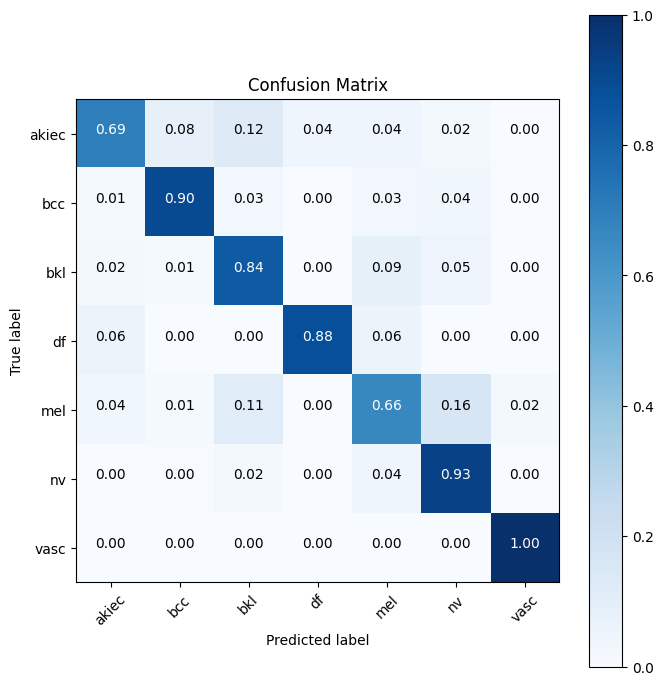

In [226]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(ground_truths, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [227]:
from sklearn.metrics import classification_report

print(classification_report(ground_truths, predictions, target_names=confusion_matrix_plot_labels))

              precision    recall  f1-score   support

       akiec       0.71      0.69      0.70        49
         bcc       0.84      0.90      0.87        77
         bkl       0.76      0.84      0.79       164
          df       0.79      0.88      0.83        17
         mel       0.65      0.66      0.66       166
          nv       0.96      0.93      0.95      1005
        vasc       0.88      1.00      0.93        21

    accuracy                           0.88      1499
   macro avg       0.80      0.84      0.82      1499
weighted avg       0.89      0.88      0.88      1499



In [302]:
##################################################################
### Adding forth model: predicted label wrong : bcc + nv + bkl ###
##################################################################

# Updated get_class_mapping function
def get_class_mapping(model_1_mapping, model_2_mapping):
    class_mapping = {v2: v1 for k1, v1 in model_1_mapping.items() for k2, v2 in model_2_mapping.items() if k1 == k2}
    return class_mapping


# Updated predict function:
def predict(instance, model_1, model_2, model_3, model_4, class_mapping_2, class_mapping_3, class_mapping_4):
    prediction_1 = model_1.predict(instance, verbose=0)
    class_pred_1 = np.argmax(prediction_1)
    percent_1 = prediction_1[0, class_pred_1]

    # Store models and mappings in list for easier iteration
    models = [model_2, model_3, model_4]
    mappings = [class_mapping_2, class_mapping_3, class_mapping_4]
    # Indices to match the conditions in the original function
    indices = [(5,), (1,), (2,)]

    for index, model, mapping in zip(indices, models, mappings):
        if class_pred_1 in index:
            prediction = model.predict(instance, verbose=0)
            class_pred = np.argmax(prediction)
            class_pred_mapped = mapping.get(class_pred, class_pred)
            percent = prediction[0, class_pred]

            print(
                f'model 1: {class_pred_1} ({percent_1 * 100:.2f}%) VS. model {models.index(model) + 2}: {class_pred_mapped} ({percent * 100:.2f}%)')

            return class_pred_1 if percent_1 > percent else class_pred_mapped

    return class_pred_1


first_model_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
second_model_mapping = {'mel': 0, 'nv': 1}
third_model_mapping = {'akiec': 0, 'bcc': 1}
forth_model_mapping = {'bkl': 0, 'mel': 1}  # Fourth model mapping
class_mapping_2 = get_class_mapping(first_model_mapping, second_model_mapping)
class_mapping_3 = get_class_mapping(first_model_mapping, third_model_mapping)
class_mapping_4 = get_class_mapping(first_model_mapping, forth_model_mapping)  # Get class mapping for fourth model

predictions = []
ground_truths = []

with tqdm(total=total) as pbar:
    for i in range(len(test_image_gen)):
        X, y_true = test_image_gen[i]
        actual_batch_size = X.shape[0]
        for j in range(actual_batch_size):
            try:
                instance = X[j]
                filename = test_image_gen.filenames[i * actual_batch_size + j]
                ground_truth = y_true[j]
                ground_truth = np.argmax(ground_truth)
                ground_truths.append(ground_truth)
                prediction = predict(np.expand_dims(instance, axis=0), model, second_model, third_model, forth_model,
                                     class_mapping_2, class_mapping_3, class_mapping_4)
                print(f"Image: {filename}, Prediction: {prediction}, Ground Truth: {ground_truth}")
                predictions.append(prediction)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

            pbar.update()

  0%|          | 3/1536 [00:02<17:16,  1.48it/s]  

Image: akiec/ISIC_0024329.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024372.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024418.jpg, Prediction: 4, Ground Truth: 0


  0%|          | 5/1536 [00:02<09:30,  2.68it/s]

Image: akiec/ISIC_0024450.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024463.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 8/1536 [00:03<05:42,  4.46it/s]

Image: akiec/ISIC_0024468.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024470.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024511.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 9/1536 [00:03<05:25,  4.69it/s]

model 1: 1 (68.07%) VS. model 3: 0 (79.58%)
Image: akiec/ISIC_0024517.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024522.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 12/1536 [00:04<09:22,  2.71it/s]

model 1: 2 (100.00%) VS. model 4: 2 (82.10%)
Image: akiec/ISIC_0024539.jpg, Prediction: 2, Ground Truth: 0
model 1: 1 (92.84%) VS. model 3: 1 (100.00%)
Image: akiec/ISIC_0024562.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024575.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 16/1536 [00:05<04:34,  5.53it/s]

Image: akiec/ISIC_0024579.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024646.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024654.jpg, Prediction: 0, Ground Truth: 0


  1%|          | 18/1536 [00:05<04:06,  6.16it/s]

model 1: 2 (61.94%) VS. model 4: 4 (51.10%)
Image: akiec/ISIC_0024707.jpg, Prediction: 2, Ground Truth: 0
model 1: 1 (83.85%) VS. model 3: 0 (65.24%)
Image: akiec/ISIC_0024710.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024763.jpg, Prediction: 0, Ground Truth: 0


  1%|▏         | 22/1536 [00:05<02:56,  8.58it/s]

Image: akiec/ISIC_0024771.jpg, Prediction: 0, Ground Truth: 0
model 1: 2 (96.86%) VS. model 4: 2 (65.65%)
Image: akiec/ISIC_0024800.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0024843.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 24/1536 [00:05<02:58,  8.48it/s]

model 1: 1 (97.73%) VS. model 3: 1 (100.00%)
Image: akiec/ISIC_0024913.jpg, Prediction: 1, Ground Truth: 0
model 1: 1 (54.34%) VS. model 3: 0 (98.92%)
Image: akiec/ISIC_0024923.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 28/1536 [00:06<02:25, 10.34it/s]

model 1: 1 (91.65%) VS. model 3: 1 (97.20%)
Image: akiec/ISIC_0024925.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0024946.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0024948.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025029.jpg, Prediction: 0, Ground Truth: 0


  2%|▏         | 32/1536 [00:06<01:57, 12.76it/s]

Image: akiec/ISIC_0025069.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025089.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025130.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025178.jpg, Prediction: 3, Ground Truth: 0


  2%|▏         | 36/1536 [00:06<01:54, 13.06it/s]

model 1: 1 (78.99%) VS. model 3: 1 (73.86%)
Image: akiec/ISIC_0025182.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0025196.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025247.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025264.jpg, Prediction: 4, Ground Truth: 0


  3%|▎         | 40/1536 [00:07<01:43, 14.47it/s]

Image: akiec/ISIC_0025319.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025331.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025350.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025358.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 42/1536 [00:07<01:43, 14.47it/s]

Image: akiec/ISIC_0025368.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025411.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025427.jpg, Prediction: 0, Ground Truth: 0


  3%|▎         | 46/1536 [00:07<01:45, 14.09it/s]

model 1: 1 (72.51%) VS. model 3: 1 (95.60%)
Image: akiec/ISIC_0025471.jpg, Prediction: 1, Ground Truth: 0
Image: akiec/ISIC_0025539.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025577.jpg, Prediction: 0, Ground Truth: 0
Image: akiec/ISIC_0025605.jpg, Prediction: 4, Ground Truth: 0


  3%|▎         | 50/1536 [00:07<02:00, 12.34it/s]

model 1: 2 (98.19%) VS. model 4: 2 (85.20%)
Image: akiec/ISIC_0025637.jpg, Prediction: 2, Ground Truth: 0
Image: akiec/ISIC_0025696.jpg, Prediction: 0, Ground Truth: 0
model 1: 1 (99.47%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024331.jpg, Prediction: 1, Ground Truth: 1


  3%|▎         | 52/1536 [00:08<02:16, 10.86it/s]

model 1: 1 (62.88%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024332.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (95.11%) VS. model 3: 1 (83.27%)
Image: bcc/ISIC_0024345.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 54/1536 [00:08<02:30,  9.84it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.86%)
Image: bcc/ISIC_0024360.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.89%)
Image: bcc/ISIC_0024403.jpg, Prediction: 1, Ground Truth: 1


  4%|▎         | 56/1536 [00:08<02:25, 10.15it/s]

model 1: 1 (95.64%) VS. model 3: 1 (98.06%)
Image: bcc/ISIC_0024411.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0024431.jpg, Prediction: 4, Ground Truth: 1
model 1: 1 (79.27%) VS. model 3: 1 (95.02%)
Image: bcc/ISIC_0024432.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 59/1536 [00:08<02:41,  9.17it/s]

model 1: 1 (99.90%) VS. model 3: 1 (99.89%)
Image: bcc/ISIC_0024436.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.92%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024443.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 61/1536 [00:09<02:45,  8.90it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024448.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.85%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0024452.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 63/1536 [00:09<02:55,  8.38it/s]

model 1: 1 (99.97%) VS. model 3: 1 (99.30%)
Image: bcc/ISIC_0024454.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.67%) VS. model 3: 1 (99.92%)
Image: bcc/ISIC_0024457.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 64/1536 [00:09<02:55,  8.38it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.88%)
Image: bcc/ISIC_0024461.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 66/1536 [00:11<09:10,  2.67it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024472.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (88.04%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024504.jpg, Prediction: 1, Ground Truth: 1


  4%|▍         | 68/1536 [00:11<06:09,  3.97it/s]

model 1: 2 (48.32%) VS. model 4: 2 (92.26%)
Image: bcc/ISIC_0024515.jpg, Prediction: 2, Ground Truth: 1
model 1: 1 (99.98%) VS. model 3: 1 (99.24%)
Image: bcc/ISIC_0024550.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 70/1536 [00:11<04:33,  5.37it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0024564.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.63%) VS. model 3: 1 (99.62%)
Image: bcc/ISIC_0024572.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 72/1536 [00:11<03:48,  6.40it/s]

model 1: 1 (95.66%) VS. model 3: 1 (99.88%)
Image: bcc/ISIC_0024573.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0024582.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 74/1536 [00:12<03:22,  7.22it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024590.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024595.jpg, Prediction: 1, Ground Truth: 1


  5%|▍         | 76/1536 [00:12<03:16,  7.42it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0024632.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024634.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 78/1536 [00:12<03:07,  7.76it/s]

model 1: 1 (89.81%) VS. model 3: 1 (95.80%)
Image: bcc/ISIC_0024665.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.78%) VS. model 3: 1 (92.78%)
Image: bcc/ISIC_0024666.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 80/1536 [00:12<03:00,  8.08it/s]

model 1: 1 (99.98%) VS. model 3: 1 (60.27%)
Image: bcc/ISIC_0024673.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (97.81%)
Image: bcc/ISIC_0024743.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 82/1536 [00:13<03:02,  7.98it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024787.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (71.93%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024795.jpg, Prediction: 1, Ground Truth: 1


  5%|▌         | 84/1536 [00:13<03:01,  8.00it/s]

model 1: 1 (99.86%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0024799.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024829.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 86/1536 [00:13<03:01,  8.00it/s]

model 1: 1 (99.92%) VS. model 3: 1 (99.96%)
Image: bcc/ISIC_0024833.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024848.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 88/1536 [00:13<02:58,  8.11it/s]

model 1: 1 (99.95%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024885.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0024897.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 90/1536 [00:14<02:58,  8.10it/s]

model 1: 1 (97.24%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0024931.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.91%) VS. model 3: 1 (99.59%)
Image: bcc/ISIC_0024949.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 92/1536 [00:14<02:58,  8.08it/s]

model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0024984.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.92%) VS. model 3: 0 (69.73%)
Image: bcc/ISIC_0025019.jpg, Prediction: 1, Ground Truth: 1


  6%|▌         | 94/1536 [00:14<02:59,  8.01it/s]

model 1: 1 (100.00%) VS. model 3: 1 (99.98%)
Image: bcc/ISIC_0025031.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (93.95%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025046.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 96/1536 [00:14<02:55,  8.19it/s]

model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025102.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025144.jpg, Prediction: 1, Ground Truth: 1


  6%|▋         | 98/1536 [00:15<03:03,  7.82it/s]

model 1: 1 (98.94%) VS. model 3: 1 (99.93%)
Image: bcc/ISIC_0025260.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025266.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 100/1536 [00:15<03:04,  7.79it/s]

model 1: 1 (96.36%) VS. model 3: 1 (96.70%)
Image: bcc/ISIC_0025285.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025299.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 102/1536 [00:15<03:10,  7.51it/s]

model 1: 1 (99.43%) VS. model 3: 1 (99.95%)
Image: bcc/ISIC_0025301.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.92%) VS. model 3: 1 (99.33%)
Image: bcc/ISIC_0025322.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 104/1536 [00:15<03:06,  7.67it/s]

model 1: 1 (99.93%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025362.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (97.43%) VS. model 3: 1 (99.90%)
Image: bcc/ISIC_0025383.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 106/1536 [00:16<03:06,  7.66it/s]

model 1: 1 (100.00%) VS. model 3: 1 (87.03%)
Image: bcc/ISIC_0025417.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.12%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025433.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 108/1536 [00:16<03:11,  7.46it/s]

model 1: 1 (99.99%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025467.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (99.96%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025509.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 110/1536 [00:16<03:05,  7.67it/s]

model 1: 5 (66.57%) VS. model 2: 5 (99.59%)
Image: bcc/ISIC_0025513.jpg, Prediction: 5, Ground Truth: 1
model 1: 1 (99.20%) VS. model 3: 1 (98.36%)
Image: bcc/ISIC_0025530.jpg, Prediction: 1, Ground Truth: 1


  7%|▋         | 112/1536 [00:16<03:05,  7.67it/s]

model 1: 2 (76.49%) VS. model 4: 4 (72.17%)
Image: bcc/ISIC_0025557.jpg, Prediction: 2, Ground Truth: 1
model 1: 2 (67.53%) VS. model 4: 2 (92.84%)
Image: bcc/ISIC_0025564.jpg, Prediction: 2, Ground Truth: 1


  7%|▋         | 114/1536 [00:17<03:07,  7.60it/s]

model 1: 1 (99.99%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025576.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (66.72%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025584.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 116/1536 [00:17<03:10,  7.47it/s]

model 1: 1 (99.97%) VS. model 3: 1 (100.00%)
Image: bcc/ISIC_0025600.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (93.87%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025601.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 119/1536 [00:17<02:36,  9.05it/s]

model 1: 5 (35.55%) VS. model 2: 4 (84.60%)
Image: bcc/ISIC_0025617.jpg, Prediction: 4, Ground Truth: 1
Image: bcc/ISIC_0025630.jpg, Prediction: 6, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.97%)
Image: bcc/ISIC_0025644.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 121/1536 [00:17<02:43,  8.66it/s]

model 1: 1 (99.89%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025650.jpg, Prediction: 1, Ground Truth: 1
model 1: 5 (63.76%) VS. model 2: 5 (100.00%)
Image: bcc/ISIC_0025691.jpg, Prediction: 5, Ground Truth: 1
Image: bcc/ISIC_0025700.jpg, Prediction: 0, Ground Truth: 1


  8%|▊         | 124/1536 [00:18<02:33,  9.18it/s]

model 1: 1 (99.33%) VS. model 3: 1 (98.19%)
Image: bcc/ISIC_0025711.jpg, Prediction: 1, Ground Truth: 1
model 1: 1 (100.00%) VS. model 3: 1 (99.99%)
Image: bcc/ISIC_0025718.jpg, Prediction: 1, Ground Truth: 1


  8%|▊         | 127/1536 [00:18<02:28,  9.47it/s]

model 1: 1 (99.59%) VS. model 3: 1 (99.94%)
Image: bcc/ISIC_0025731.jpg, Prediction: 1, Ground Truth: 1
Image: bcc/ISIC_0025752.jpg, Prediction: 4, Ground Truth: 1
model 1: 2 (82.68%) VS. model 4: 2 (93.67%)
Image: bkl/ISIC_0024312.jpg, Prediction: 2, Ground Truth: 2


  8%|▊         | 128/1536 [00:18<02:33,  9.20it/s]

model 1: 2 (94.09%) VS. model 4: 2 (99.58%)
Image: bkl/ISIC_0024324.jpg, Prediction: 2, Ground Truth: 2


  8%|▊         | 130/1536 [00:20<08:17,  2.83it/s]

model 1: 2 (100.00%) VS. model 4: 2 (99.98%)
Image: bkl/ISIC_0024336.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.97%)
Image: bkl/ISIC_0024337.jpg, Prediction: 2, Ground Truth: 2


  9%|▊         | 132/1536 [00:20<05:44,  4.07it/s]

model 1: 2 (95.24%) VS. model 4: 2 (97.76%)
Image: bkl/ISIC_0024338.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (96.36%) VS. model 4: 2 (76.71%)
Image: bkl/ISIC_0024358.jpg, Prediction: 2, Ground Truth: 2


  9%|▊         | 134/1536 [00:20<04:19,  5.40it/s]

model 1: 2 (89.21%) VS. model 4: 2 (96.79%)
Image: bkl/ISIC_0024371.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.81%)
Image: bkl/ISIC_0024381.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 136/1536 [00:20<03:40,  6.34it/s]

model 1: 2 (90.44%) VS. model 4: 2 (91.49%)
Image: bkl/ISIC_0024382.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.98%)
Image: bkl/ISIC_0024383.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 138/1536 [00:21<03:20,  6.98it/s]

model 1: 2 (99.99%) VS. model 4: 2 (100.00%)
Image: bkl/ISIC_0024408.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.98%) VS. model 4: 2 (100.00%)
Image: bkl/ISIC_0024409.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 140/1536 [00:21<03:11,  7.28it/s]

model 1: 1 (74.60%) VS. model 3: 1 (89.11%)
Image: bkl/ISIC_0024412.jpg, Prediction: 1, Ground Truth: 2
model 1: 2 (99.75%) VS. model 4: 2 (99.72%)
Image: bkl/ISIC_0024420.jpg, Prediction: 2, Ground Truth: 2


  9%|▉         | 142/1536 [00:21<03:01,  7.70it/s]

model 1: 2 (46.90%) VS. model 4: 2 (99.42%)
Image: bkl/ISIC_0024422.jpg, Prediction: 2, Ground Truth: 2
model 1: 1 (45.34%) VS. model 3: 1 (99.81%)
Image: bkl/ISIC_0024426.jpg, Prediction: 1, Ground Truth: 2


  9%|▉         | 144/1536 [00:22<02:59,  7.75it/s]

model 1: 2 (99.95%) VS. model 4: 2 (99.98%)
Image: bkl/ISIC_0024435.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (97.50%) VS. model 4: 2 (99.84%)
Image: bkl/ISIC_0024445.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 146/1536 [00:22<02:57,  7.83it/s]

model 1: 2 (99.99%) VS. model 4: 2 (99.93%)
Image: bkl/ISIC_0024446.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.94%) VS. model 4: 2 (95.73%)
Image: bkl/ISIC_0024453.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 148/1536 [00:22<02:54,  7.96it/s]

model 1: 2 (99.99%) VS. model 4: 2 (99.99%)
Image: bkl/ISIC_0024471.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.61%) VS. model 4: 2 (59.71%)
Image: bkl/ISIC_0024477.jpg, Prediction: 2, Ground Truth: 2


 10%|▉         | 150/1536 [00:22<02:56,  7.87it/s]

model 1: 2 (99.92%) VS. model 4: 2 (99.94%)
Image: bkl/ISIC_0024489.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (94.66%)
Image: bkl/ISIC_0024490.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024494.jpg, Prediction: 4, Ground Truth: 2


 10%|▉         | 153/1536 [00:23<02:36,  8.86it/s]

model 1: 5 (83.73%) VS. model 2: 5 (99.94%)
Image: bkl/ISIC_0024495.jpg, Prediction: 5, Ground Truth: 2
model 1: 2 (95.68%) VS. model 4: 2 (97.63%)
Image: bkl/ISIC_0024498.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 155/1536 [00:23<02:45,  8.36it/s]

model 1: 2 (79.65%) VS. model 4: 2 (83.84%)
Image: bkl/ISIC_0024505.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (80.16%) VS. model 4: 4 (80.56%)
Image: bkl/ISIC_0024547.jpg, Prediction: 4, Ground Truth: 2


 10%|█         | 157/1536 [00:23<02:45,  8.34it/s]

model 1: 2 (99.66%) VS. model 4: 2 (97.06%)
Image: bkl/ISIC_0024581.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (94.32%)
Image: bkl/ISIC_0024592.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 159/1536 [00:23<02:46,  8.27it/s]

model 1: 2 (97.67%) VS. model 4: 2 (68.95%)
Image: bkl/ISIC_0024602.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (88.47%) VS. model 4: 4 (51.60%)
Image: bkl/ISIC_0024612.jpg, Prediction: 2, Ground Truth: 2


 10%|█         | 161/1536 [00:24<02:45,  8.29it/s]

model 1: 2 (100.00%) VS. model 4: 2 (99.99%)
Image: bkl/ISIC_0024623.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.82%) VS. model 4: 2 (98.77%)
Image: bkl/ISIC_0024626.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024635.jpg, Prediction: 4, Ground Truth: 2


 11%|█         | 164/1536 [00:24<02:32,  9.02it/s]

model 1: 2 (99.93%) VS. model 4: 2 (99.77%)
Image: bkl/ISIC_0024643.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (94.76%) VS. model 4: 2 (55.38%)
Image: bkl/ISIC_0024672.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 167/1536 [00:24<02:20,  9.74it/s]

model 1: 2 (99.92%) VS. model 4: 2 (94.57%)
Image: bkl/ISIC_0024676.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024696.jpg, Prediction: 4, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (100.00%)
Image: bkl/ISIC_0024705.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 170/1536 [00:24<02:16,  9.99it/s]

model 1: 2 (55.45%) VS. model 4: 4 (95.84%)
Image: bkl/ISIC_0024708.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0024709.jpg, Prediction: 3, Ground Truth: 2
model 1: 2 (80.47%) VS. model 4: 2 (60.96%)
Image: bkl/ISIC_0024711.jpg, Prediction: 2, Ground Truth: 2


 11%|█         | 172/1536 [00:25<02:27,  9.26it/s]

model 1: 2 (99.91%) VS. model 4: 2 (87.04%)
Image: bkl/ISIC_0024726.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.45%) VS. model 4: 2 (98.74%)
Image: bkl/ISIC_0024740.jpg, Prediction: 2, Ground Truth: 2


 11%|█▏        | 174/1536 [00:25<02:36,  8.70it/s]

model 1: 2 (91.21%) VS. model 4: 2 (98.99%)
Image: bkl/ISIC_0024741.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (85.47%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0024748.jpg, Prediction: 5, Ground Truth: 2


 11%|█▏        | 176/1536 [00:25<02:38,  8.57it/s]

model 1: 2 (100.00%) VS. model 4: 2 (98.93%)
Image: bkl/ISIC_0024758.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.90%)
Image: bkl/ISIC_0024760.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 178/1536 [00:25<02:43,  8.31it/s]

model 1: 2 (99.95%) VS. model 4: 2 (99.99%)
Image: bkl/ISIC_0024761.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.98%) VS. model 4: 2 (99.66%)
Image: bkl/ISIC_0024770.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 180/1536 [00:26<02:43,  8.28it/s]

model 1: 2 (53.86%) VS. model 4: 2 (70.09%)
Image: bkl/ISIC_0024772.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (92.41%) VS. model 4: 2 (59.39%)
Image: bkl/ISIC_0024773.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 182/1536 [00:26<02:52,  7.83it/s]

model 1: 2 (99.99%) VS. model 4: 2 (100.00%)
Image: bkl/ISIC_0024774.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (77.49%) VS. model 4: 4 (99.35%)
Image: bkl/ISIC_0024782.jpg, Prediction: 4, Ground Truth: 2


 12%|█▏        | 184/1536 [00:26<02:49,  7.96it/s]

model 1: 2 (81.06%) VS. model 4: 2 (70.00%)
Image: bkl/ISIC_0024786.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (91.87%) VS. model 4: 2 (59.40%)
Image: bkl/ISIC_0024814.jpg, Prediction: 2, Ground Truth: 2


 12%|█▏        | 186/1536 [00:26<02:46,  8.09it/s]

model 1: 2 (99.97%) VS. model 4: 2 (96.80%)
Image: bkl/ISIC_0024825.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (95.51%) VS. model 4: 4 (70.81%)
Image: bkl/ISIC_0024832.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024839.jpg, Prediction: 0, Ground Truth: 2


 12%|█▏        | 190/1536 [00:27<02:15,  9.95it/s]

model 1: 2 (83.90%) VS. model 4: 2 (98.60%)
Image: bkl/ISIC_0024850.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0024851.jpg, Prediction: 4, Ground Truth: 2
model 1: 2 (99.99%) VS. model 4: 2 (99.95%)
Image: bkl/ISIC_0024871.jpg, Prediction: 2, Ground Truth: 2


 12%|█▎        | 192/1536 [00:27<02:39,  8.42it/s]

model 1: 2 (99.96%) VS. model 4: 2 (99.92%)
Image: bkl/ISIC_0024877.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.64%) VS. model 4: 2 (98.47%)
Image: bkl/ISIC_0024880.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 194/1536 [00:29<08:28,  2.64it/s]

model 1: 2 (53.67%) VS. model 4: 2 (98.81%)
Image: bkl/ISIC_0024881.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (95.01%) VS. model 2: 5 (99.89%)
Image: bkl/ISIC_0024883.jpg, Prediction: 5, Ground Truth: 2


 13%|█▎        | 196/1536 [00:29<05:53,  3.79it/s]

model 1: 2 (87.63%) VS. model 4: 2 (75.95%)
Image: bkl/ISIC_0024890.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.85%) VS. model 4: 4 (68.29%)
Image: bkl/ISIC_0024893.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 198/1536 [00:29<04:23,  5.07it/s]

model 1: 2 (97.59%) VS. model 4: 2 (97.94%)
Image: bkl/ISIC_0024909.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (97.23%) VS. model 4: 2 (67.94%)
Image: bkl/ISIC_0024910.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 200/1536 [00:29<03:29,  6.38it/s]

model 1: 2 (48.51%) VS. model 4: 2 (97.59%)
Image: bkl/ISIC_0024915.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.82%) VS. model 4: 2 (99.55%)
Image: bkl/ISIC_0024943.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 202/1536 [00:30<03:07,  7.12it/s]

model 1: 2 (99.92%) VS. model 4: 2 (99.75%)
Image: bkl/ISIC_0024947.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.92%) VS. model 4: 2 (54.25%)
Image: bkl/ISIC_0024970.jpg, Prediction: 2, Ground Truth: 2


 13%|█▎        | 204/1536 [00:30<02:53,  7.68it/s]

model 1: 2 (100.00%) VS. model 4: 2 (99.23%)
Image: bkl/ISIC_0024971.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (89.22%) VS. model 2: 5 (99.76%)
Image: bkl/ISIC_0024981.jpg, Prediction: 5, Ground Truth: 2


 13%|█▎        | 206/1536 [00:30<02:51,  7.75it/s]

model 1: 2 (58.40%) VS. model 4: 2 (99.95%)
Image: bkl/ISIC_0024982.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.64%) VS. model 4: 2 (99.77%)
Image: bkl/ISIC_0024997.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 208/1536 [00:30<02:42,  8.16it/s]

model 1: 2 (85.29%) VS. model 4: 2 (81.57%)
Image: bkl/ISIC_0025005.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.36%) VS. model 4: 2 (99.97%)
Image: bkl/ISIC_0025016.jpg, Prediction: 2, Ground Truth: 2


 14%|█▎        | 210/1536 [00:31<02:42,  8.14it/s]

model 1: 2 (99.94%) VS. model 4: 2 (95.10%)
Image: bkl/ISIC_0025030.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (93.11%) VS. model 4: 2 (94.19%)
Image: bkl/ISIC_0025032.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 212/1536 [00:31<02:38,  8.36it/s]

model 1: 1 (95.80%) VS. model 3: 1 (99.26%)
Image: bkl/ISIC_0025033.jpg, Prediction: 1, Ground Truth: 2
model 1: 2 (94.11%) VS. model 4: 2 (58.27%)
Image: bkl/ISIC_0025038.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 214/1536 [00:31<02:44,  8.02it/s]

model 1: 5 (94.87%) VS. model 2: 5 (99.99%)
Image: bkl/ISIC_0025040.jpg, Prediction: 5, Ground Truth: 2
model 1: 2 (98.99%) VS. model 4: 2 (95.14%)
Image: bkl/ISIC_0025063.jpg, Prediction: 2, Ground Truth: 2


 14%|█▍        | 217/1536 [00:31<02:05, 10.49it/s]

model 1: 5 (89.44%) VS. model 2: 5 (90.74%)
Image: bkl/ISIC_0025064.jpg, Prediction: 5, Ground Truth: 2
Image: bkl/ISIC_0025066.jpg, Prediction: 0, Ground Truth: 2
Image: bkl/ISIC_0025068.jpg, Prediction: 4, Ground Truth: 2


 14%|█▍        | 219/1536 [00:32<02:20,  9.35it/s]

model 1: 2 (91.72%) VS. model 4: 2 (99.96%)
Image: bkl/ISIC_0025075.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (88.19%) VS. model 2: 5 (71.97%)
Image: bkl/ISIC_0025076.jpg, Prediction: 5, Ground Truth: 2


 14%|█▍        | 221/1536 [00:32<02:29,  8.82it/s]

model 1: 2 (99.65%) VS. model 4: 2 (90.53%)
Image: bkl/ISIC_0025083.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (91.61%) VS. model 4: 2 (78.32%)
Image: bkl/ISIC_0025086.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 223/1536 [00:32<02:33,  8.56it/s]

model 1: 2 (99.99%) VS. model 4: 2 (99.96%)
Image: bkl/ISIC_0025099.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.93%) VS. model 4: 2 (99.87%)
Image: bkl/ISIC_0025103.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 225/1536 [00:32<02:39,  8.24it/s]

model 1: 2 (60.03%) VS. model 4: 2 (99.66%)
Image: bkl/ISIC_0025113.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.93%)
Image: bkl/ISIC_0025131.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025136.jpg, Prediction: 4, Ground Truth: 2


 15%|█▍        | 228/1536 [00:33<02:27,  8.88it/s]

model 1: 5 (55.50%) VS. model 2: 4 (99.87%)
Image: bkl/ISIC_0025140.jpg, Prediction: 4, Ground Truth: 2
model 1: 2 (99.80%) VS. model 4: 2 (99.53%)
Image: bkl/ISIC_0025157.jpg, Prediction: 2, Ground Truth: 2


 15%|█▍        | 230/1536 [00:33<02:38,  8.23it/s]

model 1: 2 (99.26%) VS. model 4: 2 (99.55%)
Image: bkl/ISIC_0025180.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (93.52%) VS. model 4: 2 (98.21%)
Image: bkl/ISIC_0025199.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025209.jpg, Prediction: 0, Ground Truth: 2


 15%|█▌        | 232/1536 [00:33<02:04, 10.45it/s]

Image: bkl/ISIC_0025222.jpg, Prediction: 0, Ground Truth: 2
model 1: 2 (89.17%) VS. model 4: 2 (82.85%)
Image: bkl/ISIC_0025275.jpg, Prediction: 2, Ground Truth: 2


 15%|█▌        | 235/1536 [00:34<02:25,  8.96it/s]

model 1: 2 (97.50%) VS. model 4: 2 (81.36%)
Image: bkl/ISIC_0025276.jpg, Prediction: 2, Ground Truth: 2
model 1: 5 (67.89%) VS. model 2: 5 (76.58%)
Image: bkl/ISIC_0025286.jpg, Prediction: 5, Ground Truth: 2


 15%|█▌        | 237/1536 [00:34<02:31,  8.58it/s]

model 1: 2 (99.99%) VS. model 4: 2 (99.41%)
Image: bkl/ISIC_0025292.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.82%) VS. model 4: 4 (50.22%)
Image: bkl/ISIC_0025297.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 239/1536 [00:34<02:39,  8.12it/s]

model 1: 2 (95.96%) VS. model 4: 2 (63.76%)
Image: bkl/ISIC_0025312.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (97.89%) VS. model 4: 2 (98.49%)
Image: bkl/ISIC_0025326.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 241/1536 [00:34<02:40,  8.08it/s]

model 1: 2 (99.75%) VS. model 4: 2 (99.99%)
Image: bkl/ISIC_0025330.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.20%) VS. model 4: 2 (93.20%)
Image: bkl/ISIC_0025337.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 243/1536 [00:35<02:41,  8.00it/s]

model 1: 2 (95.47%) VS. model 4: 2 (72.16%)
Image: bkl/ISIC_0025339.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (69.66%) VS. model 4: 2 (74.95%)
Image: bkl/ISIC_0025345.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 245/1536 [00:35<02:39,  8.07it/s]

model 1: 2 (49.19%) VS. model 4: 4 (95.66%)
Image: bkl/ISIC_0025351.jpg, Prediction: 4, Ground Truth: 2
model 1: 5 (97.73%) VS. model 2: 5 (100.00%)
Image: bkl/ISIC_0025366.jpg, Prediction: 5, Ground Truth: 2


 16%|█▌        | 247/1536 [00:35<02:38,  8.14it/s]

model 1: 2 (100.00%) VS. model 4: 2 (79.74%)
Image: bkl/ISIC_0025374.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.95%) VS. model 4: 2 (65.28%)
Image: bkl/ISIC_0025376.jpg, Prediction: 2, Ground Truth: 2


 16%|█▌        | 249/1536 [00:35<02:39,  8.06it/s]

model 1: 2 (99.94%) VS. model 4: 2 (99.98%)
Image: bkl/ISIC_0025378.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.70%) VS. model 4: 2 (98.87%)
Image: bkl/ISIC_0025387.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 251/1536 [00:36<02:37,  8.15it/s]

model 1: 2 (100.00%) VS. model 4: 2 (99.84%)
Image: bkl/ISIC_0025388.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (62.12%) VS. model 4: 2 (99.77%)
Image: bkl/ISIC_0025389.jpg, Prediction: 2, Ground Truth: 2


 16%|█▋        | 253/1536 [00:36<02:41,  7.96it/s]

model 1: 2 (99.95%) VS. model 4: 2 (99.98%)
Image: bkl/ISIC_0025392.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (97.95%) VS. model 4: 2 (58.27%)
Image: bkl/ISIC_0025419.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 255/1536 [00:36<02:35,  8.22it/s]

model 1: 2 (99.96%) VS. model 4: 2 (99.82%)
Image: bkl/ISIC_0025431.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.98%)
Image: bkl/ISIC_0025434.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 256/1536 [00:36<02:36,  8.19it/s]

model 1: 2 (99.22%) VS. model 4: 2 (96.91%)
Image: bkl/ISIC_0025454.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 258/1536 [00:38<08:33,  2.49it/s]

model 1: 2 (99.96%) VS. model 4: 2 (99.26%)
Image: bkl/ISIC_0025465.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (58.81%) VS. model 4: 2 (90.36%)
Image: bkl/ISIC_0025466.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 260/1536 [00:38<05:28,  3.88it/s]

model 1: 2 (99.98%) VS. model 4: 2 (100.00%)
Image: bkl/ISIC_0025470.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (97.85%) VS. model 4: 2 (99.99%)
Image: bkl/ISIC_0025484.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 262/1536 [00:38<04:01,  5.27it/s]

model 1: 2 (99.75%) VS. model 4: 2 (98.42%)
Image: bkl/ISIC_0025485.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (86.81%) VS. model 4: 2 (95.88%)
Image: bkl/ISIC_0025507.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 264/1536 [00:38<03:13,  6.58it/s]

model 1: 5 (52.99%) VS. model 2: 5 (99.96%)
Image: bkl/ISIC_0025510.jpg, Prediction: 5, Ground Truth: 2
model 1: 2 (99.96%) VS. model 4: 2 (99.92%)
Image: bkl/ISIC_0025515.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 266/1536 [00:39<02:55,  7.25it/s]

model 1: 2 (99.71%) VS. model 4: 2 (99.90%)
Image: bkl/ISIC_0025519.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (93.46%) VS. model 4: 2 (99.80%)
Image: bkl/ISIC_0025526.jpg, Prediction: 2, Ground Truth: 2


 17%|█▋        | 268/1536 [00:39<02:44,  7.71it/s]

model 1: 2 (99.96%) VS. model 4: 2 (99.54%)
Image: bkl/ISIC_0025529.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (96.81%) VS. model 4: 2 (99.86%)
Image: bkl/ISIC_0025548.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025554.jpg, Prediction: 4, Ground Truth: 2


 18%|█▊        | 271/1536 [00:39<02:30,  8.42it/s]

model 1: 2 (99.93%) VS. model 4: 2 (100.00%)
Image: bkl/ISIC_0025567.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.61%) VS. model 4: 2 (99.99%)
Image: bkl/ISIC_0025575.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 273/1536 [00:39<02:35,  8.15it/s]

model 1: 2 (99.76%) VS. model 4: 2 (94.73%)
Image: bkl/ISIC_0025583.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (69.26%) VS. model 4: 2 (75.95%)
Image: bkl/ISIC_0025623.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 274/1536 [00:40<02:36,  8.04it/s]

model 1: 2 (87.37%) VS. model 4: 2 (75.03%)
Image: bkl/ISIC_0025627.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025642.jpg, Prediction: 4, Ground Truth: 2


 18%|█▊        | 277/1536 [00:40<02:28,  8.46it/s]

model 1: 2 (99.89%) VS. model 4: 2 (99.11%)
Image: bkl/ISIC_0025654.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (100.00%) VS. model 4: 2 (99.71%)
Image: bkl/ISIC_0025656.jpg, Prediction: 2, Ground Truth: 2
Image: bkl/ISIC_0025659.jpg, Prediction: 4, Ground Truth: 2


 18%|█▊        | 280/1536 [00:40<02:28,  8.47it/s]

model 1: 2 (79.60%) VS. model 4: 4 (64.34%)
Image: bkl/ISIC_0025661.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (98.56%) VS. model 4: 2 (96.33%)
Image: bkl/ISIC_0025693.jpg, Prediction: 2, Ground Truth: 2


 18%|█▊        | 283/1536 [00:41<02:11,  9.50it/s]

Image: bkl/ISIC_0025699.jpg, Prediction: 4, Ground Truth: 2
Image: bkl/ISIC_0025703.jpg, Prediction: 4, Ground Truth: 2
model 1: 2 (99.70%) VS. model 4: 2 (98.09%)
Image: bkl/ISIC_0025710.jpg, Prediction: 2, Ground Truth: 2


 19%|█▊        | 285/1536 [00:41<02:09,  9.66it/s]

Image: bkl/ISIC_0025716.jpg, Prediction: 4, Ground Truth: 2
model 1: 2 (95.33%) VS. model 4: 2 (99.59%)
Image: bkl/ISIC_0025719.jpg, Prediction: 2, Ground Truth: 2


 19%|█▊        | 287/1536 [00:41<02:25,  8.57it/s]

model 1: 2 (100.00%) VS. model 4: 2 (99.90%)
Image: bkl/ISIC_0025743.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.91%) VS. model 4: 2 (97.99%)
Image: bkl/ISIC_0025746.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 289/1536 [00:41<02:39,  7.82it/s]

model 1: 2 (99.66%) VS. model 4: 2 (99.44%)
Image: bkl/ISIC_0025753.jpg, Prediction: 2, Ground Truth: 2
model 1: 2 (99.98%) VS. model 4: 2 (99.93%)
Image: bkl/ISIC_0025758.jpg, Prediction: 2, Ground Truth: 2


 19%|█▉        | 290/1536 [00:41<02:48,  7.39it/s]

model 1: 2 (99.64%) VS. model 4: 2 (99.95%)
Image: bkl/ISIC_0025767.jpg, Prediction: 2, Ground Truth: 2
Image: df/ISIC_0024318.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 294/1536 [00:42<02:04,  9.95it/s]

model 1: 1 (58.33%) VS. model 3: 1 (99.88%)
Image: df/ISIC_0024330.jpg, Prediction: 1, Ground Truth: 3
Image: df/ISIC_0024386.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024396.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024553.jpg, Prediction: 3, Ground Truth: 3


 19%|█▉        | 298/1536 [00:42<01:36, 12.83it/s]

Image: df/ISIC_0024845.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024973.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0024994.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025154.jpg, Prediction: 0, Ground Truth: 3


 20%|█▉        | 302/1536 [00:42<01:26, 14.34it/s]

Image: df/ISIC_0025223.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025302.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025314.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025373.jpg, Prediction: 3, Ground Truth: 3


 20%|█▉        | 306/1536 [00:43<01:20, 15.35it/s]

Image: df/ISIC_0025504.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025594.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025622.jpg, Prediction: 3, Ground Truth: 3
Image: df/ISIC_0025668.jpg, Prediction: 3, Ground Truth: 3


 20%|██        | 310/1536 [00:43<01:29, 13.65it/s]

Image: mel/ISIC_0024310.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (97.42%) VS. model 2: 5 (96.24%)
Image: mel/ISIC_0024313.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024315.jpg, Prediction: 4, Ground Truth: 4


 20%|██        | 312/1536 [00:43<01:35, 12.76it/s]

Image: mel/ISIC_0024323.jpg, Prediction: 3, Ground Truth: 4
model 1: 2 (88.08%) VS. model 4: 2 (74.15%)
Image: mel/ISIC_0024333.jpg, Prediction: 2, Ground Truth: 4


 20%|██        | 314/1536 [00:43<01:42, 11.95it/s]

model 1: 5 (83.82%) VS. model 2: 4 (99.74%)
Image: mel/ISIC_0024351.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024367.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (100.00%) VS. model 4: 4 (66.48%)
Image: mel/ISIC_0024400.jpg, Prediction: 2, Ground Truth: 4


 21%|██        | 318/1536 [00:44<01:54, 10.61it/s]

model 1: 5 (79.53%) VS. model 2: 5 (74.90%)
Image: mel/ISIC_0024410.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024449.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (52.03%) VS. model 4: 4 (75.88%)
Image: mel/ISIC_0024459.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 320/1536 [00:44<01:55, 10.57it/s]

model 1: 5 (73.81%) VS. model 2: 4 (90.62%)
Image: mel/ISIC_0024481.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024482.jpg, Prediction: 4, Ground Truth: 4


 21%|██        | 323/1536 [00:45<05:10,  3.90it/s]

Image: mel/ISIC_0024496.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024516.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (97.21%) VS. model 4: 2 (99.07%)
Image: mel/ISIC_0024525.jpg, Prediction: 2, Ground Truth: 4


 21%|██▏       | 327/1536 [00:46<03:02,  6.63it/s]

Image: mel/ISIC_0024537.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024545.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024546.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024552.jpg, Prediction: 4, Ground Truth: 4


 21%|██▏       | 329/1536 [00:46<02:40,  7.53it/s]

model 1: 2 (81.34%) VS. model 4: 2 (95.75%)
Image: mel/ISIC_0024554.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024571.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (91.66%) VS. model 2: 5 (99.69%)
Image: mel/ISIC_0024586.jpg, Prediction: 5, Ground Truth: 4


 22%|██▏       | 333/1536 [00:46<02:10,  9.23it/s]

model 1: 2 (93.17%) VS. model 4: 2 (66.94%)
Image: mel/ISIC_0024624.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0024630.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024640.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024644.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 337/1536 [00:47<01:40, 11.92it/s]

Image: mel/ISIC_0024647.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024652.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024675.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024679.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 341/1536 [00:47<01:26, 13.86it/s]

Image: mel/ISIC_0024688.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024700.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024701.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024702.jpg, Prediction: 4, Ground Truth: 4


 22%|██▏       | 345/1536 [00:47<01:19, 15.05it/s]

Image: mel/ISIC_0024729.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024733.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024739.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 349/1536 [00:47<01:15, 15.67it/s]

Image: mel/ISIC_0024756.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024767.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024792.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024805.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 353/1536 [00:48<01:16, 15.54it/s]

Image: mel/ISIC_0024806.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024823.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024853.jpg, Prediction: 4, Ground Truth: 4


 23%|██▎       | 355/1536 [00:48<01:25, 13.78it/s]

model 1: 5 (91.52%) VS. model 2: 5 (97.48%)
Image: mel/ISIC_0024864.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024865.jpg, Prediction: 4, Ground Truth: 4
model 1: 1 (86.97%) VS. model 3: 1 (93.24%)
Image: mel/ISIC_0024875.jpg, Prediction: 1, Ground Truth: 4


 23%|██▎       | 359/1536 [00:48<01:37, 12.12it/s]

Image: mel/ISIC_0024886.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (98.10%) VS. model 2: 5 (99.89%)
Image: mel/ISIC_0024898.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024900.jpg, Prediction: 4, Ground Truth: 4


 24%|██▎       | 361/1536 [00:48<01:29, 13.07it/s]

Image: mel/ISIC_0024911.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024918.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024929.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 365/1536 [00:48<01:28, 13.26it/s]

model 1: 5 (86.55%) VS. model 2: 5 (97.39%)
Image: mel/ISIC_0024930.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0024932.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024940.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024951.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 369/1536 [00:49<01:19, 14.61it/s]

Image: mel/ISIC_0024952.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024958.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024961.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024962.jpg, Prediction: 4, Ground Truth: 4


 24%|██▍       | 373/1536 [00:49<01:26, 13.45it/s]

Image: mel/ISIC_0024967.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0024972.jpg, Prediction: 4, Ground Truth: 4
model 1: 1 (53.48%) VS. model 3: 1 (96.99%)
Image: mel/ISIC_0024987.jpg, Prediction: 1, Ground Truth: 4


 24%|██▍       | 375/1536 [00:49<01:32, 12.59it/s]

Image: mel/ISIC_0024999.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (93.28%) VS. model 2: 5 (99.93%)
Image: mel/ISIC_0025018.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025035.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 379/1536 [00:50<01:32, 12.46it/s]

Image: mel/ISIC_0025081.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025085.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (91.68%) VS. model 4: 2 (74.69%)
Image: mel/ISIC_0025097.jpg, Prediction: 2, Ground Truth: 4


 25%|██▍       | 381/1536 [00:50<01:26, 13.36it/s]

Image: mel/ISIC_0025105.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025121.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025127.jpg, Prediction: 4, Ground Truth: 4


 25%|██▍       | 383/1536 [00:50<01:32, 12.46it/s]

model 1: 2 (98.17%) VS. model 4: 4 (88.05%)
Image: mel/ISIC_0025128.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025132.jpg, Prediction: 4, Ground Truth: 4


 25%|██▌       | 386/1536 [00:51<04:53,  3.92it/s]

Image: mel/ISIC_0025145.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (97.95%) VS. model 2: 5 (96.06%)
Image: mel/ISIC_0025153.jpg, Prediction: 5, Ground Truth: 4


 25%|██▌       | 388/1536 [00:52<03:40,  5.21it/s]

Image: mel/ISIC_0025155.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025188.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (85.91%) VS. model 4: 2 (57.95%)
Image: mel/ISIC_0025195.jpg, Prediction: 2, Ground Truth: 4


 26%|██▌       | 392/1536 [00:52<02:31,  7.55it/s]

Image: mel/ISIC_0025219.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025234.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025235.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 394/1536 [00:52<02:12,  8.61it/s]

Image: mel/ISIC_0025238.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025248.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025265.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 398/1536 [00:52<01:52, 10.08it/s]

Image: mel/ISIC_0025268.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (42.98%) VS. model 4: 4 (99.08%)
Image: mel/ISIC_0025277.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025303.jpg, Prediction: 4, Ground Truth: 4


 26%|██▌       | 400/1536 [00:53<01:54,  9.90it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.40%)
Image: mel/ISIC_0025313.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025316.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025317.jpg, Prediction: 4, Ground Truth: 4


 26%|██▋       | 404/1536 [00:53<01:40, 11.27it/s]

model 1: 5 (75.73%) VS. model 2: 5 (100.00%)
Image: mel/ISIC_0025324.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025363.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025391.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 408/1536 [00:53<01:33, 12.12it/s]

model 1: 5 (97.00%) VS. model 2: 5 (99.97%)
Image: mel/ISIC_0025394.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025409.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025413.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025414.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 410/1536 [00:53<01:40, 11.23it/s]

Image: mel/ISIC_0025439.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.34%) VS. model 2: 5 (99.80%)
Image: mel/ISIC_0025450.jpg, Prediction: 5, Ground Truth: 4


 27%|██▋       | 412/1536 [00:54<01:53,  9.92it/s]

model 1: 5 (95.96%) VS. model 2: 5 (99.95%)
Image: mel/ISIC_0025451.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (75.93%) VS. model 2: 4 (96.34%)
Image: mel/ISIC_0025472.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025489.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 416/1536 [00:54<01:42, 10.96it/s]

model 1: 2 (40.24%) VS. model 4: 2 (56.55%)
Image: mel/ISIC_0025500.jpg, Prediction: 2, Ground Truth: 4
Image: mel/ISIC_0025512.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025520.jpg, Prediction: 4, Ground Truth: 4


 27%|██▋       | 418/1536 [00:54<01:33, 11.96it/s]

Image: mel/ISIC_0025524.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025531.jpg, Prediction: 0, Ground Truth: 4


 27%|██▋       | 420/1536 [00:54<01:45, 10.59it/s]

model 1: 2 (51.74%) VS. model 4: 4 (77.67%)
Image: mel/ISIC_0025543.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025546.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (96.57%) VS. model 2: 5 (69.61%)
Image: mel/ISIC_0025550.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 424/1536 [00:55<01:48, 10.23it/s]

Image: mel/ISIC_0025573.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025589.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (58.27%) VS. model 2: 5 (51.94%)
Image: mel/ISIC_0025592.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 426/1536 [00:55<01:37, 11.34it/s]

Image: mel/ISIC_0025603.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025611.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025616.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 428/1536 [00:55<01:33, 11.82it/s]

Image: mel/ISIC_0025651.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025663.jpg, Prediction: 4, Ground Truth: 4


 28%|██▊       | 430/1536 [00:55<01:39, 11.11it/s]

model 1: 1 (60.72%) VS. model 3: 1 (99.26%)
Image: mel/ISIC_0025674.jpg, Prediction: 1, Ground Truth: 4
model 1: 5 (72.31%) VS. model 2: 5 (94.84%)
Image: mel/ISIC_0025708.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 432/1536 [00:56<01:43, 10.67it/s]

Image: mel/ISIC_0025709.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (99.33%) VS. model 2: 5 (87.67%)
Image: mel/ISIC_0025724.jpg, Prediction: 5, Ground Truth: 4


 28%|██▊       | 436/1536 [00:56<01:37, 11.28it/s]

Image: mel/ISIC_0025732.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025744.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025748.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025751.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 438/1536 [00:56<01:39, 11.01it/s]

model 1: 5 (80.41%) VS. model 2: 5 (80.82%)
Image: mel/ISIC_0025755.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025766.jpg, Prediction: 4, Ground Truth: 4


 29%|██▊       | 440/1536 [00:56<01:43, 10.55it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.16%)
Image: mel/ISIC_0025783.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (90.84%) VS. model 2: 5 (87.50%)
Image: mel/ISIC_0025791.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 442/1536 [00:57<01:48, 10.09it/s]

Image: mel/ISIC_0025800.jpg, Prediction: 0, Ground Truth: 4
Image: mel/ISIC_0025814.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 446/1536 [00:57<01:48, 10.02it/s]

model 1: 5 (77.32%) VS. model 2: 4 (50.33%)
Image: mel/ISIC_0025832.jpg, Prediction: 5, Ground Truth: 4
Image: mel/ISIC_0025835.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (82.30%) VS. model 2: 5 (75.99%)
Image: mel/ISIC_0025891.jpg, Prediction: 5, Ground Truth: 4


 29%|██▉       | 448/1536 [00:57<01:36, 11.30it/s]

Image: mel/ISIC_0025904.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025927.jpg, Prediction: 4, Ground Truth: 4


 29%|██▉       | 452/1536 [00:59<03:49,  4.71it/s]

Image: mel/ISIC_0025941.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025955.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025963.jpg, Prediction: 6, Ground Truth: 4
Image: mel/ISIC_0025964.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 454/1536 [00:59<03:01,  5.95it/s]

Image: mel/ISIC_0025987.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0025996.jpg, Prediction: 4, Ground Truth: 4
model 1: 2 (80.39%) VS. model 4: 4 (63.70%)
Image: mel/ISIC_0026009.jpg, Prediction: 2, Ground Truth: 4


 30%|██▉       | 458/1536 [00:59<02:15,  7.93it/s]

model 1: 2 (50.22%) VS. model 4: 4 (66.68%)
Image: mel/ISIC_0026045.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026081.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026086.jpg, Prediction: 4, Ground Truth: 4


 30%|██▉       | 460/1536 [00:59<02:15,  7.96it/s]

model 1: 5 (92.51%) VS. model 2: 5 (98.56%)
Image: mel/ISIC_0026089.jpg, Prediction: 5, Ground Truth: 4
model 1: 5 (59.62%) VS. model 2: 4 (74.84%)
Image: mel/ISIC_0026094.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026105.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 464/1536 [01:00<01:49,  9.83it/s]

Image: mel/ISIC_0026113.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (52.76%) VS. model 2: 4 (78.06%)
Image: mel/ISIC_0026115.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026120.jpg, Prediction: 4, Ground Truth: 4


 30%|███       | 466/1536 [01:00<01:35, 11.19it/s]

Image: mel/ISIC_0026131.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026150.jpg, Prediction: 4, Ground Truth: 4
model 1: 1 (99.81%) VS. model 3: 1 (100.00%)
Image: mel/ISIC_0026158.jpg, Prediction: 1, Ground Truth: 4


 31%|███       | 470/1536 [01:00<01:35, 11.12it/s]

Image: mel/ISIC_0026167.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026188.jpg, Prediction: 4, Ground Truth: 4
model 1: 5 (68.17%) VS. model 2: 4 (88.99%)
Image: mel/ISIC_0026207.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 472/1536 [01:00<01:26, 12.36it/s]

Image: mel/ISIC_0026229.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026236.jpg, Prediction: 4, Ground Truth: 4
Image: mel/ISIC_0026239.jpg, Prediction: 4, Ground Truth: 4


 31%|███       | 474/1536 [01:01<03:15,  5.42it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024307.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 477/1536 [01:02<02:56,  5.99it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024309.jpg, Prediction: 5, Ground Truth: 5


 31%|███       | 479/1536 [01:02<02:50,  6.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024311.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.39%) VS. model 2: 5 (98.47%)
Image: nv/ISIC_0024314.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 481/1536 [01:02<02:42,  6.48it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024316.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (77.34%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0024317.jpg, Prediction: 5, Ground Truth: 5


 31%|███▏      | 483/1536 [01:02<02:42,  6.48it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024319.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024320.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 485/1536 [01:03<02:38,  6.62it/s]

model 1: 5 (99.62%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024321.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024322.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 487/1536 [01:03<02:37,  6.64it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024325.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024326.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 489/1536 [01:03<02:34,  6.78it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024327.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.49%) VS. model 2: 5 (98.40%)
Image: nv/ISIC_0024328.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 491/1536 [01:04<02:35,  6.72it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024334.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024335.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 493/1536 [01:04<02:33,  6.81it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024339.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.41%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024340.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 495/1536 [01:04<02:35,  6.70it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024341.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024342.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 497/1536 [01:05<02:34,  6.73it/s]

model 1: 5 (91.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024343.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024344.jpg, Prediction: 4, Ground Truth: 5


 32%|███▏      | 498/1536 [01:05<02:58,  5.82it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024346.jpg, Prediction: 5, Ground Truth: 5


 32%|███▏      | 499/1536 [01:05<03:12,  5.38it/s]

model 1: 2 (68.49%) VS. model 4: 4 (95.28%)
Image: nv/ISIC_0024347.jpg, Prediction: 4, Ground Truth: 5


 33%|███▎      | 501/1536 [01:05<03:15,  5.29it/s]

model 1: 5 (99.10%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024348.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.52%) VS. model 2: 5 (87.11%)
Image: nv/ISIC_0024349.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 502/1536 [01:06<03:18,  5.20it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024350.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 503/1536 [01:06<03:59,  4.31it/s]

model 1: 5 (66.26%) VS. model 2: 5 (98.28%)
Image: nv/ISIC_0024352.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 504/1536 [01:06<04:43,  3.64it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024353.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 505/1536 [01:07<04:54,  3.50it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024354.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 507/1536 [01:07<04:08,  4.13it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024355.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.70%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024356.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 509/1536 [01:07<03:36,  4.75it/s]

model 1: 5 (85.11%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024357.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024359.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 511/1536 [01:08<03:24,  5.01it/s]

model 1: 5 (97.59%) VS. model 2: 5 (65.45%)
Image: nv/ISIC_0024361.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024362.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 512/1536 [01:08<03:06,  5.48it/s]

model 1: 5 (99.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024363.jpg, Prediction: 5, Ground Truth: 5


 33%|███▎      | 514/1536 [01:10<07:43,  2.20it/s]

model 1: 5 (94.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024365.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 516/1536 [01:10<04:58,  3.41it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024366.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024368.jpg, Prediction: 5, Ground Truth: 5


 34%|███▎      | 518/1536 [01:10<03:33,  4.77it/s]

model 1: 5 (98.82%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024373.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 520/1536 [01:10<02:50,  5.95it/s]

model 1: 2 (92.69%) VS. model 4: 2 (96.50%)
Image: nv/ISIC_0024374.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (98.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024376.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 522/1536 [01:11<02:28,  6.83it/s]

model 1: 5 (89.19%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0024377.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.06%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024378.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 524/1536 [01:11<02:22,  7.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024380.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 526/1536 [01:11<02:11,  7.71it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024385.jpg, Prediction: 5, Ground Truth: 5


 34%|███▍      | 528/1536 [01:11<02:10,  7.72it/s]

model 1: 5 (74.33%) VS. model 2: 5 (94.50%)
Image: nv/ISIC_0024387.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.01%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024388.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 530/1536 [01:12<02:06,  7.95it/s]

model 1: 5 (99.06%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024389.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024390.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 532/1536 [01:12<02:09,  7.74it/s]

model 1: 5 (99.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024391.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024392.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 534/1536 [01:12<02:04,  8.03it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024393.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.46%) VS. model 2: 5 (97.52%)
Image: nv/ISIC_0024394.jpg, Prediction: 5, Ground Truth: 5


 35%|███▍      | 536/1536 [01:12<02:05,  7.95it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024395.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024397.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 538/1536 [01:13<02:03,  8.09it/s]

model 1: 5 (99.83%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024398.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024399.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 540/1536 [01:13<02:01,  8.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024401.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024404.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 542/1536 [01:13<02:02,  8.15it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024405.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024406.jpg, Prediction: 5, Ground Truth: 5


 35%|███▌      | 544/1536 [01:13<01:59,  8.29it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024407.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024413.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 546/1536 [01:14<02:02,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024414.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024415.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 548/1536 [01:14<02:03,  7.99it/s]

model 1: 5 (97.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024416.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024417.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 550/1536 [01:14<02:02,  8.08it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024419.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.66%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024421.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 552/1536 [01:14<02:02,  8.06it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.80%)
Image: nv/ISIC_0024423.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (87.77%) VS. model 3: 0 (67.00%)
Image: nv/ISIC_0024424.jpg, Prediction: 1, Ground Truth: 5


 36%|███▌      | 554/1536 [01:15<02:03,  7.93it/s]

model 1: 5 (79.57%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024425.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024427.jpg, Prediction: 5, Ground Truth: 5


 36%|███▌      | 556/1536 [01:15<02:02,  7.99it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024428.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.30%)
Image: nv/ISIC_0024429.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 558/1536 [01:15<02:00,  8.12it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024430.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.47%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024433.jpg, Prediction: 5, Ground Truth: 5


 36%|███▋      | 560/1536 [01:15<01:58,  8.23it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024434.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.06%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024437.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 562/1536 [01:16<01:57,  8.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024438.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.30%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024439.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 564/1536 [01:16<02:02,  7.95it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024440.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (86.92%) VS. model 2: 5 (99.25%)
Image: nv/ISIC_0024441.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 566/1536 [01:16<01:59,  8.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024442.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024444.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 568/1536 [01:16<02:02,  7.87it/s]

model 1: 5 (98.04%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024447.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.14%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024451.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 570/1536 [01:17<01:59,  8.05it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024455.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024456.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 572/1536 [01:17<02:02,  7.90it/s]

model 1: 5 (68.86%) VS. model 2: 4 (77.00%)
Image: nv/ISIC_0024458.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024460.jpg, Prediction: 5, Ground Truth: 5


 37%|███▋      | 574/1536 [01:17<02:01,  7.93it/s]

model 1: 5 (98.16%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0024462.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (98.74%)
Image: nv/ISIC_0024464.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 576/1536 [01:17<02:01,  7.92it/s]

model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024465.jpg, Prediction: 5, Ground Truth: 5
model 1: 2 (48.84%) VS. model 4: 2 (99.94%)
Image: nv/ISIC_0024466.jpg, Prediction: 2, Ground Truth: 5


 38%|███▊      | 578/1536 [01:19<06:53,  2.31it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024467.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024469.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 580/1536 [01:19<04:26,  3.58it/s]

model 1: 5 (99.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024473.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024474.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 582/1536 [01:20<03:17,  4.82it/s]

model 1: 5 (56.14%) VS. model 2: 5 (93.38%)
Image: nv/ISIC_0024476.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.46%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0024478.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 584/1536 [01:20<02:43,  5.84it/s]

model 1: 5 (68.32%) VS. model 2: 5 (98.47%)
Image: nv/ISIC_0024479.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (63.44%) VS. model 2: 5 (53.57%)
Image: nv/ISIC_0024480.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 586/1536 [01:20<02:27,  6.44it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024484.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 588/1536 [01:20<02:12,  7.18it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024485.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024486.jpg, Prediction: 5, Ground Truth: 5


 38%|███▊      | 590/1536 [01:21<02:05,  7.54it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024488.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 592/1536 [01:21<02:00,  7.81it/s]

model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024491.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024492.jpg, Prediction: 5, Ground Truth: 5


 39%|███▊      | 594/1536 [01:21<02:03,  7.62it/s]

model 1: 5 (99.82%) VS. model 2: 5 (99.17%)
Image: nv/ISIC_0024493.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (76.91%) VS. model 2: 5 (98.73%)
Image: nv/ISIC_0024497.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 596/1536 [01:21<01:59,  7.87it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024499.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024500.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 598/1536 [01:22<01:59,  7.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024502.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 600/1536 [01:22<01:57,  7.94it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024506.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 602/1536 [01:22<01:54,  8.14it/s]

model 1: 5 (99.85%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024507.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024508.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 604/1536 [01:22<01:56,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024509.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024510.jpg, Prediction: 5, Ground Truth: 5


 39%|███▉      | 606/1536 [01:23<01:55,  8.03it/s]

model 1: 5 (96.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024512.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024513.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024514.jpg, Prediction: 4, Ground Truth: 5


 40%|███▉      | 610/1536 [01:23<01:36,  9.61it/s]

model 1: 5 (82.17%) VS. model 2: 5 (87.74%)
Image: nv/ISIC_0024518.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024519.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (98.96%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0024520.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 612/1536 [01:23<01:41,  9.10it/s]

model 1: 5 (99.67%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024521.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.71%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024523.jpg, Prediction: 5, Ground Truth: 5


 40%|███▉      | 614/1536 [01:24<01:48,  8.50it/s]

model 1: 5 (81.08%) VS. model 2: 5 (97.54%)
Image: nv/ISIC_0024524.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024526.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 616/1536 [01:24<01:50,  8.35it/s]

model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024527.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024528.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 618/1536 [01:24<01:52,  8.19it/s]

model 1: 5 (96.63%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024529.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024530.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 620/1536 [01:24<01:50,  8.27it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024531.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024532.jpg, Prediction: 5, Ground Truth: 5


 40%|████      | 622/1536 [01:25<01:52,  8.13it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024533.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.18%) VS. model 2: 5 (97.18%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 624/1536 [01:25<01:52,  8.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 626/1536 [01:25<01:53,  8.02it/s]

model 1: 5 (93.43%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (74.19%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 628/1536 [01:25<01:50,  8.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024541.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024542.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 630/1536 [01:25<01:49,  8.29it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024543.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.32%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024544.jpg, Prediction: 5, Ground Truth: 5


 41%|████      | 632/1536 [01:26<01:54,  7.90it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024548.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024549.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 634/1536 [01:26<01:51,  8.06it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024551.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024555.jpg, Prediction: 5, Ground Truth: 5


 41%|████▏     | 636/1536 [01:26<01:52,  8.00it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024556.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024557.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 638/1536 [01:27<01:52,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024558.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024559.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 640/1536 [01:27<01:55,  7.79it/s]

model 1: 5 (91.69%) VS. model 2: 5 (97.34%)
Image: nv/ISIC_0024560.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.63%) VS. model 2: 5 (87.09%)
Image: nv/ISIC_0024561.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 642/1536 [01:28<06:24,  2.32it/s]

model 1: 5 (97.90%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024565.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 644/1536 [01:29<04:09,  3.58it/s]

model 1: 1 (98.57%) VS. model 3: 1 (99.12%)
Image: nv/ISIC_0024566.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024567.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 646/1536 [01:29<03:00,  4.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024568.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024569.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 648/1536 [01:29<02:31,  5.87it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024570.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024574.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 650/1536 [01:30<02:31,  5.86it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024576.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.51%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024577.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 651/1536 [01:30<02:41,  5.47it/s]

model 1: 5 (99.31%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024578.jpg, Prediction: 5, Ground Truth: 5


 42%|████▏     | 652/1536 [01:30<02:50,  5.20it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024580.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 654/1536 [01:30<02:54,  5.06it/s]

model 1: 5 (99.58%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024583.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024584.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 656/1536 [01:31<02:32,  5.76it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (50.09%) VS. model 2: 5 (57.99%)
Image: nv/ISIC_0024587.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 658/1536 [01:31<02:29,  5.89it/s]

model 1: 5 (99.81%) VS. model 2: 5 (99.49%)
Image: nv/ISIC_0024588.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024589.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 660/1536 [01:31<02:09,  6.74it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024591.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.09%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024593.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 662/1536 [01:32<02:12,  6.58it/s]

model 1: 5 (99.43%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024594.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.91%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024596.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 664/1536 [01:32<02:03,  7.04it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024597.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024598.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 666/1536 [01:32<02:02,  7.08it/s]

model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024599.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024600.jpg, Prediction: 5, Ground Truth: 5


 43%|████▎     | 668/1536 [01:32<01:58,  7.32it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024601.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024603.jpg, Prediction: 5, Ground Truth: 5


 44%|████▎     | 670/1536 [01:33<01:57,  7.36it/s]

model 1: 5 (91.88%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024604.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024605.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 672/1536 [01:33<02:00,  7.19it/s]

model 1: 5 (98.30%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024606.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024607.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 674/1536 [01:33<01:57,  7.36it/s]

model 1: 5 (69.35%) VS. model 2: 5 (56.93%)
Image: nv/ISIC_0024608.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024609.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 676/1536 [01:34<01:56,  7.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024610.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024611.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 678/1536 [01:34<01:52,  7.65it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024613.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024614.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 680/1536 [01:34<01:52,  7.64it/s]

model 1: 2 (60.50%) VS. model 4: 2 (77.49%)
Image: nv/ISIC_0024615.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.04%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024616.jpg, Prediction: 5, Ground Truth: 5


 44%|████▍     | 682/1536 [01:34<01:48,  7.86it/s]

model 1: 5 (98.97%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0024617.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.01%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024618.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 684/1536 [01:35<01:51,  7.61it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024619.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (96.99%)
Image: nv/ISIC_0024620.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 686/1536 [01:35<01:49,  7.74it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024621.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024622.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 688/1536 [01:35<01:46,  8.00it/s]

model 1: 5 (99.84%) VS. model 2: 5 (99.06%)
Image: nv/ISIC_0024625.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024627.jpg, Prediction: 5, Ground Truth: 5


 45%|████▍     | 690/1536 [01:35<01:45,  8.02it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024628.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024629.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 692/1536 [01:36<01:45,  8.00it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024631.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0024633.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 694/1536 [01:36<01:47,  7.80it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024636.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (80.74%)
Image: nv/ISIC_0024637.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 696/1536 [01:36<01:44,  8.07it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024639.jpg, Prediction: 5, Ground Truth: 5


 45%|████▌     | 698/1536 [01:36<01:44,  8.02it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024641.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024642.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 700/1536 [01:37<01:43,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024645.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024648.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 702/1536 [01:37<01:45,  7.89it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024649.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024650.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 704/1536 [01:37<01:43,  8.03it/s]

model 1: 5 (97.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024651.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024653.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 706/1536 [01:39<05:34,  2.48it/s]

model 1: 5 (99.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024656.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 708/1536 [01:39<03:36,  3.83it/s]

model 1: 5 (58.14%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024657.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024658.jpg, Prediction: 5, Ground Truth: 5


 46%|████▌     | 710/1536 [01:39<02:37,  5.25it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024659.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024660.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 712/1536 [01:39<02:10,  6.30it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024661.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024663.jpg, Prediction: 5, Ground Truth: 5


 46%|████▋     | 714/1536 [01:40<01:53,  7.22it/s]

model 1: 2 (81.15%) VS. model 4: 2 (99.78%)
Image: nv/ISIC_0024664.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024667.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 716/1536 [01:40<01:50,  7.45it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024668.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024670.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 718/1536 [01:40<01:43,  7.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024671.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (91.33%) VS. model 2: 5 (65.93%)
Image: nv/ISIC_0024674.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 720/1536 [01:40<01:45,  7.72it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024677.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024678.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 722/1536 [01:41<01:42,  7.91it/s]

model 1: 5 (61.60%) VS. model 2: 5 (99.75%)
Image: nv/ISIC_0024680.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024681.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 725/1536 [01:41<01:30,  8.92it/s]

model 1: 5 (96.35%) VS. model 2: 4 (99.80%)
Image: nv/ISIC_0024682.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024683.jpg, Prediction: 4, Ground Truth: 5
model 1: 2 (99.36%) VS. model 4: 2 (99.73%)
Image: nv/ISIC_0024684.jpg, Prediction: 2, Ground Truth: 5


 47%|████▋     | 727/1536 [01:41<01:34,  8.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024686.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 728/1536 [01:41<01:38,  8.18it/s]

model 1: 5 (98.54%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024687.jpg, Prediction: 5, Ground Truth: 5


 47%|████▋     | 729/1536 [01:42<02:09,  6.23it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024689.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 731/1536 [01:42<02:37,  5.12it/s]

model 1: 5 (74.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024690.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024691.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 733/1536 [01:42<02:08,  6.24it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024692.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (62.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024693.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 735/1536 [01:43<01:54,  6.99it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024694.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (97.34%)
Image: nv/ISIC_0024695.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024697.jpg, Prediction: 4, Ground Truth: 5


 48%|████▊     | 738/1536 [01:43<01:37,  8.15it/s]

model 1: 5 (76.65%) VS. model 2: 5 (77.49%)
Image: nv/ISIC_0024698.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024699.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 740/1536 [01:43<01:58,  6.73it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0024703.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (84.91%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0024704.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 742/1536 [01:44<01:51,  7.14it/s]

model 1: 5 (75.26%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024712.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024713.jpg, Prediction: 5, Ground Truth: 5


 48%|████▊     | 744/1536 [01:44<02:08,  6.14it/s]

model 1: 5 (96.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024714.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024715.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 745/1536 [01:44<02:19,  5.69it/s]

model 1: 5 (97.88%) VS. model 2: 5 (84.92%)
Image: nv/ISIC_0024716.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 746/1536 [01:44<02:28,  5.32it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024717.jpg, Prediction: 5, Ground Truth: 5


 49%|████▊     | 748/1536 [01:45<02:36,  5.03it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024718.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.41%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024719.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 750/1536 [01:45<02:21,  5.54it/s]

model 1: 5 (67.09%) VS. model 2: 5 (99.29%)
Image: nv/ISIC_0024720.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024721.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 751/1536 [01:45<02:17,  5.71it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0024722.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024723.jpg, Prediction: 4, Ground Truth: 5


 49%|████▉     | 754/1536 [01:46<02:02,  6.37it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024724.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024725.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 756/1536 [01:46<02:06,  6.16it/s]

model 1: 5 (99.82%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024727.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024728.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 758/1536 [01:46<02:02,  6.37it/s]

model 1: 5 (50.76%) VS. model 2: 5 (91.84%)
Image: nv/ISIC_0024730.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024731.jpg, Prediction: 5, Ground Truth: 5


 49%|████▉     | 760/1536 [01:47<01:54,  6.77it/s]

model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024734.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024735.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 762/1536 [01:47<01:51,  6.97it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024736.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024737.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 764/1536 [01:47<01:47,  7.15it/s]

model 1: 5 (99.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024738.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024742.jpg, Prediction: 5, Ground Truth: 5


 50%|████▉     | 766/1536 [01:47<01:50,  6.97it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024744.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (66.12%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0024745.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 768/1536 [01:48<01:53,  6.74it/s]

model 1: 5 (99.44%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024746.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.74%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024749.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 770/1536 [01:50<06:01,  2.12it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.39%)
Image: nv/ISIC_0024751.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 772/1536 [01:50<03:46,  3.37it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024752.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024753.jpg, Prediction: 5, Ground Truth: 5


 50%|█████     | 774/1536 [01:50<02:41,  4.73it/s]

model 1: 5 (99.54%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0024754.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024755.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 776/1536 [01:50<02:09,  5.86it/s]

model 1: 5 (52.22%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024757.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024759.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 778/1536 [01:51<01:51,  6.82it/s]

model 1: 5 (85.43%) VS. model 2: 5 (92.96%)
Image: nv/ISIC_0024762.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024764.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 780/1536 [01:51<01:43,  7.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024766.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 782/1536 [01:51<01:35,  7.88it/s]

model 1: 5 (96.46%) VS. model 2: 5 (99.45%)
Image: nv/ISIC_0024768.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024769.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 784/1536 [01:51<01:38,  7.67it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024775.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024776.jpg, Prediction: 5, Ground Truth: 5


 51%|█████     | 786/1536 [01:52<01:35,  7.88it/s]

model 1: 5 (90.11%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0024777.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024778.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 788/1536 [01:52<01:37,  7.67it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0024779.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024780.jpg, Prediction: 5, Ground Truth: 5


 51%|█████▏    | 790/1536 [01:52<01:35,  7.81it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024781.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024783.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 792/1536 [01:52<01:36,  7.69it/s]

model 1: 5 (99.72%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024784.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024785.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 794/1536 [01:53<01:34,  7.85it/s]

model 1: 5 (98.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024788.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.76%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024789.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 796/1536 [01:53<01:33,  7.94it/s]

model 1: 5 (88.83%) VS. model 2: 5 (62.36%)
Image: nv/ISIC_0024790.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.51%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024791.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 798/1536 [01:53<01:32,  7.94it/s]

model 1: 5 (98.16%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024793.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024794.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 800/1536 [01:53<01:31,  8.04it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024796.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024797.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 802/1536 [01:54<01:34,  7.80it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024798.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024801.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 804/1536 [01:54<01:32,  7.94it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024802.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024803.jpg, Prediction: 5, Ground Truth: 5


 52%|█████▏    | 806/1536 [01:54<01:31,  7.95it/s]

model 1: 5 (98.94%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024804.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024807.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 808/1536 [01:54<01:34,  7.73it/s]

model 1: 5 (99.39%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024808.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024809.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 810/1536 [01:55<01:34,  7.71it/s]

model 1: 5 (99.45%) VS. model 2: 5 (99.65%)
Image: nv/ISIC_0024810.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024811.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 812/1536 [01:55<01:31,  7.93it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024812.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (63.70%) VS. model 2: 5 (97.72%)
Image: nv/ISIC_0024813.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 814/1536 [01:55<01:30,  7.95it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024815.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024816.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 816/1536 [01:55<01:29,  8.00it/s]

model 1: 5 (99.81%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024817.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (76.43%) VS. model 2: 4 (50.97%)
Image: nv/ISIC_0024818.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 818/1536 [01:56<01:29,  8.00it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024819.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.71%)
Image: nv/ISIC_0024820.jpg, Prediction: 5, Ground Truth: 5


 53%|█████▎    | 820/1536 [01:56<01:31,  7.82it/s]

model 1: 5 (95.71%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024821.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024822.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 822/1536 [01:56<01:33,  7.66it/s]

model 1: 5 (98.37%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024824.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024826.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▎    | 824/1536 [01:57<01:39,  7.17it/s]

model 1: 2 (81.09%) VS. model 4: 2 (97.91%)
Image: nv/ISIC_0024827.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024828.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 826/1536 [01:57<01:36,  7.36it/s]

model 1: 5 (99.42%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024830.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (92.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024831.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 828/1536 [01:57<01:35,  7.39it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024834.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024835.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 830/1536 [01:57<01:33,  7.55it/s]

model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024836.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024837.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 832/1536 [01:58<01:41,  6.95it/s]

model 1: 5 (78.25%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0024838.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0024840.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 834/1536 [02:00<07:09,  1.63it/s]

Image: nv/ISIC_0024841.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (98.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024842.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 835/1536 [02:00<05:45,  2.03it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024844.jpg, Prediction: 5, Ground Truth: 5


 54%|█████▍    | 836/1536 [02:01<05:21,  2.18it/s]

model 1: 5 (94.62%) VS. model 2: 5 (89.44%)
Image: nv/ISIC_0024846.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 838/1536 [02:01<03:59,  2.91it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024847.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.19%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024849.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 840/1536 [02:01<02:40,  4.34it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024852.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.77%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0024854.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 842/1536 [02:02<02:05,  5.52it/s]

model 1: 5 (97.03%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024855.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024856.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▍    | 844/1536 [02:02<01:45,  6.57it/s]

model 1: 5 (99.69%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024857.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024858.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 846/1536 [02:02<01:37,  7.04it/s]

model 1: 5 (98.79%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024859.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024860.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 848/1536 [02:03<01:33,  7.38it/s]

model 1: 5 (98.00%) VS. model 2: 5 (99.52%)
Image: nv/ISIC_0024861.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.31%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0024862.jpg, Prediction: 5, Ground Truth: 5


 55%|█████▌    | 850/1536 [02:03<01:31,  7.49it/s]

model 1: 5 (96.96%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0024863.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024866.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 853/1536 [02:03<01:17,  8.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024868.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024869.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.16%) VS. model 2: 5 (99.81%)
Image: nv/ISIC_0024870.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 855/1536 [02:03<01:22,  8.27it/s]

model 1: 5 (85.10%) VS. model 2: 5 (99.43%)
Image: nv/ISIC_0024872.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024873.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 857/1536 [02:04<01:23,  8.09it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024874.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.00%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0024876.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 859/1536 [02:04<01:23,  8.09it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024878.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.75%) VS. model 2: 5 (98.51%)
Image: nv/ISIC_0024879.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 861/1536 [02:04<01:24,  7.98it/s]

model 1: 5 (48.76%) VS. model 2: 5 (81.46%)
Image: nv/ISIC_0024882.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024884.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▌    | 863/1536 [02:04<01:23,  8.10it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024887.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.67%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024888.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 865/1536 [02:05<01:24,  7.98it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024889.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.69%) VS. model 2: 5 (99.61%)
Image: nv/ISIC_0024891.jpg, Prediction: 5, Ground Truth: 5


 56%|█████▋    | 867/1536 [02:05<01:26,  7.76it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0024892.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024894.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 869/1536 [02:05<01:25,  7.76it/s]

model 1: 5 (99.68%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024895.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024896.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 871/1536 [02:05<01:23,  8.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024899.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024901.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 873/1536 [02:06<01:24,  7.83it/s]

model 1: 5 (98.11%) VS. model 2: 5 (97.42%)
Image: nv/ISIC_0024902.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024903.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024905.jpg, Prediction: 3, Ground Truth: 5


 57%|█████▋    | 876/1536 [02:06<01:15,  8.77it/s]

model 1: 5 (95.82%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0024906.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.07%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024907.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024908.jpg, Prediction: 4, Ground Truth: 5


 57%|█████▋    | 879/1536 [02:06<01:19,  8.29it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024912.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024914.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 881/1536 [02:07<01:25,  7.66it/s]

model 1: 5 (99.57%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024916.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024917.jpg, Prediction: 5, Ground Truth: 5


 57%|█████▋    | 883/1536 [02:07<01:29,  7.30it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0024919.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024920.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 885/1536 [02:07<01:31,  7.13it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024921.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (82.50%) VS. model 2: 5 (97.30%)
Image: nv/ISIC_0024922.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 887/1536 [02:07<01:20,  8.08it/s]

Image: nv/ISIC_0024924.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (72.27%) VS. model 2: 5 (99.73%)
Image: nv/ISIC_0024926.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 889/1536 [02:08<01:28,  7.32it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024927.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024928.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 891/1536 [02:08<01:30,  7.09it/s]

model 1: 5 (86.74%) VS. model 2: 5 (97.76%)
Image: nv/ISIC_0024933.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.09%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024934.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 893/1536 [02:08<01:29,  7.18it/s]

model 1: 5 (84.02%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0024935.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.87%) VS. model 2: 5 (96.35%)
Image: nv/ISIC_0024936.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 895/1536 [02:08<01:23,  7.67it/s]

model 1: 5 (85.96%) VS. model 2: 5 (99.12%)
Image: nv/ISIC_0024937.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.65%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0024938.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 896/1536 [02:09<01:22,  7.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024939.jpg, Prediction: 5, Ground Truth: 5


 58%|█████▊    | 898/1536 [02:11<05:28,  1.94it/s]

model 1: 5 (98.47%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024941.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024942.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 900/1536 [02:11<03:30,  3.02it/s]

model 1: 5 (95.45%) VS. model 2: 5 (98.09%)
Image: nv/ISIC_0024944.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (99.46%)
Image: nv/ISIC_0024945.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▊    | 901/1536 [02:11<02:56,  3.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024950.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)


 59%|█████▉    | 903/1536 [02:12<02:28,  4.28it/s]

Image: nv/ISIC_0024953.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024954.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 905/1536 [02:12<02:00,  5.24it/s]

Image: nv/ISIC_0024955.jpg, Prediction: 0, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024956.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 907/1536 [02:12<01:52,  5.58it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024957.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024959.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 908/1536 [02:12<01:45,  5.96it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024960.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024963.jpg, Prediction: 0, Ground Truth: 5


 59%|█████▉    | 911/1536 [02:13<01:31,  6.82it/s]

model 1: 5 (99.19%) VS. model 2: 5 (99.83%)
Image: nv/ISIC_0024964.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024965.jpg, Prediction: 5, Ground Truth: 5


 59%|█████▉    | 913/1536 [02:13<01:28,  7.05it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024966.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024968.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 915/1536 [02:13<01:36,  6.45it/s]

model 1: 5 (99.87%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024969.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024974.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024975.jpg, Prediction: 4, Ground Truth: 5


 60%|█████▉    | 918/1536 [02:14<01:34,  6.57it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024976.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024977.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 920/1536 [02:14<01:39,  6.20it/s]

model 1: 5 (99.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024978.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.93%) VS. model 2: 5 (98.32%)
Image: nv/ISIC_0024979.jpg, Prediction: 5, Ground Truth: 5


 60%|█████▉    | 921/1536 [02:14<01:41,  6.08it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0024980.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 923/1536 [02:15<01:44,  5.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024983.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0024985.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 924/1536 [02:15<01:43,  5.90it/s]

model 1: 5 (59.78%) VS. model 2: 5 (97.99%)
Image: nv/ISIC_0024986.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 926/1536 [02:15<01:39,  6.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024988.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024989.jpg, Prediction: 5, Ground Truth: 5


 60%|██████    | 928/1536 [02:15<01:28,  6.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024990.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024991.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 930/1536 [02:16<01:24,  7.21it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024992.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024993.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 932/1536 [02:16<01:20,  7.55it/s]

model 1: 5 (92.92%) VS. model 2: 5 (99.48%)
Image: nv/ISIC_0024995.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (75.66%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024996.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 934/1536 [02:16<01:24,  7.14it/s]

model 1: 5 (92.15%) VS. model 2: 5 (96.97%)
Image: nv/ISIC_0024998.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (57.03%) VS. model 2: 5 (96.89%)
Image: nv/ISIC_0025000.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 936/1536 [02:16<01:11,  8.42it/s]

Image: nv/ISIC_0025001.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025002.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 938/1536 [02:17<01:16,  7.80it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025003.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025004.jpg, Prediction: 5, Ground Truth: 5


 61%|██████    | 940/1536 [02:17<01:20,  7.39it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025006.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025007.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 942/1536 [02:17<01:15,  7.86it/s]

Image: nv/ISIC_0025008.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025009.jpg, Prediction: 5, Ground Truth: 5


 61%|██████▏   | 944/1536 [02:17<01:23,  7.11it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025010.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025011.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 946/1536 [02:18<01:26,  6.78it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025012.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025013.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 948/1536 [02:18<01:24,  6.94it/s]

model 1: 5 (65.70%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025014.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025015.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 950/1536 [02:18<01:23,  7.00it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025017.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025020.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 952/1536 [02:19<01:22,  7.10it/s]

model 1: 5 (92.39%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025021.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025022.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 954/1536 [02:19<01:17,  7.46it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025023.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025024.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 956/1536 [02:19<01:24,  6.84it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025025.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (98.75%)
Image: nv/ISIC_0025026.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▏   | 958/1536 [02:20<01:27,  6.57it/s]

model 1: 1 (98.53%) VS. model 3: 1 (99.80%)
Image: nv/ISIC_0025027.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025028.jpg, Prediction: 5, Ground Truth: 5


 62%|██████▎   | 960/1536 [02:20<01:25,  6.75it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025034.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025036.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 962/1536 [02:22<04:10,  2.29it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025037.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.86%) VS. model 2: 5 (87.12%)
Image: nv/ISIC_0025039.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 964/1536 [02:22<02:39,  3.59it/s]

model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025041.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025042.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 966/1536 [02:22<01:58,  4.81it/s]

model 1: 5 (82.24%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025043.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025044.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 968/1536 [02:22<01:40,  5.67it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025045.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (96.88%)
Image: nv/ISIC_0025047.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 970/1536 [02:23<01:29,  6.32it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025048.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.93%) VS. model 2: 5 (99.25%)
Image: nv/ISIC_0025049.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 972/1536 [02:23<01:23,  6.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025050.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025051.jpg, Prediction: 5, Ground Truth: 5


 63%|██████▎   | 974/1536 [02:23<01:17,  7.24it/s]

model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025052.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025053.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 976/1536 [02:23<01:16,  7.34it/s]

model 1: 5 (98.52%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025054.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.79%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025055.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▎   | 978/1536 [02:24<01:14,  7.54it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025056.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025057.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 980/1536 [02:24<01:14,  7.45it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025058.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025059.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 982/1536 [02:24<01:14,  7.43it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025060.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.12%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025061.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 984/1536 [02:25<01:24,  6.50it/s]

model 1: 5 (75.81%) VS. model 2: 5 (98.76%)
Image: nv/ISIC_0025062.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025065.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 986/1536 [02:25<01:22,  6.69it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025067.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025070.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 988/1536 [02:25<01:22,  6.62it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025071.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025072.jpg, Prediction: 5, Ground Truth: 5


 64%|██████▍   | 990/1536 [02:25<01:19,  6.87it/s]

model 1: 5 (66.74%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025073.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.43%) VS. model 2: 5 (99.79%)
Image: nv/ISIC_0025074.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 992/1536 [02:26<01:22,  6.59it/s]

model 1: 5 (99.30%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025077.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.59%) VS. model 2: 5 (99.68%)
Image: nv/ISIC_0025078.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 993/1536 [02:26<01:45,  5.16it/s]

model 1: 5 (99.35%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025079.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 995/1536 [02:26<01:47,  5.05it/s]

model 1: 5 (98.34%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025080.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025082.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▍   | 997/1536 [02:27<01:31,  5.90it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025084.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025087.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 999/1536 [02:27<01:23,  6.46it/s]

model 1: 5 (92.95%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025088.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.70%) VS. model 2: 5 (98.06%)
Image: nv/ISIC_0025090.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1001/1536 [02:27<01:15,  7.12it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025091.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025092.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1003/1536 [02:28<01:10,  7.55it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025093.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.68%) VS. model 2: 5 (99.55%)
Image: nv/ISIC_0025094.jpg, Prediction: 5, Ground Truth: 5


 65%|██████▌   | 1005/1536 [02:28<01:07,  7.88it/s]

model 1: 5 (99.70%) VS. model 2: 5 (99.20%)
Image: nv/ISIC_0025095.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.23%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025096.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1007/1536 [02:28<01:07,  7.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025098.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.55%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025100.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1009/1536 [02:28<01:05,  8.01it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025101.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.36%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025104.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025106.jpg, Prediction: 4, Ground Truth: 5


 66%|██████▌   | 1012/1536 [02:29<00:59,  8.74it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025107.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (53.52%) VS. model 2: 5 (94.53%)
Image: nv/ISIC_0025108.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1014/1536 [02:29<01:01,  8.44it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025109.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.87%) VS. model 2: 5 (93.57%)
Image: nv/ISIC_0025110.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▌   | 1016/1536 [02:29<01:03,  8.19it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025111.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (57.05%) VS. model 2: 5 (94.42%)
Image: nv/ISIC_0025112.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1018/1536 [02:29<01:04,  8.02it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025114.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025115.jpg, Prediction: 5, Ground Truth: 5


 66%|██████▋   | 1020/1536 [02:30<01:05,  7.88it/s]

model 1: 5 (97.47%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025116.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025117.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1022/1536 [02:30<01:04,  8.00it/s]

model 1: 5 (99.69%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025118.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025119.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1024/1536 [02:30<01:05,  7.87it/s]

model 1: 5 (93.41%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025120.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.88%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025122.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1026/1536 [02:32<03:26,  2.48it/s]

model 1: 5 (80.75%) VS. model 2: 5 (96.87%)
Image: nv/ISIC_0025123.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025124.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1028/1536 [02:32<02:13,  3.82it/s]

model 1: 5 (99.88%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025125.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025126.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1031/1536 [02:32<01:22,  6.11it/s]

model 1: 5 (96.24%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025129.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025133.jpg, Prediction: 4, Ground Truth: 5
model 1: 2 (83.20%) VS. model 4: 2 (99.99%)
Image: nv/ISIC_0025134.jpg, Prediction: 2, Ground Truth: 5


 67%|██████▋   | 1033/1536 [02:32<01:13,  6.86it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025135.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025137.jpg, Prediction: 5, Ground Truth: 5


 67%|██████▋   | 1035/1536 [02:33<01:09,  7.19it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.77%)
Image: nv/ISIC_0025138.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025139.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1037/1536 [02:33<01:06,  7.52it/s]

model 1: 5 (99.08%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0025141.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025142.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1039/1536 [02:33<01:05,  7.57it/s]

model 1: 5 (99.65%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025143.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025146.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1041/1536 [02:34<01:04,  7.73it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025147.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.26%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025148.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1043/1536 [02:34<01:04,  7.61it/s]

model 1: 5 (97.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025149.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (80.85%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025150.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1045/1536 [02:34<01:02,  7.81it/s]

model 1: 5 (99.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025151.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025152.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1047/1536 [02:34<01:02,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.77%)
Image: nv/ISIC_0025156.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (88.60%) VS. model 2: 5 (92.85%)
Image: nv/ISIC_0025158.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1050/1536 [02:35<00:54,  8.98it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025159.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025160.jpg, Prediction: 6, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025161.jpg, Prediction: 5, Ground Truth: 5


 68%|██████▊   | 1052/1536 [02:35<01:01,  7.91it/s]

model 1: 5 (64.55%) VS. model 2: 5 (99.48%)
Image: nv/ISIC_0025162.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025163.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▊   | 1054/1536 [02:35<01:03,  7.63it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025164.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.33%) VS. model 2: 5 (99.66%)
Image: nv/ISIC_0025165.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1056/1536 [02:35<01:07,  7.12it/s]

model 1: 5 (98.35%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025166.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025167.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1058/1536 [02:36<01:05,  7.33it/s]

model 1: 5 (88.59%) VS. model 2: 5 (83.24%)
Image: nv/ISIC_0025168.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (65.53%) VS. model 2: 5 (98.69%)
Image: nv/ISIC_0025169.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1060/1536 [02:36<01:04,  7.41it/s]

model 1: 5 (99.49%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025170.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.50%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025171.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1063/1536 [02:36<00:55,  8.48it/s]

model 1: 5 (99.88%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025172.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025173.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025174.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1065/1536 [02:37<00:58,  8.03it/s]

model 1: 5 (98.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025175.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025176.jpg, Prediction: 5, Ground Truth: 5


 69%|██████▉   | 1067/1536 [02:37<01:02,  7.55it/s]

model 1: 5 (89.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025177.jpg, Prediction: 5, Ground Truth: 5
model 1: 2 (72.94%) VS. model 4: 2 (62.89%)
Image: nv/ISIC_0025179.jpg, Prediction: 2, Ground Truth: 5


 70%|██████▉   | 1069/1536 [02:37<01:02,  7.51it/s]

model 1: 5 (95.03%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025181.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025183.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1071/1536 [02:37<01:01,  7.55it/s]

model 1: 5 (59.94%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025184.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025185.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1073/1536 [02:38<00:59,  7.78it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025186.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.57%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025187.jpg, Prediction: 5, Ground Truth: 5


 70%|██████▉   | 1075/1536 [02:38<00:58,  7.81it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025189.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025190.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1077/1536 [02:38<00:57,  8.01it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025191.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025192.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1079/1536 [02:38<00:59,  7.65it/s]

model 1: 5 (99.08%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025193.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025194.jpg, Prediction: 5, Ground Truth: 5


 70%|███████   | 1081/1536 [02:39<00:58,  7.82it/s]

model 1: 5 (92.25%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025198.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (98.43%)
Image: nv/ISIC_0025200.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1083/1536 [02:39<00:57,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025201.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025202.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1085/1536 [02:39<00:58,  7.76it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025203.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025204.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1087/1536 [02:39<00:55,  8.04it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025205.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (80.43%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025206.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1088/1536 [02:40<00:57,  7.84it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025207.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1089/1536 [02:41<04:38,  1.60it/s]

model 1: 5 (99.57%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025208.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1090/1536 [02:42<03:45,  1.98it/s]

model 1: 5 (98.63%) VS. model 2: 5 (95.65%)
Image: nv/ISIC_0025210.jpg, Prediction: 5, Ground Truth: 5


 71%|███████   | 1092/1536 [02:42<02:33,  2.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025211.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.78%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025212.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1095/1536 [02:42<01:29,  4.93it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025213.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025214.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025215.jpg, Prediction: 5, Ground Truth: 5


 71%|███████▏  | 1097/1536 [02:43<01:13,  5.94it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025216.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025217.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1099/1536 [02:43<01:04,  6.74it/s]

model 1: 5 (99.66%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025218.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025220.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1101/1536 [02:43<00:58,  7.44it/s]

model 1: 5 (98.05%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025221.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025224.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1103/1536 [02:43<00:56,  7.63it/s]

model 1: 5 (94.80%) VS. model 2: 5 (99.53%)
Image: nv/ISIC_0025225.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025226.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1105/1536 [02:44<00:54,  7.94it/s]

model 1: 5 (99.82%) VS. model 2: 5 (99.09%)
Image: nv/ISIC_0025227.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (64.34%) VS. model 2: 5 (99.31%)
Image: nv/ISIC_0025228.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1107/1536 [02:44<00:55,  7.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025229.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025230.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1109/1536 [02:44<00:54,  7.87it/s]

model 1: 5 (98.36%) VS. model 2: 5 (93.58%)
Image: nv/ISIC_0025231.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025232.jpg, Prediction: 5, Ground Truth: 5


 72%|███████▏  | 1111/1536 [02:44<00:54,  7.82it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025233.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025236.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1114/1536 [02:45<00:46,  9.00it/s]

model 1: 5 (72.50%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025237.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025239.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.78%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025240.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1116/1536 [02:45<00:48,  8.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025241.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025242.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1118/1536 [02:45<00:49,  8.47it/s]

model 1: 5 (92.36%) VS. model 2: 5 (99.58%)
Image: nv/ISIC_0025243.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.40%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025245.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1120/1536 [02:45<00:52,  7.99it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.84%)
Image: nv/ISIC_0025246.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.85%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025251.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1122/1536 [02:46<00:51,  7.99it/s]

model 1: 5 (92.55%) VS. model 2: 5 (99.32%)
Image: nv/ISIC_0025252.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025253.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025254.jpg, Prediction: 4, Ground Truth: 5


 73%|███████▎  | 1125/1536 [02:46<00:46,  8.76it/s]

model 1: 5 (99.73%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025255.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.09%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025256.jpg, Prediction: 5, Ground Truth: 5


 73%|███████▎  | 1127/1536 [02:46<00:49,  8.23it/s]

model 1: 5 (55.84%) VS. model 2: 4 (57.19%)
Image: nv/ISIC_0025257.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025258.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▎  | 1129/1536 [02:47<00:50,  7.99it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.13%)
Image: nv/ISIC_0025259.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (60.10%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025261.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025262.jpg, Prediction: 4, Ground Truth: 5


 74%|███████▎  | 1132/1536 [02:47<00:46,  8.61it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025263.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025267.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1134/1536 [02:47<00:49,  8.17it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025269.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025270.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1136/1536 [02:47<00:52,  7.57it/s]

model 1: 5 (78.66%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025271.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025272.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1138/1536 [02:48<00:53,  7.51it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025273.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025274.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1140/1536 [02:48<00:53,  7.36it/s]

model 1: 5 (99.58%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025278.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025279.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1142/1536 [02:48<00:53,  7.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025280.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025281.jpg, Prediction: 5, Ground Truth: 5


 74%|███████▍  | 1144/1536 [02:49<00:54,  7.15it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025282.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025283.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1146/1536 [02:49<00:52,  7.50it/s]

model 1: 5 (91.57%) VS. model 2: 5 (98.19%)
Image: nv/ISIC_0025284.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (97.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025287.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1148/1536 [02:49<00:53,  7.27it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025288.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.87%) VS. model 2: 5 (99.27%)
Image: nv/ISIC_0025289.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▍  | 1150/1536 [02:49<00:50,  7.58it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025290.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025291.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1152/1536 [02:50<00:51,  7.40it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025293.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025294.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1154/1536 [02:51<02:39,  2.39it/s]

model 1: 1 (54.87%) VS. model 3: 1 (92.21%)
Image: nv/ISIC_0025295.jpg, Prediction: 1, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025296.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1156/1536 [02:51<01:43,  3.68it/s]

model 1: 5 (99.91%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025298.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.61%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025300.jpg, Prediction: 5, Ground Truth: 5


 75%|███████▌  | 1158/1536 [02:52<01:16,  4.96it/s]

model 1: 5 (99.91%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025304.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025305.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1160/1536 [02:52<01:00,  6.26it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025306.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025307.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1162/1536 [02:52<00:53,  7.02it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025308.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.63%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025309.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1164/1536 [02:52<00:49,  7.53it/s]

model 1: 5 (92.79%) VS. model 2: 5 (99.45%)
Image: nv/ISIC_0025310.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025311.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1166/1536 [02:53<00:48,  7.55it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025315.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025318.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1168/1536 [02:53<00:47,  7.82it/s]

model 1: 5 (99.19%) VS. model 2: 5 (99.67%)
Image: nv/ISIC_0025320.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.49%) VS. model 2: 5 (99.44%)
Image: nv/ISIC_0025323.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▌  | 1170/1536 [02:53<00:47,  7.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025325.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (70.87%) VS. model 2: 5 (97.05%)
Image: nv/ISIC_0025327.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1172/1536 [02:53<00:46,  7.90it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025328.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025329.jpg, Prediction: 5, Ground Truth: 5


 76%|███████▋  | 1174/1536 [02:54<00:45,  7.89it/s]

model 1: 5 (99.93%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025332.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025333.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1176/1536 [02:54<00:45,  7.95it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025334.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (59.88%) VS. model 2: 5 (99.40%)
Image: nv/ISIC_0025335.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1178/1536 [02:54<00:44,  8.00it/s]

model 1: 5 (66.69%) VS. model 2: 5 (93.20%)
Image: nv/ISIC_0025336.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.00%) VS. model 2: 5 (99.86%)
Image: nv/ISIC_0025338.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1180/1536 [02:55<00:45,  7.89it/s]

model 1: 5 (99.64%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025340.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.19%) VS. model 2: 5 (99.26%)
Image: nv/ISIC_0025341.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1182/1536 [02:55<00:44,  7.91it/s]

model 1: 5 (96.07%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025342.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025343.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1184/1536 [02:55<00:45,  7.74it/s]

model 1: 5 (99.94%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025344.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (80.28%) VS. model 2: 5 (99.69%)
Image: nv/ISIC_0025346.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1186/1536 [02:55<00:44,  7.92it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025347.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025348.jpg, Prediction: 5, Ground Truth: 5


 77%|███████▋  | 1188/1536 [02:56<00:44,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025349.jpg, Prediction: 5, Ground Truth: 5
model 1: 2 (50.97%) VS. model 4: 2 (92.10%)
Image: nv/ISIC_0025352.jpg, Prediction: 2, Ground Truth: 5


 77%|███████▋  | 1190/1536 [02:56<00:44,  7.79it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025353.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025354.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1192/1536 [02:56<00:43,  7.83it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025355.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025356.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1194/1536 [02:56<00:43,  7.92it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025357.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025359.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1196/1536 [02:57<00:42,  7.99it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025360.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025361.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1198/1536 [02:57<00:43,  7.85it/s]

model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025364.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025365.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025367.jpg, Prediction: 4, Ground Truth: 5


 78%|███████▊  | 1201/1536 [02:57<00:38,  8.80it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025369.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025370.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1203/1536 [02:57<00:40,  8.28it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025371.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025372.jpg, Prediction: 5, Ground Truth: 5


 78%|███████▊  | 1205/1536 [02:58<00:40,  8.19it/s]

model 1: 5 (99.86%) VS. model 2: 5 (99.60%)
Image: nv/ISIC_0025375.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025377.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1207/1536 [02:58<00:41,  7.88it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025379.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025380.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▊  | 1209/1536 [02:58<00:41,  7.97it/s]

model 1: 5 (97.83%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025381.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.49%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025382.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1211/1536 [02:58<00:41,  7.91it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025384.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025385.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1213/1536 [02:59<00:40,  8.06it/s]

model 1: 5 (52.23%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025386.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025390.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1215/1536 [02:59<00:41,  7.81it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025393.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025395.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1216/1536 [02:59<00:40,  7.91it/s]

model 1: 5 (98.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025396.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1218/1536 [03:01<02:15,  2.35it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025397.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025398.jpg, Prediction: 5, Ground Truth: 5


 79%|███████▉  | 1220/1536 [03:01<01:27,  3.60it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025399.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (99.54%)
Image: nv/ISIC_0025400.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1223/1536 [03:01<00:53,  5.83it/s]

model 1: 5 (98.98%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025401.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025402.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025403.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1225/1536 [03:02<00:49,  6.30it/s]

model 1: 5 (99.44%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025404.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025405.jpg, Prediction: 5, Ground Truth: 5


 80%|███████▉  | 1227/1536 [03:02<00:46,  6.68it/s]

model 1: 5 (99.85%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025406.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025407.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1229/1536 [03:02<00:44,  6.95it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025408.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.72%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025410.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1231/1536 [03:02<00:43,  7.04it/s]

model 1: 5 (99.95%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025412.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025415.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1233/1536 [03:03<00:41,  7.32it/s]

model 1: 5 (95.89%) VS. model 2: 5 (95.96%)
Image: nv/ISIC_0025416.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025418.jpg, Prediction: 5, Ground Truth: 5


 80%|████████  | 1236/1536 [03:03<00:34,  8.66it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025420.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025421.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (85.56%) VS. model 2: 5 (79.17%)
Image: nv/ISIC_0025422.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1238/1536 [03:03<00:35,  8.33it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025423.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.47%) VS. model 2: 4 (77.68%)
Image: nv/ISIC_0025424.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1241/1536 [03:04<00:32,  9.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025426.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025428.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.62%)
Image: nv/ISIC_0025429.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1243/1536 [03:04<00:34,  8.42it/s]

model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025430.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (61.67%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025432.jpg, Prediction: 5, Ground Truth: 5


 81%|████████  | 1245/1536 [03:04<00:34,  8.36it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025435.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (58.75%) VS. model 2: 4 (70.72%)
Image: nv/ISIC_0025436.jpg, Prediction: 4, Ground Truth: 5


 81%|████████  | 1247/1536 [03:04<00:35,  8.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025437.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025438.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1249/1536 [03:05<00:35,  8.13it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025440.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025441.jpg, Prediction: 5, Ground Truth: 5


 81%|████████▏ | 1251/1536 [03:05<00:35,  8.08it/s]

model 1: 5 (95.08%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025442.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (87.48%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025443.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1253/1536 [03:05<00:36,  7.79it/s]

model 1: 5 (99.52%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025444.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025445.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1255/1536 [03:05<00:35,  8.00it/s]

model 1: 5 (72.53%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025446.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.75%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025447.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1257/1536 [03:06<00:36,  7.65it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025448.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025449.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1259/1536 [03:06<00:35,  7.75it/s]

model 1: 2 (83.96%) VS. model 4: 2 (99.96%)
Image: nv/ISIC_0025453.jpg, Prediction: 2, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025455.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1260/1536 [03:06<00:35,  7.75it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025456.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1261/1536 [03:07<01:33,  2.93it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025457.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025458.jpg, Prediction: 4, Ground Truth: 5


 82%|████████▏ | 1264/1536 [03:07<00:57,  4.71it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025459.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025460.jpg, Prediction: 5, Ground Truth: 5


 82%|████████▏ | 1266/1536 [03:07<00:50,  5.33it/s]

model 1: 5 (64.19%) VS. model 2: 5 (98.18%)
Image: nv/ISIC_0025461.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025462.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1268/1536 [03:08<00:45,  5.85it/s]

model 1: 5 (65.42%) VS. model 2: 5 (97.74%)
Image: nv/ISIC_0025463.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025464.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1271/1536 [03:08<00:33,  7.96it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025468.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025469.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0025473.jpg, Prediction: 4, Ground Truth: 5


 83%|████████▎ | 1273/1536 [03:08<00:36,  7.25it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025474.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025475.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1275/1536 [03:09<00:37,  6.88it/s]

model 1: 5 (93.04%) VS. model 2: 5 (87.43%)
Image: nv/ISIC_0025476.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (75.11%) VS. model 2: 5 (78.24%)
Image: nv/ISIC_0025477.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1277/1536 [03:09<00:38,  6.71it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025478.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025479.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1279/1536 [03:09<00:37,  6.79it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025480.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025481.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1280/1536 [03:09<00:38,  6.73it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025482.jpg, Prediction: 5, Ground Truth: 5


 83%|████████▎ | 1282/1536 [03:11<01:50,  2.30it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025483.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025486.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1284/1536 [03:11<01:13,  3.45it/s]

model 1: 5 (99.07%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025487.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.55%) VS. model 2: 5 (99.92%)
Image: nv/ISIC_0025488.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▎ | 1286/1536 [03:12<00:55,  4.46it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025490.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (75.98%) VS. model 2: 5 (97.29%)
Image: nv/ISIC_0025491.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1288/1536 [03:12<00:46,  5.37it/s]

model 1: 5 (72.00%) VS. model 2: 5 (99.09%)
Image: nv/ISIC_0025492.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.38%) VS. model 2: 5 (99.76%)
Image: nv/ISIC_0025493.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1290/1536 [03:12<00:41,  5.87it/s]

model 1: 5 (99.90%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025494.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.81%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025495.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1292/1536 [03:13<00:41,  5.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025496.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025497.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1294/1536 [03:13<00:41,  5.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025498.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025499.jpg, Prediction: 5, Ground Truth: 5


 84%|████████▍ | 1296/1536 [03:13<00:40,  5.97it/s]

model 1: 5 (95.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025501.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025502.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1298/1536 [03:14<00:42,  5.58it/s]

model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025503.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (96.59%) VS. model 2: 5 (96.29%)
Image: nv/ISIC_0025505.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1300/1536 [03:14<00:40,  5.86it/s]

model 1: 5 (97.66%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025506.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025508.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1302/1536 [03:14<00:39,  5.99it/s]

model 1: 5 (96.79%) VS. model 2: 5 (99.82%)
Image: nv/ISIC_0025511.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.71%) VS. model 2: 5 (99.90%)
Image: nv/ISIC_0025514.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▍ | 1304/1536 [03:15<00:40,  5.69it/s]

model 1: 5 (99.89%) VS. model 2: 5 (98.71%)
Image: nv/ISIC_0025516.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.27%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025517.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1306/1536 [03:15<00:39,  5.82it/s]

model 1: 5 (67.48%) VS. model 2: 5 (59.69%)
Image: nv/ISIC_0025518.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025521.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1308/1536 [03:15<00:37,  6.07it/s]

model 1: 5 (99.83%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025522.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025523.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1310/1536 [03:16<00:36,  6.23it/s]

model 1: 5 (87.32%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025525.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025527.jpg, Prediction: 5, Ground Truth: 5


 85%|████████▌ | 1312/1536 [03:16<00:36,  6.22it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025528.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025532.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1314/1536 [03:16<00:34,  6.35it/s]

model 1: 5 (98.28%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025533.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (75.66%) VS. model 2: 5 (69.62%)
Image: nv/ISIC_0025534.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1316/1536 [03:17<00:34,  6.29it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025535.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025536.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1318/1536 [03:17<00:35,  6.22it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025537.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.82%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025538.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1320/1536 [03:17<00:34,  6.25it/s]

model 1: 5 (96.99%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025540.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025541.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1322/1536 [03:18<00:33,  6.45it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025542.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.89%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025544.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▌ | 1324/1536 [03:18<00:33,  6.41it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025545.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.09%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025547.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1326/1536 [03:18<00:33,  6.33it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025549.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025551.jpg, Prediction: 5, Ground Truth: 5


 86%|████████▋ | 1328/1536 [03:19<00:32,  6.36it/s]

model 1: 5 (99.80%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025552.jpg, Prediction: 5, Ground Truth: 5
model 1: 1 (91.68%) VS. model 3: 1 (100.00%)
Image: nv/ISIC_0025553.jpg, Prediction: 1, Ground Truth: 5


 87%|████████▋ | 1330/1536 [03:19<00:32,  6.41it/s]

model 1: 5 (96.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025555.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025556.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1333/1536 [03:19<00:25,  7.85it/s]

model 1: 5 (99.82%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025558.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025559.jpg, Prediction: 3, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025560.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1335/1536 [03:20<00:27,  7.31it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025561.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.68%) VS. model 2: 5 (97.43%)
Image: nv/ISIC_0025562.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1337/1536 [03:20<00:27,  7.27it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025563.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.91%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025565.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1339/1536 [03:20<00:27,  7.08it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.49%)
Image: nv/ISIC_0025566.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.20%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025568.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1341/1536 [03:20<00:26,  7.34it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025569.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025570.jpg, Prediction: 5, Ground Truth: 5


 87%|████████▋ | 1343/1536 [03:21<00:26,  7.30it/s]

model 1: 5 (98.16%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025571.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.86%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025572.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1344/1536 [03:21<00:26,  7.27it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0025574.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1346/1536 [03:22<01:18,  2.41it/s]

model 1: 5 (98.66%) VS. model 2: 5 (98.08%)
Image: nv/ISIC_0025579.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025580.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1348/1536 [03:23<00:51,  3.64it/s]

model 1: 5 (99.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025581.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.71%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025582.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1350/1536 [03:23<00:37,  4.95it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025585.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025586.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1352/1536 [03:23<00:30,  6.03it/s]

model 1: 5 (98.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025587.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.50%) VS. model 2: 5 (97.34%)
Image: nv/ISIC_0025588.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1354/1536 [03:23<00:26,  6.91it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025590.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.84%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025591.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1356/1536 [03:24<00:25,  7.19it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025593.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025595.jpg, Prediction: 5, Ground Truth: 5


 88%|████████▊ | 1358/1536 [03:24<00:23,  7.60it/s]

model 1: 5 (89.02%) VS. model 2: 5 (86.82%)
Image: nv/ISIC_0025597.jpg, Prediction: 5, Ground Truth: 5
model 1: 2 (58.81%) VS. model 4: 2 (60.66%)
Image: nv/ISIC_0025598.jpg, Prediction: 2, Ground Truth: 5


 89%|████████▊ | 1360/1536 [03:24<00:22,  7.86it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025602.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025604.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▊ | 1362/1536 [03:24<00:22,  7.87it/s]

model 1: 5 (99.91%) VS. model 2: 5 (98.77%)
Image: nv/ISIC_0025607.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025608.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1364/1536 [03:25<00:21,  7.92it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025609.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.80%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025610.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1366/1536 [03:25<00:21,  7.88it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025613.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025614.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1368/1536 [03:25<00:21,  7.80it/s]

model 1: 5 (75.61%) VS. model 2: 5 (99.32%)
Image: nv/ISIC_0025615.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (95.12%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025618.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1370/1536 [03:26<00:21,  7.62it/s]

model 1: 5 (99.19%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025619.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (62.29%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025620.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1372/1536 [03:26<00:21,  7.52it/s]

model 1: 5 (95.17%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025621.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025624.jpg, Prediction: 5, Ground Truth: 5


 89%|████████▉ | 1374/1536 [03:26<00:22,  7.14it/s]

model 1: 5 (99.97%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025625.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025626.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1377/1536 [03:26<00:19,  8.35it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025629.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025631.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025632.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1379/1536 [03:27<00:20,  7.79it/s]

model 1: 5 (98.59%) VS. model 2: 5 (86.30%)
Image: nv/ISIC_0025633.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.63%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025634.jpg, Prediction: 5, Ground Truth: 5


 90%|████████▉ | 1381/1536 [03:27<00:20,  7.40it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025635.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.64%) VS. model 2: 5 (98.95%)
Image: nv/ISIC_0025636.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1383/1536 [03:27<00:21,  7.18it/s]

model 1: 5 (89.31%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025638.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.76%) VS. model 2: 5 (99.88%)
Image: nv/ISIC_0025639.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1385/1536 [03:28<00:20,  7.24it/s]

model 1: 5 (83.47%) VS. model 2: 5 (52.52%)
Image: nv/ISIC_0025640.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.51%) VS. model 2: 5 (98.07%)
Image: nv/ISIC_0025641.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1387/1536 [03:28<00:20,  7.26it/s]

model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025643.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025645.jpg, Prediction: 5, Ground Truth: 5


 90%|█████████ | 1389/1536 [03:28<00:19,  7.42it/s]

model 1: 5 (99.66%) VS. model 2: 5 (99.41%)
Image: nv/ISIC_0025646.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (90.68%) VS. model 2: 5 (98.53%)
Image: nv/ISIC_0025647.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1391/1536 [03:28<00:18,  7.65it/s]

model 1: 5 (98.77%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025648.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025649.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1393/1536 [03:29<00:18,  7.54it/s]

model 1: 5 (99.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025652.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (75.79%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025653.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1395/1536 [03:29<00:18,  7.74it/s]

model 1: 5 (99.32%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025655.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.79%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025657.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1397/1536 [03:29<00:18,  7.69it/s]

model 1: 5 (99.87%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025658.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.94%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025660.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1399/1536 [03:29<00:17,  7.99it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025662.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (94.30%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025664.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████ | 1401/1536 [03:30<00:17,  7.89it/s]

model 1: 5 (99.87%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025665.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025666.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1403/1536 [03:30<00:16,  7.96it/s]

model 1: 5 (98.06%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025667.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025669.jpg, Prediction: 5, Ground Truth: 5


 91%|█████████▏| 1405/1536 [03:30<00:16,  8.05it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025670.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (57.50%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025671.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1407/1536 [03:30<00:16,  7.86it/s]

model 1: 5 (99.96%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025672.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025673.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1408/1536 [03:31<00:16,  7.88it/s]

model 1: 5 (84.22%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025675.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1410/1536 [03:32<00:51,  2.43it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025676.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.77%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025678.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1413/1536 [03:32<00:26,  4.58it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025679.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025681.jpg, Prediction: 4, Ground Truth: 5
model 1: 5 (96.67%) VS. model 2: 5 (90.73%)
Image: nv/ISIC_0025682.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1415/1536 [03:33<00:21,  5.56it/s]

model 1: 5 (93.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025683.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (93.88%) VS. model 2: 5 (97.54%)
Image: nv/ISIC_0025684.jpg, Prediction: 5, Ground Truth: 5


 92%|█████████▏| 1417/1536 [03:33<00:18,  6.42it/s]

model 1: 5 (98.28%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025685.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025686.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0025687.jpg, Prediction: 4, Ground Truth: 5


 92%|█████████▏| 1420/1536 [03:33<00:14,  7.85it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025688.jpg, Prediction: 5, Ground Truth: 5
model 1: 2 (95.69%) VS. model 4: 2 (85.50%)
Image: nv/ISIC_0025689.jpg, Prediction: 2, Ground Truth: 5


 93%|█████████▎| 1422/1536 [03:34<00:14,  7.93it/s]

model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025690.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (99.95%)
Image: nv/ISIC_0025692.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1424/1536 [03:34<00:14,  7.78it/s]

model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025694.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (83.13%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025695.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1426/1536 [03:34<00:13,  7.89it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025697.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (99.85%)
Image: nv/ISIC_0025698.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1428/1536 [03:34<00:13,  7.92it/s]

model 1: 5 (67.90%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025701.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (79.01%) VS. model 2: 5 (98.58%)
Image: nv/ISIC_0025702.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1430/1536 [03:35<00:13,  8.03it/s]

model 1: 5 (99.98%) VS. model 2: 5 (99.36%)
Image: nv/ISIC_0025704.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (98.35%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025705.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1432/1536 [03:35<00:12,  8.02it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025706.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (99.97%)
Image: nv/ISIC_0025713.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1434/1536 [03:35<00:13,  7.76it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025714.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025715.jpg, Prediction: 5, Ground Truth: 5


 93%|█████████▎| 1436/1536 [03:35<00:12,  7.94it/s]

model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025717.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025720.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▎| 1438/1536 [03:36<00:12,  7.83it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025721.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.90%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025722.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1440/1536 [03:36<00:12,  7.78it/s]

model 1: 5 (99.97%) VS. model 2: 5 (99.50%)
Image: nv/ISIC_0025723.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.73%) VS. model 2: 5 (99.42%)
Image: nv/ISIC_0025725.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1442/1536 [03:36<00:12,  7.54it/s]

model 1: 5 (93.76%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025726.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025727.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1444/1536 [03:36<00:11,  7.81it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025728.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.47%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025729.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1446/1536 [03:37<00:11,  7.79it/s]

model 1: 5 (99.78%) VS. model 2: 5 (99.91%)
Image: nv/ISIC_0025730.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025733.jpg, Prediction: 5, Ground Truth: 5


 94%|█████████▍| 1448/1536 [03:37<00:11,  7.73it/s]

model 1: 2 (43.54%) VS. model 4: 4 (82.65%)
Image: nv/ISIC_0025734.jpg, Prediction: 4, Ground Truth: 5
model 1: 1 (89.07%) VS. model 3: 1 (92.29%)
Image: nv/ISIC_0025735.jpg, Prediction: 1, Ground Truth: 5


 94%|█████████▍| 1450/1536 [03:37<00:11,  7.74it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025736.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.96%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025737.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1452/1536 [03:37<00:10,  7.70it/s]

model 1: 5 (99.99%) VS. model 2: 5 (99.89%)
Image: nv/ISIC_0025738.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025739.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1454/1536 [03:38<00:10,  7.95it/s]

model 1: 5 (99.95%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025740.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025741.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1456/1536 [03:38<00:10,  7.39it/s]

model 1: 5 (90.74%) VS. model 2: 5 (99.21%)
Image: nv/ISIC_0025742.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025745.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▍| 1458/1536 [03:38<00:10,  7.47it/s]

model 1: 5 (99.89%) VS. model 2: 5 (99.94%)
Image: nv/ISIC_0025747.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025749.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1460/1536 [03:38<00:10,  7.18it/s]

model 1: 5 (98.88%) VS. model 2: 5 (99.87%)
Image: nv/ISIC_0025750.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.98%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025754.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1462/1536 [03:39<00:10,  7.12it/s]

model 1: 5 (99.68%) VS. model 2: 5 (99.21%)
Image: nv/ISIC_0025756.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.94%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025757.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1464/1536 [03:39<00:10,  7.02it/s]

model 1: 5 (91.38%) VS. model 2: 5 (52.42%)
Image: nv/ISIC_0025759.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (99.99%)
Image: nv/ISIC_0025760.jpg, Prediction: 5, Ground Truth: 5


 95%|█████████▌| 1466/1536 [03:39<00:09,  7.34it/s]

model 1: 5 (99.92%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025761.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025762.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1468/1536 [03:40<00:09,  7.30it/s]

model 1: 5 (98.48%) VS. model 2: 5 (99.93%)
Image: nv/ISIC_0025763.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025764.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1470/1536 [03:40<00:09,  7.22it/s]

model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025765.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025768.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1472/1536 [03:40<00:08,  7.21it/s]

model 1: 5 (99.49%) VS. model 2: 5 (99.98%)
Image: nv/ISIC_0025769.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (100.00%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0025770.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1474/1536 [03:41<00:16,  3.85it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024534.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.97%) VS. model 2: 5 (99.96%)
Image: nv/ISIC_0024535.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▌| 1476/1536 [03:41<00:11,  5.24it/s]

model 1: 5 (99.99%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024536.jpg, Prediction: 5, Ground Truth: 5
model 1: 5 (99.93%) VS. model 2: 5 (100.00%)
Image: nv/ISIC_0024538.jpg, Prediction: 5, Ground Truth: 5


 96%|█████████▋| 1479/1536 [03:41<00:07,  8.08it/s]

model 1: 5 (91.10%) VS. model 2: 5 (96.59%)
Image: nv/ISIC_0024540.jpg, Prediction: 5, Ground Truth: 5
Image: nv/ISIC_0024541.jpg, Prediction: 4, Ground Truth: 5
Image: nv/ISIC_0024542.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024543.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1483/1536 [03:42<00:04, 11.58it/s]

Image: nv/ISIC_0024544.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024548.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024549.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024551.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1487/1536 [03:42<00:03, 13.21it/s]

Image: nv/ISIC_0024555.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024556.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024557.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1491/1536 [03:42<00:03, 14.39it/s]

Image: nv/ISIC_0024558.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024559.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024560.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024561.jpg, Prediction: 6, Ground Truth: 6


 97%|█████████▋| 1495/1536 [03:43<00:02, 14.97it/s]

Image: nv/ISIC_0024563.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024565.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024566.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024567.jpg, Prediction: 6, Ground Truth: 6


 98%|█████████▊| 1499/1536 [03:43<00:05,  6.71it/s]

Image: nv/ISIC_0024568.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024569.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024570.jpg, Prediction: 6, Ground Truth: 6
Image: nv/ISIC_0024574.jpg, Prediction: 6, Ground Truth: 6


Normalized confusion matrix


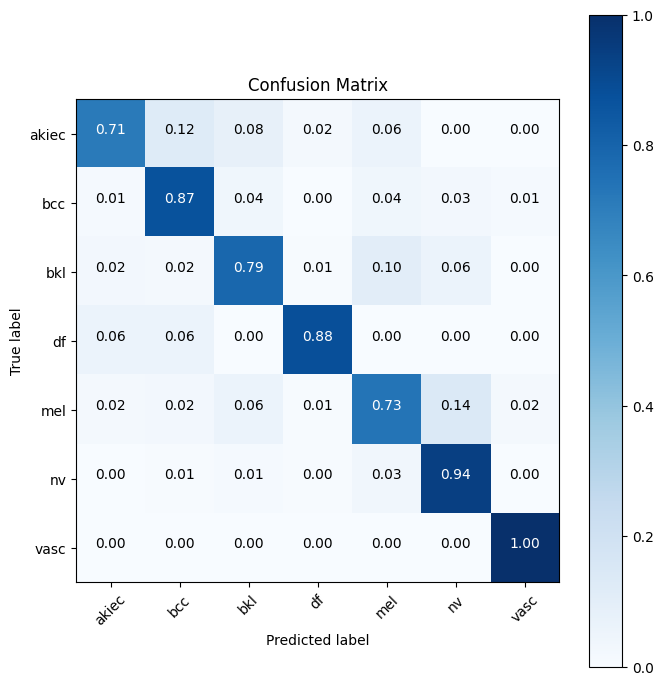

In [303]:
confusion_matrix_plot_labels = list(test_image_gen.class_indices.keys())
conf_matrix = confusion_matrix(ground_truths, predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [304]:
from sklearn.metrics import classification_report

print(classification_report(ground_truths, predictions, target_names=confusion_matrix_plot_labels))

              precision    recall  f1-score   support

       akiec       0.76      0.71      0.74        49
         bcc       0.77      0.87      0.82        77
         bkl       0.82      0.79      0.80       164
          df       0.68      0.88      0.77        17
         mel       0.68      0.73      0.71       166
          nv       0.96      0.94      0.95      1005
        vasc       0.81      1.00      0.89        21

    accuracy                           0.89      1499
   macro avg       0.78      0.85      0.81      1499
weighted avg       0.89      0.89      0.89      1499

